In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import collections

In [6]:
import pickle

In [7]:
import bridson

In [8]:
import sklearn.preprocessing
import sklearn.model_selection

In [9]:
import uproot
uproot.default_library = "np"

In [10]:
import os.path

In [11]:
import logging
logging.basicConfig(level=logging.INFO)

In [12]:
np.set_printoptions(precision=4, suppress=True)

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [14]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [59]:
class Lambda(torch.nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return self.fn(x)

In [60]:
def clone_model(model, force_eval=True, set_to_none=True):
    if force_eval:
        model.eval()
    model.zero_grad(set_to_none=set_to_none)
    return pickle.loads(pickle.dumps(model))

### Data

In [15]:
channel_names = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]

In [16]:
tree_names = [
    "RapidSim/B2Kee_tree.root:DecayTree;29",
    "RapidSim/B2KJpsi2ee_tree.root:DecayTree;36",
    "RapidSim/B2Kpsi2s2ee_tree.root:DecayTree;37",
    "RapidSim/D2phipi2ee_tree.root:DecayTree;31",
]

In [17]:
class DataFile(object):
    def __init__(self, path, name):
        self.path = path
        self.name = name
        self.raw = uproot.open(self.path)
    def features(self):
        return self.raw.keys()
    def true_features(self):
        return [name for name in self.raw.keys() if "TRUE" in name]
    def __len__(self):
        return self.raw.num_entries
    def __item__(self, name):
        return self.raw[name].array(library="np")
    def get(self, features, aliases={}):
        res = self.raw.arrays(features, aliases=aliases, library="np")
        array = np.empty((self.raw.num_entries, len(features)), dtype=float)
        for i, feature in enumerate(features):
            array[:,i] = res[feature]
        return array

In [18]:
basedir = os.path.expanduser("~/2021/")
files = [DataFile(os.path.join(basedir, path), name) for path, name in zip(tree_names, channel_names)]

In [19]:
def common_features(fs):
    return sorted(set.intersection(*[set(f.true_features()) for f in fs]))
common_features(files)

['angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Event selection

In [20]:
aliases = {
    "alpha": "angle_ee_TRUE",
    "log_a": "log(angle_ee_TRUE)",
    "log_ep_P": "log(ep_P_TRUE)",
    "log_em_P": "log(em_P_TRUE)",
    "log_ep_PT": "log(ep_PT_TRUE)",
    "log_em_PT": "log(em_PT_TRUE)",
    "log_max_pl": "fmax(log_ep_P,log_em_P)",
}

In [21]:
class SelectedData(object):
    def __init__(self, datafile, selector):
        assert selector.shape == (len(datafile), )
        self.datafile = datafile
        self.index = np.asarray(selector, dtype=bool)
        self.size = np.sum(self.index)
    def name(self):
        return self.datafile.name
    def get(self, features, aliases={}):
        return self.datafile.get(features, aliases=aliases)[self.index]
    def true_features(self):
        return self.datafile.true_features()
    def features(self):
        return self.datafile.features()
    def __len__(self):
        return self.size

In [22]:
def split(selected, **options):
    selector = selected.index
    arr = np.arange(len(selector))[selector]
    train_index, test_index = sklearn.model_selection.train_test_split(arr, **options)
    train_selector = np.zeros_like(selector, dtype=bool)
    test_selector = np.zeros_like(selector, dtype=bool)
    train_selector[train_index] = True
    test_selector[test_index] = True
    train = SelectedData(selected.datafile, train_selector)
    test = SelectedData(selected.datafile, test_selector)
    return train, test

In [23]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_TRUE > %g" % v1, "q2_TRUE < %g" % v2)

In [24]:
q_Kll_selector = q2_range(1.1, 6.0)
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)

In [25]:
selectors = [
    q_Kll_selector,
    q_Jpsi_e_selector,
    q_psi2S_e_selector,
    "True",
]

In [26]:
selected = [SelectedData(f, f.get([selector])[:,0]) for f, selector in zip(files, selectors)]

In [27]:
splitted = [split(f, shuffle=True, test_size=0.2) for f in selected]
train_ds = [x[0] for x in splitted]
test_ds = [x[1] for x in splitted]

In [28]:
df = pd.DataFrame(index=channel_names)
#df.index.name = "Channels"
df.columns.name = "#Events"
df["Total"] = None
df["Selected"] = None
df["Train"] = None
df["Test"] = None
for f in files:
    df.loc[f.name, "Total"] = len(f)
for f in selected:
    df.loc[f.name(), "Selected"] = len(f)
for f in train_ds:
    df.loc[f.name(), "Train"] = len(f)
for f in test_ds:
    df.loc[f.name(), "Test"] = len(f)
df["Selected/Total"] = df["Selected"] / df["Total"]
df

#Events           Total Selected   Train    Test Selected/Total
B⁺→K⁺ee          970116   247104  197683   49421       0.254716
B⁺→K⁺J/ψ(→ee)    960234   929755  743804  185951       0.968259
B⁺→K⁺ψ(2S)(→ee)  986271   939679  751743  187936       0.952759
D⁺→π⁺φ(→ee)      830027   830027  664021  166006            1.0

### KS tests

In [29]:
def perform_ks_test(datasets, selected_index):
    selected_dataset = datasets[selected_index]
    df_ks = pd.DataFrame()
    #df_ks.index.name = "Features"
    df_ks.columns.name = "KS test"
    for feature in selected_dataset.features():
        arr0 = selected_dataset.get([feature])[:,0]
        for index, arr in enumerate(datasets):
            if index == selected_index:
                continue
            if not feature in arr.features():
                continue
            arr1 = arr.get([feature])[:,0]
            df_ks.loc[feature, arr.name()] = scipy.stats.kstest(arr0,arr1).statistic
    return df_ks

In [30]:
perform_ks_test(train_ds, 0).style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Plots

In [31]:
def feature_plot(feature, datasets, aliases={}, bins=None, **kwargs):
    for f in datasets:
        plt.hist(f.get([feature], aliases=aliases), label="%s"%f.name(),
            density=True, histtype='step', bins=bins, **kwargs)
    plt.title(feature)
    plt.legend()
    plt.grid()
    plt.show()

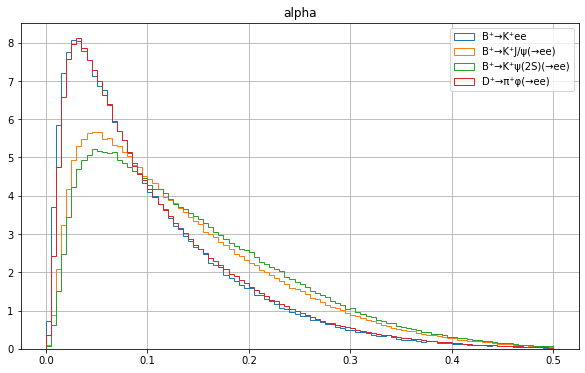

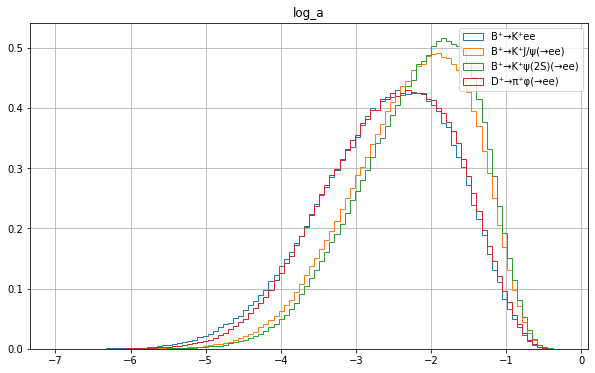

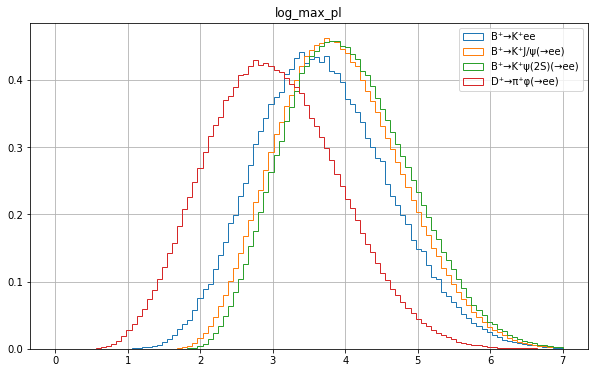

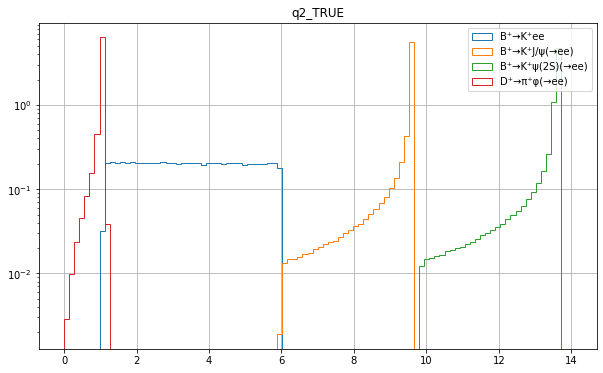

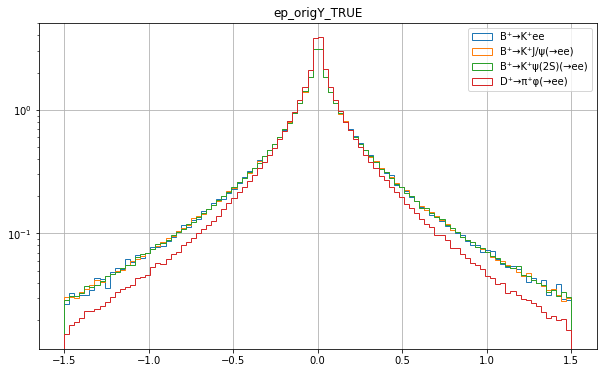

In [34]:
feature_plot("alpha", train_ds, aliases, np.linspace(0, 0.5, 101))
feature_plot("log_a", train_ds, aliases, np.linspace(-7, -0.25, 101))
feature_plot("log_max_pl", train_ds, aliases, np.linspace(0, 7, 101))
feature_plot("q2_TRUE", train_ds, aliases, np.linspace(0, 14, 101), log=True)
feature_plot("ep_origY_TRUE", train_ds, aliases, np.linspace(-1.5, 1.5, 101), log=True)

### Preprocessing

In [35]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

In [36]:
class Dataset(object):
    def __init__(self, features, sources, aliases={}, name=None):
        self.sources = sources
        self.features = features
        self.name = name
        self.counts = np.asarray([len(source) for source in self.sources])
        self.size = np.sum(self.counts)
        self.weights = self.size/self.counts/self.counts.size
        self.aliases = aliases
    def __len__(self):
        return np.sum(self.counts)
    def __repr__(self):
        return "DS%s" % self.name
    def X(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        lower = ccounts - self.counts
        result = torch.empty(ccounts[-1], len(self.features), **kwargs)
        for i in range(ccounts.size):
            np_data = self.sources[i].get(self.features, aliases=self.aliases)
            result[lower[i]:ccounts[i]] = torch.as_tensor(np_data, **kwargs)
        return result        
    def Y(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i]] = i
        return result
    def Y_hot(self):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], ccounts.size, **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i], i] = 0
        return result

In [37]:
feature_sets = [
    ("α", ["alpha"]),
    ("α,p", ["alpha", "log_max_pl"]),
    ("pt,pt", ["log_ep_PT", "log_em_PT"]),
    ("α,pt,pt", ["log_a", "log_ep_PT", "log_em_PT"]),
]
train_datasets = [
    ("₄", train_ds),
    ("₃", train_ds[:3]),
]

all_datasets = list()
for f in feature_sets:
    for t in train_datasets:
        all_datasets.append(Dataset(f[1], t[1], aliases, "%s[%s]"%(t[0],f[0])))
all_datasets

[DS₄[α],
 DS₃[α],
 DS₄[α,p],
 DS₃[α,p],
 DS₄[pt,pt],
 DS₃[pt,pt],
 DS₄[α,pt,pt],
 DS₃[α,pt,pt]]

In [38]:
class Scaler(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.features = dataset.features
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.minmax = sklearn.preprocessing.MinMaxScaler()
        x = to_numpy(dataset.X())
        self.scaler.fit(x)
        self.minmax.fit(x)
        self.mu = torch.as_tensor(self.scaler.mean_, dtype=float, device=device)
        self.sigma = torch.as_tensor(self.scaler.scale_, dtype=float, device=device)
        self.min = self.minmax.data_min_
        self.max = self.minmax.data_max_
    def forward(self, data):
        return ((data-self.mu)/self.sigma).float()
    def transform(self, x):
        return self.scaler.transform(x)
    def inverse_transform(self, x):
        return self.scaler.inverse_transform(x)

In [39]:
def plot_ds(dataset, scaler=None, ax=None, scale=3.0):
    sc = Scaler(dataset) if scaler is None else scaler
    axis = plt.gca() if ax is None else ax
    for source in dataset.sources:
        x = source.get(dataset.features, dataset.aliases)[:10000,0:2]
        axis.scatter(*(x.T), marker=".", s=0.1, label="%s"%source.name())
    upper = np.repeat(scale, 2)[None,:]
    lower = -upper
    x_min, y_min = sc.min # sc.inverse_transform(lower)[0]
    x_max, y_max = sc.max # sc.inverse_transform(upper)[0]
    axis.set_xlabel(dataset.features[0])
    axis.set_ylabel(dataset.features[1])
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    axis.set_title("DS%s"%dataset.name)
    
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_sizes([3.0])
        handle.set_linewidth(3.0)
        
    axis.legend(handler_map={
        mpl.collections.PathCollection:mpl.legend_handler.HandlerPathCollection(update_func=update_prop),
    })
    axis.grid()
    if ax is None:
        plt.show()

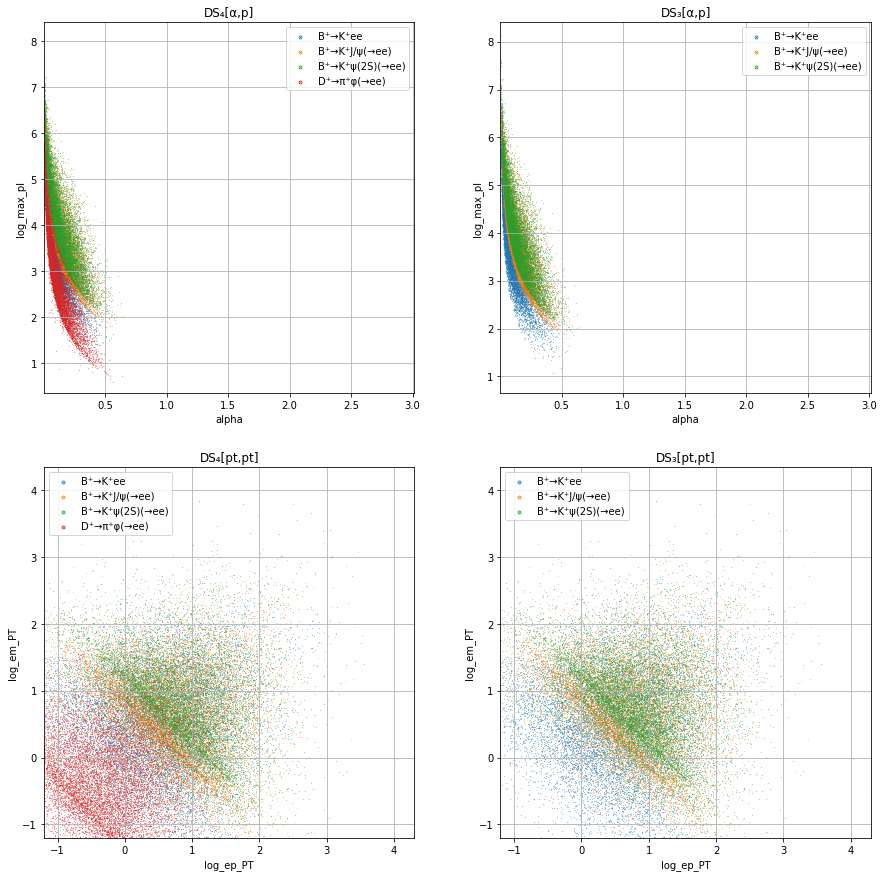

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
plot_ds(all_datasets[2], scale=2.0, ax=ax[0,0])
plot_ds(all_datasets[3], scale=2.0, ax=ax[0,1])
plot_ds(all_datasets[4], scale=2.0, ax=ax[1,0])
plot_ds(all_datasets[5], scale=2.0, ax=ax[1,1])
plt.show()

### NN

In [41]:
def model(inputs, outputs):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [42]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    total_count = len(loader.dataset)
    model.train()
    model.zero_grad()
    opt = torch.optim.Adam(params=model.parameters())
    opt.zero_grad()
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            total_loss += loss
            count = x.shape[0] if not accumulate else total_count
            loss /= count
            loss.backward()
            if not accumulate:
                opt.step()
                opt.zero_grad()
        mean_loss = total_loss / total_count
        if accumulate:
            opt.step()
            opt.zero_grad()
        logging.info("Epoch %d, %f", epoch, mean_loss)
    model.eval()
    model.zero_grad(set_to_none=True)

### Weight limits estimation

In [44]:
def train_estimator(dataset, model, device=device):
    model.to(device)
    ds = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(ds, batch_size=100000, shuffle=True, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=False)
    loader = Loader(ds, batch_size=100000, shuffle=False, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=True)
    return model.eval()

In [45]:
def make_estimator(dataset, device=device):
    scaler = Scaler(dataset)
    m = model(len(dataset.features), len(dataset.sources))
    return torch.nn.Sequential(scaler, m).to(device)

In [46]:
%%time
all_est = list()
for ds in all_datasets:
    est = make_estimator(ds)
    train_estimator(ds, est)
    all_est.append(est)
all_est

INFO:root:Epoch 0, 1.398922
INFO:root:Epoch 1, 1.379610
INFO:root:Epoch 2, 1.373174
INFO:root:Epoch 3, 1.369133
INFO:root:Epoch 4, 1.367832
INFO:root:Epoch 5, 1.367074
INFO:root:Epoch 6, 1.366457
INFO:root:Epoch 7, 1.365950
INFO:root:Epoch 8, 1.365540
INFO:root:Epoch 9, 1.365213
INFO:root:Epoch 10, 1.364956
INFO:root:Epoch 11, 1.364775
INFO:root:Epoch 12, 1.364643
INFO:root:Epoch 13, 1.364568
INFO:root:Epoch 14, 1.364481
INFO:root:Epoch 15, 1.364432
INFO:root:Epoch 16, 1.364395
INFO:root:Epoch 17, 1.364360
INFO:root:Epoch 18, 1.364331
INFO:root:Epoch 19, 1.364318
INFO:root:Epoch 20, 1.364283
INFO:root:Epoch 21, 1.364262
INFO:root:Epoch 22, 1.364249
INFO:root:Epoch 23, 1.364245
INFO:root:Epoch 24, 1.364210
INFO:root:Epoch 25, 1.364196
INFO:root:Epoch 26, 1.364169
INFO:root:Epoch 27, 1.364155
INFO:root:Epoch 28, 1.364146
INFO:root:Epoch 29, 1.364116
INFO:root:Epoch 30, 1.364110
INFO:root:Epoch 31, 1.364109
INFO:root:Epoch 32, 1.364086
INFO:root:Epoch 33, 1.364063
INFO:root:Epoch 34, 1.36

INFO:root:Epoch 35, 0.821754
INFO:root:Epoch 36, 0.821726
INFO:root:Epoch 37, 0.821695
INFO:root:Epoch 38, 0.821665
INFO:root:Epoch 39, 0.821640
INFO:root:Epoch 40, 0.821624
INFO:root:Epoch 41, 0.821615
INFO:root:Epoch 42, 0.821601
INFO:root:Epoch 43, 0.821574
INFO:root:Epoch 44, 0.821542
INFO:root:Epoch 45, 0.821517
INFO:root:Epoch 46, 0.821504
INFO:root:Epoch 47, 0.821494
INFO:root:Epoch 48, 0.821478
INFO:root:Epoch 49, 0.821451
INFO:root:Epoch 0, 1.184283
INFO:root:Epoch 1, 1.103387
INFO:root:Epoch 2, 1.098254
INFO:root:Epoch 3, 1.094323
INFO:root:Epoch 4, 1.091177
INFO:root:Epoch 5, 1.086859
INFO:root:Epoch 6, 1.080508
INFO:root:Epoch 7, 1.070639
INFO:root:Epoch 8, 1.055085
INFO:root:Epoch 9, 1.031354
INFO:root:Epoch 10, 1.000437
INFO:root:Epoch 11, 0.971850
INFO:root:Epoch 12, 0.953124
INFO:root:Epoch 13, 0.939111
INFO:root:Epoch 14, 0.925388
INFO:root:Epoch 15, 0.911689
INFO:root:Epoch 16, 0.898484
INFO:root:Epoch 17, 0.887365
INFO:root:Epoch 18, 0.879792
INFO:root:Epoch 19, 0.87

INFO:root:Epoch 20, 0.999363
INFO:root:Epoch 21, 0.999348
INFO:root:Epoch 22, 0.999236
INFO:root:Epoch 23, 0.999135
INFO:root:Epoch 24, 0.999126
INFO:root:Epoch 25, 0.999183
INFO:root:Epoch 26, 0.999218
INFO:root:Epoch 27, 0.999178
INFO:root:Epoch 28, 0.999098
INFO:root:Epoch 29, 0.999052
INFO:root:Epoch 30, 0.999066
INFO:root:Epoch 31, 0.999097
INFO:root:Epoch 32, 0.999091
INFO:root:Epoch 33, 0.999043
INFO:root:Epoch 34, 0.998997
INFO:root:Epoch 35, 0.998987
INFO:root:Epoch 36, 0.999001
INFO:root:Epoch 37, 0.999001
INFO:root:Epoch 38, 0.998974
INFO:root:Epoch 39, 0.998938
INFO:root:Epoch 40, 0.998920
INFO:root:Epoch 41, 0.998921
INFO:root:Epoch 42, 0.998919
INFO:root:Epoch 43, 0.998899
INFO:root:Epoch 44, 0.998872
INFO:root:Epoch 45, 0.998854
INFO:root:Epoch 46, 0.998848
INFO:root:Epoch 47, 0.998841
INFO:root:Epoch 48, 0.998825
INFO:root:Epoch 49, 0.998802
INFO:root:Epoch 0, 1.393085
INFO:root:Epoch 1, 1.376566
INFO:root:Epoch 2, 1.353581
INFO:root:Epoch 3, 1.282127
INFO:root:Epoch 4,

CPU times: user 3min 57s, sys: 15.5 s, total: 4min 12s
Wall time: 4min 10s


[Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=1, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
     (2): Linear(in_features=20, out_features=20, bias=True)
     (3): Softplus(beta=1, threshold=20)
     (4): Linear(in_features=20, out_features=20, bias=True)
     (5): Softplus(beta=1, threshold=20)
     (6): Linear(in_features=20, out_features=4, bias=True)
   )
 ),
 Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=1, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
     (2): Linear(in_features=20, out_features=20, bias=True)
     (3): Softplus(beta=1, threshold=20)
     (4): Linear(in_features=20, out_features=20, bias=True)
     (5): Softplus(beta=1, threshold=20)
     (6): Linear(in_features=20, out_features=3, bias=True)
   )
 ),
 Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
 

In [55]:
def plot_field(f, sc, scale=3.0, name=None, vmin=0.0, vmax=1.0, ax=None, color_bar=True):
    axis = plt.gca() if ax is None else ax
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    X_test = sc.inverse_transform(
        np.asarray(bridson.poisson_disc_samples(x2-x1, y2-y1, 0.02)) +
        np.asarray([x1, y1])
    )
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = axis.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    if color_bar:
        plt.colorbar(ax=axis, mappable=CS)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_xlabel(sc.features[0])
    axis.set_ylabel(sc.features[1])
    axis.grid()
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [102]:
def plot_one(f, sc, name=None, save=None, vmin=0.0, vmax=1.0, ax=None):
    axis = plt.gca() if ax is None else ax
    x_min, x_max = sc.min, sc.max
    X_test = np.linspace(x_min, x_max, 1001)
    y_pred = f(X_test).ravel()
    axis.plot(X_test, y_pred)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(vmin, vmax)
    axis.set_xlabel(sc.features[0])
    axis.grid()    
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [56]:
def plot_clf(clf, scaler, c0, c1, ax=None, scale=3.0, color_bar=True):
    fn = lambda x : x[:,c1] - x[:,c0]
    f_ = lambda x : torch.sigmoid(fn(clf(x)))
    f = ds.as_numpy(f_)
    name=r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]])
    plot_field(f, scaler, scale=scale, ax=ax, name=name, color_bar=color_bar)

In [57]:
def plot_clf_min_max(clf, ax_min=None, ax_max=None, scale=3.0):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : torch.relu(torch.min(fn(clf(x)), dim=-1)[0])
    f_max = lambda x : torch.relu(torch.min(-fn(clf(x)), dim=-1)[0])
    name_min = r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$'
    name_max = r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$'
    plot_field(as_numpy(f_min), clf[0], scale=scale, name=name_min, vmax=None, ax=ax_min, color_bar=False)
    plot_field(as_numpy(f_max), clf[0], scale=scale, name=name_max, vmax=None, ax=ax_max, color_bar=False)

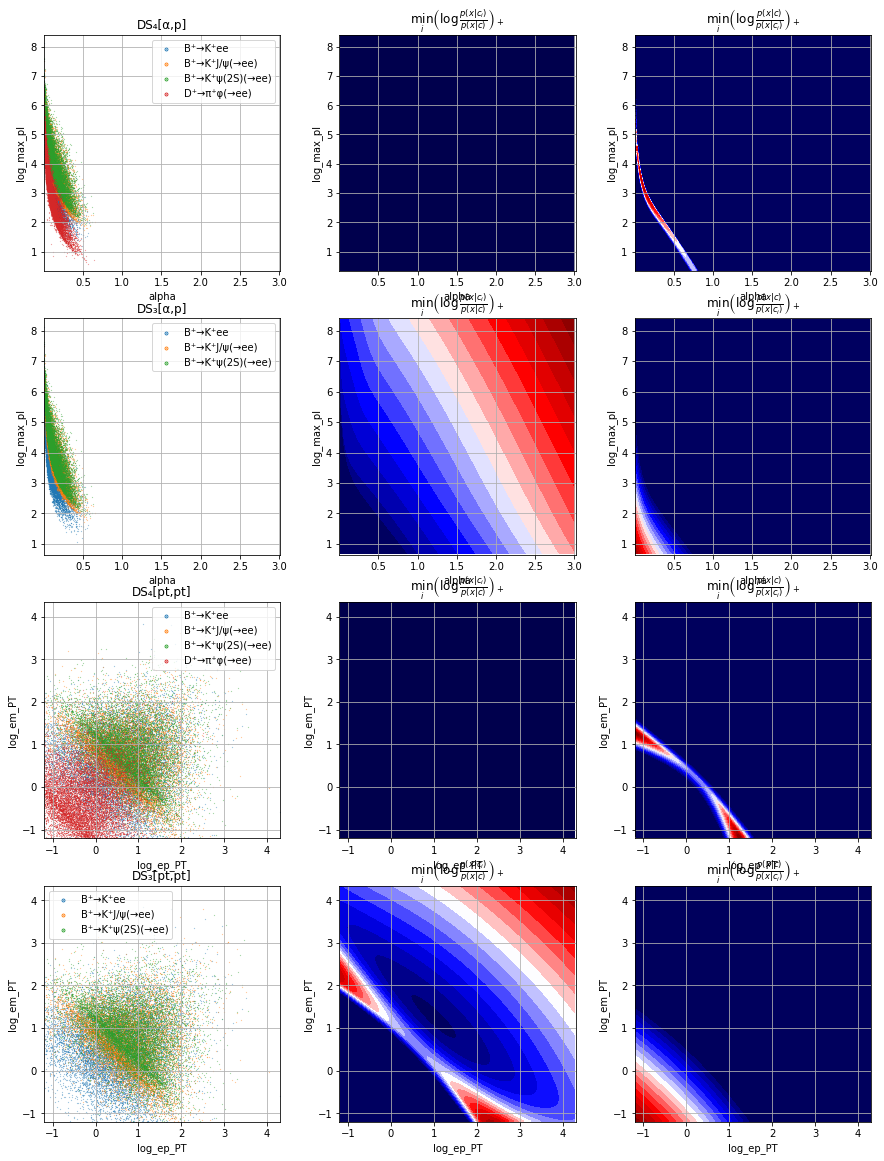

In [58]:
fig, ax = plt.subplots(4, 3, figsize=(15, 20))
for i in range(4):
    est = all_est[i+2]
    ds = all_datasets[i+2]
    plot_ds(ds, scaler=est[0], ax=ax[i,0])
    plot_clf_min_max(est, ax_min=ax[i,1], ax_max=ax[i,2])
plt.show()

### Weighting function

In [61]:
def compute_lipschitz(model, loader, device=device):
    model.eval().to(device)
    sc = model[0]
    fn = model[1:]
    L = 0
    for batch in loader:
        x, y = batch
        x.to(device)
        model.zero_grad()
        x_ = sc(x)
        x_.requires_grad = True
        fx = fn(x_)
        loss = torch.sum(fx)
        loss.backward()
        L = max(L, torch.max(x_.grad.norm(dim=1)).item())
    return L

In [62]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [63]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = model(x) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W, totals.view(1,-1)

In [64]:
def make_weighting_lp(Wpinv):
    import scipy.optimize
    n_classes, n_outs = Wpinv.shape
    c = np.asarray([-1]+[0]*(n_classes-1))
    bounds = [(0,1),(0.02,0.02), (0.01,0.03), (0,0.07)][:n_classes]
    A_ub = np.vstack([Wpinv.T, -Wpinv.T])
    b_ub = np.hstack([np.ones(n_outs), np.zeros(n_outs)])
    res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
    return np.maximum(Wpinv.T@res.x,0) if res.success else None

In [65]:
@torch.no_grad()
def make_weighting(Wpinv, linear, selected_class, n_outs, n_classes):
    assert Wpinv.shape == (n_classes, n_outs)
    weights = make_weighting_lp(Wpinv)
    if weights is None:
        w0 = Wpinv[selected_class]
        m_minus = np.max(-w0)
        m_plus = np.max(w0)
        m_sum = m_minus + m_plus
        k = np.maximum(m_minus*50, m_plus*50/49)
        weights = (w0 + k/50)/k
        #weights = (w0 + m_minus)/m_sum
    linear.weight.data = from_numpy(weights).view(linear.weight.data.shape)

In [66]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001, dxl=0.001, target_L=None):
    clone = clone_model(model)
    scaler = model[0]
    meat = model[1:3] # with softmax
    base = model[:3]
    linear = model[3]
    opt = torch.optim.SGD(params=meat.parameters(), lr=1e-4)    
    dx_ = torch.tensor([[[-1]],[[1]]], dtype=torch.float, device=device) * dxl
    try:
        for epoch in range(epochs):
            model.eval()
            with torch.no_grad():
                W, counts = create_w(base, loader, n_outs, n_classes)
            W_np = to_numpy(W)
            W_pinv = np.linalg.pinv(W_np)
            det = np.linalg.det(W_np.T@W_np)
            W_pinv_ = from_numpy(W_pinv)
            W_pinv_T = W_pinv_.T

            # fill linear coeffs
            make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)

            wcj = W_pinv[selected_class]                   # N
            wcj_ = (wcj<0)*0.98 - (wcj>1)*0.02
            #ix_min = np.argmin(wcj)
            #ix_max = np.argmax(wcj)
            #wcj_ = np.zeros(n_outs)
            #if m_minus * 49 > m_plus:
            #    wcj_[ix_min] = 1
            #else:
            #    wcj_[ix_max] = -1
            #wcj_[ix_min] = 0.98
            #wcj_[ix_max] = -0.02
            #wcj_ = np.log(1-np.minimum(wcj,0))-np.log(1+np.maximum(wcj-1,0))
            wki = np.sum(W_pinv*wcj_[None,:], axis=1)      # n
            W_m = np.multiply.outer(wcj, wki)              # N*n ~ W
            W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
            W_m_t = from_numpy(W_m_)

            for clone_par, model_par in zip(clone.parameters(), model.parameters()): 
                clone_par.data.copy_(model_par.data)
            #clone.load_state_dict(model.state_dict())

            model.train()
            opt.zero_grad()
            total_loss = 0    
            L = 0
            for batch in loader:
                x, y = batch

                y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
                pred = base(x)

                wsum = torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
                W = wsum/counts

                loss_c = torch.sum(W*W_m_t)
                loss_d = -torch.sum(W*W_pinv_T)
                loss = loss_d + alpha * loss_c
                total_loss += loss
                loss.backward()

                # Lipschitz part of the loss

                if True:
                    clone.zero_grad()
                    x_ = clone[0](x)
                    x_.requires_grad = True
                    fx = clone[1:](x_)
                    L_loss = torch.sum(fx)
                    L_loss.backward()
                    dx = x_.grad
                    L = max(L, torch.max(dx.norm(dim=1)).item())

                    if target_L is not None:
                        ext_dx = dx[None,...] * dx_ # 2*B*n_features
                        ext_x = x_[None,...] + ext_dx

                        pred_dfx = meat(ext_x) # 2*B*N
                        dfx = (pred_dfx[1] - pred_dfx[0])/(2*dxl)/target_L
                        loss_L = torch.sum(F.relu(torch.abs(dfx)-1)**2) / len(loader.dataset)

                        total_loss += loss_L
                        loss_L.backward()

            opt.step()
            #logging.info("Epoch %d, loss=%f est=%f", epoch, total_loss, ratio_estimator(W_pinv[selected_class]))
            print("Epoch %d loss=%f W+c=%s det=%f L=%f" % (epoch, total_loss, W_pinv[selected_class], det, L))
    except KeyboardInterrupt:
        pass
    model.eval()
    model.zero_grad(set_to_none=True)
    
    with torch.no_grad():
        W, counts = create_w(base, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)
    L = compute_lipschitz(model, loader)
    print("W=", W_np)
    print("W+=", W_pinv)
    print("L=", L)
    print("coef=", linear.weight.data.detach().cpu().numpy())

    return model

In [88]:
def train_weighting(model, dataset, n_outs, n_classes, selected_class, device=device, **kwargs):
    model.to(device)
    data = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=torch.float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(data, batch_size=100000, shuffle=False, device=device)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=200, alpha=0.001)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=500, alpha=300, **kwargs)
    return model.eval()

In [92]:
class Weighting(torch.nn.Module):
    def __init__(self, scaler, model, n_outs=None, name=None, device=device):
        super().__init__()
        
        scaler_ = clone_model(scaler)
        model_ = clone_model(model)
        
        n_inputs = len(scaler_.features)
        if n_outs is None:
            with torch.no_grad():
                z = torch.zeros(1, n_inputs, dtype=torch.float, device=device)
                n_outs = model_.to(device)(z).shape[1]
        
        self.features = scaler_.features
        self.n_inputs = n_inputs
        self.n_outs = n_outs
        self.name = name
        
        self.model = torch.nn.Sequential(
            scaler_,
            model_,
            torch.nn.Softmax(dim=-1),
            torch.nn.Linear(n_outs, 1, bias=False),
        ).to(device).eval()

    def forward(self, x):
        return self.model(x)
        
    def train(self, dataset, n_classes=None, selected_class=0, **kwargs):
        if n_classes is None:
            n_classes = len(dataset.sources)
        return train_weighting(self.model, dataset, self.n_outs, n_classes, selected_class, **kwargs)

In [93]:
def w_from_est(estimator, name=None):
    return Weighting(estimator[0], estimator[1:], name=name)

In [98]:
%%time
results = dict()
for target_L in [None, 1.0, 0.1]:
    for est, ds in zip(all_est, all_datasets):
        name = "w%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        w.train(ds, target_L=target_L)
        results[target_L, ds.name] = w

Epoch 0 loss=-4.000313 W+c=[ 6213.204  7664.503 -5186.885 -8706.342] det=-0.000000 L=0.028374
Epoch 1 loss=-4.002617 W+c=[ 5930.109  6854.622 -4485.615 -8229.613] det=0.000000 L=0.028533
Epoch 2 loss=-4.000145 W+c=[ 5700.051   6265.461  -3979.9258 -7856.6025] det=-0.000000 L=0.028675
Epoch 3 loss=-3.999596 W+c=[ 5513.174   5832.5    -3607.8691 -7564.178 ] det=0.000000 L=0.028826
Epoch 4 loss=-4.000175 W+c=[ 5356.2925  5497.992  -3319.6953 -7325.7197] det=-0.000000 L=0.028973
Epoch 5 loss=-3.999985 W+c=[ 5212.2686  5220.0254 -3082.0103 -7112.9907] det=-0.000000 L=0.029128
Epoch 6 loss=-4.000076 W+c=[ 5085.3657  4991.101  -2885.8386 -6929.6216] det=0.000000 L=0.029266
Epoch 7 loss=-4.000580 W+c=[ 4970.3394  4797.1816 -2719.6353 -6766.7524] det=-0.000000 L=0.029418
Epoch 8 loss=-4.000435 W+c=[ 4861.832   4629.9795 -2576.763  -6616.5747] det=0.000000 L=0.029557
Epoch 9 loss=-4.000114 W+c=[ 4758.794   4480.521  -2449.999  -6475.9893] det=-0.000000 L=0.029690
Epoch 10 loss=-3.999432 W+c=[ 46

Epoch 84 loss=-4.000008 W+c=[ 1891.4998  2273.74    -687.1255 -3014.0073] det=0.000000 L=0.039050
Epoch 85 loss=-3.999819 W+c=[ 1873.7947  2263.101   -680.7645 -2992.5496] det=0.000000 L=0.039161
Epoch 86 loss=-3.999840 W+c=[ 1857.1642  2254.5137  -675.2421 -2972.9517] det=-0.000000 L=0.039262
Epoch 87 loss=-4.000317 W+c=[ 1840.8625  2246.1733  -669.8607 -2953.7705] det=0.000000 L=0.039366
Epoch 88 loss=-3.999924 W+c=[ 1824.2045  2236.787   -664.158  -2933.7742] det=0.000000 L=0.039464
Epoch 89 loss=-4.000338 W+c=[ 1808.7861  2229.2112  -659.1268 -2915.7932] det=0.000000 L=0.039572
Epoch 90 loss=-4.000132 W+c=[ 1792.6179  2220.108   -653.6326 -2896.363 ] det=0.000000 L=0.039660
Epoch 91 loss=-4.000397 W+c=[ 1777.373   2212.5352  -648.7375 -2878.4697] det=-0.000000 L=0.039761
Epoch 92 loss=-4.000116 W+c=[ 1761.4541  2203.3608  -643.3342 -2859.2014] det=0.000000 L=0.039861
Epoch 93 loss=-3.999916 W+c=[ 1746.0005  2194.5881  -638.1035 -2840.5767] det=-0.000000 L=0.039961
Epoch 94 loss=-3.

Epoch 167 loss=-4.000223 W+c=[ 1008.9857  1752.0977  -406.1141 -1922.4083] det=0.000000 L=0.046055
Epoch 168 loss=-4.000165 W+c=[ 1002.6328  1747.5017  -404.0987 -1913.9764] det=0.000000 L=0.046127
Epoch 169 loss=-3.999983 W+c=[  996.2146  1742.9532  -402.1493 -1905.4375] det=0.000000 L=0.046196
Epoch 170 loss=-4.000067 W+c=[  989.9424  1738.4968  -400.2216 -1897.1045] det=0.000000 L=0.046273
Epoch 171 loss=-4.000021 W+c=[  983.6163  1733.8707  -398.2682 -1888.6224] det=0.000000 L=0.046340
Epoch 172 loss=-3.999970 W+c=[  977.5394  1729.4851  -396.3647 -1880.5375] det=0.000000 L=0.046413
Epoch 173 loss=-3.999971 W+c=[  971.3275  1724.9373  -394.4633 -1872.1869] det=0.000000 L=0.046484
Epoch 174 loss=-4.000081 W+c=[  965.4722  1720.9313  -392.6938 -1864.477 ] det=0.000000 L=0.046555
Epoch 175 loss=-3.999976 W+c=[  959.3981  1716.4983  -390.8476 -1856.3074] det=0.000000 L=0.046626
Epoch 176 loss=-3.999996 W+c=[  953.5404  1712.094   -388.9742 -1848.4302] det=0.000000 L=0.046699
Epoch 177 

Epoch 47 loss=-4.145982 W+c=[  642.6958  1449.9261  -289.7907 -1392.3618] det=0.000000 L=0.051639
Epoch 48 loss=-4.146330 W+c=[  639.5208  1446.7711  -288.7413 -1387.2632] det=0.000000 L=0.051708
Epoch 49 loss=-4.146611 W+c=[  636.3728  1443.5176  -287.6599 -1382.1681] det=0.000000 L=0.051774
Epoch 50 loss=-4.147006 W+c=[  633.3043  1440.5472  -286.6616 -1377.2662] det=0.000000 L=0.051839
Epoch 51 loss=-4.147385 W+c=[  630.2485  1437.5298  -285.6545 -1372.3594] det=0.000000 L=0.051908
Epoch 52 loss=-4.147761 W+c=[  627.2153  1434.4869  -284.6433 -1367.4689] det=0.000000 L=0.051976
Epoch 53 loss=-4.148125 W+c=[  624.201   1431.3293  -283.5966 -1362.5653] det=0.000000 L=0.052047
Epoch 54 loss=-4.148549 W+c=[  621.1833  1428.3881  -282.6384 -1357.7076] det=0.000000 L=0.052120
Epoch 55 loss=-4.148707 W+c=[  618.2172  1425.2974  -281.6219 -1352.8766] det=0.000000 L=0.052184
Epoch 56 loss=-4.149114 W+c=[  615.2925  1422.2778  -280.6262 -1348.1205] det=0.000000 L=0.052250
Epoch 57 loss=-4.149

Epoch 131 loss=-4.174421 W+c=[  450.6735  1229.4565  -223.3334 -1064.0168] det=0.000000 L=0.057201
Epoch 132 loss=-4.174862 W+c=[  449.0525  1227.2534  -222.7457 -1061.0085] det=0.000000 L=0.057268
Epoch 133 loss=-4.175189 W+c=[  447.4586  1225.112   -222.1734 -1058.0562] det=0.000000 L=0.057334
Epoch 134 loss=-4.175519 W+c=[  445.8625  1222.8942  -221.5825 -1055.0747] det=0.000000 L=0.057399
Epoch 135 loss=-4.175833 W+c=[  444.2649  1220.6497  -220.9886 -1052.079 ] det=0.000000 L=0.057464
Epoch 136 loss=-4.176276 W+c=[  442.7374  1218.6527  -220.4534 -1049.2599] det=0.000000 L=0.057530
Epoch 137 loss=-4.176532 W+c=[  441.161   1216.3585  -219.8461 -1046.2749] det=0.000000 L=0.057595
Epoch 138 loss=-4.176798 W+c=[  439.6225  1214.2927  -219.3037 -1043.4102] det=0.000000 L=0.057657
Epoch 139 loss=-4.177185 W+c=[  438.0918  1212.1232  -218.7296 -1040.5249] det=0.000000 L=0.057724
Epoch 140 loss=-4.177647 W+c=[  436.5644  1209.9797  -218.1678 -1037.6473] det=0.000000 L=0.057795
Epoch 141 

Epoch 217 loss=-4.204082 W+c=[ 345.9974 1063.7155 -182.6918 -854.8489] det=0.000000 L=0.062868
Epoch 218 loss=-4.204504 W+c=[ 345.1075 1062.0088 -182.3056 -852.8928] det=0.000000 L=0.062940
Epoch 219 loss=-4.204769 W+c=[ 344.2093 1060.2812 -181.9202 -850.9141] det=0.000000 L=0.063002
Epoch 220 loss=-4.205108 W+c=[ 343.3104 1058.5714 -181.5429 -848.9377] det=0.000000 L=0.063072
Epoch 221 loss=-4.205450 W+c=[ 342.4289 1056.9406 -181.1856 -847.0087] det=0.000000 L=0.063136
Epoch 222 loss=-4.205867 W+c=[ 341.5707 1055.3346 -180.8282 -845.1241] det=0.000000 L=0.063206
Epoch 223 loss=-4.206165 W+c=[ 340.7023 1053.6228 -180.4448 -843.1921] det=0.000000 L=0.063269
Epoch 224 loss=-4.206607 W+c=[ 339.8252 1051.9529 -180.0818 -841.2538] det=0.000000 L=0.063344
Epoch 225 loss=-4.206845 W+c=[ 338.9597 1050.2793 -179.7145 -839.3328] det=0.000000 L=0.063403
Epoch 226 loss=-4.207217 W+c=[ 338.1121 1048.6553 -179.3575 -837.4525] det=0.000000 L=0.063473
Epoch 227 loss=-4.207664 W+c=[ 337.2811 1047.0638 

Epoch 304 loss=-4.235378 W+c=[ 285.0915  931.1273 -155.183  -710.4109] det=0.000000 L=0.068842
Epoch 305 loss=-4.235725 W+c=[ 284.5529  929.7522 -154.9198 -709.0075] det=0.000000 L=0.068912
Epoch 306 loss=-4.236140 W+c=[ 284.0262  928.3886 -154.6557 -707.6265] det=0.000000 L=0.068985
Epoch 307 loss=-4.236509 W+c=[ 283.4926  927.0066 -154.3907 -706.2284] det=0.000000 L=0.069056
Epoch 308 loss=-4.236877 W+c=[ 282.9611  925.6552 -154.1354 -704.8409] det=0.000000 L=0.069129
Epoch 309 loss=-4.237164 W+c=[ 282.4416  924.2303 -153.8531 -703.4541] det=0.000000 L=0.069196
Epoch 310 loss=-4.237533 W+c=[ 281.9043  922.8385 -153.5917 -702.0444] det=0.000000 L=0.069265
Epoch 311 loss=-4.237944 W+c=[ 281.39    921.506  -153.3384 -700.6884] det=0.000000 L=0.069338
Epoch 312 loss=-4.238395 W+c=[ 280.8815  920.2223 -153.0987 -699.3541] det=0.000000 L=0.069410
Epoch 313 loss=-4.238694 W+c=[ 280.3689  918.8551 -152.8369 -697.99  ] det=0.000000 L=0.069477
Epoch 314 loss=-4.239127 W+c=[ 279.8584  917.5153 

Epoch 391 loss=-4.268822 W+c=[ 247.6359  820.7399 -135.0859 -604.2347] det=0.000000 L=0.075187
Epoch 392 loss=-4.269289 W+c=[ 247.3043  819.6068 -134.891  -603.1965] det=0.000000 L=0.075264
Epoch 393 loss=-4.269660 W+c=[ 246.9649  818.4366 -134.6892 -602.1361] det=0.000000 L=0.075338
Epoch 394 loss=-4.270054 W+c=[ 246.6249  817.2695 -134.4901 -601.0745] det=0.000000 L=0.075413
Epoch 395 loss=-4.270418 W+c=[ 246.2866  816.0757 -134.2817 -600.01  ] det=0.000000 L=0.075488
Epoch 396 loss=-4.270836 W+c=[ 245.9514  814.9136 -134.0831 -598.9575] det=0.000000 L=0.075567
Epoch 397 loss=-4.271235 W+c=[ 245.6283  813.8057 -133.8953 -597.939 ] det=0.000000 L=0.075638
Epoch 398 loss=-4.271675 W+c=[ 245.2952  812.6478 -133.6982 -596.8906] det=0.000000 L=0.075716
Epoch 399 loss=-4.272098 W+c=[ 244.9666  811.4636 -133.4912 -595.8433] det=0.000000 L=0.075796
Epoch 400 loss=-4.272491 W+c=[ 244.6384  810.3096 -133.2944 -594.8037] det=0.000000 L=0.075868
Epoch 401 loss=-4.272843 W+c=[ 244.3051  809.1564 

Epoch 478 loss=-4.305210 W+c=[ 223.3201  726.0703 -119.4065 -521.9945] det=0.000000 L=0.081977
Epoch 479 loss=-4.305652 W+c=[ 223.0876  725.0323 -119.24   -521.139 ] det=0.000000 L=0.082057
Epoch 480 loss=-4.306112 W+c=[ 222.8746  724.0676 -119.0866 -520.3325] det=0.000000 L=0.082139
Epoch 481 loss=-4.306567 W+c=[ 222.6444  723.0658 -118.9305 -519.4903] det=0.000000 L=0.082217
Epoch 482 loss=-4.306989 W+c=[ 222.4146  722.0101 -118.7584 -518.6348] det=0.000000 L=0.082303
Epoch 483 loss=-4.307377 W+c=[ 222.1906  720.9821 -118.5921 -517.7955] det=0.000000 L=0.082382
Epoch 484 loss=-4.307873 W+c=[ 221.9761  720.0439 -118.4491 -516.9941] det=0.000000 L=0.082462
Epoch 485 loss=-4.308317 W+c=[ 221.7515  719.0243 -118.2864 -516.1564] det=0.000000 L=0.082547
Epoch 486 loss=-4.308774 W+c=[ 221.5307  717.9937 -118.1188 -515.3221] det=0.000000 L=0.082631
Epoch 487 loss=-4.309230 W+c=[ 221.312   717.0002 -117.9621 -514.5001] det=0.000000 L=0.082711
Epoch 488 loss=-4.309557 W+c=[ 221.0871  715.9583 

Epoch 69 loss=-2.999936 W+c=[ 148.6756 -506.0951  413.186 ] det=0.000000 L=0.021435
Epoch 70 loss=-3.000004 W+c=[ 148.3181 -503.5308  411.2469] det=0.000000 L=0.021429
Epoch 71 loss=-2.999939 W+c=[ 147.9527 -500.9661  409.3051] det=0.000000 L=0.021423
Epoch 72 loss=-2.999979 W+c=[ 147.5858 -498.4195  407.3751] det=0.000000 L=0.021421
Epoch 73 loss=-2.999964 W+c=[ 147.2188 -495.9018  405.4676] det=0.000000 L=0.021417
Epoch 74 loss=-2.999915 W+c=[ 146.8558 -493.4247  403.592 ] det=0.000000 L=0.021411
Epoch 75 loss=-3.000113 W+c=[ 146.5198 -491.0739  401.8208] det=0.000000 L=0.021407
Epoch 76 loss=-2.999989 W+c=[ 146.1442 -488.6006  399.9434] det=0.000000 L=0.021401
Epoch 77 loss=-2.999947 W+c=[ 145.7719 -486.1642  398.0947] det=0.000000 L=0.021399
Epoch 78 loss=-2.999779 W+c=[ 145.4043 -483.7696  396.2792] det=0.000000 L=0.021391
Epoch 79 loss=-3.000105 W+c=[ 145.0775 -481.5454  394.6053] det=0.000000 L=0.021389
Epoch 80 loss=-3.000054 W+c=[ 144.7191 -479.2291  392.8513] det=0.000000 L=0

Epoch 166 loss=-2.999989 W+c=[ 118.5901 -346.3404  292.3882] det=0.000000 L=0.020955
Epoch 167 loss=-2.999945 W+c=[ 118.3277 -345.2701  291.5757] det=0.000000 L=0.020951
Epoch 168 loss=-3.000014 W+c=[ 118.0779 -344.2441  290.8012] det=0.000000 L=0.020947
Epoch 169 loss=-3.000026 W+c=[ 117.821  -343.1998  290.0095] det=0.000000 L=0.020943
Epoch 170 loss=-2.999991 W+c=[ 117.5755 -342.1958  289.2523] det=0.000000 L=0.020938
Epoch 171 loss=-3.000018 W+c=[ 117.3165 -341.1531  288.46  ] det=0.000000 L=0.020935
Epoch 172 loss=-2.999896 W+c=[ 117.0572 -340.1142  287.6705] det=0.000000 L=0.020930
Epoch 173 loss=-2.999968 W+c=[ 116.8079 -339.1107  286.9109] det=0.000000 L=0.020926
Epoch 174 loss=-2.999964 W+c=[ 116.557  -338.1058  286.1493] det=0.000000 L=0.020922
Epoch 175 loss=-3.000058 W+c=[ 116.316  -337.1365  285.418 ] det=0.000000 L=0.020919
Epoch 176 loss=-2.999850 W+c=[ 116.0442 -336.0728  284.6024] det=0.000000 L=0.020914
Epoch 177 loss=-3.000016 W+c=[ 115.8147 -335.1482  283.9088] det=

Epoch 61 loss=-3.226872 W+c=[  97.903  -260.6873  229.8957] det=0.000000 L=0.020834
Epoch 62 loss=-3.227424 W+c=[  97.715  -259.943   229.3623] det=0.000000 L=0.020835
Epoch 63 loss=-3.228127 W+c=[  97.5353 -259.2252  228.8528] det=0.000000 L=0.020836
Epoch 64 loss=-3.228849 W+c=[  97.3574 -258.5144  228.3486] det=0.000000 L=0.020838
Epoch 65 loss=-3.229409 W+c=[  97.1678 -257.7713  227.8138] det=0.000000 L=0.020839
Epoch 66 loss=-3.230188 W+c=[  96.9948 -257.0791  227.3255] det=0.000000 L=0.020841
Epoch 67 loss=-3.230803 W+c=[  96.8148 -256.3676  226.818 ] det=0.000000 L=0.020841
Epoch 68 loss=-3.231424 W+c=[  96.6312 -255.6482  226.3028] det=0.000000 L=0.020842
Epoch 69 loss=-3.232043 W+c=[  96.4538 -254.9487  225.8051] det=0.000000 L=0.020843
Epoch 70 loss=-3.232792 W+c=[  96.2786 -254.2569  225.3135] det=0.000000 L=0.020845
Epoch 71 loss=-3.233443 W+c=[  96.1019 -253.5629  224.8195] det=0.000000 L=0.020846
Epoch 72 loss=-3.234058 W+c=[  95.9195 -252.8546  224.3111] det=0.000000 L=0

Epoch 158 loss=-3.291790 W+c=[  82.7295 -204.0239  189.3628] det=0.000000 L=0.021081
Epoch 159 loss=-3.292408 W+c=[  82.5951 -203.5509  189.0208] det=0.000000 L=0.021084
Epoch 160 loss=-3.293186 W+c=[  82.468  -203.0986  188.6986] det=0.000000 L=0.021088
Epoch 161 loss=-3.293888 W+c=[  82.3374 -202.6378  188.3675] det=0.000000 L=0.021093
Epoch 162 loss=-3.294592 W+c=[  82.2087 -202.1823  188.041 ] det=0.000000 L=0.021096
Epoch 163 loss=-3.295185 W+c=[  82.0704 -201.7016  187.6893] det=0.000000 L=0.021100
Epoch 164 loss=-3.295799 W+c=[  81.9338 -201.2263  187.3421] det=0.000000 L=0.021104
Epoch 165 loss=-3.296546 W+c=[  81.8105 -200.7875  187.0305] det=0.000000 L=0.021108
Epoch 166 loss=-3.297266 W+c=[  81.6812 -200.3334  186.7031] det=0.000000 L=0.021113
Epoch 167 loss=-3.297989 W+c=[  81.5549 -199.8879  186.384 ] det=0.000000 L=0.021117
Epoch 168 loss=-3.298657 W+c=[  81.4249 -199.4333  186.0553] det=0.000000 L=0.021121
Epoch 169 loss=-3.299337 W+c=[  81.2968 -198.9843  185.7315] det=

Epoch 255 loss=-3.360770 W+c=[  71.6709 -165.9116  161.6965] det=0.000000 L=0.021596
Epoch 256 loss=-3.361539 W+c=[  71.5747 -165.585   161.458 ] det=0.000000 L=0.021603
Epoch 257 loss=-3.362296 W+c=[  71.4782 -165.2574  161.2178] det=0.000000 L=0.021610
Epoch 258 loss=-3.362997 W+c=[  71.3793 -164.9247  160.9723] det=0.000000 L=0.021616
Epoch 259 loss=-3.363782 W+c=[  71.2844 -164.6019  160.7366] det=0.000000 L=0.021624
Epoch 260 loss=-3.364490 W+c=[  71.1881 -164.276   160.4973] det=0.000000 L=0.021630
Epoch 261 loss=-3.365219 W+c=[  71.0903 -163.9465  160.2538] det=0.000000 L=0.021637
Epoch 262 loss=-3.365990 W+c=[  70.9985 -163.6326  160.0263] det=0.000000 L=0.021643
Epoch 263 loss=-3.366825 W+c=[  70.9092 -163.3254  159.8052] det=0.000000 L=0.021651
Epoch 264 loss=-3.367488 W+c=[  70.8093 -162.9916  159.5562] det=0.000000 L=0.021657
Epoch 265 loss=-3.368280 W+c=[  70.7153 -162.673   159.3227] det=0.000000 L=0.021665
Epoch 266 loss=-3.368940 W+c=[  70.6183 -162.3468  159.0806] det=

Epoch 352 loss=-3.426142 W+c=[  63.4672 -138.24    141.166 ] det=0.000000 L=0.022362
Epoch 353 loss=-3.426745 W+c=[  63.3958 -137.9988  140.9853] det=0.000000 L=0.022370
Epoch 354 loss=-3.427332 W+c=[  63.3218 -137.7523  140.7985] det=0.000000 L=0.022380
Epoch 355 loss=-3.427912 W+c=[  63.2516 -137.5146  140.6211] det=0.000000 L=0.022389
Epoch 356 loss=-3.428515 W+c=[  63.1787 -137.2706  140.4364] det=0.000000 L=0.022398
Epoch 357 loss=-3.429082 W+c=[  63.1068 -137.0294  140.2545] det=0.000000 L=0.022407
Epoch 358 loss=-3.429609 W+c=[  63.0341 -136.7867  140.0707] det=0.000000 L=0.022416
Epoch 359 loss=-3.430212 W+c=[  62.9616 -136.5442  139.8867] det=0.000000 L=0.022425
Epoch 360 loss=-3.430835 W+c=[  62.8907 -136.3064  139.7077] det=0.000000 L=0.022435
Epoch 361 loss=-3.431339 W+c=[  62.8201 -136.069   139.5287] det=0.000000 L=0.022443
Epoch 362 loss=-3.431907 W+c=[  62.7474 -135.827   139.3443] det=0.000000 L=0.022452
Epoch 363 loss=-3.432487 W+c=[  62.6749 -135.5858  139.1608] det=

Epoch 449 loss=-3.482599 W+c=[  57.2393 -117.4197  125.1828] det=0.000000 L=0.023339
Epoch 450 loss=-3.483196 W+c=[  57.1842 -117.2345  125.0386] det=0.000000 L=0.023349
Epoch 451 loss=-3.483773 W+c=[  57.1278 -117.0463  124.8908] det=0.000000 L=0.023360
Epoch 452 loss=-3.484355 W+c=[  57.0722 -116.86    124.7449] det=0.000000 L=0.023371
Epoch 453 loss=-3.484950 W+c=[  57.0171 -116.6752  124.6005] det=0.000000 L=0.023383
Epoch 454 loss=-3.485523 W+c=[  56.9602 -116.4863  124.4511] det=0.000000 L=0.023394
Epoch 455 loss=-3.486115 W+c=[  56.9063 -116.3045  124.3097] det=0.000000 L=0.023405
Epoch 456 loss=-3.486674 W+c=[  56.8481 -116.1128  124.1566] det=0.000000 L=0.023416
Epoch 457 loss=-3.487262 W+c=[  56.794  -115.931   124.0148] det=0.000000 L=0.023427
Epoch 458 loss=-3.487884 W+c=[  56.7407 -115.7509  123.8746] det=0.000000 L=0.023439
Epoch 459 loss=-3.488412 W+c=[  56.6842 -115.5637  123.726 ] det=0.000000 L=0.023450
Epoch 460 loss=-3.489051 W+c=[  56.63   -115.3818  123.5833] det=

Epoch 43 loss=-4.000079 W+c=[ 4.8215 -4.3642  1.7437 -1.7025] det=0.000056 L=0.972313
Epoch 44 loss=-4.000080 W+c=[ 4.8196 -4.3499  1.7275 -1.7025] det=0.000056 L=0.975241
Epoch 45 loss=-4.000080 W+c=[ 4.8178 -4.3358  1.7116 -1.7026] det=0.000057 L=0.978150
Epoch 46 loss=-4.000081 W+c=[ 4.8159 -4.3218  1.6959 -1.7026] det=0.000057 L=0.981043
Epoch 47 loss=-4.000079 W+c=[ 4.8141 -4.3078  1.6805 -1.7027] det=0.000058 L=0.983918
Epoch 48 loss=-4.000081 W+c=[ 4.8122 -4.294   1.6654 -1.7027] det=0.000058 L=0.986777
Epoch 49 loss=-4.000079 W+c=[ 4.8104 -4.2803  1.6506 -1.7028] det=0.000059 L=0.989620
Epoch 50 loss=-4.000081 W+c=[ 4.8086 -4.2666  1.636  -1.7028] det=0.000060 L=0.992448
Epoch 51 loss=-4.000080 W+c=[ 4.8067 -4.2531  1.6216 -1.7029] det=0.000060 L=0.995258
Epoch 52 loss=-4.000081 W+c=[ 4.8049 -4.2396  1.6075 -1.703 ] det=0.000061 L=0.998056
Epoch 53 loss=-4.000079 W+c=[ 4.8031 -4.2263  1.5936 -1.703 ] det=0.000061 L=1.000839
Epoch 54 loss=-4.000080 W+c=[ 4.8013 -4.213   1.58   -

Epoch 138 loss=-4.000082 W+c=[ 4.6599 -3.3358  0.9202 -1.7037] det=0.000104 L=1.240960
Epoch 139 loss=-4.000080 W+c=[ 4.6583 -3.3275  0.9157 -1.7037] det=0.000105 L=1.243697
Epoch 140 loss=-4.000081 W+c=[ 4.6567 -3.3193  0.9113 -1.7036] det=0.000105 L=1.246431
Epoch 141 loss=-4.000081 W+c=[ 4.6551 -3.3111  0.9069 -1.7036] det=0.000106 L=1.249162
Epoch 142 loss=-4.000081 W+c=[ 4.6535 -3.3029  0.9026 -1.7036] det=0.000106 L=1.251892
Epoch 143 loss=-4.000080 W+c=[ 4.6519 -3.2948  0.8984 -1.7035] det=0.000107 L=1.254619
Epoch 144 loss=-4.000080 W+c=[ 4.6504 -3.2867  0.8941 -1.7035] det=0.000108 L=1.257342
Epoch 145 loss=-4.000082 W+c=[ 4.6488 -3.2787  0.8899 -1.7035] det=0.000108 L=1.260065
Epoch 146 loss=-4.000082 W+c=[ 4.6472 -3.2707  0.8858 -1.7034] det=0.000109 L=1.262785
Epoch 147 loss=-4.000081 W+c=[ 4.6456 -3.2627  0.8817 -1.7034] det=0.000109 L=1.265503
Epoch 148 loss=-4.000081 W+c=[ 4.644  -3.2548  0.8776 -1.7034] det=0.000110 L=1.268217
Epoch 149 loss=-4.000082 W+c=[ 4.6425 -3.24

Epoch 29 loss=-15.395172 W+c=[ 8.1063 -0.7946  0.6442 -1.199 ] det=0.000086 L=3.519797
Epoch 30 loss=-15.318539 W+c=[ 8.148  -0.7828  0.6441 -1.1924] det=0.000085 L=3.548652
Epoch 31 loss=-15.246612 W+c=[ 8.1871 -0.7714  0.6439 -1.186 ] det=0.000084 L=3.576515
Epoch 32 loss=-15.179066 W+c=[ 8.224  -0.7606  0.6434 -1.1799] det=0.000084 L=3.603435
Epoch 33 loss=-15.115575 W+c=[ 8.2585 -0.7501  0.6428 -1.174 ] det=0.000083 L=3.629462
Epoch 34 loss=-15.055864 W+c=[ 8.2909 -0.7402  0.6421 -1.1684] det=0.000083 L=3.654647
Epoch 35 loss=-14.999667 W+c=[ 8.3214 -0.7306  0.6412 -1.163 ] det=0.000082 L=3.679837
Epoch 36 loss=-14.946748 W+c=[ 8.3498 -0.7214  0.6402 -1.1577] det=0.000082 L=3.704508
Epoch 37 loss=-14.896880 W+c=[ 8.3765 -0.7125  0.639  -1.1527] det=0.000081 L=3.728487
Epoch 38 loss=-14.849880 W+c=[ 8.4015 -0.704   0.6378 -1.1478] det=0.000081 L=3.751825
Epoch 39 loss=-14.805552 W+c=[ 8.4248 -0.6957  0.6364 -1.1431] det=0.000081 L=3.775335
Epoch 40 loss=-14.763730 W+c=[ 8.4465 -0.68

Epoch 123 loss=-14.017147 W+c=[ 8.4139 -0.411   0.444  -0.9525] det=0.000106 L=5.574793
Epoch 124 loss=-14.016093 W+c=[ 8.4087 -0.4095  0.4421 -0.9512] det=0.000106 L=5.592669
Epoch 125 loss=-14.015059 W+c=[ 8.4034 -0.4079  0.4402 -0.9499] det=0.000107 L=5.610476
Epoch 126 loss=-14.014031 W+c=[ 8.3982 -0.4064  0.4383 -0.9486] det=0.000107 L=5.628217
Epoch 127 loss=-14.013018 W+c=[ 8.393  -0.405   0.4364 -0.9474] det=0.000108 L=5.645885
Epoch 128 loss=-14.012021 W+c=[ 8.3878 -0.4035  0.4345 -0.9461] det=0.000108 L=5.663482
Epoch 129 loss=-14.011020 W+c=[ 8.3827 -0.4021  0.4327 -0.9449] det=0.000109 L=5.681014
Epoch 130 loss=-14.010030 W+c=[ 8.3775 -0.4006  0.4308 -0.9437] det=0.000109 L=5.698476
Epoch 131 loss=-14.009046 W+c=[ 8.3724 -0.3992  0.429  -0.9425] det=0.000110 L=5.715866
Epoch 132 loss=-14.008069 W+c=[ 8.3673 -0.3978  0.4272 -0.9412] det=0.000110 L=5.733186
Epoch 133 loss=-14.007090 W+c=[ 8.3622 -0.3964  0.4254 -0.9401] det=0.000111 L=5.750434
Epoch 134 loss=-14.006126 W+c=[ 

Epoch 217 loss=-13.917561 W+c=[ 8.0164 -0.3158  0.3123 -0.8655] det=0.000151 L=6.965883
Epoch 218 loss=-13.916389 W+c=[ 8.0132 -0.3152  0.3113 -0.8649] det=0.000152 L=6.977817
Epoch 219 loss=-13.915208 W+c=[ 8.0099 -0.3145  0.3103 -0.8642] det=0.000152 L=6.989698
Epoch 220 loss=-13.914013 W+c=[ 8.0066 -0.3138  0.3093 -0.8635] det=0.000153 L=7.001527
Epoch 221 loss=-13.912838 W+c=[ 8.0034 -0.3131  0.3084 -0.8629] det=0.000153 L=7.013307
Epoch 222 loss=-13.911641 W+c=[ 8.0002 -0.3125  0.3074 -0.8622] det=0.000154 L=7.025029
Epoch 223 loss=-13.910455 W+c=[ 7.9969 -0.3118  0.3064 -0.8616] det=0.000154 L=7.036700
Epoch 224 loss=-13.909269 W+c=[ 7.9937 -0.3112  0.3055 -0.861 ] det=0.000155 L=7.048326
Epoch 225 loss=-13.908090 W+c=[ 7.9906 -0.3105  0.3045 -0.8603] det=0.000155 L=7.059892
Epoch 226 loss=-13.906898 W+c=[ 7.9874 -0.3099  0.3036 -0.8597] det=0.000156 L=7.071411
Epoch 227 loss=-13.905703 W+c=[ 7.9842 -0.3093  0.3026 -0.859 ] det=0.000156 L=7.082881
Epoch 228 loss=-13.904513 W+c=[ 

Epoch 311 loss=-13.807552 W+c=[ 7.7586 -0.2671  0.2403 -0.8158] det=0.000192 L=7.923140
Epoch 312 loss=-13.806433 W+c=[ 7.7563 -0.2667  0.2397 -0.8154] det=0.000193 L=7.931866
Epoch 313 loss=-13.805326 W+c=[ 7.754  -0.2663  0.2392 -0.8149] det=0.000193 L=7.940555
Epoch 314 loss=-13.804210 W+c=[ 7.7517 -0.2659  0.2386 -0.8145] det=0.000193 L=7.949214
Epoch 315 loss=-13.803107 W+c=[ 7.7494 -0.2655  0.238  -0.8141] det=0.000194 L=7.957839
Epoch 316 loss=-13.802009 W+c=[ 7.7471 -0.2651  0.2374 -0.8137] det=0.000194 L=7.966430
Epoch 317 loss=-13.800895 W+c=[ 7.7448 -0.2647  0.2369 -0.8133] det=0.000195 L=7.974992
Epoch 318 loss=-13.799797 W+c=[ 7.7425 -0.2644  0.2363 -0.8129] det=0.000195 L=7.983521
Epoch 319 loss=-13.798700 W+c=[ 7.7403 -0.264   0.2357 -0.8125] det=0.000195 L=7.992020
Epoch 320 loss=-13.797604 W+c=[ 7.738  -0.2636  0.2352 -0.812 ] det=0.000196 L=8.000490
Epoch 321 loss=-13.796498 W+c=[ 7.7358 -0.2632  0.2346 -0.8116] det=0.000196 L=8.008929
Epoch 322 loss=-13.795406 W+c=[ 

Epoch 405 loss=-13.711511 W+c=[ 7.5658 -0.2365  0.1958 -0.7823] det=0.000228 L=8.630363
Epoch 406 loss=-13.710574 W+c=[ 7.564  -0.2362  0.1955 -0.782 ] det=0.000229 L=8.636942
Epoch 407 loss=-13.709654 W+c=[ 7.5622 -0.2359  0.1951 -0.7817] det=0.000229 L=8.643489
Epoch 408 loss=-13.708728 W+c=[ 7.5604 -0.2357  0.1947 -0.7814] det=0.000229 L=8.650030
Epoch 409 loss=-13.707813 W+c=[ 7.5586 -0.2354  0.1943 -0.7811] det=0.000230 L=8.656543
Epoch 410 loss=-13.706900 W+c=[ 7.5567 -0.2351  0.194  -0.7808] det=0.000230 L=8.663264
Epoch 411 loss=-13.705975 W+c=[ 7.5549 -0.2349  0.1936 -0.7805] det=0.000230 L=8.670295
Epoch 412 loss=-13.705056 W+c=[ 7.5531 -0.2346  0.1932 -0.7802] det=0.000231 L=8.677299
Epoch 413 loss=-13.704143 W+c=[ 7.5513 -0.2343  0.1928 -0.7799] det=0.000231 L=8.684286
Epoch 414 loss=-13.703238 W+c=[ 7.5495 -0.2341  0.1925 -0.7796] det=0.000232 L=8.691260
Epoch 415 loss=-13.702329 W+c=[ 7.5477 -0.2338  0.1921 -0.7793] det=0.000232 L=8.698214
Epoch 416 loss=-13.701422 W+c=[ 

Epoch 499 loss=-13.632664 W+c=[ 7.4089 -0.2151  0.1659 -0.7575] det=0.000260 L=9.262130
W= [[0.1749 0.0085 0.0011 0.0878]
 [0.4098 0.5953 0.4562 0.0711]
 [0.1156 0.3957 0.5427 0.0017]
 [0.2996 0.0005 0.     0.8394]]
W+= [[ 7.4074 -0.2149  0.1656 -0.7572]
 [-8.1178  4.0438 -3.3826  0.5137]
 [ 4.3493 -2.9032  4.2741 -0.2177]
 [-2.6388  0.0743 -0.0571  1.4612]]
L= 9.26828384399414
coef= [[0.7787 0.0225 0.     0.    ]]
Epoch 0 loss=-3.000077 W+c=[ 1.9046 -2.1204  1.2211] det=0.000506 L=0.683638
Epoch 1 loss=-3.000077 W+c=[ 1.9056 -2.1079  1.2058] det=0.000512 L=0.687751
Epoch 2 loss=-3.000077 W+c=[ 1.9066 -2.0956  1.1908] det=0.000518 L=0.691806
Epoch 3 loss=-3.000078 W+c=[ 1.9075 -2.0834  1.176 ] det=0.000524 L=0.695804
Epoch 4 loss=-3.000078 W+c=[ 1.9085 -2.0714  1.1616] det=0.000530 L=0.699746
Epoch 5 loss=-3.000078 W+c=[ 1.9094 -2.0595  1.1475] det=0.000536 L=0.703631
Epoch 6 loss=-3.000078 W+c=[ 1.9104 -2.0478  1.1336] det=0.000542 L=0.707462
Epoch 7 loss=-3.000079 W+c=[ 1.9113 -2.036

Epoch 100 loss=-3.000066 W+c=[ 1.9746 -1.3534  0.4923] det=0.001091 L=1.104384
Epoch 101 loss=-3.000067 W+c=[ 1.9751 -1.3488  0.4891] det=0.001096 L=1.108449
Epoch 102 loss=-3.000066 W+c=[ 1.9755 -1.3441  0.486 ] det=0.001102 L=1.112502
Epoch 103 loss=-3.000066 W+c=[ 1.976  -1.3396  0.483 ] det=0.001107 L=1.116544
Epoch 104 loss=-3.000066 W+c=[ 1.9764 -1.335   0.48  ] det=0.001113 L=1.120576
Epoch 105 loss=-3.000065 W+c=[ 1.9769 -1.3305  0.477 ] det=0.001118 L=1.124596
Epoch 106 loss=-3.000066 W+c=[ 1.9773 -1.326   0.474 ] det=0.001124 L=1.128605
Epoch 107 loss=-3.000065 W+c=[ 1.9777 -1.3216  0.4711] det=0.001129 L=1.132605
Epoch 108 loss=-3.000065 W+c=[ 1.9782 -1.3171  0.4682] det=0.001135 L=1.136594
Epoch 109 loss=-3.000066 W+c=[ 1.9786 -1.3128  0.4654] det=0.001141 L=1.140572
Epoch 110 loss=-3.000066 W+c=[ 1.979  -1.3084  0.4626] det=0.001146 L=1.144542
Epoch 111 loss=-3.000066 W+c=[ 1.9795 -1.3041  0.4598] det=0.001152 L=1.148499
Epoch 112 loss=-3.000066 W+c=[ 1.9799 -1.2998  0.457

Epoch 1 loss=-15.898456 W+c=[ 2.1287 -0.7052  0.2252] det=0.001676 L=1.847230
Epoch 2 loss=-13.503106 W+c=[ 2.2278 -0.552   0.1872] det=0.001632 L=2.201630
Epoch 3 loss=-11.982346 W+c=[ 2.3106 -0.4598  0.1641] det=0.001567 L=2.540319
Epoch 4 loss=-10.923623 W+c=[ 2.3817 -0.3974  0.1483] det=0.001500 L=2.869822
Epoch 5 loss=-10.140126 W+c=[ 2.4442 -0.352   0.1365] det=0.001437 L=3.190610
Epoch 6 loss=-9.534835 W+c=[ 2.4998 -0.3173  0.1274] det=0.001379 L=3.503223
Epoch 7 loss=-9.052164 W+c=[ 2.5499 -0.2897  0.1201] det=0.001327 L=3.814923
Epoch 8 loss=-8.657729 W+c=[ 2.5954 -0.2672  0.1139] det=0.001281 L=4.127562
Epoch 9 loss=-8.329093 W+c=[ 2.6371 -0.2485  0.1087] det=0.001239 L=4.429630
Epoch 10 loss=-8.050941 W+c=[ 2.6754 -0.2326  0.1042] det=0.001201 L=4.734589
Epoch 11 loss=-7.812403 W+c=[ 2.7107 -0.219   0.1002] det=0.001167 L=5.034256
Epoch 12 loss=-7.605585 W+c=[ 2.7435 -0.2071  0.0967] det=0.001137 L=5.326421
Epoch 13 loss=-7.424560 W+c=[ 2.774  -0.1966  0.0935] det=0.001110 L

Epoch 107 loss=-5.236615 W+c=[ 3.22   -0.0536  0.0313] det=0.001127 L=7.134708
Epoch 108 loss=-5.234131 W+c=[ 3.219  -0.0533  0.0311] det=0.001133 L=7.138256
Epoch 109 loss=-5.231690 W+c=[ 3.2179 -0.0531  0.031 ] det=0.001138 L=7.141772
Epoch 110 loss=-5.229293 W+c=[ 3.2168 -0.0528  0.0308] det=0.001144 L=7.145275
Epoch 111 loss=-5.226938 W+c=[ 3.2157 -0.0526  0.0306] det=0.001149 L=7.148832
Epoch 112 loss=-5.224632 W+c=[ 3.2146 -0.0523  0.0304] det=0.001155 L=7.152350
Epoch 113 loss=-5.222368 W+c=[ 3.2135 -0.0521  0.0303] det=0.001160 L=7.155880
Epoch 114 loss=-5.220142 W+c=[ 3.2123 -0.0519  0.0301] det=0.001166 L=7.159389
Epoch 115 loss=-5.217948 W+c=[ 3.2112 -0.0516  0.0299] det=0.001171 L=7.162881
Epoch 116 loss=-5.215788 W+c=[ 3.2101 -0.0514  0.0298] det=0.001177 L=7.166330
Epoch 117 loss=-5.213679 W+c=[ 3.2089 -0.0512  0.0296] det=0.001183 L=7.169810
Epoch 118 loss=-5.211601 W+c=[ 3.2078 -0.051   0.0294] det=0.001188 L=7.173297
Epoch 119 loss=-5.209549 W+c=[ 3.2066 -0.0508  0.029

Epoch 211 loss=-5.093197 W+c=[ 3.1077 -0.0384  0.0199] det=0.001683 L=7.473762
Epoch 212 loss=-5.092335 W+c=[ 3.1068 -0.0383  0.0199] det=0.001688 L=7.476751
Epoch 213 loss=-5.091482 W+c=[ 3.1059 -0.0382  0.0198] det=0.001693 L=7.479716
Epoch 214 loss=-5.090644 W+c=[ 3.105  -0.0382  0.0197] det=0.001698 L=7.482723
Epoch 215 loss=-5.089802 W+c=[ 3.1041 -0.0381  0.0197] det=0.001702 L=7.485775
Epoch 216 loss=-5.088967 W+c=[ 3.1032 -0.038   0.0196] det=0.001707 L=7.488809
Epoch 217 loss=-5.088140 W+c=[ 3.1024 -0.0379  0.0195] det=0.001712 L=7.491884
Epoch 218 loss=-5.087308 W+c=[ 3.1015 -0.0378  0.0195] det=0.001717 L=7.494936
Epoch 219 loss=-5.086485 W+c=[ 3.1006 -0.0377  0.0194] det=0.001721 L=7.497962
Epoch 220 loss=-5.085679 W+c=[ 3.0997 -0.0377  0.0194] det=0.001726 L=7.500970
Epoch 221 loss=-5.084869 W+c=[ 3.0989 -0.0376  0.0193] det=0.001731 L=7.503965
Epoch 222 loss=-5.084060 W+c=[ 3.098  -0.0375  0.0192] det=0.001736 L=7.506935
Epoch 223 loss=-5.083258 W+c=[ 3.0971 -0.0374  0.019

Epoch 315 loss=-5.024980 W+c=[ 3.0299 -0.0318  0.0151] det=0.002122 L=7.773017
Epoch 316 loss=-5.024478 W+c=[ 3.0293 -0.0317  0.0151] det=0.002126 L=7.775778
Epoch 317 loss=-5.023977 W+c=[ 3.0287 -0.0317  0.0151] det=0.002130 L=7.778522
Epoch 318 loss=-5.023486 W+c=[ 3.028  -0.0316  0.015 ] det=0.002133 L=7.781251
Epoch 319 loss=-5.022991 W+c=[ 3.0274 -0.0316  0.015 ] det=0.002137 L=7.783966
Epoch 320 loss=-5.022504 W+c=[ 3.0268 -0.0315  0.015 ] det=0.002140 L=7.786700
Epoch 321 loss=-5.022010 W+c=[ 3.0262 -0.0315  0.0149] det=0.002144 L=7.789433
Epoch 322 loss=-5.021530 W+c=[ 3.0256 -0.0314  0.0149] det=0.002148 L=7.792150
Epoch 323 loss=-5.021041 W+c=[ 3.0249 -0.0314  0.0149] det=0.002151 L=7.794870
Epoch 324 loss=-5.020561 W+c=[ 3.0243 -0.0314  0.0148] det=0.002155 L=7.797588
Epoch 325 loss=-5.020083 W+c=[ 3.0237 -0.0313  0.0148] det=0.002159 L=7.800292
Epoch 326 loss=-5.019594 W+c=[ 3.0231 -0.0313  0.0148] det=0.002162 L=7.802992
Epoch 327 loss=-5.019123 W+c=[ 3.0225 -0.0312  0.014

Epoch 419 loss=-4.982925 W+c=[ 2.9728 -0.0279  0.0125] det=0.002461 L=8.046292
Epoch 420 loss=-4.982597 W+c=[ 2.9723 -0.0278  0.0125] det=0.002464 L=8.048841
Epoch 421 loss=-4.982275 W+c=[ 2.9718 -0.0278  0.0125] det=0.002466 L=8.051379
Epoch 422 loss=-4.981956 W+c=[ 2.9713 -0.0278  0.0125] det=0.002469 L=8.053908
Epoch 423 loss=-4.981631 W+c=[ 2.9708 -0.0277  0.0124] det=0.002472 L=8.056426
Epoch 424 loss=-4.981320 W+c=[ 2.9704 -0.0277  0.0124] det=0.002475 L=8.058933
Epoch 425 loss=-4.980994 W+c=[ 2.9699 -0.0277  0.0124] det=0.002478 L=8.061431
Epoch 426 loss=-4.980676 W+c=[ 2.9694 -0.0277  0.0124] det=0.002481 L=8.063915
Epoch 427 loss=-4.980364 W+c=[ 2.9689 -0.0276  0.0124] det=0.002484 L=8.066428
Epoch 428 loss=-4.980043 W+c=[ 2.9684 -0.0276  0.0123] det=0.002486 L=8.068953
Epoch 429 loss=-4.979734 W+c=[ 2.968  -0.0276  0.0123] det=0.002489 L=8.071481
Epoch 430 loss=-4.979411 W+c=[ 2.9675 -0.0275  0.0123] det=0.002492 L=8.073996
Epoch 431 loss=-4.979106 W+c=[ 2.967  -0.0275  0.012

Epoch 18 loss=-4.000033 W+c=[ 16.9068 -14.7072   2.5409  -4.4097] det=0.000001 L=0.065469
Epoch 19 loss=-4.000034 W+c=[ 16.8481 -14.6318   2.5202  -4.4364] det=0.000001 L=0.065402
Epoch 20 loss=-4.000033 W+c=[ 16.7911 -14.5578   2.4998  -4.4628] det=0.000001 L=0.065338
Epoch 21 loss=-4.000032 W+c=[ 16.7358 -14.4853   2.4796  -4.489 ] det=0.000001 L=0.065277
Epoch 22 loss=-4.000032 W+c=[ 16.6822 -14.4142   2.4597  -4.5149] det=0.000001 L=0.065217
Epoch 23 loss=-4.000033 W+c=[ 16.6301 -14.3444   2.4399  -4.5404] det=0.000001 L=0.065160
Epoch 24 loss=-4.000034 W+c=[ 16.5795 -14.2761   2.4204  -4.5657] det=0.000001 L=0.065105
Epoch 25 loss=-4.000032 W+c=[ 16.5305 -14.209    2.4011  -4.5906] det=0.000001 L=0.065052
Epoch 26 loss=-4.000033 W+c=[ 16.4829 -14.1432   2.3821  -4.6153] det=0.000001 L=0.065001
Epoch 27 loss=-4.000034 W+c=[ 16.4366 -14.0787   2.3632  -4.6396] det=0.000001 L=0.064952
Epoch 28 loss=-4.000033 W+c=[ 16.3918 -14.0153   2.3445  -4.6637] det=0.000001 L=0.064905
Epoch 29 l

Epoch 109 loss=-4.000038 W+c=[ 15.0132 -11.2086   1.3617  -5.676 ] det=0.000001 L=0.064892
Epoch 110 loss=-4.000039 W+c=[ 15.0078 -11.1899   1.3545  -5.6804] det=0.000001 L=0.064915
Epoch 111 loss=-4.000038 W+c=[ 15.0023 -11.1714   1.3475  -5.6847] det=0.000001 L=0.064938
Epoch 112 loss=-4.000040 W+c=[ 14.997  -11.1531   1.3406  -5.6889] det=0.000001 L=0.064961
Epoch 113 loss=-4.000041 W+c=[ 14.9917 -11.135    1.3337  -5.6929] det=0.000001 L=0.064984
Epoch 114 loss=-4.000037 W+c=[ 14.9864 -11.117    1.3269  -5.6969] det=0.000001 L=0.065007
Epoch 115 loss=-4.000038 W+c=[ 14.9812 -11.0993   1.3203  -5.7007] det=0.000001 L=0.065031
Epoch 116 loss=-4.000040 W+c=[ 14.9761 -11.0818   1.3137  -5.7045] det=0.000001 L=0.065055
Epoch 117 loss=-4.000040 W+c=[ 14.9711 -11.0645   1.3072  -5.7081] det=0.000001 L=0.065079
Epoch 118 loss=-4.000040 W+c=[ 14.966  -11.0473   1.3008  -5.7117] det=0.000001 L=0.065103
Epoch 119 loss=-4.000038 W+c=[ 14.9611 -11.0304   1.2944  -5.7151] det=0.000001 L=0.065127

W= [[0.304  0.237  0.2077 0.288 ]
 [0.2818 0.3462 0.3218 0.1077]
 [0.2657 0.3599 0.4325 0.0574]
 [0.1485 0.0569 0.038  0.547 ]]
W+= [[ 14.5831 -10.0536   0.9863  -5.8025]
 [-13.3753  22.4874 -10.6363   3.7308]
 [  2.5352 -12.7057  10.5435   0.0607]
 [ -2.743    1.2719   0.1065   3.011 ]]
L= 0.06746696680784225
coef= [[0.0614 0.     0.     0.0956]]
Epoch 0 loss=-16.544197 W+c=[ 14.5831 -10.0536   0.9863  -5.8025] det=0.000001 L=0.067467
Epoch 1 loss=-15.807826 W+c=[15.4723 -9.8319  0.8084 -5.4404] det=0.000001 L=0.069028
Epoch 2 loss=-15.268287 W+c=[16.2224 -9.6088  0.6569 -5.2236] det=0.000001 L=0.070316
Epoch 3 loss=-14.847050 W+c=[16.8736 -9.3965  0.5265 -5.0801] det=0.000001 L=0.071424
Epoch 4 loss=-14.505421 W+c=[17.4489 -9.1986  0.4138 -4.9788] det=0.000001 L=0.072404
Epoch 5 loss=-14.221235 W+c=[17.9626 -9.0156  0.3161 -4.9039] det=0.000001 L=0.073287
Epoch 6 loss=-13.980597 W+c=[18.425  -8.8466  0.2313 -4.8463] det=0.000001 L=0.074096
Epoch 7 loss=-13.774179 W+c=[18.8432 -8.6905

Epoch 91 loss=-12.626137 W+c=[21.8903 -4.8981  1.5838 -3.742 ] det=0.000002 L=0.128279
Epoch 92 loss=-12.636925 W+c=[21.8644 -4.8785  1.6024 -3.7338] det=0.000002 L=0.129005
Epoch 93 loss=-12.647781 W+c=[21.8384 -4.8591  1.6209 -3.7256] det=0.000002 L=0.129733
Epoch 94 loss=-12.658681 W+c=[21.8121 -4.84    1.6392 -3.7175] det=0.000002 L=0.130465
Epoch 95 loss=-12.669642 W+c=[21.7858 -4.8209  1.6574 -3.7094] det=0.000002 L=0.131198
Epoch 96 loss=-12.680654 W+c=[21.7594 -4.8021  1.6754 -3.7013] det=0.000002 L=0.131935
Epoch 97 loss=-12.691698 W+c=[21.7328 -4.7834  1.6932 -3.6933] det=0.000002 L=0.132674
Epoch 98 loss=-12.702787 W+c=[21.7062 -4.7649  1.711  -3.6853] det=0.000002 L=0.133416
Epoch 99 loss=-12.713896 W+c=[21.6794 -4.7466  1.7285 -3.6774] det=0.000002 L=0.134161
Epoch 100 loss=-12.725058 W+c=[21.6526 -4.7284  1.7459 -3.6695] det=0.000002 L=0.134908
Epoch 101 loss=-12.736233 W+c=[21.6258 -4.7104  1.7631 -3.6617] det=0.000002 L=0.135661
Epoch 102 loss=-12.747437 W+c=[21.5989 -4

Epoch 185 loss=-13.649538 W+c=[19.4964 -3.5995  2.638  -3.1313] det=0.000002 L=0.211954
Epoch 186 loss=-13.659558 W+c=[19.4738 -3.5898  2.6423 -3.1262] det=0.000002 L=0.213033
Epoch 187 loss=-13.669581 W+c=[19.4513 -3.5801  2.6466 -3.1212] det=0.000002 L=0.214117
Epoch 188 loss=-13.679566 W+c=[19.4289 -3.5705  2.6507 -3.1161] det=0.000002 L=0.215203
Epoch 189 loss=-13.689535 W+c=[19.4065 -3.5609  2.6547 -3.1111] det=0.000002 L=0.216294
Epoch 190 loss=-13.699475 W+c=[19.3843 -3.5514  2.6585 -3.1061] det=0.000002 L=0.217389
Epoch 191 loss=-13.709393 W+c=[19.3621 -3.5419  2.6623 -3.1012] det=0.000002 L=0.218487
Epoch 192 loss=-13.719284 W+c=[19.3399 -3.5325  2.666  -3.0962] det=0.000002 L=0.219589
Epoch 193 loss=-13.729147 W+c=[19.3179 -3.5232  2.6695 -3.0913] det=0.000002 L=0.220695
Epoch 194 loss=-13.738998 W+c=[19.2959 -3.5139  2.6729 -3.0864] det=0.000002 L=0.221804
Epoch 195 loss=-13.748817 W+c=[19.2739 -3.5047  2.6762 -3.0815] det=0.000002 L=0.222917
Epoch 196 loss=-13.758611 W+c=[1

Epoch 279 loss=-14.487433 W+c=[17.6696 -2.8918  2.6472 -2.7389] det=0.000004 L=0.330456
Epoch 280 loss=-14.495219 W+c=[17.6531 -2.886   2.6442 -2.7355] det=0.000004 L=0.331894
Epoch 281 loss=-14.502981 W+c=[17.6366 -2.8803  2.6411 -2.7321] det=0.000004 L=0.333336
Epoch 282 loss=-14.510723 W+c=[17.6203 -2.8746  2.638  -2.7287] det=0.000004 L=0.334781
Epoch 283 loss=-14.518447 W+c=[17.6039 -2.869   2.6349 -2.7254] det=0.000004 L=0.336230
Epoch 284 loss=-14.526145 W+c=[17.5877 -2.8633  2.6318 -2.722 ] det=0.000004 L=0.337682
Epoch 285 loss=-14.533813 W+c=[17.5714 -2.8577  2.6286 -2.7187] det=0.000004 L=0.339136
Epoch 286 loss=-14.541462 W+c=[17.5553 -2.8521  2.6253 -2.7154] det=0.000004 L=0.340594
Epoch 287 loss=-14.549096 W+c=[17.5392 -2.8466  2.622  -2.7121] det=0.000004 L=0.342056
Epoch 288 loss=-14.556696 W+c=[17.5231 -2.8411  2.6187 -2.7088] det=0.000004 L=0.343521
Epoch 289 loss=-14.564279 W+c=[17.5071 -2.8356  2.6154 -2.7055] det=0.000004 L=0.344989
Epoch 290 loss=-14.571843 W+c=[1

Epoch 373 loss=-15.127208 W+c=[16.3373 -2.4574  2.2551 -2.4707] det=0.000006 L=0.481648
Epoch 374 loss=-15.133102 W+c=[16.3252 -2.4538  2.2504 -2.4684] det=0.000006 L=0.483387
Epoch 375 loss=-15.138981 W+c=[16.3131 -2.4501  2.2456 -2.466 ] det=0.000006 L=0.485129
Epoch 376 loss=-15.144835 W+c=[16.3011 -2.4465  2.2409 -2.4636] det=0.000006 L=0.486873
Epoch 377 loss=-15.150677 W+c=[16.2892 -2.4428  2.2361 -2.4613] det=0.000006 L=0.488619
Epoch 378 loss=-15.156506 W+c=[16.2772 -2.4392  2.2314 -2.4589] det=0.000006 L=0.490366
Epoch 379 loss=-15.162313 W+c=[16.2654 -2.4356  2.2267 -2.4566] det=0.000006 L=0.492116
Epoch 380 loss=-15.168101 W+c=[16.2535 -2.4321  2.2219 -2.4543] det=0.000006 L=0.493867
Epoch 381 loss=-15.173876 W+c=[16.2417 -2.4285  2.2172 -2.452 ] det=0.000007 L=0.495620
Epoch 382 loss=-15.179638 W+c=[16.2299 -2.4249  2.2124 -2.4497] det=0.000007 L=0.497375
Epoch 383 loss=-15.185375 W+c=[16.2182 -2.4214  2.2077 -2.4474] det=0.000007 L=0.499132
Epoch 384 loss=-15.191095 W+c=[1

Epoch 467 loss=-15.614519 W+c=[15.3515 -2.1724  1.8259 -2.2806] det=0.000010 L=0.653094
Epoch 468 loss=-15.619067 W+c=[15.3425 -2.1699  1.8217 -2.2789] det=0.000010 L=0.654976
Epoch 469 loss=-15.623613 W+c=[15.3335 -2.1674  1.8175 -2.2772] det=0.000010 L=0.656857
Epoch 470 loss=-15.628142 W+c=[15.3245 -2.165   1.8133 -2.2755] det=0.000010 L=0.658739
Epoch 471 loss=-15.632653 W+c=[15.3155 -2.1625  1.8091 -2.2738] det=0.000010 L=0.660621
Epoch 472 loss=-15.637153 W+c=[15.3065 -2.1601  1.8049 -2.2721] det=0.000010 L=0.662503
Epoch 473 loss=-15.641646 W+c=[15.2976 -2.1576  1.8007 -2.2704] det=0.000010 L=0.664384
Epoch 474 loss=-15.646127 W+c=[15.2887 -2.1552  1.7966 -2.2687] det=0.000010 L=0.666266
Epoch 475 loss=-15.650599 W+c=[15.2798 -2.1528  1.7924 -2.2671] det=0.000010 L=0.668148
Epoch 476 loss=-15.655058 W+c=[15.271  -2.1504  1.7883 -2.2654] det=0.000010 L=0.670031
Epoch 477 loss=-15.659502 W+c=[15.2622 -2.148   1.7841 -2.2637] det=0.000010 L=0.671913
Epoch 478 loss=-15.663931 W+c=[1

Epoch 64 loss=-3.000049 W+c=[ 5.7823 -5.1907  1.4517] det=0.000027 L=0.050282
Epoch 65 loss=-3.000046 W+c=[ 5.7836 -5.1797  1.4463] det=0.000028 L=0.050297
Epoch 66 loss=-3.000048 W+c=[ 5.7849 -5.1689  1.4411] det=0.000028 L=0.050312
Epoch 67 loss=-3.000049 W+c=[ 5.7861 -5.1584  1.436 ] det=0.000028 L=0.050327
Epoch 68 loss=-3.000047 W+c=[ 5.7873 -5.1481  1.4311] det=0.000028 L=0.050343
Epoch 69 loss=-3.000049 W+c=[ 5.7883 -5.1379  1.4262] det=0.000028 L=0.050358
Epoch 70 loss=-3.000046 W+c=[ 5.7893 -5.128   1.4215] det=0.000028 L=0.050374
Epoch 71 loss=-3.000049 W+c=[ 5.7903 -5.1182  1.4169] det=0.000028 L=0.050390
Epoch 72 loss=-3.000047 W+c=[ 5.7911 -5.1086  1.4124] det=0.000028 L=0.050406
Epoch 73 loss=-3.000047 W+c=[ 5.7919 -5.0992  1.408 ] det=0.000028 L=0.050423
Epoch 74 loss=-3.000048 W+c=[ 5.7926 -5.09    1.4037] det=0.000029 L=0.050439
Epoch 75 loss=-3.000047 W+c=[ 5.7933 -5.0809  1.3995] det=0.000029 L=0.050456
Epoch 76 loss=-3.000047 W+c=[ 5.7939 -5.072   1.3955] det=0.0000

Epoch 169 loss=-3.000051 W+c=[ 5.6961 -4.6257  1.2444] det=0.000038 L=0.052674
Epoch 170 loss=-3.000050 W+c=[ 5.6943 -4.6229  1.2439] det=0.000038 L=0.052703
Epoch 171 loss=-3.000050 W+c=[ 5.6925 -4.6202  1.2434] det=0.000038 L=0.052732
Epoch 172 loss=-3.000049 W+c=[ 5.6907 -4.6175  1.2428] det=0.000039 L=0.052761
Epoch 173 loss=-3.000050 W+c=[ 5.6889 -4.6148  1.2423] det=0.000039 L=0.052790
Epoch 174 loss=-3.000049 W+c=[ 5.6871 -4.6121  1.2418] det=0.000039 L=0.052819
Epoch 175 loss=-3.000051 W+c=[ 5.6853 -4.6095  1.2413] det=0.000039 L=0.052849
Epoch 176 loss=-3.000051 W+c=[ 5.6835 -4.6069  1.2408] det=0.000039 L=0.052878
Epoch 177 loss=-3.000051 W+c=[ 5.6817 -4.6042  1.2403] det=0.000039 L=0.052908
Epoch 178 loss=-3.000050 W+c=[ 5.6799 -4.6016  1.2399] det=0.000039 L=0.052937
Epoch 179 loss=-3.000051 W+c=[ 5.6781 -4.5991  1.2394] det=0.000039 L=0.052967
Epoch 180 loss=-3.000050 W+c=[ 5.6763 -4.5965  1.2389] det=0.000039 L=0.052997
Epoch 181 loss=-3.000052 W+c=[ 5.6744 -4.594   1.238

Epoch 71 loss=-9.559337 W+c=[ 9.703  -1.5702  0.3523] det=0.000027 L=0.139653
Epoch 72 loss=-9.547426 W+c=[ 9.6986 -1.5622  0.359 ] det=0.000027 L=0.140799
Epoch 73 loss=-9.535604 W+c=[ 9.6943 -1.5544  0.3655] det=0.000027 L=0.141948
Epoch 74 loss=-9.523856 W+c=[ 9.69   -1.5467  0.372 ] det=0.000027 L=0.143102
Epoch 75 loss=-9.512188 W+c=[ 9.6858 -1.5391  0.3785] det=0.000027 L=0.144259
Epoch 76 loss=-9.500591 W+c=[ 9.6815 -1.5315  0.3848] det=0.000027 L=0.145420
Epoch 77 loss=-9.489063 W+c=[ 9.6773 -1.5241  0.3911] det=0.000027 L=0.146585
Epoch 78 loss=-9.477631 W+c=[ 9.6731 -1.5167  0.3973] det=0.000027 L=0.147754
Epoch 79 loss=-9.466259 W+c=[ 9.669  -1.5094  0.4034] det=0.000027 L=0.148926
Epoch 80 loss=-9.454966 W+c=[ 9.6648 -1.5022  0.4095] det=0.000027 L=0.150102
Epoch 81 loss=-9.443748 W+c=[ 9.6607 -1.4951  0.4155] det=0.000027 L=0.151282
Epoch 82 loss=-9.432595 W+c=[ 9.6567 -1.4881  0.4215] det=0.000027 L=0.152466
Epoch 83 loss=-9.421534 W+c=[ 9.6526 -1.4811  0.4273] det=0.0000

Epoch 176 loss=-8.644519 W+c=[ 9.3608 -1.0638  0.7509] det=0.000031 L=0.277680
Epoch 177 loss=-8.638325 W+c=[ 9.3583 -1.061   0.7526] det=0.000031 L=0.279133
Epoch 178 loss=-8.632154 W+c=[ 9.3559 -1.0581  0.7542] det=0.000031 L=0.280589
Epoch 179 loss=-8.626036 W+c=[ 9.3535 -1.0553  0.7558] det=0.000031 L=0.282046
Epoch 180 loss=-8.619946 W+c=[ 9.351  -1.0525  0.7574] det=0.000031 L=0.283505
Epoch 181 loss=-8.613889 W+c=[ 9.3486 -1.0497  0.7589] det=0.000031 L=0.284966
Epoch 182 loss=-8.607870 W+c=[ 9.3462 -1.047   0.7605] det=0.000031 L=0.286429
Epoch 183 loss=-8.601885 W+c=[ 9.3439 -1.0443  0.762 ] det=0.000032 L=0.287894
Epoch 184 loss=-8.595938 W+c=[ 9.3415 -1.0416  0.7634] det=0.000032 L=0.289361
Epoch 185 loss=-8.590014 W+c=[ 9.3391 -1.0389  0.7649] det=0.000032 L=0.290830
Epoch 186 loss=-8.584142 W+c=[ 9.3368 -1.0362  0.7663] det=0.000032 L=0.292301
Epoch 187 loss=-8.578286 W+c=[ 9.3344 -1.0336  0.7677] det=0.000032 L=0.293773
Epoch 188 loss=-8.572475 W+c=[ 9.3321 -1.0309  0.769

Epoch 280 loss=-8.154578 W+c=[ 9.1522 -0.8538  0.8095] det=0.000038 L=0.436953
Epoch 281 loss=-8.151062 W+c=[ 9.1505 -0.8524  0.8093] det=0.000038 L=0.438543
Epoch 282 loss=-8.147562 W+c=[ 9.1489 -0.851   0.809 ] det=0.000038 L=0.440133
Epoch 283 loss=-8.144083 W+c=[ 9.1473 -0.8496  0.8087] det=0.000039 L=0.441724
Epoch 284 loss=-8.140627 W+c=[ 9.1456 -0.8482  0.8085] det=0.000039 L=0.443315
Epoch 285 loss=-8.137179 W+c=[ 9.144  -0.8468  0.8082] det=0.000039 L=0.444908
Epoch 286 loss=-8.133751 W+c=[ 9.1424 -0.8455  0.8079] det=0.000039 L=0.446501
Epoch 287 loss=-8.130344 W+c=[ 9.1407 -0.8441  0.8076] det=0.000039 L=0.448094
Epoch 288 loss=-8.126952 W+c=[ 9.1391 -0.8428  0.8073] det=0.000039 L=0.449688
Epoch 289 loss=-8.123579 W+c=[ 9.1375 -0.8414  0.807 ] det=0.000039 L=0.451283
Epoch 290 loss=-8.120216 W+c=[ 9.1359 -0.8401  0.8066] det=0.000039 L=0.452879
Epoch 291 loss=-8.116877 W+c=[ 9.1343 -0.8387  0.8063] det=0.000039 L=0.454475
Epoch 292 loss=-8.113550 W+c=[ 9.1327 -0.8374  0.806

Epoch 384 loss=-7.866829 W+c=[ 9.0042 -0.741   0.7461] det=0.000049 L=0.604981
Epoch 385 loss=-7.864676 W+c=[ 9.0029 -0.7402  0.7453] det=0.000049 L=0.606613
Epoch 386 loss=-7.862543 W+c=[ 9.0017 -0.7394  0.7444] det=0.000049 L=0.608245
Epoch 387 loss=-7.860414 W+c=[ 9.0005 -0.7386  0.7436] det=0.000049 L=0.609877
Epoch 388 loss=-7.858288 W+c=[ 8.9993 -0.7377  0.7427] det=0.000049 L=0.611509
Epoch 389 loss=-7.856183 W+c=[ 8.9981 -0.7369  0.7419] det=0.000049 L=0.613141
Epoch 390 loss=-7.854081 W+c=[ 8.9968 -0.7361  0.741 ] det=0.000050 L=0.614774
Epoch 391 loss=-7.851992 W+c=[ 8.9956 -0.7353  0.7402] det=0.000050 L=0.616406
Epoch 392 loss=-7.849908 W+c=[ 8.9944 -0.7345  0.7393] det=0.000050 L=0.618039
Epoch 393 loss=-7.847835 W+c=[ 8.9932 -0.7337  0.7384] det=0.000050 L=0.619671
Epoch 394 loss=-7.845768 W+c=[ 8.992  -0.7329  0.7375] det=0.000050 L=0.621304
Epoch 395 loss=-7.843712 W+c=[ 8.9908 -0.7321  0.7367] det=0.000050 L=0.622937
Epoch 396 loss=-7.841669 W+c=[ 8.9896 -0.7313  0.735

Epoch 488 loss=-7.686272 W+c=[ 8.8896 -0.6706  0.6511] det=0.000063 L=0.774490
Epoch 489 loss=-7.684888 W+c=[ 8.8886 -0.67    0.6501] det=0.000063 L=0.776111
Epoch 490 loss=-7.683509 W+c=[ 8.8876 -0.6695  0.6492] det=0.000063 L=0.777731
Epoch 491 loss=-7.682136 W+c=[ 8.8866 -0.6689  0.6483] det=0.000063 L=0.779352
Epoch 492 loss=-7.680770 W+c=[ 8.8856 -0.6684  0.6473] det=0.000063 L=0.780972
Epoch 493 loss=-7.679404 W+c=[ 8.8847 -0.6679  0.6464] det=0.000064 L=0.782592
Epoch 494 loss=-7.678048 W+c=[ 8.8837 -0.6673  0.6455] det=0.000064 L=0.784211
Epoch 495 loss=-7.676694 W+c=[ 8.8827 -0.6668  0.6446] det=0.000064 L=0.785831
Epoch 496 loss=-7.675349 W+c=[ 8.8817 -0.6662  0.6436] det=0.000064 L=0.787450
Epoch 497 loss=-7.674007 W+c=[ 8.8807 -0.6657  0.6427] det=0.000064 L=0.789068
Epoch 498 loss=-7.672667 W+c=[ 8.8798 -0.6652  0.6418] det=0.000064 L=0.790687
Epoch 499 loss=-7.671342 W+c=[ 8.8788 -0.6646  0.6409] det=0.000064 L=0.792305
W= [[0.1451 0.0314 0.0209]
 [0.6405 0.6889 0.6227]
 

Epoch 82 loss=-4.000055 W+c=[ 8.8489 -8.4845  2.6251 -2.4147] det=0.000009 L=0.073196
Epoch 83 loss=-4.000053 W+c=[ 8.8432 -8.4701  2.6147 -2.4165] det=0.000009 L=0.073213
Epoch 84 loss=-4.000055 W+c=[ 8.8376 -8.4557  2.6044 -2.4183] det=0.000009 L=0.073231
Epoch 85 loss=-4.000054 W+c=[ 8.8319 -8.4415  2.5943 -2.42  ] det=0.000009 L=0.073249
Epoch 86 loss=-4.000055 W+c=[ 8.8263 -8.4273  2.5841 -2.4218] det=0.000009 L=0.073267
Epoch 87 loss=-4.000055 W+c=[ 8.8208 -8.4133  2.5741 -2.4235] det=0.000009 L=0.073285
Epoch 88 loss=-4.000055 W+c=[ 8.8153 -8.3993  2.5641 -2.4252] det=0.000009 L=0.073303
Epoch 89 loss=-4.000054 W+c=[ 8.8098 -8.3855  2.5543 -2.4269] det=0.000009 L=0.073322
Epoch 90 loss=-4.000055 W+c=[ 8.8043 -8.3717  2.5445 -2.4286] det=0.000009 L=0.073340
Epoch 91 loss=-4.000055 W+c=[ 8.7989 -8.3581  2.5348 -2.4302] det=0.000009 L=0.073358
Epoch 92 loss=-4.000054 W+c=[ 8.7935 -8.3445  2.5251 -2.4319] det=0.000009 L=0.073377
Epoch 93 loss=-4.000055 W+c=[ 8.7882 -8.331   2.5156 -

Epoch 177 loss=-4.000058 W+c=[ 8.4191 -7.455   1.918  -2.5259] det=0.000013 L=0.075066
Epoch 178 loss=-4.000059 W+c=[ 8.4153 -7.447   1.9128 -2.5266] det=0.000013 L=0.075086
Epoch 179 loss=-4.000061 W+c=[ 8.4115 -7.4389  1.9076 -2.5272] det=0.000013 L=0.075106
Epoch 180 loss=-4.000058 W+c=[ 8.4078 -7.4309  1.9024 -2.5279] det=0.000013 L=0.075127
Epoch 181 loss=-4.000059 W+c=[ 8.404  -7.4229  1.8972 -2.5285] det=0.000013 L=0.075147
Epoch 182 loss=-4.000059 W+c=[ 8.4003 -7.415   1.8921 -2.5292] det=0.000013 L=0.075167
Epoch 183 loss=-4.000059 W+c=[ 8.3966 -7.4071  1.887  -2.5298] det=0.000013 L=0.075187
Epoch 184 loss=-4.000059 W+c=[ 8.3928 -7.3993  1.8819 -2.5304] det=0.000013 L=0.075207
Epoch 185 loss=-4.000059 W+c=[ 8.3891 -7.3915  1.8769 -2.531 ] det=0.000013 L=0.075227
Epoch 186 loss=-4.000059 W+c=[ 8.3854 -7.3837  1.8719 -2.5316] det=0.000013 L=0.075248
Epoch 187 loss=-4.000061 W+c=[ 8.3817 -7.376   1.867  -2.5322] det=0.000013 L=0.075268
Epoch 188 loss=-4.000060 W+c=[ 8.3781 -7.36

Epoch 68 loss=-11.751986 W+c=[19.2028 -3.2236  2.5083 -1.6719] det=0.000005 L=0.172731
Epoch 69 loss=-11.729446 W+c=[19.2507 -3.2143  2.4896 -1.6669] det=0.000005 L=0.173319
Epoch 70 loss=-11.707335 W+c=[19.2979 -3.2051  2.4709 -1.6618] det=0.000005 L=0.173899
Epoch 71 loss=-11.685636 W+c=[19.3442 -3.196   2.4522 -1.6568] det=0.000005 L=0.174471
Epoch 72 loss=-11.664329 W+c=[19.3899 -3.1869  2.4335 -1.6518] det=0.000005 L=0.175035
Epoch 73 loss=-11.643406 W+c=[19.4348 -3.178   2.415  -1.6468] det=0.000005 L=0.175591
Epoch 74 loss=-11.622845 W+c=[19.479  -3.1692  2.3964 -1.6419] det=0.000005 L=0.176140
Epoch 75 loss=-11.602639 W+c=[19.5225 -3.1605  2.3779 -1.6369] det=0.000005 L=0.176681
Epoch 76 loss=-11.582774 W+c=[19.5654 -3.1518  2.3595 -1.632 ] det=0.000005 L=0.177215
Epoch 77 loss=-11.563236 W+c=[19.6077 -3.1432  2.3412 -1.627 ] det=0.000005 L=0.177743
Epoch 78 loss=-11.544012 W+c=[19.6493 -3.1348  2.3229 -1.6221] det=0.000005 L=0.178263
Epoch 79 loss=-11.525106 W+c=[19.6903 -3.12

Epoch 162 loss=-10.534273 W+c=[21.9256 -2.6036  1.1627 -1.2351] det=0.000006 L=0.226878
Epoch 163 loss=-10.526618 W+c=[21.9438 -2.5988  1.153  -1.2308] det=0.000006 L=0.227818
Epoch 164 loss=-10.519032 W+c=[21.9619 -2.5941  1.1434 -1.2265] det=0.000006 L=0.228751
Epoch 165 loss=-10.511515 W+c=[21.9799 -2.5893  1.1339 -1.2222] det=0.000006 L=0.229678
Epoch 166 loss=-10.504068 W+c=[21.9977 -2.5846  1.1245 -1.2179] det=0.000006 L=0.230598
Epoch 167 loss=-10.496686 W+c=[22.0154 -2.5799  1.1151 -1.2137] det=0.000006 L=0.231511
Epoch 168 loss=-10.489374 W+c=[22.033  -2.5752  1.1058 -1.2094] det=0.000006 L=0.232416
Epoch 169 loss=-10.482123 W+c=[22.0504 -2.5706  1.0966 -1.2052] det=0.000006 L=0.233314
Epoch 170 loss=-10.474941 W+c=[22.0678 -2.5659  1.0874 -1.2009] det=0.000006 L=0.234205
Epoch 171 loss=-10.467829 W+c=[22.085  -2.5613  1.0783 -1.1967] det=0.000006 L=0.235088
Epoch 172 loss=-10.460776 W+c=[22.102  -2.5568  1.0693 -1.1925] det=0.000006 L=0.235963
Epoch 173 loss=-10.453790 W+c=[2

Epoch 256 loss=-10.133970 W+c=[23.296  -2.233   0.58   -0.8628] det=0.000007 L=0.297346
Epoch 257 loss=-10.131384 W+c=[23.3065 -2.2301  0.5752 -0.8592] det=0.000007 L=0.297963
Epoch 258 loss=-10.128856 W+c=[23.317  -2.2271  0.5704 -0.8555] det=0.000007 L=0.298568
Epoch 259 loss=-10.126379 W+c=[23.3274 -2.2242  0.5656 -0.8518] det=0.000007 L=0.299162
Epoch 260 loss=-10.123961 W+c=[23.3378 -2.2213  0.5609 -0.8481] det=0.000007 L=0.299745
Epoch 261 loss=-10.121597 W+c=[23.3481 -2.2184  0.5562 -0.8444] det=0.000007 L=0.300315
Epoch 262 loss=-10.119287 W+c=[23.3584 -2.2155  0.5515 -0.8407] det=0.000007 L=0.300874
Epoch 263 loss=-10.117034 W+c=[23.3687 -2.2127  0.5468 -0.837 ] det=0.000007 L=0.301421
Epoch 264 loss=-10.114846 W+c=[23.3789 -2.2098  0.5422 -0.8333] det=0.000007 L=0.301956
Epoch 265 loss=-10.112711 W+c=[23.389  -2.207   0.5375 -0.8296] det=0.000007 L=0.302478
Epoch 266 loss=-10.110635 W+c=[23.3991 -2.2042  0.5329 -0.826 ] det=0.000007 L=0.302989
Epoch 267 loss=-10.108613 W+c=[2

Epoch 350 loss=-10.331693 W+c=[24.0694 -2.0066  0.205  -0.4473] det=0.000006 L=0.339823
Epoch 351 loss=-10.345236 W+c=[24.0747 -2.0046  0.2015 -0.4404] det=0.000006 L=0.339705
Epoch 352 loss=-10.359437 W+c=[24.0799 -2.0026  0.198  -0.4333] det=0.000006 L=0.339553
Epoch 353 loss=-10.374341 W+c=[24.0851 -2.0007  0.1944 -0.4261] det=0.000006 L=0.339367
Epoch 354 loss=-10.389993 W+c=[24.0901 -1.9987  0.1909 -0.4187] det=0.000006 L=0.339145
Epoch 355 loss=-10.406446 W+c=[24.0951 -1.9968  0.1874 -0.4112] det=0.000006 L=0.338885
Epoch 356 loss=-10.423743 W+c=[24.0999 -1.9949  0.1838 -0.4035] det=0.000006 L=0.338655
Epoch 357 loss=-10.441951 W+c=[24.1047 -1.9929  0.1803 -0.3956] det=0.000006 L=0.338521
Epoch 358 loss=-10.461123 W+c=[24.1093 -1.991   0.1767 -0.3875] det=0.000006 L=0.338342
Epoch 359 loss=-10.481336 W+c=[24.1139 -1.9891  0.1732 -0.3791] det=0.000006 L=0.338117
Epoch 360 loss=-10.502667 W+c=[24.1184 -1.9872  0.1696 -0.3706] det=0.000006 L=0.337842
Epoch 361 loss=-10.525207 W+c=[2

Epoch 444 loss=-8.009071 W+c=[23.8015 -1.7982  0.0248  0.0415] det=0.000004 L=0.415152
Epoch 445 loss=-8.009456 W+c=[23.7818 -1.7968  0.0226  0.0316] det=0.000004 L=0.417808
Epoch 446 loss=-8.009658 W+c=[23.7629 -1.7953  0.0205  0.0217] det=0.000004 L=0.420667
Epoch 447 loss=-8.009686 W+c=[23.7449 -1.7938  0.0186  0.0118] det=0.000004 L=0.423530
Epoch 448 loss=-8.009549 W+c=[23.7276 -1.7923  0.0168  0.0021] det=0.000005 L=0.426393
Epoch 449 loss=-14.795088 W+c=[23.7112 -1.7907  0.0151 -0.0076] det=0.000005 L=0.429255
Epoch 450 loss=-8.014478 W+c=[23.7187 -1.7921  0.0121  0.0514] det=0.000004 L=0.420700
Epoch 451 loss=-8.014399 W+c=[23.7014 -1.7906  0.0102  0.0414] det=0.000004 L=0.423561
Epoch 452 loss=-8.014153 W+c=[23.685  -1.7891  0.0085  0.0313] det=0.000004 L=0.426537
Epoch 453 loss=-8.013756 W+c=[23.6693 -1.7875  0.0069  0.0214] det=0.000004 L=0.429512
Epoch 454 loss=-8.013199 W+c=[23.6544 -1.786   0.0054  0.0116] det=0.000005 L=0.432486
Epoch 455 loss=-8.012498 W+c=[23.6402 -1.7

Epoch 39 loss=-3.000057 W+c=[ 4.0408 -4.3844  2.1547] det=0.000079 L=0.071074
Epoch 40 loss=-3.000057 W+c=[ 4.0437 -4.3652  2.146 ] det=0.000079 L=0.071130
Epoch 41 loss=-3.000059 W+c=[ 4.0466 -4.3465  2.1374] det=0.000080 L=0.071184
Epoch 42 loss=-3.000056 W+c=[ 4.0495 -4.3281  2.1289] det=0.000080 L=0.071235
Epoch 43 loss=-3.000059 W+c=[ 4.0523 -4.31    2.1206] det=0.000081 L=0.071284
Epoch 44 loss=-3.000057 W+c=[ 4.0551 -4.2923  2.1124] det=0.000081 L=0.071331
Epoch 45 loss=-3.000057 W+c=[ 4.0579 -4.275   2.1043] det=0.000081 L=0.071375
Epoch 46 loss=-3.000059 W+c=[ 4.0607 -4.2579  2.0964] det=0.000082 L=0.071417
Epoch 47 loss=-3.000059 W+c=[ 4.0635 -4.2411  2.0885] det=0.000082 L=0.071457
Epoch 48 loss=-3.000059 W+c=[ 4.0662 -4.2247  2.0808] det=0.000082 L=0.071495
Epoch 49 loss=-3.000059 W+c=[ 4.0689 -4.2086  2.0732] det=0.000083 L=0.071535
Epoch 50 loss=-3.000060 W+c=[ 4.0716 -4.1927  2.0657] det=0.000083 L=0.071592
Epoch 51 loss=-3.000059 W+c=[ 4.0743 -4.1772  2.0583] det=0.0000

Epoch 144 loss=-3.000058 W+c=[ 4.2126 -3.4269  1.642 ] det=0.000108 L=0.076251
Epoch 145 loss=-3.000059 W+c=[ 4.2131 -3.4229  1.6393] det=0.000109 L=0.076289
Epoch 146 loss=-3.000059 W+c=[ 4.2136 -3.419   1.6365] det=0.000109 L=0.076326
Epoch 147 loss=-3.000058 W+c=[ 4.214  -3.4151  1.6338] det=0.000109 L=0.076363
Epoch 148 loss=-3.000058 W+c=[ 4.2145 -3.4112  1.6311] det=0.000109 L=0.076400
Epoch 149 loss=-3.000058 W+c=[ 4.2149 -3.4074  1.6283] det=0.000110 L=0.076437
Epoch 150 loss=-3.000059 W+c=[ 4.2154 -3.4036  1.6257] det=0.000110 L=0.076473
Epoch 151 loss=-3.000058 W+c=[ 4.2158 -3.3999  1.623 ] det=0.000110 L=0.076509
Epoch 152 loss=-3.000059 W+c=[ 4.2162 -3.3962  1.6204] det=0.000110 L=0.076546
Epoch 153 loss=-3.000059 W+c=[ 4.2166 -3.3925  1.6177] det=0.000110 L=0.076581
Epoch 154 loss=-3.000058 W+c=[ 4.2169 -3.3889  1.6151] det=0.000111 L=0.076617
Epoch 155 loss=-3.000059 W+c=[ 4.2173 -3.3853  1.6125] det=0.000111 L=0.076653
Epoch 156 loss=-3.000058 W+c=[ 4.2176 -3.3818  1.61 

Epoch 45 loss=-10.402756 W+c=[ 7.7508 -1.2928  0.8284] det=0.000059 L=0.212854
Epoch 46 loss=-10.374959 W+c=[ 7.7541 -1.2834  0.8312] det=0.000059 L=0.215457
Epoch 47 loss=-10.347350 W+c=[ 7.7574 -1.2741  0.834 ] det=0.000059 L=0.218076
Epoch 48 loss=-10.319904 W+c=[ 7.7606 -1.265   0.8366] det=0.000059 L=0.220711
Epoch 49 loss=-10.292624 W+c=[ 7.7639 -1.256   0.8391] det=0.000059 L=0.223362
Epoch 50 loss=-10.265517 W+c=[ 7.7672 -1.2471  0.8414] det=0.000059 L=0.226030
Epoch 51 loss=-10.238549 W+c=[ 7.7705 -1.2383  0.8437] det=0.000059 L=0.228713
Epoch 52 loss=-10.211725 W+c=[ 7.7738 -1.2297  0.8458] det=0.000059 L=0.231413
Epoch 53 loss=-10.185049 W+c=[ 7.7772 -1.2212  0.8478] det=0.000059 L=0.234130
Epoch 54 loss=-10.158513 W+c=[ 7.7806 -1.2127  0.8497] det=0.000059 L=0.236862
Epoch 55 loss=-10.132113 W+c=[ 7.784  -1.2044  0.8515] det=0.000059 L=0.239611
Epoch 56 loss=-10.105850 W+c=[ 7.7874 -1.1963  0.8532] det=0.000059 L=0.242384
Epoch 57 loss=-10.079728 W+c=[ 7.7909 -1.1882  0.854

Epoch 150 loss=-8.241143 W+c=[ 8.1662 -0.7256  0.7477] det=0.000065 L=0.594666
Epoch 151 loss=-8.227137 W+c=[ 8.1698 -0.7225  0.7454] det=0.000065 L=0.599280
Epoch 152 loss=-8.213231 W+c=[ 8.1734 -0.7195  0.7432] det=0.000065 L=0.603908
Epoch 153 loss=-8.199423 W+c=[ 8.177  -0.7165  0.7409] det=0.000065 L=0.608552
Epoch 154 loss=-8.185713 W+c=[ 8.1805 -0.7136  0.7387] det=0.000066 L=0.613211
Epoch 155 loss=-8.172098 W+c=[ 8.1841 -0.7106  0.7364] det=0.000066 L=0.617885
Epoch 156 loss=-8.158591 W+c=[ 8.1876 -0.7077  0.7342] det=0.000066 L=0.622573
Epoch 157 loss=-8.145176 W+c=[ 8.1911 -0.7048  0.7319] det=0.000066 L=0.627275
Epoch 158 loss=-8.131857 W+c=[ 8.1946 -0.7019  0.7296] det=0.000066 L=0.631992
Epoch 159 loss=-8.118629 W+c=[ 8.198  -0.6991  0.7274] det=0.000066 L=0.636723
Epoch 160 loss=-8.105505 W+c=[ 8.2015 -0.6963  0.7251] det=0.000066 L=0.641482
Epoch 161 loss=-8.092464 W+c=[ 8.2049 -0.6935  0.7229] det=0.000067 L=0.646285
Epoch 162 loss=-8.079524 W+c=[ 8.2083 -0.6907  0.720

Epoch 254 loss=-7.202781 W+c=[ 8.4406 -0.5077  0.5344] det=0.000082 L=1.150952
Epoch 255 loss=-7.195897 W+c=[ 8.4423 -0.5062  0.5327] det=0.000082 L=1.156914
Epoch 256 loss=-7.189055 W+c=[ 8.444  -0.5048  0.5311] det=0.000082 L=1.162883
Epoch 257 loss=-7.182256 W+c=[ 8.4457 -0.5034  0.5294] det=0.000083 L=1.168861
Epoch 258 loss=-7.175511 W+c=[ 8.4474 -0.502   0.5277] det=0.000083 L=1.174846
Epoch 259 loss=-7.168799 W+c=[ 8.449  -0.5007  0.5261] det=0.000083 L=1.180840
Epoch 260 loss=-7.162133 W+c=[ 8.4507 -0.4993  0.5244] det=0.000083 L=1.186843
Epoch 261 loss=-7.155504 W+c=[ 8.4523 -0.4979  0.5228] det=0.000083 L=1.192854
Epoch 262 loss=-7.148920 W+c=[ 8.4539 -0.4966  0.5212] det=0.000083 L=1.198874
Epoch 263 loss=-7.142374 W+c=[ 8.4556 -0.4952  0.5195] det=0.000084 L=1.204902
Epoch 264 loss=-7.135866 W+c=[ 8.4571 -0.4939  0.5179] det=0.000084 L=1.210939
Epoch 265 loss=-7.129409 W+c=[ 8.4587 -0.4925  0.5163] det=0.000084 L=1.216981
Epoch 266 loss=-7.122982 W+c=[ 8.4603 -0.4912  0.514

Epoch 358 loss=-6.668612 W+c=[ 8.5536 -0.3962  0.3958] det=0.000103 L=1.601696
Epoch 359 loss=-6.664845 W+c=[ 8.5541 -0.3954  0.3948] det=0.000103 L=1.602992
Epoch 360 loss=-6.661097 W+c=[ 8.5547 -0.3946  0.3938] det=0.000103 L=1.604285
Epoch 361 loss=-6.657369 W+c=[ 8.5552 -0.3938  0.3928] det=0.000103 L=1.605576
Epoch 362 loss=-6.653659 W+c=[ 8.5558 -0.393   0.3918] det=0.000104 L=1.606865
Epoch 363 loss=-6.649968 W+c=[ 8.5563 -0.3922  0.3908] det=0.000104 L=1.608152
Epoch 364 loss=-6.646298 W+c=[ 8.5568 -0.3914  0.3898] det=0.000104 L=1.609437
Epoch 365 loss=-6.642645 W+c=[ 8.5573 -0.3906  0.3888] det=0.000104 L=1.610720
Epoch 366 loss=-6.639012 W+c=[ 8.5578 -0.3899  0.3878] det=0.000104 L=1.612001
Epoch 367 loss=-6.635405 W+c=[ 8.5584 -0.3891  0.3868] det=0.000105 L=1.613281
Epoch 368 loss=-6.631807 W+c=[ 8.5588 -0.3883  0.3858] det=0.000105 L=1.614558
Epoch 369 loss=-6.628235 W+c=[ 8.5593 -0.3875  0.3848] det=0.000105 L=1.615833
Epoch 370 loss=-6.624671 W+c=[ 8.5598 -0.3868  0.383

Epoch 462 loss=-6.361271 W+c=[ 8.5788 -0.329   0.3108] det=0.000125 L=1.727120
Epoch 463 loss=-6.358976 W+c=[ 8.5788 -0.3285  0.3102] det=0.000125 L=1.728246
Epoch 464 loss=-6.356679 W+c=[ 8.5788 -0.3279  0.3095] det=0.000125 L=1.729371
Epoch 465 loss=-6.354402 W+c=[ 8.5787 -0.3274  0.3089] det=0.000125 L=1.730494
Epoch 466 loss=-6.352131 W+c=[ 8.5787 -0.3269  0.3083] det=0.000125 L=1.731616
Epoch 467 loss=-6.349867 W+c=[ 8.5787 -0.3264  0.3076] det=0.000126 L=1.732737
Epoch 468 loss=-6.347617 W+c=[ 8.5787 -0.3259  0.307 ] det=0.000126 L=1.733856
Epoch 469 loss=-6.345372 W+c=[ 8.5787 -0.3254  0.3064] det=0.000126 L=1.734974
Epoch 470 loss=-6.343137 W+c=[ 8.5786 -0.3249  0.3057] det=0.000126 L=1.736091
Epoch 471 loss=-6.340911 W+c=[ 8.5786 -0.3244  0.3051] det=0.000126 L=1.737206
Epoch 472 loss=-6.338702 W+c=[ 8.5785 -0.3239  0.3045] det=0.000127 L=1.738320
Epoch 473 loss=-6.336495 W+c=[ 8.5785 -0.3234  0.3039] det=0.000127 L=1.739432
Epoch 474 loss=-6.334300 W+c=[ 8.5785 -0.3229  0.303

Epoch 51 loss=-3.999613 W+c=[ 2628.4744  2668.2192  -961.9291 -3874.4631] det=-0.000000 L=0.035349
Epoch 52 loss=-3.999985 W+c=[ 2599.9492  2652.8855  -950.3211 -3841.56  ] det=-0.000000 L=0.035476
Epoch 53 loss=-3.999838 W+c=[ 2571.5076  2636.9917  -938.6277 -3808.4814] det=0.000000 L=0.035594
Epoch 54 loss=-4.000277 W+c=[ 2544.377   2622.5679  -927.6805 -3777.2673] det=0.000000 L=0.035718
Epoch 55 loss=-4.000278 W+c=[ 2516.7952  2607.637   -916.7629 -3745.237 ] det=-0.000000 L=0.035834
Epoch 56 loss=-4.000149 W+c=[ 2489.8452  2592.7156  -905.9374 -3713.8645] det=0.000000 L=0.035956
Epoch 57 loss=-4.000000 W+c=[ 2463.1602  2577.6104  -895.1655 -3682.6458] det=0.000000 L=0.036077
Epoch 58 loss=-3.999842 W+c=[ 2437.3892  2564.3906  -885.3983 -3652.9402] det=-0.000000 L=0.036183
Epoch 59 loss=-4.000277 W+c=[ 2411.9546  2550.2778  -875.291  -3623.2925] det=-0.000000 L=0.036312
Epoch 60 loss=-4.000355 W+c=[ 2387.2542  2537.4316  -865.8825 -3594.7703] det=0.000000 L=0.036431
Epoch 61 loss=-

Epoch 134 loss=-3.999864 W+c=[ 1262.4847  1917.8805  -484.0205 -2249.0703] det=-0.000000 L=0.043534
Epoch 135 loss=-4.000116 W+c=[ 1253.4817  1912.4824  -481.2728 -2237.7878] det=0.000000 L=0.043619
Epoch 136 loss=-3.999951 W+c=[ 1244.408   1906.6377  -478.3994 -2226.2444] det=-0.000000 L=0.043700
Epoch 137 loss=-4.000060 W+c=[ 1235.5624  1901.2908  -475.7141 -2215.1177] det=0.000000 L=0.043775
Epoch 138 loss=-3.999998 W+c=[ 1226.7284  1895.7332  -472.9806 -2203.9072] det=0.000000 L=0.043859
Epoch 139 loss=-4.000142 W+c=[ 1218.0898  1890.3301  -470.3022 -2192.9697] det=0.000000 L=0.043935
Epoch 140 loss=-4.000181 W+c=[ 1209.593   1885.1309  -467.7083 -2182.2502] det=0.000000 L=0.044016
Epoch 141 loss=-3.999974 W+c=[ 1200.9513  1879.3363  -464.9451 -2171.1284] det=0.000000 L=0.044091
Epoch 142 loss=-4.000032 W+c=[ 1192.5695  1874.2545  -462.4494 -2160.5242] det=0.000000 L=0.044176
Epoch 143 loss=-3.999910 W+c=[ 1184.1042  1868.7335  -459.8316 -2149.6475] det=0.000000 L=0.044248
Epoch 14

Epoch 14 loss=-4.132935 W+c=[  763.9678  1562.1606  -329.5832 -1581.1444] det=0.000000 L=0.049346
Epoch 15 loss=-4.133821 W+c=[  759.7828  1558.7345  -328.2891 -1574.8676] det=0.000000 L=0.049422
Epoch 16 loss=-4.134197 W+c=[  755.5352  1554.8054  -326.8488 -1568.3378] det=0.000000 L=0.049490
Epoch 17 loss=-4.134925 W+c=[  751.4541  1551.2825  -325.5196 -1562.1581] det=0.000000 L=0.049565
Epoch 18 loss=-4.135463 W+c=[  747.2349  1547.4279  -324.1316 -1555.6611] det=0.000000 L=0.049634
Epoch 19 loss=-4.135899 W+c=[  743.1662  1543.9049  -322.8328 -1549.4683] det=0.000000 L=0.049700
Epoch 20 loss=-4.136581 W+c=[  739.1996  1540.5825  -321.5888 -1543.4725] det=0.000000 L=0.049769
Epoch 21 loss=-4.137146 W+c=[  735.1865  1536.9634  -320.2686 -1537.3073] det=0.000000 L=0.049840
Epoch 22 loss=-4.137486 W+c=[  731.1758  1533.207   -318.9143 -1531.0917] det=0.000000 L=0.049914
Epoch 23 loss=-4.137927 W+c=[  727.2894  1529.8479  -317.6795 -1525.1621] det=0.000000 L=0.049983
Epoch 24 loss=-4.138

Epoch 98 loss=-4.163269 W+c=[  511.3243  1307.1115  -245.058  -1173.1445] det=0.000000 L=0.055040
Epoch 99 loss=-4.163603 W+c=[  509.2577  1304.6113  -244.3284 -1169.5271] det=0.000000 L=0.055106
Epoch 100 loss=-4.163926 W+c=[  507.1996  1302.1769  -243.6255 -1165.9347] det=0.000000 L=0.055172
Epoch 101 loss=-4.164368 W+c=[  505.1717  1299.6909  -242.9013 -1162.3693] det=0.000000 L=0.055237
Epoch 102 loss=-4.164639 W+c=[  503.1594  1297.1543  -242.1611 -1158.8087] det=0.000000 L=0.055302
Epoch 103 loss=-4.165035 W+c=[  501.126   1294.6757  -241.4566 -1155.223 ] det=0.000000 L=0.055373
Epoch 104 loss=-4.165375 W+c=[  499.1541  1292.345   -240.7849 -1151.7705] det=0.000000 L=0.055438
Epoch 105 loss=-4.165608 W+c=[  497.1598  1289.7682  -240.0471 -1148.2079] det=0.000000 L=0.055499
Epoch 106 loss=-4.165935 W+c=[  495.2046  1287.397   -239.37   -1144.7585] det=0.000000 L=0.055565
Epoch 107 loss=-4.166271 W+c=[  493.2281  1284.8585  -238.6524 -1141.223 ] det=0.000000 L=0.055633
Epoch 108 lo

Epoch 182 loss=-4.191898 W+c=[ 381.4025 1125.8818 -197.0596 -929.5496] det=0.000000 L=0.060542
Epoch 183 loss=-4.192280 W+c=[ 380.2882 1124.1357 -196.6454 -927.2986] det=0.000000 L=0.060611
Epoch 184 loss=-4.192541 W+c=[ 379.1374 1122.0919 -196.156  -924.9037] det=0.000000 L=0.060678
Epoch 185 loss=-4.192907 W+c=[ 378.0302 1120.3307 -195.7412 -922.6549] det=0.000000 L=0.060739
Epoch 186 loss=-4.193398 W+c=[ 376.9376 1118.5239 -195.3092 -920.4148] det=0.000000 L=0.060814
Epoch 187 loss=-4.193600 W+c=[ 375.8234 1116.6038 -194.8546 -918.1048] det=0.000000 L=0.060875
Epoch 188 loss=-4.194043 W+c=[ 374.7549 1114.9098 -194.4547 -915.9304] det=0.000000 L=0.060940
Epoch 189 loss=-4.194323 W+c=[ 373.6575 1112.9501 -193.987  -913.6323] det=0.000000 L=0.061008
Epoch 190 loss=-4.194604 W+c=[ 372.555  1111.0178 -193.5348 -911.3298] det=0.000000 L=0.061073
Epoch 191 loss=-4.195093 W+c=[ 371.509  1109.3866 -193.1563 -909.2   ] det=0.000000 L=0.061141
Epoch 192 loss=-4.195396 W+c=[ 370.4576 1107.6123 

Epoch 269 loss=-4.222549 W+c=[ 305.9064  981.2139 -165.0991 -762.7136] det=0.000000 L=0.066401
Epoch 270 loss=-4.222882 W+c=[ 305.2545  979.7361 -164.7981 -761.13  ] det=0.000000 L=0.066470
Epoch 271 loss=-4.223336 W+c=[ 304.6144  978.3023 -164.507  -759.5766] det=0.000000 L=0.066539
Epoch 272 loss=-4.223584 W+c=[ 303.9615  976.7862 -164.1985 -757.9788] det=0.000000 L=0.066606
Epoch 273 loss=-4.224010 W+c=[ 303.3122  975.3246 -163.9072 -756.3997] det=0.000000 L=0.066678
Epoch 274 loss=-4.224331 W+c=[ 302.6715  973.8403 -163.6067 -754.8281] det=0.000000 L=0.066745
Epoch 275 loss=-4.224707 W+c=[ 302.0315  972.3108 -163.2937 -753.2445] det=0.000000 L=0.066817
Epoch 276 loss=-4.225106 W+c=[ 301.4116  970.9158 -163.0148 -751.7288] det=0.000000 L=0.066885
Epoch 277 loss=-4.225468 W+c=[ 300.787   969.4572 -162.7197 -750.1877] det=0.000000 L=0.066954
Epoch 278 loss=-4.225834 W+c=[ 300.1539  967.9808 -162.4255 -748.6265] det=0.000000 L=0.067022
Epoch 279 loss=-4.226127 W+c=[ 299.5245  966.4821 

Epoch 356 loss=-4.255057 W+c=[ 260.7054  863.0431 -142.5301 -643.4949] det=0.000000 L=0.072583
Epoch 357 loss=-4.255438 W+c=[ 260.3054  861.7581 -142.2914 -642.3147] det=0.000000 L=0.072657
Epoch 358 loss=-4.255816 W+c=[ 259.893   860.508  -142.0704 -641.123 ] det=0.000000 L=0.072731
Epoch 359 loss=-4.256203 W+c=[ 259.4934  859.2579 -141.844  -639.9523] det=0.000000 L=0.072806
Epoch 360 loss=-4.256610 W+c=[ 259.0921  858.0427 -141.6303 -638.787 ] det=0.000000 L=0.072877
Epoch 361 loss=-4.257077 W+c=[ 258.6959  856.8046 -141.4081 -637.624 ] det=0.000000 L=0.072955
Epoch 362 loss=-4.257427 W+c=[ 258.2996  855.5658 -141.1865 -636.4608] det=0.000000 L=0.073027
Epoch 363 loss=-4.257735 W+c=[ 257.9059  854.3142 -140.9609 -635.2976] det=0.000000 L=0.073098
Epoch 364 loss=-4.258174 W+c=[ 257.513   853.0951 -140.7459 -634.1438] det=0.000000 L=0.073174
Epoch 365 loss=-4.258517 W+c=[ 257.1241  851.8962 -140.5359 -633.0017] det=0.000000 L=0.073247
Epoch 366 loss=-4.258964 W+c=[ 256.7355  850.6635 

Epoch 443 loss=-4.290193 W+c=[ 231.9361  762.5259 -125.3017 -552.7909] det=0.000000 L=0.079190
Epoch 444 loss=-4.290601 W+c=[ 231.6752  761.4559 -125.1239 -551.8794] det=0.000000 L=0.079270
Epoch 445 loss=-4.291028 W+c=[ 231.4102  760.4116 -124.9568 -550.9679] det=0.000000 L=0.079343
Epoch 446 loss=-4.291474 W+c=[ 231.1535  759.3687 -124.7861 -550.07  ] det=0.000000 L=0.079424
Epoch 447 loss=-4.291878 W+c=[ 230.8822  758.2997 -124.6154 -549.1423] det=0.000000 L=0.079502
Epoch 448 loss=-4.292390 W+c=[ 230.6214  757.1859 -124.4262 -548.22  ] det=0.000000 L=0.079586
Epoch 449 loss=-4.292745 W+c=[ 230.3608  756.131  -124.2555 -547.3129] det=0.000000 L=0.079661
Epoch 450 loss=-4.293079 W+c=[ 230.0947  755.0114 -124.0683 -546.3806] det=0.000000 L=0.079738
Epoch 451 loss=-4.293592 W+c=[ 229.8446  754.0193 -123.9125 -545.5065] det=0.000000 L=0.079821
Epoch 452 loss=-4.294023 W+c=[ 229.5836  752.9382 -123.7352 -544.5925] det=0.000000 L=0.079900
Epoch 453 loss=-4.294406 W+c=[ 229.3338  751.8914 

Epoch 29 loss=-3.000180 W+c=[ 164.6277 -649.6032  522.2976] det=0.000000 L=0.021576
Epoch 30 loss=-3.000069 W+c=[ 164.2037 -644.7034  518.561 ] det=0.000000 L=0.021572
Epoch 31 loss=-2.999859 W+c=[ 163.7468 -639.7535  514.7783] det=0.000000 L=0.021569
Epoch 32 loss=-2.999672 W+c=[ 163.3148 -634.9988  511.1514] det=0.000000 L=0.021565
Epoch 33 loss=-2.999760 W+c=[ 162.8825 -630.3254  507.5868] det=0.000000 L=0.021563
Epoch 34 loss=-2.999894 W+c=[ 162.4691 -625.8104  504.1473] det=0.000000 L=0.021562
Epoch 35 loss=-2.999833 W+c=[ 162.0528 -621.3633  500.7597] det=0.000000 L=0.021557
Epoch 36 loss=-3.000092 W+c=[ 161.6754 -617.1487  497.5594] det=0.000000 L=0.021554
Epoch 37 loss=-2.999890 W+c=[ 161.2294 -612.7249  494.182 ] det=0.000000 L=0.021551
Epoch 38 loss=-3.000226 W+c=[ 160.8548 -608.6668  491.1029] det=0.000000 L=0.021551
Epoch 39 loss=-3.000115 W+c=[ 160.4261 -604.452   487.8898] det=0.000000 L=0.021546
Epoch 40 loss=-3.000214 W+c=[ 160.025  -600.4185  484.823 ] det=0.000000 L=0

Epoch 127 loss=-3.000124 W+c=[ 129.4122 -394.3169  328.6689] det=0.000000 L=0.021141
Epoch 128 loss=-2.999934 W+c=[ 129.1032 -392.8511  327.557 ] det=0.000000 L=0.021133
Epoch 129 loss=-2.999892 W+c=[ 128.7924 -391.3888  326.4469] det=0.000000 L=0.021129
Epoch 130 loss=-2.999979 W+c=[ 128.522  -390.0694  325.4592] det=0.000000 L=0.021124
Epoch 131 loss=-2.999960 W+c=[ 128.2254 -388.6711  324.402 ] det=0.000000 L=0.021118
Epoch 132 loss=-2.999938 W+c=[ 127.9282 -387.2779  323.3477] det=0.000000 L=0.021112
Epoch 133 loss=-3.000006 W+c=[ 127.6388 -385.9185  322.3212] det=0.000000 L=0.021108
Epoch 134 loss=-2.999976 W+c=[ 127.3542 -384.5842  321.3158] det=0.000000 L=0.021102
Epoch 135 loss=-3.000048 W+c=[ 127.0615 -383.2285  320.2898] det=0.000000 L=0.021099
Epoch 136 loss=-2.999995 W+c=[ 126.7734 -381.896   319.2831] det=0.000000 L=0.021093
Epoch 137 loss=-2.999997 W+c=[ 126.4829 -380.5641  318.2757] det=0.000000 L=0.021088
Epoch 138 loss=-3.000041 W+c=[ 126.2058 -379.2823  317.3102] det=

Epoch 21 loss=-3.200844 W+c=[ 105.7624 -293.4916  253.2517] det=0.000000 L=0.020817
Epoch 22 loss=-3.201597 W+c=[ 105.5616 -292.6017  252.6234] det=0.000000 L=0.020818
Epoch 23 loss=-3.202227 W+c=[ 105.3496 -291.6818  251.9674] det=0.000000 L=0.020818
Epoch 24 loss=-3.202792 W+c=[ 105.136  -290.7598  251.3081] det=0.000000 L=0.020817
Epoch 25 loss=-3.203432 W+c=[ 104.9299 -289.8643  250.6716] det=0.000000 L=0.020816
Epoch 26 loss=-3.204217 W+c=[ 104.7275 -288.9826  250.0465] det=0.000000 L=0.020818
Epoch 27 loss=-3.204754 W+c=[ 104.5109 -288.062   249.3854] det=0.000000 L=0.020818
Epoch 28 loss=-3.205370 W+c=[ 104.3089 -287.1889  248.7661] det=0.000000 L=0.020816
Epoch 29 loss=-3.206048 W+c=[ 104.1056 -286.3149  248.1453] det=0.000000 L=0.020816
Epoch 30 loss=-3.206660 W+c=[ 103.8919 -285.4124  247.4973] det=0.000000 L=0.020818
Epoch 31 loss=-3.207398 W+c=[ 103.7022 -284.5851  246.9164] det=0.000000 L=0.020817
Epoch 32 loss=-3.207923 W+c=[ 103.4851 -283.6785  246.2625] det=0.000000 L=0

Epoch 119 loss=-3.265218 W+c=[  88.2412 -223.8329  203.5791] det=0.000000 L=0.020948
Epoch 120 loss=-3.265937 W+c=[  88.0982 -223.3034  203.2053] det=0.000000 L=0.020950
Epoch 121 loss=-3.266618 W+c=[  87.9464 -222.7496  202.8072] det=0.000000 L=0.020954
Epoch 122 loss=-3.267292 W+c=[  87.7956 -222.2004  202.4131] det=0.000000 L=0.020957
Epoch 123 loss=-3.267871 W+c=[  87.6469 -221.6575  202.0243] det=0.000000 L=0.020958
Epoch 124 loss=-3.268692 W+c=[  87.504  -221.132   201.6517] det=0.000000 L=0.020962
Epoch 125 loss=-3.269208 W+c=[  87.3488 -220.5731  201.2462] det=0.000000 L=0.020964
Epoch 126 loss=-3.269849 W+c=[  87.2009 -220.0358  200.861 ] det=0.000000 L=0.020967
Epoch 127 loss=-3.270655 W+c=[  87.0604 -219.5198  200.4957] det=0.000000 L=0.020971
Epoch 128 loss=-3.271343 W+c=[  86.9118 -218.9819  200.1084] det=0.000000 L=0.020975
Epoch 129 loss=-3.272006 W+c=[  86.7633 -218.4462  199.7231] det=0.000000 L=0.020978
Epoch 130 loss=-3.272590 W+c=[  86.6179 -217.9195  199.3456] det=

Epoch 216 loss=-3.332477 W+c=[  75.7156 -179.6746  171.7492] det=0.000000 L=0.021358
Epoch 217 loss=-3.333234 W+c=[  75.6049 -179.2964  171.4733] det=0.000000 L=0.021364
Epoch 218 loss=-3.333921 W+c=[  75.496  -178.9237  171.2028] det=0.000000 L=0.021369
Epoch 219 loss=-3.334642 W+c=[  75.3861 -178.5483  170.929 ] det=0.000000 L=0.021375
Epoch 220 loss=-3.335370 W+c=[  75.2802 -178.184   170.666 ] det=0.000000 L=0.021381
Epoch 221 loss=-3.336084 W+c=[  75.1695 -177.8075  170.3904] det=0.000000 L=0.021386
Epoch 222 loss=-3.336728 W+c=[  75.0618 -177.4392  170.1226] det=0.000000 L=0.021391
Epoch 223 loss=-3.337472 W+c=[  74.9538 -177.0705  169.8539] det=0.000000 L=0.021397
Epoch 224 loss=-3.338190 W+c=[  74.8447 -176.6994  169.5823] det=0.000000 L=0.021403
Epoch 225 loss=-3.338892 W+c=[  74.7351 -176.3274  169.3096] det=0.000000 L=0.021410
Epoch 226 loss=-3.339626 W+c=[  74.6299 -175.9672  169.0481] det=0.000000 L=0.021415
Epoch 227 loss=-3.340365 W+c=[  74.5226 -175.602   168.7815] det=

Epoch 313 loss=-3.403565 W+c=[  66.4863 -148.3894  148.7642] det=0.000000 L=0.022026
Epoch 314 loss=-3.404233 W+c=[  66.4076 -148.121   148.567 ] det=0.000000 L=0.022035
Epoch 315 loss=-3.404768 W+c=[  66.3243 -147.8418  148.3579] det=0.000000 L=0.022043
Epoch 316 loss=-3.405362 W+c=[  66.2442 -147.5707  148.1571] det=0.000000 L=0.022051
Epoch 317 loss=-3.405910 W+c=[  66.1617 -147.2938  147.9497] det=0.000000 L=0.022059
Epoch 318 loss=-3.406520 W+c=[  66.0821 -147.0245  147.7502] det=0.000000 L=0.022067
Epoch 319 loss=-3.407126 W+c=[  66.0024 -146.7552  147.5503] det=0.000000 L=0.022076
Epoch 320 loss=-3.407718 W+c=[  65.9233 -146.4876  147.3519] det=0.000000 L=0.022084
Epoch 321 loss=-3.408229 W+c=[  65.8398 -146.2092  147.1413] det=0.000000 L=0.022093
Epoch 322 loss=-3.408852 W+c=[  65.7615 -145.9443  146.9452] det=0.000000 L=0.022101
Epoch 323 loss=-3.409436 W+c=[  65.6849 -145.6836  146.7533] det=0.000000 L=0.022109
Epoch 324 loss=-3.409964 W+c=[  65.6001 -145.4029  146.5393] det=

Epoch 410 loss=-3.459838 W+c=[  59.5492 -125.1365  131.1794] det=0.000000 L=0.022922
Epoch 411 loss=-3.460373 W+c=[  59.4855 -124.9251  131.0151] det=0.000000 L=0.022931
Epoch 412 loss=-3.461004 W+c=[  59.4245 -124.7203  130.858 ] det=0.000000 L=0.022942
Epoch 413 loss=-3.461589 W+c=[  59.3631 -124.5147  130.6998] det=0.000000 L=0.022953
Epoch 414 loss=-3.462124 W+c=[  59.3009 -124.3073  130.5392] det=0.000000 L=0.022963
Epoch 415 loss=-3.462702 W+c=[  59.2375 -124.0973  130.3754] det=0.000000 L=0.022973
Epoch 416 loss=-3.463328 W+c=[  59.1783 -123.8974  130.2229] det=0.000000 L=0.022984
Epoch 417 loss=-3.463920 W+c=[  59.1166 -123.6917  130.0636] det=0.000000 L=0.022995
Epoch 418 loss=-3.464514 W+c=[  59.055  -123.4865  129.9044] det=0.000000 L=0.023005
Epoch 419 loss=-3.465060 W+c=[  58.9934 -123.2814  129.7452] det=0.000000 L=0.023015
Epoch 420 loss=-3.465620 W+c=[  58.9317 -123.0763  129.5857] det=0.000000 L=0.023026
Epoch 421 loss=-3.466191 W+c=[  58.872  -122.876   129.4314] det=

Epoch 4 loss=-4.000077 W+c=[ 4.8989 -5.0177  2.7026 -1.7003] det=0.000036 L=0.856898
Epoch 5 loss=-4.000076 W+c=[ 4.8968 -4.9979  2.6667 -1.7004] det=0.000037 L=0.859608
Epoch 6 loss=-4.000078 W+c=[ 4.8946 -4.9783  2.6316 -1.7004] det=0.000037 L=0.862339
Epoch 7 loss=-4.000078 W+c=[ 4.8925 -4.9589  2.5973 -1.7004] det=0.000038 L=0.865041
Epoch 8 loss=-4.000079 W+c=[ 4.8904 -4.9397  2.5638 -1.7005] det=0.000038 L=0.867859
Epoch 9 loss=-4.000079 W+c=[ 4.8884 -4.9207  2.531  -1.7005] det=0.000039 L=0.870683
Epoch 10 loss=-4.000080 W+c=[ 4.8863 -4.9019  2.499  -1.7006] det=0.000039 L=0.873480
Epoch 11 loss=-4.000080 W+c=[ 4.8842 -4.8832  2.4677 -1.7006] det=0.000040 L=0.876249
Epoch 12 loss=-4.000080 W+c=[ 4.8821 -4.8648  2.4371 -1.7007] det=0.000040 L=0.878991
Epoch 13 loss=-4.000080 W+c=[ 4.8801 -4.8465  2.4071 -1.7007] det=0.000041 L=0.881707
Epoch 14 loss=-4.000080 W+c=[ 4.878  -4.8284  2.3778 -1.7008] det=0.000041 L=0.884395
Epoch 15 loss=-4.000080 W+c=[ 4.876  -4.8104  2.3492 -1.7008

Epoch 100 loss=-4.000081 W+c=[ 4.7217 -3.6829  1.1324 -1.7043] det=0.000085 L=1.134697
Epoch 101 loss=-4.000081 W+c=[ 4.72   -3.6729  1.1255 -1.7043] det=0.000085 L=1.137421
Epoch 102 loss=-4.000081 W+c=[ 4.7184 -3.6629  1.1186 -1.7043] det=0.000086 L=1.140203
Epoch 103 loss=-4.000081 W+c=[ 4.7167 -3.6529  1.1119 -1.7043] det=0.000087 L=1.143079
Epoch 104 loss=-4.000080 W+c=[ 4.7151 -3.643   1.1053 -1.7043] det=0.000087 L=1.145951
Epoch 105 loss=-4.000081 W+c=[ 4.7134 -3.6332  1.0987 -1.7043] det=0.000088 L=1.148816
Epoch 106 loss=-4.000081 W+c=[ 4.7118 -3.6235  1.0922 -1.7043] det=0.000088 L=1.151676
Epoch 107 loss=-4.000079 W+c=[ 4.7101 -3.6137  1.0858 -1.7043] det=0.000089 L=1.154530
Epoch 108 loss=-4.000080 W+c=[ 4.7084 -3.6041  1.0795 -1.7043] det=0.000089 L=1.157379
Epoch 109 loss=-4.000080 W+c=[ 4.7068 -3.5944  1.0732 -1.7043] det=0.000090 L=1.160223
Epoch 110 loss=-4.000080 W+c=[ 4.7052 -3.5849  1.0671 -1.7043] det=0.000090 L=1.163063
Epoch 111 loss=-4.000081 W+c=[ 4.7035 -3.57

Epoch 195 loss=-4.000082 W+c=[ 4.5719 -2.9206  0.7237 -1.701 ] det=0.000134 L=1.393705
Epoch 196 loss=-4.000082 W+c=[ 4.5704 -2.9142  0.7211 -1.7009] det=0.000135 L=1.396271
Epoch 197 loss=-4.000082 W+c=[ 4.5689 -2.9078  0.7185 -1.7009] det=0.000135 L=1.398830
Epoch 198 loss=-4.000082 W+c=[ 4.5675 -2.9015  0.7159 -1.7008] det=0.000136 L=1.401384
Epoch 199 loss=-4.000083 W+c=[ 4.566  -2.8952  0.7133 -1.7007] det=0.000136 L=1.403935
W= [[0.3998 0.136  0.0718 0.2743]
 [0.1965 0.335  0.2727 0.0299]
 [0.178  0.5169 0.6531 0.0075]
 [0.2257 0.0121 0.0024 0.6884]]
W+= [[ 4.5645 -2.8889  0.7107 -1.7007]
 [-4.3581 11.1822 -4.1953  1.2956]
 [ 2.2215 -8.0723  4.6602 -0.5846]
 [-1.4279  0.779  -0.1756  1.9897]]
L= 1.4064793586730957
coef= [[0.1431 0.     0.     0.0447]]
Epoch 0 loss=-27.626223 W+c=[ 4.5645 -2.8889  0.7107 -1.7007] det=0.000137 L=1.406479
Epoch 1 loss=-25.313349 W+c=[ 4.8458 -2.3596  0.6438 -1.6923] det=0.000142 L=1.553295
Epoch 2 loss=-23.444061 W+c=[ 5.1256 -2.046   0.6118 -1.6646

Epoch 87 loss=-6.548922 W+c=[15.532  -0.6569  0.239  -2.5596] det=0.000020 L=1.937365
Epoch 88 loss=-6.552053 W+c=[15.5763 -0.6557  0.2378 -2.5668] det=0.000020 L=1.926893
Epoch 89 loss=-6.555299 W+c=[15.6193 -0.6545  0.2365 -2.5737] det=0.000020 L=1.919015
Epoch 90 loss=-6.558663 W+c=[15.661  -0.6533  0.2353 -2.5805] det=0.000020 L=1.908891
Epoch 91 loss=-6.562128 W+c=[15.7015 -0.6522  0.2341 -2.587 ] det=0.000020 L=1.899526
Epoch 92 loss=-6.565707 W+c=[15.7408 -0.651   0.2329 -2.5933] det=0.000020 L=1.895892
Epoch 93 loss=-6.569402 W+c=[15.7789 -0.6499  0.2318 -2.5994] det=0.000019 L=1.896706
Epoch 94 loss=-6.573193 W+c=[15.8158 -0.6488  0.2307 -2.6052] det=0.000019 L=1.897255
Epoch 95 loss=-6.577079 W+c=[15.8517 -0.6477  0.2296 -2.6109] det=0.000019 L=1.895429
Epoch 96 loss=-6.581054 W+c=[15.8865 -0.6466  0.2285 -2.6164] det=0.000019 L=1.891446
Epoch 97 loss=-6.585115 W+c=[15.9202 -0.6456  0.2274 -2.6217] det=0.000019 L=1.885511
Epoch 98 loss=-6.589238 W+c=[15.953  -0.6445  0.2264 -

Epoch 182 loss=-6.880942 W+c=[17.0601 -0.5744  0.1844 -2.6775] det=0.000019 L=1.700606
Epoch 183 loss=-6.882919 W+c=[17.0631 -0.5737  0.1841 -2.6756] det=0.000019 L=1.703657
Epoch 184 loss=-6.884861 W+c=[17.0661 -0.5729  0.1839 -2.6736] det=0.000019 L=1.706717
Epoch 185 loss=-6.886770 W+c=[17.0689 -0.5722  0.1837 -2.6716] det=0.000019 L=1.709786
Epoch 186 loss=-6.888647 W+c=[17.0716 -0.5714  0.1835 -2.6695] det=0.000019 L=1.713157
Epoch 187 loss=-6.890494 W+c=[17.0742 -0.5707  0.1834 -2.6674] det=0.000020 L=1.716570
Epoch 188 loss=-6.892313 W+c=[17.0767 -0.5699  0.1832 -2.6653] det=0.000020 L=1.719992
Epoch 189 loss=-6.894094 W+c=[17.079  -0.5692  0.183  -2.6632] det=0.000020 L=1.723421
Epoch 190 loss=-6.895848 W+c=[17.0813 -0.5684  0.1828 -2.661 ] det=0.000020 L=1.726858
Epoch 191 loss=-6.897562 W+c=[17.0834 -0.5677  0.1826 -2.6588] det=0.000020 L=1.730301
Epoch 192 loss=-6.899259 W+c=[17.0854 -0.5669  0.1824 -2.6566] det=0.000020 L=1.733754
Epoch 193 loss=-6.900914 W+c=[17.0874 -0.56

Epoch 277 loss=-6.952377 W+c=[16.9962 -0.5099  0.1745 -2.4036] det=0.000024 L=2.069430
Epoch 278 loss=-6.952219 W+c=[16.9928 -0.5094  0.1744 -2.4002] det=0.000024 L=2.072946
Epoch 279 loss=-6.952044 W+c=[16.9894 -0.5088  0.1744 -2.3968] det=0.000024 L=2.076388
Epoch 280 loss=-6.951851 W+c=[16.986  -0.5082  0.1744 -2.3933] det=0.000024 L=2.079751
Epoch 281 loss=-6.951656 W+c=[16.9824 -0.5076  0.1743 -2.3899] det=0.000024 L=2.083032
Epoch 282 loss=-6.951452 W+c=[16.9789 -0.5071  0.1743 -2.3865] det=0.000024 L=2.086233
Epoch 283 loss=-6.951234 W+c=[16.9753 -0.5065  0.1743 -2.383 ] det=0.000024 L=2.089349
Epoch 284 loss=-6.950995 W+c=[16.9716 -0.5059  0.1742 -2.3795] det=0.000024 L=2.092386
Epoch 285 loss=-6.950751 W+c=[16.9679 -0.5054  0.1742 -2.3761] det=0.000024 L=2.095334
Epoch 286 loss=-6.950503 W+c=[16.9641 -0.5048  0.1742 -2.3726] det=0.000025 L=2.098199
Epoch 287 loss=-6.950239 W+c=[16.9603 -0.5043  0.1742 -2.3692] det=0.000025 L=2.100975
Epoch 288 loss=-6.949965 W+c=[16.9565 -0.50

Epoch 372 loss=-6.909031 W+c=[16.4411 -0.4678  0.1762 -2.0615] det=0.000032 L=2.433143
Epoch 373 loss=-6.908487 W+c=[16.4327 -0.4675  0.1763 -2.0578] det=0.000032 L=2.433527
Epoch 374 loss=-6.907938 W+c=[16.4242 -0.4672  0.1763 -2.0541] det=0.000032 L=2.433722
Epoch 375 loss=-6.907390 W+c=[16.4157 -0.4669  0.1764 -2.0504] det=0.000032 L=2.436023
Epoch 376 loss=-6.906844 W+c=[16.4072 -0.4667  0.1765 -2.0467] det=0.000032 L=2.441287
Epoch 377 loss=-6.906308 W+c=[16.3986 -0.4664  0.1766 -2.043 ] det=0.000033 L=2.446397
Epoch 378 loss=-6.905763 W+c=[16.39   -0.4661  0.1767 -2.0393] det=0.000033 L=2.451350
Epoch 379 loss=-6.905215 W+c=[16.3814 -0.4658  0.1768 -2.0356] det=0.000033 L=2.456148
Epoch 380 loss=-6.904674 W+c=[16.3727 -0.4655  0.1768 -2.0319] det=0.000033 L=2.460785
Epoch 381 loss=-6.904124 W+c=[16.364  -0.4652  0.1769 -2.0282] det=0.000033 L=2.465263
Epoch 382 loss=-6.903579 W+c=[16.3552 -0.4649  0.177  -2.0245] det=0.000033 L=2.469579
Epoch 383 loss=-6.903032 W+c=[16.3465 -0.46

Epoch 467 loss=-6.867381 W+c=[15.5319 -0.4477  0.1881 -1.7359] det=0.000045 L=2.895326
Epoch 468 loss=-6.867314 W+c=[15.5215 -0.4476  0.1883 -1.7329] det=0.000045 L=2.898707
Epoch 469 loss=-6.867251 W+c=[15.511  -0.4475  0.1884 -1.7299] det=0.000045 L=2.901650
Epoch 470 loss=-6.867212 W+c=[15.5005 -0.4474  0.1886 -1.7269] det=0.000045 L=2.904153
Epoch 471 loss=-6.867185 W+c=[15.49   -0.4473  0.1888 -1.724 ] det=0.000045 L=2.906223
Epoch 472 loss=-6.867156 W+c=[15.4794 -0.4472  0.189  -1.721 ] det=0.000045 L=2.907862
Epoch 473 loss=-6.867140 W+c=[15.4689 -0.4471  0.1891 -1.718 ] det=0.000046 L=2.909072
Epoch 474 loss=-6.867136 W+c=[15.4583 -0.447   0.1893 -1.7151] det=0.000046 L=2.909856
Epoch 475 loss=-6.867142 W+c=[15.4478 -0.4469  0.1895 -1.7121] det=0.000046 L=2.910215
Epoch 476 loss=-6.867157 W+c=[15.4372 -0.4468  0.1897 -1.7092] det=0.000046 L=2.910155
Epoch 477 loss=-6.867167 W+c=[15.4267 -0.4467  0.1899 -1.7063] det=0.000046 L=2.909682
Epoch 478 loss=-6.867193 W+c=[15.4161 -0.44

Epoch 64 loss=-3.000072 W+c=[ 1.9552 -1.5493  0.6379] det=0.000886 L=0.952426
Epoch 65 loss=-3.000072 W+c=[ 1.9558 -1.543   0.6328] det=0.000892 L=0.956340
Epoch 66 loss=-3.000072 W+c=[ 1.9565 -1.5368  0.6277] det=0.000897 L=0.960454
Epoch 67 loss=-3.000072 W+c=[ 1.9571 -1.5306  0.6228] det=0.000903 L=0.964705
Epoch 68 loss=-3.000072 W+c=[ 1.9577 -1.5244  0.6179] det=0.000909 L=0.968939
Epoch 69 loss=-3.000070 W+c=[ 1.9583 -1.5184  0.6131] det=0.000915 L=0.973154
Epoch 70 loss=-3.000072 W+c=[ 1.9589 -1.5123  0.6083] det=0.000920 L=0.977352
Epoch 71 loss=-3.000071 W+c=[ 1.9594 -1.5064  0.6037] det=0.000926 L=0.981534
Epoch 72 loss=-3.000071 W+c=[ 1.96   -1.5004  0.599 ] det=0.000932 L=0.985699
Epoch 73 loss=-3.000071 W+c=[ 1.9606 -1.4946  0.5945] det=0.000938 L=0.989847
Epoch 74 loss=-3.000070 W+c=[ 1.9612 -1.4887  0.59  ] det=0.000943 L=0.994055
Epoch 75 loss=-3.000070 W+c=[ 1.9618 -1.483   0.5856] det=0.000949 L=0.998489
Epoch 76 loss=-3.000070 W+c=[ 1.9623 -1.4773  0.5812] det=0.0009

Epoch 169 loss=-3.000059 W+c=[ 1.999  -1.0992  0.3414] det=0.001465 L=1.364659
Epoch 170 loss=-3.000060 W+c=[ 1.9992 -1.0963  0.3399] det=0.001470 L=1.368193
Epoch 171 loss=-3.000060 W+c=[ 1.9995 -1.0934  0.3384] det=0.001475 L=1.371719
Epoch 172 loss=-3.000059 W+c=[ 1.9998 -1.0906  0.337 ] det=0.001481 L=1.375242
Epoch 173 loss=-3.000060 W+c=[ 2.     -1.0878  0.3355] det=0.001486 L=1.378756
Epoch 174 loss=-3.000060 W+c=[ 2.0003 -1.0849  0.3341] det=0.001491 L=1.382267
Epoch 175 loss=-3.000058 W+c=[ 2.0005 -1.0821  0.3327] det=0.001496 L=1.385770
Epoch 176 loss=-3.000059 W+c=[ 2.0008 -1.0793  0.3313] det=0.001502 L=1.389267
Epoch 177 loss=-3.000058 W+c=[ 2.001  -1.0766  0.3299] det=0.001507 L=1.392759
Epoch 178 loss=-3.000060 W+c=[ 2.0013 -1.0738  0.3285] det=0.001512 L=1.396245
Epoch 179 loss=-3.000059 W+c=[ 2.0015 -1.0711  0.3271] det=0.001517 L=1.399725
Epoch 180 loss=-3.000058 W+c=[ 2.0018 -1.0684  0.3258] det=0.001523 L=1.403200
Epoch 181 loss=-3.000059 W+c=[ 2.002  -1.0657  0.324

Epoch 72 loss=-3.793551 W+c=[ 7.1704 -0.0988 -0.0001] det=0.000191 L=4.571826
Epoch 73 loss=-0.091346 W+c=[ 7.1073 -0.0969  0.0006] det=0.000195 L=4.573582
Epoch 74 loss=-0.190968 W+c=[ 7.1717 -0.0969  0.    ] det=0.000193 L=4.556234
Epoch 75 loss=-3.905422 W+c=[ 7.2337 -0.0969 -0.0005] det=0.000191 L=4.536427
Epoch 76 loss=-0.236270 W+c=[ 7.1634 -0.095   0.0002] det=0.000195 L=4.541720
Epoch 77 loss=-3.978343 W+c=[ 7.2244 -0.095  -0.0003] det=0.000193 L=4.521693
Epoch 78 loss=-0.277545 W+c=[ 7.1508 -0.0933  0.0005] det=0.000198 L=4.527755
Epoch 79 loss=-4.046537 W+c=[ 7.2109 -0.0933 -0.    ] det=0.000196 L=4.507682
Epoch 80 loss=-0.315234 W+c=[ 7.1346 -0.0917  0.0007] det=0.000200 L=4.514339
Epoch 81 loss=-0.405108 W+c=[ 7.1938 -0.0917  0.0002] det=0.000198 L=4.494367
Epoch 82 loss=-4.119902 W+c=[ 7.2508 -0.0917 -0.0002] det=0.000197 L=4.474824
Epoch 83 loss=-0.434649 W+c=[ 7.1691 -0.0902  0.0005] det=0.000202 L=4.482473
Epoch 84 loss=-0.519090 W+c=[ 7.2255 -0.0903  0.0001] det=0.0002

Epoch 177 loss=-2.419243 W+c=[ 7.1385 -0.0851  0.0006] det=0.000315 L=3.799146
Epoch 178 loss=-2.432935 W+c=[ 7.1368 -0.0853  0.0006] det=0.000316 L=3.793800
Epoch 179 loss=-2.446267 W+c=[ 7.1346 -0.0854  0.0007] det=0.000318 L=3.788555
Epoch 180 loss=-2.459249 W+c=[ 7.132  -0.0856  0.0007] det=0.000319 L=3.783409
Epoch 181 loss=-2.471912 W+c=[ 7.1289 -0.0857  0.0007] det=0.000320 L=3.778358
Epoch 182 loss=-2.484255 W+c=[ 7.1255 -0.0859  0.0007] det=0.000322 L=3.773399
Epoch 183 loss=-2.496299 W+c=[ 7.1216 -0.086   0.0007] det=0.000323 L=3.768527
Epoch 184 loss=-2.508057 W+c=[ 7.1174 -0.0862  0.0008] det=0.000325 L=3.763738
Epoch 185 loss=-2.519543 W+c=[ 7.1129 -0.0863  0.0008] det=0.000326 L=3.759031
Epoch 186 loss=-2.530765 W+c=[ 7.108  -0.0865  0.0008] det=0.000328 L=3.754400
Epoch 187 loss=-2.541741 W+c=[ 7.1028 -0.0866  0.0009] det=0.000329 L=3.749842
Epoch 188 loss=-2.552474 W+c=[ 7.0974 -0.0868  0.0009] det=0.000331 L=3.745353
Epoch 189 loss=-2.562976 W+c=[ 7.0917 -0.0869  0.000

Epoch 281 loss=-3.117836 W+c=[ 6.4365 -0.0957  0.0078] det=0.000495 L=3.517227
Epoch 282 loss=-3.121647 W+c=[ 6.4316 -0.0957  0.0079] det=0.000497 L=3.515724
Epoch 283 loss=-3.125424 W+c=[ 6.4268 -0.0957  0.008 ] det=0.000498 L=3.514226
Epoch 284 loss=-3.129158 W+c=[ 6.4221 -0.0958  0.008 ] det=0.000500 L=3.512733
Epoch 285 loss=-3.132873 W+c=[ 6.4175 -0.0958  0.0081] det=0.000501 L=3.511249
Epoch 286 loss=-3.136558 W+c=[ 6.4129 -0.0958  0.0082] det=0.000503 L=3.509770
Epoch 287 loss=-3.140208 W+c=[ 6.4083 -0.0959  0.0083] det=0.000504 L=3.508299
Epoch 288 loss=-3.143823 W+c=[ 6.4038 -0.0959  0.0084] det=0.000505 L=3.506834
Epoch 289 loss=-3.147405 W+c=[ 6.3993 -0.0959  0.0084] det=0.000507 L=3.505377
Epoch 290 loss=-3.150959 W+c=[ 6.3949 -0.096   0.0085] det=0.000508 L=3.503926
Epoch 291 loss=-3.154484 W+c=[ 6.3906 -0.096   0.0086] det=0.000510 L=3.502482
Epoch 292 loss=-3.157973 W+c=[ 6.3863 -0.096   0.0087] det=0.000511 L=3.501046
Epoch 293 loss=-3.161437 W+c=[ 6.3821 -0.096   0.008

Epoch 385 loss=-3.372558 W+c=[ 6.1425 -0.0951  0.0143] det=0.000610 L=3.418281
Epoch 386 loss=-3.373948 W+c=[ 6.141  -0.095   0.0144] det=0.000610 L=3.417752
Epoch 387 loss=-3.375328 W+c=[ 6.1395 -0.095   0.0144] det=0.000611 L=3.417226
Epoch 388 loss=-3.376689 W+c=[ 6.1381 -0.095   0.0145] det=0.000612 L=3.416704
Epoch 389 loss=-3.378034 W+c=[ 6.1366 -0.0949  0.0145] det=0.000613 L=3.416186
Epoch 390 loss=-3.379367 W+c=[ 6.1352 -0.0949  0.0146] det=0.000614 L=3.415671
Epoch 391 loss=-3.380690 W+c=[ 6.1338 -0.0948  0.0146] det=0.000614 L=3.415161
Epoch 392 loss=-3.381993 W+c=[ 6.1324 -0.0948  0.0147] det=0.000615 L=3.414654
Epoch 393 loss=-3.383287 W+c=[ 6.131  -0.0948  0.0147] det=0.000616 L=3.414150
Epoch 394 loss=-3.384569 W+c=[ 6.1296 -0.0947  0.0148] det=0.000617 L=3.413651
Epoch 395 loss=-3.385837 W+c=[ 6.1282 -0.0947  0.0148] det=0.000617 L=3.413156
Epoch 396 loss=-3.387084 W+c=[ 6.1269 -0.0947  0.0148] det=0.000618 L=3.412662
Epoch 397 loss=-3.388326 W+c=[ 6.1255 -0.0946  0.014

Epoch 489 loss=-3.462637 W+c=[ 6.0427 -0.0908  0.018 ] det=0.000674 L=3.379019
Epoch 490 loss=-3.463138 W+c=[ 6.0421 -0.0908  0.018 ] det=0.000674 L=3.378752
Epoch 491 loss=-3.463633 W+c=[ 6.0415 -0.0907  0.018 ] det=0.000675 L=3.378487
Epoch 492 loss=-3.464130 W+c=[ 6.0409 -0.0907  0.0181] det=0.000675 L=3.378223
Epoch 493 loss=-3.464624 W+c=[ 6.0403 -0.0907  0.0181] det=0.000676 L=3.377961
Epoch 494 loss=-3.465103 W+c=[ 6.0398 -0.0906  0.0181] det=0.000676 L=3.377699
Epoch 495 loss=-3.465587 W+c=[ 6.0392 -0.0906  0.0181] det=0.000677 L=3.377440
Epoch 496 loss=-3.466067 W+c=[ 6.0386 -0.0905  0.0182] det=0.000677 L=3.377182
Epoch 497 loss=-3.466542 W+c=[ 6.038  -0.0905  0.0182] det=0.000678 L=3.376924
Epoch 498 loss=-3.467010 W+c=[ 6.0375 -0.0905  0.0182] det=0.000678 L=3.376667
Epoch 499 loss=-3.467478 W+c=[ 6.0369 -0.0904  0.0182] det=0.000679 L=3.376413
W= [[0.175  0.0058 0.003 ]
 [0.6592 0.489  0.3322]
 [0.1658 0.5052 0.6648]]
W+= [[  6.0364  -0.0904   0.0183]
 [-14.7027   4.4461  

Epoch 80 loss=-4.000037 W+c=[ 15.2241 -11.8616   1.6126  -5.4879] det=0.000001 L=0.064368
Epoch 81 loss=-4.000037 W+c=[ 15.2144 -11.8348   1.6023  -5.4967] det=0.000001 L=0.064381
Epoch 82 loss=-4.000040 W+c=[ 15.2049 -11.8084   1.5922  -5.5054] det=0.000001 L=0.064394
Epoch 83 loss=-4.000039 W+c=[ 15.1957 -11.7823   1.5823  -5.5139] det=0.000001 L=0.064407
Epoch 84 loss=-4.000039 W+c=[ 15.1867 -11.7566   1.5724  -5.5221] det=0.000001 L=0.064421
Epoch 85 loss=-4.000039 W+c=[ 15.1779 -11.7312   1.5627  -5.5302] det=0.000001 L=0.064436
Epoch 86 loss=-4.000038 W+c=[ 15.1693 -11.7062   1.553   -5.5381] det=0.000001 L=0.064451
Epoch 87 loss=-4.000040 W+c=[ 15.1609 -11.6814   1.5435  -5.5458] det=0.000001 L=0.064466
Epoch 88 loss=-4.000038 W+c=[ 15.1527 -11.657    1.5341  -5.5534] det=0.000001 L=0.064482
Epoch 89 loss=-4.000037 W+c=[ 15.1446 -11.6329   1.5248  -5.5607] det=0.000001 L=0.064498
Epoch 90 loss=-4.000037 W+c=[ 15.1368 -11.6091   1.5157  -5.5679] det=0.000001 L=0.064515
Epoch 91 l

Epoch 171 loss=-4.000040 W+c=[ 14.7239 -10.3352   1.0593  -5.8019] det=0.000001 L=0.066568
Epoch 172 loss=-4.000041 W+c=[ 14.7193 -10.3246   1.0562  -5.8023] det=0.000001 L=0.066598
Epoch 173 loss=-4.000041 W+c=[ 14.7146 -10.314    1.0532  -5.8027] det=0.000001 L=0.066628
Epoch 174 loss=-4.000040 W+c=[ 14.71   -10.3035   1.0502  -5.803 ] det=0.000001 L=0.066658
Epoch 175 loss=-4.000040 W+c=[ 14.7053 -10.2931   1.0473  -5.8033] det=0.000001 L=0.066689
Epoch 176 loss=-4.000040 W+c=[ 14.7006 -10.2827   1.0444  -5.8036] det=0.000001 L=0.066719
Epoch 177 loss=-4.000041 W+c=[ 14.6959 -10.2724   1.0416  -5.8039] det=0.000001 L=0.066749
Epoch 178 loss=-4.000041 W+c=[ 14.6911 -10.2622   1.0388  -5.8041] det=0.000001 L=0.066780
Epoch 179 loss=-4.000041 W+c=[ 14.6864 -10.2521   1.036   -5.8043] det=0.000001 L=0.066810
Epoch 180 loss=-4.000040 W+c=[ 14.6816 -10.242    1.0333  -5.8045] det=0.000001 L=0.066841
Epoch 181 loss=-4.000042 W+c=[ 14.6768 -10.232    1.0306  -5.8046] det=0.000001 L=0.066872

Epoch 60 loss=-12.485751 W+c=[22.4872 -5.6253  0.943  -4.0261] det=0.000001 L=0.107165
Epoch 61 loss=-12.496037 W+c=[22.4661 -5.5972  0.9701 -4.0155] det=0.000001 L=0.107830
Epoch 62 loss=-12.506543 W+c=[22.4445 -5.5694  0.9971 -4.005 ] det=0.000001 L=0.108496
Epoch 63 loss=-12.393126 W+c=[22.4223 -5.542   1.024  -3.9945] det=0.000001 L=0.109165
Epoch 64 loss=-12.396517 W+c=[22.4173 -5.515   1.044  -3.9845] det=0.000001 L=0.109816
Epoch 65 loss=-12.400597 W+c=[22.4104 -5.4884  1.0642 -3.9745] det=0.000001 L=0.110467
Epoch 66 loss=-12.405320 W+c=[22.4016 -5.4621  1.0845 -3.9647] det=0.000001 L=0.111120
Epoch 67 loss=-12.410605 W+c=[22.3913 -5.4362  1.1049 -3.955 ] det=0.000001 L=0.111774
Epoch 68 loss=-12.416419 W+c=[22.3794 -5.4105  1.1253 -3.9454] det=0.000001 L=0.112429
Epoch 69 loss=-12.422702 W+c=[22.3663 -5.3853  1.1458 -3.9359] det=0.000001 L=0.113086
Epoch 70 loss=-12.429413 W+c=[22.3518 -5.3603  1.1663 -3.9265] det=0.000001 L=0.113745
Epoch 71 loss=-12.436507 W+c=[22.3362 -5.33

Epoch 154 loss=-13.326941 W+c=[20.2315 -3.9351  2.4393 -3.3015] det=0.000002 L=0.180596
Epoch 155 loss=-13.337681 W+c=[20.2068 -3.9231  2.4478 -3.2956] det=0.000002 L=0.181547
Epoch 156 loss=-13.348404 W+c=[20.182  -3.9113  2.4561 -3.2897] det=0.000002 L=0.182502
Epoch 157 loss=-13.359105 W+c=[20.1574 -3.8995  2.4643 -3.2839] det=0.000002 L=0.183460
Epoch 158 loss=-13.369781 W+c=[20.1328 -3.8878  2.4724 -3.2781] det=0.000002 L=0.184422
Epoch 159 loss=-13.380437 W+c=[20.1083 -3.8762  2.4803 -3.2723] det=0.000002 L=0.185387
Epoch 160 loss=-13.391071 W+c=[20.0839 -3.8647  2.488  -3.2665] det=0.000002 L=0.186361
Epoch 161 loss=-13.401687 W+c=[20.0595 -3.8532  2.4956 -3.2608] det=0.000002 L=0.187340
Epoch 162 loss=-13.412266 W+c=[20.0352 -3.8418  2.5031 -3.2551] det=0.000002 L=0.188322
Epoch 163 loss=-13.422825 W+c=[20.011  -3.8305  2.5104 -3.2494] det=0.000002 L=0.189308
Epoch 164 loss=-13.433379 W+c=[19.9869 -3.8193  2.5176 -3.2438] det=0.000002 L=0.190298
Epoch 165 loss=-13.443900 W+c=[1

Epoch 248 loss=-14.234545 W+c=[18.2096 -3.0857  2.716  -2.8514] det=0.000003 L=0.287579
Epoch 249 loss=-14.243053 W+c=[18.1913 -3.0789  2.7146 -2.8475] det=0.000003 L=0.288909
Epoch 250 loss=-14.251546 W+c=[18.173  -3.0722  2.7132 -2.8437] det=0.000003 L=0.290242
Epoch 251 loss=-14.260008 W+c=[18.1548 -3.0655  2.7117 -2.8399] det=0.000003 L=0.291579
Epoch 252 loss=-14.268441 W+c=[18.1367 -3.0588  2.7101 -2.8361] det=0.000003 L=0.292919
Epoch 253 loss=-14.276858 W+c=[18.1186 -3.0522  2.7085 -2.8323] det=0.000003 L=0.294264
Epoch 254 loss=-14.285249 W+c=[18.1006 -3.0456  2.7068 -2.8285] det=0.000003 L=0.295612
Epoch 255 loss=-14.293622 W+c=[18.0826 -3.0391  2.7051 -2.8247] det=0.000003 L=0.296963
Epoch 256 loss=-14.301963 W+c=[18.0648 -3.0325  2.7032 -2.821 ] det=0.000003 L=0.298318
Epoch 257 loss=-14.310283 W+c=[18.0469 -3.0261  2.7014 -2.8172] det=0.000003 L=0.299677
Epoch 258 loss=-14.318588 W+c=[18.0291 -3.0196  2.6995 -2.8135] det=0.000003 L=0.301039
Epoch 259 loss=-14.326858 W+c=[1

Epoch 342 loss=-14.935624 W+c=[16.7317 -2.58    2.3997 -2.5488] det=0.000005 L=0.428817
Epoch 343 loss=-14.942085 W+c=[16.7184 -2.5757  2.3952 -2.5461] det=0.000005 L=0.430484
Epoch 344 loss=-14.948526 W+c=[16.705  -2.5715  2.3906 -2.5435] det=0.000005 L=0.432155
Epoch 345 loss=-14.954944 W+c=[16.6918 -2.5673  2.386  -2.5408] det=0.000005 L=0.433827
Epoch 346 loss=-14.961349 W+c=[16.6785 -2.5632  2.3814 -2.5382] det=0.000005 L=0.435503
Epoch 347 loss=-14.967727 W+c=[16.6654 -2.559   2.3769 -2.5356] det=0.000006 L=0.437181
Epoch 348 loss=-14.974091 W+c=[16.6522 -2.5549  2.3723 -2.533 ] det=0.000006 L=0.438861
Epoch 349 loss=-14.980443 W+c=[16.6391 -2.5508  2.3676 -2.5304] det=0.000006 L=0.440544
Epoch 350 loss=-14.986756 W+c=[16.6261 -2.5467  2.363  -2.5278] det=0.000006 L=0.442230
Epoch 351 loss=-14.993065 W+c=[16.6131 -2.5426  2.3584 -2.5252] det=0.000006 L=0.443918
Epoch 352 loss=-14.999357 W+c=[16.6001 -2.5385  2.3537 -2.5226] det=0.000006 L=0.445609
Epoch 353 loss=-15.005634 W+c=[1

Epoch 436 loss=-15.467389 W+c=[15.646  -2.2544  1.9612 -2.3366] det=0.000008 L=0.594967
Epoch 437 loss=-15.472318 W+c=[15.6361 -2.2515  1.9567 -2.3347] det=0.000008 L=0.596833
Epoch 438 loss=-15.477226 W+c=[15.6262 -2.2487  1.9522 -2.3328] det=0.000009 L=0.598699
Epoch 439 loss=-15.482125 W+c=[15.6163 -2.246   1.9477 -2.3309] det=0.000009 L=0.600567
Epoch 440 loss=-15.487000 W+c=[15.6065 -2.2432  1.9433 -2.329 ] det=0.000009 L=0.602435
Epoch 441 loss=-15.491871 W+c=[15.5967 -2.2404  1.9388 -2.3272] det=0.000009 L=0.604304
Epoch 442 loss=-15.496726 W+c=[15.587  -2.2377  1.9343 -2.3253] det=0.000009 L=0.606174
Epoch 443 loss=-15.501577 W+c=[15.5772 -2.2349  1.9299 -2.3234] det=0.000009 L=0.608045
Epoch 444 loss=-15.506407 W+c=[15.5675 -2.2322  1.9255 -2.3216] det=0.000009 L=0.609916
Epoch 445 loss=-15.511225 W+c=[15.5578 -2.2295  1.921  -2.3198] det=0.000009 L=0.611788
Epoch 446 loss=-15.516026 W+c=[15.5482 -2.2268  1.9166 -2.3179] det=0.000009 L=0.613661
Epoch 447 loss=-15.520802 W+c=[1

Epoch 29 loss=-3.000046 W+c=[ 5.6784 -5.7679  1.7521] det=0.000023 L=0.049923
Epoch 30 loss=-3.000047 W+c=[ 5.6831 -5.7441  1.7394] det=0.000023 L=0.049930
Epoch 31 loss=-3.000048 W+c=[ 5.6877 -5.7209  1.727 ] det=0.000023 L=0.049937
Epoch 32 loss=-3.000047 W+c=[ 5.6922 -5.6983  1.715 ] det=0.000023 L=0.049944
Epoch 33 loss=-3.000047 W+c=[ 5.6966 -5.6762  1.7032] det=0.000024 L=0.049952
Epoch 34 loss=-3.000048 W+c=[ 5.7008 -5.6546  1.6917] det=0.000024 L=0.049959
Epoch 35 loss=-3.000048 W+c=[ 5.705  -5.6335  1.6805] det=0.000024 L=0.049967
Epoch 36 loss=-3.000045 W+c=[ 5.709  -5.6129  1.6696] det=0.000024 L=0.049975
Epoch 37 loss=-3.000047 W+c=[ 5.713  -5.5929  1.6589] det=0.000024 L=0.049982
Epoch 38 loss=-3.000047 W+c=[ 5.7168 -5.5733  1.6485] det=0.000024 L=0.049991
Epoch 39 loss=-3.000047 W+c=[ 5.7205 -5.5541  1.6384] det=0.000024 L=0.049999
Epoch 40 loss=-3.000046 W+c=[ 5.7241 -5.5354  1.6285] det=0.000025 L=0.050007
Epoch 41 loss=-3.000047 W+c=[ 5.7277 -5.5171  1.6189] det=0.0000

Epoch 134 loss=-3.000050 W+c=[ 5.7545 -4.7381  1.2701] det=0.000035 L=0.051725
Epoch 135 loss=-3.000048 W+c=[ 5.753  -4.7343  1.2691] det=0.000035 L=0.051751
Epoch 136 loss=-3.000048 W+c=[ 5.7515 -4.7306  1.2681] det=0.000035 L=0.051776
Epoch 137 loss=-3.000050 W+c=[ 5.75   -4.7269  1.2671] det=0.000035 L=0.051802
Epoch 138 loss=-3.000049 W+c=[ 5.7484 -4.7232  1.2662] det=0.000035 L=0.051827
Epoch 139 loss=-3.000050 W+c=[ 5.7469 -4.7196  1.2653] det=0.000035 L=0.051853
Epoch 140 loss=-3.000049 W+c=[ 5.7453 -4.716   1.2644] det=0.000035 L=0.051879
Epoch 141 loss=-3.000049 W+c=[ 5.7438 -4.7125  1.2635] det=0.000035 L=0.051904
Epoch 142 loss=-3.000050 W+c=[ 5.7422 -4.709   1.2626] det=0.000036 L=0.051930
Epoch 143 loss=-3.000048 W+c=[ 5.7406 -4.7055  1.2618] det=0.000036 L=0.051956
Epoch 144 loss=-3.000049 W+c=[ 5.739  -4.7021  1.2609] det=0.000036 L=0.051983
Epoch 145 loss=-3.000051 W+c=[ 5.7374 -4.6987  1.2601] det=0.000036 L=0.052009
Epoch 146 loss=-3.000050 W+c=[ 5.7357 -4.6953  1.259

Epoch 35 loss=-10.100231 W+c=[ 9.8076 -1.937   0.0774] det=0.000026 L=0.101103
Epoch 36 loss=-10.073815 W+c=[ 9.817  -1.9235  0.0832] det=0.000026 L=0.102112
Epoch 37 loss=-10.049865 W+c=[ 9.8233 -1.9104  0.0898] det=0.000026 L=0.103122
Epoch 38 loss=-10.027854 W+c=[ 9.8273 -1.8976  0.0969] det=0.000026 L=0.104134
Epoch 39 loss=-10.007420 W+c=[ 9.8293 -1.8851  0.1044] det=0.000026 L=0.105148
Epoch 40 loss=-9.988235 W+c=[ 9.8298 -1.8729  0.1122] det=0.000026 L=0.106166
Epoch 41 loss=-9.970053 W+c=[ 9.8292 -1.8608  0.1203] det=0.000026 L=0.107186
Epoch 42 loss=-9.952698 W+c=[ 9.8276 -1.849   0.1285] det=0.000026 L=0.108210
Epoch 43 loss=-9.936003 W+c=[ 9.8254 -1.8374  0.1368] det=0.000026 L=0.109237
Epoch 44 loss=-9.919868 W+c=[ 9.8225 -1.826   0.1452] det=0.000026 L=0.110268
Epoch 45 loss=-9.904176 W+c=[ 9.8192 -1.8147  0.1536] det=0.000026 L=0.111303
Epoch 46 loss=-9.888871 W+c=[ 9.8155 -1.8037  0.162 ] det=0.000026 L=0.112342
Epoch 47 loss=-9.873887 W+c=[ 9.8116 -1.7927  0.1704] det=0

Epoch 140 loss=-8.893969 W+c=[ 9.4571 -1.1843  0.6696] det=0.000029 L=0.226822
Epoch 141 loss=-8.886281 W+c=[ 9.4541 -1.1804  0.6725] det=0.000029 L=0.228193
Epoch 142 loss=-8.878649 W+c=[ 9.4513 -1.1766  0.6753] det=0.000030 L=0.229567
Epoch 143 loss=-8.871058 W+c=[ 9.4484 -1.1728  0.6781] det=0.000030 L=0.230942
Epoch 144 loss=-8.863510 W+c=[ 9.4455 -1.169   0.6809] det=0.000030 L=0.232321
Epoch 145 loss=-8.856015 W+c=[ 9.4427 -1.1653  0.6836] det=0.000030 L=0.233702
Epoch 146 loss=-8.848564 W+c=[ 9.4398 -1.1616  0.6863] det=0.000030 L=0.235085
Epoch 147 loss=-8.841152 W+c=[ 9.437  -1.1579  0.689 ] det=0.000030 L=0.236472
Epoch 148 loss=-8.833785 W+c=[ 9.4342 -1.1542  0.6916] det=0.000030 L=0.237860
Epoch 149 loss=-8.826471 W+c=[ 9.4314 -1.1506  0.6942] det=0.000030 L=0.239251
Epoch 150 loss=-8.819193 W+c=[ 9.4286 -1.147   0.6967] det=0.000030 L=0.240645
Epoch 151 loss=-8.811959 W+c=[ 9.4258 -1.1435  0.6992] det=0.000030 L=0.242040
Epoch 152 loss=-8.804769 W+c=[ 9.4231 -1.14    0.701

Epoch 244 loss=-8.293968 W+c=[ 9.2154 -0.9106  0.8103] det=0.000035 L=0.380308
Epoch 245 loss=-8.289728 W+c=[ 9.2136 -0.9089  0.8105] det=0.000035 L=0.381865
Epoch 246 loss=-8.285518 W+c=[ 9.2117 -0.9071  0.8107] det=0.000036 L=0.383422
Epoch 247 loss=-8.281322 W+c=[ 9.2099 -0.9054  0.8108] det=0.000036 L=0.384981
Epoch 248 loss=-8.277148 W+c=[ 9.208  -0.9037  0.811 ] det=0.000036 L=0.386540
Epoch 249 loss=-8.273006 W+c=[ 9.2062 -0.902   0.8112] det=0.000036 L=0.388101
Epoch 250 loss=-8.268871 W+c=[ 9.2043 -0.9003  0.8113] det=0.000036 L=0.389663
Epoch 251 loss=-8.264769 W+c=[ 9.2025 -0.8986  0.8114] det=0.000036 L=0.391226
Epoch 252 loss=-8.260692 W+c=[ 9.2007 -0.8969  0.8116] det=0.000036 L=0.392790
Epoch 253 loss=-8.256629 W+c=[ 9.1989 -0.8952  0.8116] det=0.000036 L=0.394354
Epoch 254 loss=-8.252586 W+c=[ 9.1971 -0.8936  0.8117] det=0.000036 L=0.395920
Epoch 255 loss=-8.248569 W+c=[ 9.1953 -0.8919  0.8118] det=0.000036 L=0.397487
Epoch 256 loss=-8.244573 W+c=[ 9.1935 -0.8903  0.811

Epoch 348 loss=-7.950956 W+c=[ 9.0507 -0.7736  0.7746] det=0.000045 L=0.546341
Epoch 349 loss=-7.948424 W+c=[ 9.0493 -0.7726  0.7739] det=0.000045 L=0.547966
Epoch 350 loss=-7.945910 W+c=[ 9.048  -0.7717  0.7732] det=0.000045 L=0.549592
Epoch 351 loss=-7.943405 W+c=[ 9.0466 -0.7707  0.7725] det=0.000045 L=0.551217
Epoch 352 loss=-7.940913 W+c=[ 9.0453 -0.7697  0.7717] det=0.000045 L=0.552843
Epoch 353 loss=-7.938426 W+c=[ 9.0439 -0.7688  0.771 ] det=0.000045 L=0.554469
Epoch 354 loss=-7.935955 W+c=[ 9.0426 -0.7678  0.7702] det=0.000045 L=0.556095
Epoch 355 loss=-7.933498 W+c=[ 9.0413 -0.7668  0.7695] det=0.000046 L=0.557722
Epoch 356 loss=-7.931048 W+c=[ 9.04   -0.7659  0.7687] det=0.000046 L=0.559349
Epoch 357 loss=-7.928616 W+c=[ 9.0386 -0.765   0.768 ] det=0.000046 L=0.560976
Epoch 358 loss=-7.926188 W+c=[ 9.0373 -0.764   0.7672] det=0.000046 L=0.562603
Epoch 359 loss=-7.923774 W+c=[ 9.036  -0.7631  0.7664] det=0.000046 L=0.564231
Epoch 360 loss=-7.921368 W+c=[ 9.0347 -0.7621  0.765

Epoch 452 loss=-7.740076 W+c=[ 8.9265 -0.6918  0.6847] det=0.000058 L=0.715967
Epoch 453 loss=-7.738469 W+c=[ 8.9254 -0.6912  0.6837] det=0.000058 L=0.717596
Epoch 454 loss=-7.736875 W+c=[ 8.9244 -0.6906  0.6828] det=0.000058 L=0.719225
Epoch 455 loss=-7.735285 W+c=[ 8.9233 -0.69    0.6819] det=0.000058 L=0.720854
Epoch 456 loss=-7.733697 W+c=[ 8.9223 -0.6893  0.6809] det=0.000058 L=0.722483
Epoch 457 loss=-7.732122 W+c=[ 8.9212 -0.6887  0.68  ] det=0.000058 L=0.724111
Epoch 458 loss=-7.730550 W+c=[ 8.9202 -0.6881  0.6791] det=0.000058 L=0.725740
Epoch 459 loss=-7.728978 W+c=[ 8.9191 -0.6875  0.6781] det=0.000059 L=0.727368
Epoch 460 loss=-7.727427 W+c=[ 8.9181 -0.6869  0.6772] det=0.000059 L=0.728997
Epoch 461 loss=-7.725872 W+c=[ 8.917  -0.6863  0.6763] det=0.000059 L=0.730624
Epoch 462 loss=-7.724330 W+c=[ 8.916  -0.6856  0.6753] det=0.000059 L=0.732252
Epoch 463 loss=-7.722785 W+c=[ 8.9149 -0.685   0.6744] det=0.000059 L=0.733879
Epoch 464 loss=-7.721253 W+c=[ 8.9139 -0.6844  0.673

Epoch 49 loss=-4.000054 W+c=[ 9.0632 -9.0277  3.0209 -2.3461] det=0.000007 L=0.072670
Epoch 50 loss=-4.000052 W+c=[ 9.0559 -9.0091  3.0071 -2.3485] det=0.000008 L=0.072684
Epoch 51 loss=-4.000054 W+c=[ 9.0485 -8.9907  2.9935 -2.3508] det=0.000008 L=0.072698
Epoch 52 loss=-4.000054 W+c=[ 9.0413 -8.9724  2.98   -2.3532] det=0.000008 L=0.072712
Epoch 53 loss=-4.000051 W+c=[ 9.0341 -8.9542  2.9666 -2.3555] det=0.000008 L=0.072726
Epoch 54 loss=-4.000053 W+c=[ 9.027  -8.9362  2.9534 -2.3578] det=0.000008 L=0.072740
Epoch 55 loss=-4.000052 W+c=[ 9.0199 -8.9183  2.9402 -2.36  ] det=0.000008 L=0.072755
Epoch 56 loss=-4.000051 W+c=[ 9.0129 -8.9006  2.9272 -2.3623] det=0.000008 L=0.072769
Epoch 57 loss=-4.000053 W+c=[ 9.006  -8.883   2.9143 -2.3645] det=0.000008 L=0.072784
Epoch 58 loss=-4.000053 W+c=[ 8.9991 -8.8656  2.9015 -2.3668] det=0.000008 L=0.072799
Epoch 59 loss=-4.000054 W+c=[ 8.9922 -8.8483  2.8888 -2.369 ] det=0.000008 L=0.072814
Epoch 60 loss=-4.000053 W+c=[ 8.9855 -8.8311  2.8763 -

Epoch 144 loss=-4.000058 W+c=[ 8.5497 -7.7483  2.112  -2.4988] det=0.000012 L=0.074397
Epoch 145 loss=-4.000057 W+c=[ 8.5455 -7.7386  2.1054 -2.4998] det=0.000012 L=0.074417
Epoch 146 loss=-4.000057 W+c=[ 8.5414 -7.7289  2.099  -2.5008] det=0.000012 L=0.074437
Epoch 147 loss=-4.000057 W+c=[ 8.5373 -7.7193  2.0925 -2.5017] det=0.000012 L=0.074458
Epoch 148 loss=-4.000058 W+c=[ 8.5331 -7.7098  2.0861 -2.5027] det=0.000012 L=0.074478
Epoch 149 loss=-4.000058 W+c=[ 8.529  -7.7003  2.0798 -2.5036] det=0.000012 L=0.074498
Epoch 150 loss=-4.000058 W+c=[ 8.5249 -7.6909  2.0735 -2.5045] det=0.000012 L=0.074518
Epoch 151 loss=-4.000058 W+c=[ 8.5209 -7.6815  2.0672 -2.5054] det=0.000012 L=0.074539
Epoch 152 loss=-4.000057 W+c=[ 8.5168 -7.6722  2.061  -2.5063] det=0.000012 L=0.074559
Epoch 153 loss=-4.000059 W+c=[ 8.5127 -7.6629  2.0548 -2.5072] det=0.000012 L=0.074579
Epoch 154 loss=-4.000059 W+c=[ 8.5087 -7.6537  2.0486 -2.5081] det=0.000012 L=0.074600
Epoch 155 loss=-4.000060 W+c=[ 8.5047 -7.64

Epoch 35 loss=-12.940179 W+c=[16.8764 -3.6365  3.0417 -1.8614] det=0.000005 L=0.149027
Epoch 36 loss=-12.881836 W+c=[16.9804 -3.6188  3.0328 -1.8545] det=0.000005 L=0.149920
Epoch 37 loss=-12.825845 W+c=[17.0812 -3.6017  3.0229 -1.8476] det=0.000005 L=0.150784
Epoch 38 loss=-12.772056 W+c=[17.179  -3.585   3.0122 -1.8409] det=0.000005 L=0.151622
Epoch 39 loss=-12.720313 W+c=[17.2739 -3.5689  3.0008 -1.8343] det=0.000005 L=0.152432
Epoch 40 loss=-12.670527 W+c=[17.3661 -3.5532  2.9886 -1.8279] det=0.000005 L=0.153218
Epoch 41 loss=-12.622547 W+c=[17.4557 -3.5379  2.9757 -1.8215] det=0.000005 L=0.153980
Epoch 42 loss=-12.576285 W+c=[17.5428 -3.523   2.9623 -1.8152] det=0.000005 L=0.154720
Epoch 43 loss=-12.531637 W+c=[17.6274 -3.5085  2.9483 -1.809 ] det=0.000005 L=0.155437
Epoch 44 loss=-12.488503 W+c=[17.7099 -3.4943  2.9337 -1.8029] det=0.000005 L=0.156134
Epoch 45 loss=-12.446809 W+c=[17.7901 -3.4805  2.9187 -1.7968] det=0.000005 L=0.156810
Epoch 46 loss=-12.406466 W+c=[17.8682 -3.46

Epoch 129 loss=-10.831170 W+c=[21.2358 -2.7792  1.5307 -1.3815] det=0.000006 L=0.200823
Epoch 130 loss=-10.820751 W+c=[21.2596 -2.7733  1.518  -1.377 ] det=0.000006 L=0.201560
Epoch 131 loss=-10.810435 W+c=[21.2832 -2.7675  1.5054 -1.3724] det=0.000006 L=0.202290
Epoch 132 loss=-10.800215 W+c=[21.3066 -2.7618  1.493  -1.3679] det=0.000006 L=0.203010
Epoch 133 loss=-10.790088 W+c=[21.3298 -2.756   1.4806 -1.3633] det=0.000006 L=0.203720
Epoch 134 loss=-10.780067 W+c=[21.3528 -2.7503  1.4683 -1.3588] det=0.000006 L=0.204421
Epoch 135 loss=-10.770138 W+c=[21.3756 -2.7447  1.4562 -1.3543] det=0.000006 L=0.205114
Epoch 136 loss=-10.760295 W+c=[21.3982 -2.739   1.4441 -1.3498] det=0.000006 L=0.205796
Epoch 137 loss=-10.750555 W+c=[21.4206 -2.7334  1.4322 -1.3453] det=0.000006 L=0.206469
Epoch 138 loss=-10.740902 W+c=[21.4428 -2.7279  1.4203 -1.3408] det=0.000006 L=0.207131
Epoch 139 loss=-10.731344 W+c=[21.4649 -2.7223  1.4085 -1.3363] det=0.000006 L=0.207784
Epoch 140 loss=-10.721865 W+c=[2

Epoch 223 loss=-10.248993 W+c=[22.9149 -2.3399  0.7517 -0.9862] det=0.000007 L=0.278424
Epoch 224 loss=-10.244655 W+c=[22.9277 -2.3363  0.7461 -0.9824] det=0.000007 L=0.279079
Epoch 225 loss=-10.240372 W+c=[22.9403 -2.3328  0.7406 -0.9786] det=0.000007 L=0.279725
Epoch 226 loss=-10.236146 W+c=[22.9528 -2.3293  0.7351 -0.9748] det=0.000007 L=0.280364
Epoch 227 loss=-10.231975 W+c=[22.9653 -2.3258  0.7296 -0.971 ] det=0.000007 L=0.280995
Epoch 228 loss=-10.227856 W+c=[22.9776 -2.3224  0.7241 -0.9672] det=0.000007 L=0.281618
Epoch 229 loss=-10.223794 W+c=[22.9899 -2.3189  0.7186 -0.9634] det=0.000007 L=0.282234
Epoch 230 loss=-10.219785 W+c=[23.0021 -2.3155  0.7132 -0.9596] det=0.000007 L=0.282842
Epoch 231 loss=-10.215828 W+c=[23.0142 -2.3121  0.7078 -0.9558] det=0.000007 L=0.283442
Epoch 232 loss=-10.211926 W+c=[23.0262 -2.3087  0.7024 -0.9521] det=0.000007 L=0.284035
Epoch 233 loss=-10.208076 W+c=[23.0382 -2.3054  0.6971 -0.9483] det=0.000007 L=0.284619
Epoch 234 loss=-10.204279 W+c=[2

Epoch 317 loss=-10.107516 W+c=[23.8526 -2.076   0.3232 -0.625 ] det=0.000007 L=0.330879
Epoch 318 loss=-10.110318 W+c=[23.8601 -2.0737  0.3194 -0.6206] det=0.000007 L=0.331361
Epoch 319 loss=-10.113287 W+c=[23.8677 -2.0715  0.3157 -0.6161] det=0.000007 L=0.331830
Epoch 320 loss=-10.116425 W+c=[23.8752 -2.0693  0.3121 -0.6115] det=0.000007 L=0.332286
Epoch 321 loss=-10.119740 W+c=[23.8826 -2.0671  0.3084 -0.6069] det=0.000007 L=0.332728
Epoch 322 loss=-10.123235 W+c=[23.89   -2.0649  0.3047 -0.6023] det=0.000007 L=0.333157
Epoch 323 loss=-10.126916 W+c=[23.8973 -2.0627  0.3011 -0.5976] det=0.000007 L=0.333571
Epoch 324 loss=-10.130795 W+c=[23.9045 -2.0605  0.2974 -0.5929] det=0.000007 L=0.333970
Epoch 325 loss=-10.134868 W+c=[23.9117 -2.0583  0.2938 -0.5882] det=0.000007 L=0.334364
Epoch 326 loss=-10.139158 W+c=[23.9189 -2.0561  0.2902 -0.5834] det=0.000007 L=0.334827
Epoch 327 loss=-10.143655 W+c=[23.9259 -2.054   0.2866 -0.5785] det=0.000007 L=0.335273
Epoch 328 loss=-10.148371 W+c=[2

Epoch 411 loss=-8.005298 W+c=[24.2175 -1.8518  0.0755  0.0215] det=0.000004 L=0.374772
Epoch 412 loss=-8.007986 W+c=[24.1848 -1.8506  0.0713  0.0121] det=0.000004 L=0.376461
Epoch 413 loss=-8.010431 W+c=[24.1535 -1.8494  0.0673  0.0027] det=0.000004 L=0.378169
Epoch 414 loss=-13.478904 W+c=[24.1233 -1.8481  0.0636 -0.0065] det=0.000004 L=0.379896
Epoch 415 loss=-8.014999 W+c=[24.1244 -1.8481  0.0599  0.0375] det=0.000004 L=0.376892
Epoch 416 loss=-8.017240 W+c=[24.0943 -1.8469  0.0561  0.028 ] det=0.000004 L=0.378670
Epoch 417 loss=-8.019248 W+c=[24.0655 -1.8456  0.0525  0.0185] det=0.000004 L=0.380465
Epoch 418 loss=-8.021027 W+c=[24.0378 -1.8443  0.0491  0.009 ] det=0.000004 L=0.382277
Epoch 419 loss=-13.762287 W+c=[24.0111 -1.8429  0.046  -0.0003] det=0.000004 L=0.384104
Epoch 420 loss=-8.024631 W+c=[24.0166 -1.8429  0.0426  0.0468] det=0.000004 L=0.380841
Epoch 421 loss=-8.026284 W+c=[23.9898 -1.8416  0.0393  0.0371] det=0.000004 L=0.382717
Epoch 422 loss=-8.027719 W+c=[23.9641 -1.

Epoch 2 loss=-3.000045 W+c=[ 3.9257 -5.4705  2.609 ] det=0.000061 L=0.069517
Epoch 3 loss=-3.000046 W+c=[ 3.9287 -5.4272  2.5921] det=0.000062 L=0.069542
Epoch 4 loss=-3.000047 W+c=[ 3.9317 -5.3851  2.5754] det=0.000062 L=0.069562
Epoch 5 loss=-3.000046 W+c=[ 3.9347 -5.3439  2.5592] det=0.000063 L=0.069579
Epoch 6 loss=-3.000047 W+c=[ 3.9378 -5.3038  2.5432] det=0.000064 L=0.069591
Epoch 7 loss=-3.000046 W+c=[ 3.9409 -5.2647  2.5276] det=0.000064 L=0.069600
Epoch 8 loss=-3.000049 W+c=[ 3.944  -5.2265  2.5123] det=0.000065 L=0.069605
Epoch 9 loss=-3.000048 W+c=[ 3.9472 -5.1892  2.4973] det=0.000065 L=0.069607
Epoch 10 loss=-3.000048 W+c=[ 3.9503 -5.1528  2.4826] det=0.000066 L=0.069654
Epoch 11 loss=-3.000049 W+c=[ 3.9535 -5.1173  2.4682] det=0.000066 L=0.069716
Epoch 12 loss=-3.000047 W+c=[ 3.9567 -5.0825  2.4541] det=0.000067 L=0.069775
Epoch 13 loss=-3.000049 W+c=[ 3.9598 -5.0486  2.4402] det=0.000067 L=0.069830
Epoch 14 loss=-3.000050 W+c=[ 3.963  -5.0155  2.4266] det=0.000068 L=0.0

Epoch 108 loss=-3.000059 W+c=[ 4.1827 -3.6085  1.7587] det=0.000100 L=0.074634
Epoch 109 loss=-3.000059 W+c=[ 4.1839 -3.6022  1.7549] det=0.000100 L=0.074688
Epoch 110 loss=-3.000060 W+c=[ 4.185  -3.596   1.7512] det=0.000100 L=0.074742
Epoch 111 loss=-3.000058 W+c=[ 4.1862 -3.5899  1.7475] det=0.000101 L=0.074795
Epoch 112 loss=-3.000058 W+c=[ 4.1873 -3.5839  1.7438] det=0.000101 L=0.074848
Epoch 113 loss=-3.000059 W+c=[ 4.1884 -3.578   1.7402] det=0.000101 L=0.074900
Epoch 114 loss=-3.000058 W+c=[ 4.1894 -3.5721  1.7366] det=0.000101 L=0.074951
Epoch 115 loss=-3.000060 W+c=[ 4.1905 -3.5664  1.7331] det=0.000102 L=0.075001
Epoch 116 loss=-3.000059 W+c=[ 4.1915 -3.5606  1.7295] det=0.000102 L=0.075051
Epoch 117 loss=-3.000058 W+c=[ 4.1925 -3.555   1.726 ] det=0.000102 L=0.075100
Epoch 118 loss=-3.000059 W+c=[ 4.1935 -3.5495  1.7226] det=0.000102 L=0.075149
Epoch 119 loss=-3.000058 W+c=[ 4.1945 -3.544   1.7191] det=0.000103 L=0.075197
Epoch 120 loss=-3.000059 W+c=[ 4.1954 -3.5386  1.715

Epoch 9 loss=-12.719958 W+c=[ 6.7172 -1.8442  0.7633] det=0.000077 L=0.123587
Epoch 10 loss=-12.478018 W+c=[ 6.8558 -1.8095  0.7484] det=0.000075 L=0.126255
Epoch 11 loss=-12.274200 W+c=[ 6.9755 -1.7788  0.7375] det=0.000073 L=0.128288
Epoch 12 loss=-12.100815 W+c=[ 7.0788 -1.7514  0.7297] det=0.000071 L=0.130306
Epoch 13 loss=-11.951953 W+c=[ 7.1678 -1.7265  0.7244] det=0.000069 L=0.133197
Epoch 14 loss=-11.822989 W+c=[ 7.2445 -1.7036  0.7212] det=0.000068 L=0.135862
Epoch 15 loss=-11.710346 W+c=[ 7.3106 -1.6823  0.7196] det=0.000067 L=0.138371
Epoch 16 loss=-11.611122 W+c=[ 7.3675 -1.6624  0.7194] det=0.000066 L=0.140797
Epoch 17 loss=-11.523020 W+c=[ 7.4165 -1.6436  0.7203] det=0.000065 L=0.143468
Epoch 18 loss=-11.444175 W+c=[ 7.4587 -1.6257  0.7221] det=0.000064 L=0.146213
Epoch 19 loss=-11.373069 W+c=[ 7.4951 -1.6086  0.7246] det=0.000064 L=0.148851
Epoch 20 loss=-11.308448 W+c=[ 7.5266 -1.5922  0.7276] det=0.000063 L=0.151409
Epoch 21 loss=-11.249274 W+c=[ 7.5537 -1.5764  0.7311

Epoch 114 loss=-8.818956 W+c=[ 8.0247 -0.8552  0.8232] det=0.000061 L=0.440855
Epoch 115 loss=-8.800807 W+c=[ 8.0289 -0.851   0.8213] det=0.000061 L=0.444814
Epoch 116 loss=-8.782794 W+c=[ 8.0331 -0.8468  0.8195] det=0.000062 L=0.448790
Epoch 117 loss=-8.764901 W+c=[ 8.0372 -0.8427  0.8176] det=0.000062 L=0.452782
Epoch 118 loss=-8.747143 W+c=[ 8.0414 -0.8386  0.8157] det=0.000062 L=0.456790
Epoch 119 loss=-8.729504 W+c=[ 8.0455 -0.8345  0.8138] det=0.000062 L=0.460813
Epoch 120 loss=-8.711991 W+c=[ 8.0496 -0.8305  0.8118] det=0.000062 L=0.464853
Epoch 121 loss=-8.694608 W+c=[ 8.0538 -0.8265  0.8099] det=0.000062 L=0.468909
Epoch 122 loss=-8.677339 W+c=[ 8.0579 -0.8226  0.8079] det=0.000062 L=0.472981
Epoch 123 loss=-8.660205 W+c=[ 8.0619 -0.8187  0.8059] det=0.000062 L=0.477067
Epoch 124 loss=-8.643186 W+c=[ 8.066  -0.8148  0.8039] det=0.000062 L=0.481171
Epoch 125 loss=-8.626288 W+c=[ 8.0701 -0.8109  0.8019] det=0.000062 L=0.485289
Epoch 126 loss=-8.609517 W+c=[ 8.0741 -0.8071  0.799

Epoch 218 loss=-7.482388 W+c=[ 8.3681 -0.5654  0.6004] det=0.000075 L=0.942641
Epoch 219 loss=-7.473652 W+c=[ 8.3705 -0.5636  0.5984] det=0.000076 L=0.948252
Epoch 220 loss=-7.464967 W+c=[ 8.3728 -0.5619  0.5964] det=0.000076 L=0.953872
Epoch 221 loss=-7.456346 W+c=[ 8.3751 -0.5601  0.5945] det=0.000076 L=0.959504
Epoch 222 loss=-7.447771 W+c=[ 8.3774 -0.5583  0.5925] det=0.000076 L=0.965147
Epoch 223 loss=-7.439259 W+c=[ 8.3797 -0.5566  0.5906] det=0.000076 L=0.970800
Epoch 224 loss=-7.430795 W+c=[ 8.382  -0.5548  0.5887] det=0.000076 L=0.976465
Epoch 225 loss=-7.422389 W+c=[ 8.3842 -0.5531  0.5867] det=0.000077 L=0.982139
Epoch 226 loss=-7.414029 W+c=[ 8.3865 -0.5514  0.5848] det=0.000077 L=0.987825
Epoch 227 loss=-7.405726 W+c=[ 8.3887 -0.5497  0.5829] det=0.000077 L=0.993521
Epoch 228 loss=-7.397471 W+c=[ 8.3909 -0.548   0.581 ] det=0.000077 L=0.999228
Epoch 229 loss=-7.389272 W+c=[ 8.3931 -0.5463  0.5791] det=0.000077 L=1.004946
Epoch 230 loss=-7.381118 W+c=[ 8.3953 -0.5446  0.577

Epoch 322 loss=-6.795024 W+c=[ 8.5497 -0.4276  0.4349] det=0.000095 L=1.553135
Epoch 323 loss=-6.790205 W+c=[ 8.551  -0.4267  0.4337] det=0.000095 L=1.554460
Epoch 324 loss=-6.785411 W+c=[ 8.5522 -0.4257  0.4324] det=0.000095 L=1.555783
Epoch 325 loss=-6.780659 W+c=[ 8.5534 -0.4247  0.4312] det=0.000096 L=1.557104
Epoch 326 loss=-6.775931 W+c=[ 8.5546 -0.4238  0.43  ] det=0.000096 L=1.558422
Epoch 327 loss=-6.771237 W+c=[ 8.5557 -0.4228  0.4288] det=0.000096 L=1.559739
Epoch 328 loss=-6.766571 W+c=[ 8.5568 -0.4219  0.4276] det=0.000096 L=1.561052
Epoch 329 loss=-6.761939 W+c=[ 8.558  -0.421   0.4264] det=0.000096 L=1.562363
Epoch 330 loss=-6.757326 W+c=[ 8.5591 -0.42    0.4252] det=0.000097 L=1.563672
Epoch 331 loss=-6.752745 W+c=[ 8.5601 -0.4191  0.424 ] det=0.000097 L=1.564979
Epoch 332 loss=-6.748197 W+c=[ 8.5612 -0.4182  0.4228] det=0.000097 L=1.566283
Epoch 333 loss=-6.743671 W+c=[ 8.5623 -0.4173  0.4216] det=0.000097 L=1.567585
Epoch 334 loss=-6.739175 W+c=[ 8.5633 -0.4164  0.420

Epoch 426 loss=-6.409058 W+c=[ 8.622  -0.3489  0.3338] det=0.000116 L=1.680121
Epoch 427 loss=-6.406180 W+c=[ 8.6223 -0.3484  0.333 ] det=0.000116 L=1.681256
Epoch 428 loss=-6.403311 W+c=[ 8.6227 -0.3478  0.3322] det=0.000117 L=1.682389
Epoch 429 loss=-6.400463 W+c=[ 8.623  -0.3472  0.3315] det=0.000117 L=1.683521
Epoch 430 loss=-6.397620 W+c=[ 8.6234 -0.3466  0.3307] det=0.000117 L=1.684651
Epoch 431 loss=-6.394787 W+c=[ 8.6237 -0.346   0.33  ] det=0.000117 L=1.685780
Epoch 432 loss=-6.391968 W+c=[ 8.6241 -0.3454  0.3293] det=0.000117 L=1.686908
Epoch 433 loss=-6.389161 W+c=[ 8.6244 -0.3448  0.3285] det=0.000118 L=1.688034
Epoch 434 loss=-6.386361 W+c=[ 8.6247 -0.3443  0.3278] det=0.000118 L=1.689159
Epoch 435 loss=-6.383584 W+c=[ 8.625  -0.3437  0.3271] det=0.000118 L=1.690283
Epoch 436 loss=-6.380808 W+c=[ 8.6254 -0.3431  0.3263] det=0.000118 L=1.691406
Epoch 437 loss=-6.378050 W+c=[ 8.6257 -0.3425  0.3256] det=0.000118 L=1.692527
Epoch 438 loss=-6.375294 W+c=[ 8.626  -0.342   0.324

Epoch 22 loss=-4.000278 W+c=[ 3802.0825  3446.5803 -1580.5933 -5257.1177] det=0.000000 L=0.031572
Epoch 23 loss=-3.999912 W+c=[ 3746.5845  3401.5361 -1543.1389 -5190.1123] det=-0.000000 L=0.031700
Epoch 24 loss=-3.999855 W+c=[ 3691.5896  3357.5605 -1507.121  -5123.6934] det=0.000000 L=0.031841
Epoch 25 loss=-4.000587 W+c=[ 3639.484   3319.0786 -1474.844  -5061.739 ] det=0.000000 L=0.031980
Epoch 26 loss=-3.999504 W+c=[ 3586.4553  3276.9712 -1441.2451 -4997.5405] det=-0.000000 L=0.032108
Epoch 27 loss=-4.000141 W+c=[ 3537.2976  3241.2795 -1411.6547 -4939.2305] det=-0.000000 L=0.032252
Epoch 28 loss=-4.000340 W+c=[ 3488.6099  3206.37   -1383.12   -4881.43  ] det=0.000000 L=0.032384
Epoch 29 loss=-4.000126 W+c=[ 3440.0464  3170.8674 -1354.8416 -4823.3877] det=0.000000 L=0.032534
Epoch 30 loss=-4.000286 W+c=[ 3395.1152  3140.6033 -1329.6929 -4770.716 ] det=0.000000 L=0.032659
Epoch 31 loss=-4.000355 W+c=[ 3349.5332  3109.312  -1304.5986 -4716.801 ] det=-0.000000 L=0.032790
Epoch 32 loss=-3

Epoch 106 loss=-4.000108 W+c=[ 1565.3987  2095.2463  -579.3558 -2623.1843] det=0.000000 L=0.041171
Epoch 107 loss=-4.000048 W+c=[ 1552.5334  2087.7332  -575.1578 -2607.4353] det=0.000000 L=0.041264
Epoch 108 loss=-3.999983 W+c=[ 1540.2092  2081.0483  -571.2688 -2592.57  ] det=-0.000000 L=0.041346
Epoch 109 loss=-3.999709 W+c=[ 1527.7051  2073.6216  -567.1545 -2577.2107] det=0.000000 L=0.041433
Epoch 110 loss=-4.000231 W+c=[ 1515.8586  2067.5342  -563.5418 -2563.0374] det=0.000000 L=0.041530
Epoch 111 loss=-4.000086 W+c=[ 1503.6155  2060.1902  -559.5303 -2547.9375] det=0.000000 L=0.041611
Epoch 112 loss=-3.999947 W+c=[ 1491.7368  2053.6208  -555.8324 -2533.4883] det=0.000000 L=0.041696
Epoch 113 loss=-3.999938 W+c=[ 1479.7943  2046.4613  -551.9536 -2518.7341] det=0.000000 L=0.041789
Epoch 114 loss=-4.000051 W+c=[ 1468.2847  2040.162   -548.4035 -2504.7478] det=0.000000 L=0.041875
Epoch 115 loss=-3.999922 W+c=[ 1456.7515  2033.2141  -544.635  -2490.4976] det=0.000000 L=0.041961
Epoch 116

Epoch 189 loss=-4.000149 W+c=[  881.8149  1658.7837  -366.9979 -1751.3772] det=0.000000 L=0.047603
Epoch 190 loss=-3.999993 W+c=[  876.6002  1654.5907  -365.3387 -1744.166 ] det=0.000000 L=0.047670
Epoch 191 loss=-3.999947 W+c=[  871.5443  1650.8214  -363.8123 -1737.2872] det=0.000000 L=0.047735
Epoch 192 loss=-3.999966 W+c=[  866.4668  1646.8069  -362.222  -1730.2838] det=0.000000 L=0.047805
Epoch 193 loss=-4.000155 W+c=[  861.4781  1643.2065  -360.7806 -1723.5085] det=0.000000 L=0.047875
Epoch 194 loss=-4.000169 W+c=[  856.5595  1639.3168  -359.2281 -1716.733 ] det=0.000000 L=0.047940
Epoch 195 loss=-3.999898 W+c=[  851.4648  1634.9648  -357.5767 -1709.5453] det=0.000000 L=0.048012
Epoch 196 loss=-3.999737 W+c=[  846.6028  1631.0956  -356.0551 -1702.8182] det=0.000000 L=0.048072
Epoch 197 loss=-4.000041 W+c=[  841.8824  1627.5632  -354.6362 -1696.3748] det=0.000000 L=0.048141
Epoch 198 loss=-3.999924 W+c=[  837.004   1623.608   -353.1275 -1689.5574] det=0.000000 L=0.048211
Epoch 199 

Epoch 69 loss=-4.153631 W+c=[  579.2286  1384.4486  -268.4838 -1288.8481] det=0.000000 L=0.053126
Epoch 70 loss=-4.153758 W+c=[  576.5864  1381.5626  -267.5849 -1284.435 ] det=0.000000 L=0.053186
Epoch 71 loss=-4.154393 W+c=[  574.0439  1378.9396  -266.7486 -1280.2451] det=0.000000 L=0.053257
Epoch 72 loss=-4.154599 W+c=[  571.4366  1375.9661  -265.8253 -1275.8469] det=0.000000 L=0.053325
Epoch 73 loss=-4.154779 W+c=[  568.843   1373.0223  -264.9175 -1271.4697] det=0.000000 L=0.053389
Epoch 74 loss=-4.155241 W+c=[  566.3583  1370.4371  -264.1028 -1267.3545] det=0.000000 L=0.053457
Epoch 75 loss=-4.155482 W+c=[  563.8081  1367.4255  -263.1747 -1263.01  ] det=0.000000 L=0.053523
Epoch 76 loss=-4.155831 W+c=[  561.3488  1364.8868  -262.386  -1258.9297] det=0.000000 L=0.053587
Epoch 77 loss=-4.156149 W+c=[  558.8711  1362.0762  -261.5191 -1254.7384] det=0.000000 L=0.053654
Epoch 78 loss=-4.156390 W+c=[  556.3996  1359.2744  -260.6633 -1250.5503] det=0.000000 L=0.053720
Epoch 79 loss=-4.156

Epoch 153 loss=-4.182091 W+c=[  417.7448  1182.8093  -211.1331 -1001.7307] det=0.000000 L=0.058643
Epoch 154 loss=-4.182355 W+c=[ 416.3447 1180.6506 -210.5855 -998.9969] det=0.000000 L=0.058706
Epoch 155 loss=-4.182604 W+c=[ 414.9578 1178.5267 -210.0473 -996.2917] det=0.000000 L=0.058772
Epoch 156 loss=-4.182968 W+c=[ 413.6077 1176.5818 -209.5575 -993.6903] det=0.000000 L=0.058835
Epoch 157 loss=-4.183228 W+c=[ 412.2401 1174.4225 -209.0091 -990.9993] det=0.000000 L=0.058904
Epoch 158 loss=-4.183717 W+c=[ 410.9429 1172.5764 -208.5376 -988.5048] det=0.000000 L=0.058967
Epoch 159 loss=-4.184071 W+c=[ 409.6078 1170.5969 -208.0432 -985.908 ] det=0.000000 L=0.059034
Epoch 160 loss=-4.184271 W+c=[ 408.2676 1168.4263 -207.4941 -983.2466] det=0.000000 L=0.059098
Epoch 161 loss=-4.184700 W+c=[ 406.9395 1166.3867 -206.9866 -980.6379] det=0.000000 L=0.059166
Epoch 162 loss=-4.185111 W+c=[ 405.6726 1164.5822 -206.5335 -978.1898] det=0.000000 L=0.059230
Epoch 163 loss=-4.185382 W+c=[ 404.3807 1162.5

Epoch 240 loss=-4.212133 W+c=[ 326.6935 1025.8903 -174.4203 -811.6722] det=0.000000 L=0.064417
Epoch 241 loss=-4.212473 W+c=[ 325.9062 1024.2568 -174.0709 -809.8632] det=0.000000 L=0.064485
Epoch 242 loss=-4.212829 W+c=[ 325.1376 1022.6633 -173.7282 -808.0937] det=0.000000 L=0.064556
Epoch 243 loss=-4.213219 W+c=[ 324.3668 1021.1068 -173.4002 -806.3293] det=0.000000 L=0.064622
Epoch 244 loss=-4.213633 W+c=[ 323.6135 1019.6015 -173.0828 -804.6055] det=0.000000 L=0.064690
Epoch 245 loss=-4.214002 W+c=[ 322.8607 1018.0367 -172.7488 -802.8651] det=0.000000 L=0.064757
Epoch 246 loss=-4.214336 W+c=[ 322.1082 1016.4366 -172.4057 -801.1146] det=0.000000 L=0.064827
Epoch 247 loss=-4.214713 W+c=[ 321.3431 1014.8235 -172.0666 -799.3382] det=0.000000 L=0.064893
Epoch 248 loss=-4.215026 W+c=[ 320.5995 1013.3021 -171.7491 -797.6196] det=0.000000 L=0.064960
Epoch 249 loss=-4.215388 W+c=[ 319.8508 1011.7195 -171.4165 -795.8757] det=0.000000 L=0.065030
Epoch 250 loss=-4.215810 W+c=[ 319.1221 1010.1678 

Epoch 327 loss=-4.243940 W+c=[ 273.4624  900.0998 -149.2999 -679.3734] det=0.000000 L=0.070480
Epoch 328 loss=-4.244323 W+c=[ 272.9896  898.8159 -149.0645 -678.087 ] det=0.000000 L=0.070550
Epoch 329 loss=-4.244759 W+c=[ 272.5124  897.5005 -148.8225 -676.7851] det=0.000000 L=0.070624
Epoch 330 loss=-4.245077 W+c=[ 272.0414  896.1453 -148.5664 -675.4826] det=0.000000 L=0.070696
Epoch 331 loss=-4.245450 W+c=[ 271.5836  894.8345 -148.3193 -674.2124] det=0.000000 L=0.070768
Epoch 332 loss=-4.245886 W+c=[ 271.1254  893.6001 -148.0963 -672.9617] det=0.000000 L=0.070841
Epoch 333 loss=-4.246236 W+c=[ 270.67    892.295  -147.8519 -671.6961] det=0.000000 L=0.070911
Epoch 334 loss=-4.246577 W+c=[ 270.2012  890.9731 -147.6098 -670.4037] det=0.000000 L=0.070983
Epoch 335 loss=-4.247017 W+c=[ 269.7397  889.6778 -147.3739 -669.1293] det=0.000000 L=0.071058
Epoch 336 loss=-4.247445 W+c=[ 269.2984  888.412  -147.1382 -667.8956] det=0.000000 L=0.071130
Epoch 337 loss=-4.247720 W+c=[ 268.8389  887.0596 

Epoch 414 loss=-4.278172 W+c=[ 240.2106  794.377  -130.5953 -580.5698] det=0.000000 L=0.076936
Epoch 415 loss=-4.278533 W+c=[ 239.9053  793.2083 -130.3928 -579.5623] det=0.000000 L=0.077015
Epoch 416 loss=-4.278965 W+c=[ 239.6042  792.1205 -130.2136 -578.582 ] det=0.000000 L=0.077092
Epoch 417 loss=-4.279364 W+c=[ 239.2971  791.0021 -130.0287 -577.5842] det=0.000000 L=0.077166
Epoch 418 loss=-4.279822 W+c=[ 239.0098  789.9232 -129.8466 -576.6284] det=0.000000 L=0.077245
Epoch 419 loss=-4.280218 W+c=[ 238.7071  788.7785 -129.6527 -575.631 ] det=0.000000 L=0.077324
Epoch 420 loss=-4.280644 W+c=[ 238.4136  787.6841 -129.4702 -574.6612] det=0.000000 L=0.077398
Epoch 421 loss=-4.281096 W+c=[ 238.117   786.5707 -129.2838 -573.6817] det=0.000000 L=0.077477
Epoch 422 loss=-4.281404 W+c=[ 237.8166  785.4324 -129.0926 -572.6893] det=0.000000 L=0.077552
Epoch 423 loss=-4.281827 W+c=[ 237.5137  784.2852 -128.9003 -571.6909] det=0.000000 L=0.077633
Epoch 424 loss=-4.282228 W+c=[ 237.2332  783.2365 

Epoch 0 loss=-3.000035 W+c=[ 177.5904 -855.6877  680.1105] det=0.000000 L=0.021638
Epoch 1 loss=-3.000057 W+c=[ 177.1283 -845.5096  672.2931] det=0.000000 L=0.021635
Epoch 2 loss=-3.000115 W+c=[ 176.6669 -835.6554  664.7262] det=0.000000 L=0.021634
Epoch 3 loss=-3.000153 W+c=[ 176.1902 -826.02    657.3249] det=0.000000 L=0.021637
Epoch 4 loss=-2.999867 W+c=[ 175.7287 -816.7524  650.2116] det=0.000000 L=0.021630
Epoch 5 loss=-3.000015 W+c=[ 175.2652 -807.7428  643.2971] det=0.000000 L=0.021630
Epoch 6 loss=-3.000050 W+c=[ 174.8195 -799.0829  636.657 ] det=0.000000 L=0.021626
Epoch 7 loss=-2.999905 W+c=[ 174.3127 -790.3649  629.96  ] det=0.000000 L=0.021629
Epoch 8 loss=-3.000008 W+c=[ 173.877  -782.23    623.7273] det=0.000000 L=0.021626
Epoch 9 loss=-3.000210 W+c=[ 173.4566 -774.3913  617.7267] det=0.000000 L=0.021624
Epoch 10 loss=-2.999844 W+c=[ 172.9597 -766.389   611.5842] det=0.000000 L=0.021621
Epoch 11 loss=-2.999966 W+c=[ 172.5384 -758.9544  605.8956] det=0.000000 L=0.021617
Ep

Epoch 98 loss=-3.000042 W+c=[ 138.5376 -441.8718  364.5988] det=0.000000 L=0.021297
Epoch 99 loss=-3.000153 W+c=[ 138.2101 -440.0136  363.1955] det=0.000000 L=0.021293
Epoch 100 loss=-2.999938 W+c=[ 137.8651 -438.1101  361.752 ] det=0.000000 L=0.021286
Epoch 101 loss=-2.999892 W+c=[ 137.5323 -436.2643  360.3561] det=0.000000 L=0.021280
Epoch 102 loss=-2.999886 W+c=[ 137.2051 -434.4506  358.9854] det=0.000000 L=0.021275
Epoch 103 loss=-3.000016 W+c=[ 136.8892 -432.69    357.6585] det=0.000000 L=0.021271
Epoch 104 loss=-3.000105 W+c=[ 136.5754 -430.9502  356.3477] det=0.000000 L=0.021265
Epoch 105 loss=-2.999943 W+c=[ 136.2343 -429.1296  354.9662] det=0.000000 L=0.021259
Epoch 106 loss=-2.999983 W+c=[ 135.9246 -427.4299  353.6865] det=0.000000 L=0.021253
Epoch 107 loss=-2.999968 W+c=[ 135.5909 -425.6606  352.3452] det=0.000000 L=0.021248
Epoch 108 loss=-3.000002 W+c=[ 135.2818 -423.9899  351.0873] det=0.000000 L=0.021244
Epoch 109 loss=-3.000079 W+c=[ 134.9606 -422.288   349.8006] det=0.

Epoch 195 loss=-3.000096 W+c=[ 111.5081 -318.5166  271.2856] det=0.000000 L=0.020847
Epoch 196 loss=-3.000075 W+c=[ 111.2744 -317.6389  270.6173] det=0.000000 L=0.020844
Epoch 197 loss=-2.999942 W+c=[ 111.0384 -316.7569  269.9444] det=0.000000 L=0.020839
Epoch 198 loss=-3.000005 W+c=[ 110.8097 -315.9016  269.2946] det=0.000000 L=0.020836
Epoch 199 loss=-3.000026 W+c=[ 110.577  -315.0351  268.6338] det=0.000000 L=0.020835
W= [[0.4103 0.3611 0.3494]
 [0.3475 0.3625 0.3657]
 [0.2422 0.2763 0.2849]]
W+= [[  110.3457  -314.1761   267.9789]
 [ -517.2492  1600.8193 -1420.6179]
 [  407.9036 -1285.6433  1153.639 ]]
L= 0.020831169560551643
coef= [[0.0554 0.     0.    ]]
Epoch 0 loss=-3.187369 W+c=[ 110.3457 -314.1761  267.9789] det=0.000000 L=0.020831
Epoch 1 loss=-3.187960 W+c=[ 110.118  -313.1197  267.2256] det=0.000000 L=0.020830
Epoch 2 loss=-3.188665 W+c=[ 109.9001 -312.0983  266.5021] det=0.000000 L=0.020829
Epoch 3 loss=-3.189390 W+c=[ 109.6787 -311.0702  265.7715] det=0.000000 L=0.020830

Epoch 90 loss=-3.245999 W+c=[  92.8433 -240.9859  215.8492] det=0.000000 L=0.020879
Epoch 91 loss=-3.246566 W+c=[  92.6713 -240.3381  215.3826] det=0.000000 L=0.020880
Epoch 92 loss=-3.247267 W+c=[  92.5078 -239.7163  214.9398] det=0.000000 L=0.020882
Epoch 93 loss=-3.247936 W+c=[  92.3444 -239.0961  214.4978] det=0.000000 L=0.020884
Epoch 94 loss=-3.248537 W+c=[  92.1752 -238.4607  214.0407] det=0.000000 L=0.020886
Epoch 95 loss=-3.249212 W+c=[  92.0157 -237.8542  213.6102] det=0.000000 L=0.020888
Epoch 96 loss=-3.249973 W+c=[  91.8552 -237.2468  213.1783] det=0.000000 L=0.020891
Epoch 97 loss=-3.250503 W+c=[  91.683  -236.607   212.7149] det=0.000000 L=0.020893
Epoch 98 loss=-3.251222 W+c=[  91.5304 -236.0241  212.3044] det=0.000000 L=0.020894
Epoch 99 loss=-3.251878 W+c=[  91.3649 -235.4065  211.8607] det=0.000000 L=0.020897
Epoch 100 loss=-3.252529 W+c=[  91.204  -234.8029  211.4294] det=0.000000 L=0.020899
Epoch 101 loss=-3.253167 W+c=[  91.041  -234.1949  210.9934] det=0.000000 L

Epoch 187 loss=-3.311972 W+c=[  79.0635 -191.1986  180.1109] det=0.000000 L=0.021208
Epoch 188 loss=-3.312541 W+c=[  78.9381 -190.7679  179.7957] det=0.000000 L=0.021211
Epoch 189 loss=-3.313275 W+c=[  78.8179 -190.3517  179.4945] det=0.000000 L=0.021217
Epoch 190 loss=-3.313899 W+c=[  78.6945 -189.9273  179.1846] det=0.000000 L=0.021221
Epoch 191 loss=-3.314658 W+c=[  78.577  -189.5193  178.8905] det=0.000000 L=0.021227
Epoch 192 loss=-3.315402 W+c=[  78.4608 -189.1153  178.6003] det=0.000000 L=0.021231
Epoch 193 loss=-3.316080 W+c=[  78.3391 -188.6971  178.2952] det=0.000000 L=0.021236
Epoch 194 loss=-3.316761 W+c=[  78.2244 -188.298   178.0087] det=0.000000 L=0.021241
Epoch 195 loss=-3.317536 W+c=[  78.1068 -187.8915  177.7144] det=0.000000 L=0.021246
Epoch 196 loss=-3.318209 W+c=[  77.9901 -187.4883  177.4229] det=0.000000 L=0.021251
Epoch 197 loss=-3.319000 W+c=[  77.873  -187.0844  177.1302] det=0.000000 L=0.021257
Epoch 198 loss=-3.319677 W+c=[  77.7542 -186.6763  176.8329] det=

Epoch 284 loss=-3.382442 W+c=[  68.9656 -156.762   154.9658] det=0.000000 L=0.021800
Epoch 285 loss=-3.383220 W+c=[  68.8781 -156.4649  154.7476] det=0.000000 L=0.021808
Epoch 286 loss=-3.384002 W+c=[  68.7913 -156.17    154.5316] det=0.000000 L=0.021815
Epoch 287 loss=-3.384705 W+c=[  68.6978 -155.8584  154.2974] det=0.000000 L=0.021823
Epoch 288 loss=-3.385494 W+c=[  68.6113 -155.5649  154.0823] det=0.000000 L=0.021831
Epoch 289 loss=-3.386264 W+c=[  68.5234 -155.2677  153.8626] det=0.000000 L=0.021838
Epoch 290 loss=-3.387031 W+c=[  68.437  -154.9745  153.6469] det=0.000000 L=0.021845
Epoch 291 loss=-3.387784 W+c=[  68.3482 -154.6759  153.4253] det=0.000000 L=0.021853
Epoch 292 loss=-3.388540 W+c=[  68.262  -154.384   153.2104] det=0.000000 L=0.021861
Epoch 293 loss=-3.389342 W+c=[  68.1773 -154.0959  152.9993] det=0.000000 L=0.021868
Epoch 294 loss=-3.390041 W+c=[  68.0878 -153.796   152.775 ] det=0.000000 L=0.021876
Epoch 295 loss=-3.390800 W+c=[  68.0005 -153.5017  152.5564] det=

Epoch 381 loss=-3.442912 W+c=[  61.4273 -131.4145  135.9897] det=0.000000 L=0.022633
Epoch 382 loss=-3.443490 W+c=[  61.3617 -131.1934  135.8225] det=0.000000 L=0.022642
Epoch 383 loss=-3.444104 W+c=[  61.2969 -130.9745  135.6577] det=0.000000 L=0.022651
Epoch 384 loss=-3.444693 W+c=[  61.2284 -130.7471  135.4829] det=0.000000 L=0.022661
Epoch 385 loss=-3.445297 W+c=[  61.1623 -130.5253  135.3143] det=0.000000 L=0.022671
Epoch 386 loss=-3.445890 W+c=[  61.0956 -130.3024  135.144 ] det=0.000000 L=0.022681
Epoch 387 loss=-3.446420 W+c=[  61.0296 -130.0815  134.9756] det=0.000000 L=0.022690
Epoch 388 loss=-3.447051 W+c=[  60.9623 -129.8576  134.8036] det=0.000000 L=0.022701
Epoch 389 loss=-3.447622 W+c=[  60.897  -129.6387  134.637 ] det=0.000000 L=0.022710
Epoch 390 loss=-3.448207 W+c=[  60.8329 -129.4225  134.473 ] det=0.000000 L=0.022720
Epoch 391 loss=-3.448718 W+c=[  60.7635 -129.1941  134.2952] det=0.000000 L=0.022729
Epoch 392 loss=-3.449288 W+c=[  60.6967 -128.9722  134.1243] det=

Epoch 478 loss=-3.499615 W+c=[  55.67   -112.1675  121.0458] det=0.000000 L=0.023668
Epoch 479 loss=-3.500253 W+c=[  55.6196 -111.9969  120.9121] det=0.000000 L=0.023680
Epoch 480 loss=-3.500783 W+c=[  55.5657 -111.8183  120.7687] det=0.000000 L=0.023691
Epoch 481 loss=-3.501393 W+c=[  55.5152 -111.6478  120.6346] det=0.000000 L=0.023703
Epoch 482 loss=-3.501969 W+c=[  55.4622 -111.4715  120.4934] det=0.000000 L=0.023715
Epoch 483 loss=-3.502541 W+c=[  55.4118 -111.3016  120.3596] det=0.000000 L=0.023726
Epoch 484 loss=-3.503148 W+c=[  55.36   -111.1282  120.2215] det=0.000000 L=0.023738
Epoch 485 loss=-3.503791 W+c=[  55.31   -110.9593  120.0884] det=0.000000 L=0.023751
Epoch 486 loss=-3.504347 W+c=[  55.2576 -110.7849  119.9487] det=0.000000 L=0.023762
Epoch 487 loss=-3.504917 W+c=[  55.2062 -110.6133  119.812 ] det=0.000000 L=0.023774
Epoch 488 loss=-3.505559 W+c=[  55.1564 -110.4449  119.6788] det=0.000000 L=0.023787
Epoch 489 loss=-3.506098 W+c=[  55.105  -110.2735  119.5419] det=

Epoch 71 loss=-4.000079 W+c=[ 4.7711 -3.9999  1.3785 -1.7037] det=0.000070 L=1.053108
Epoch 72 loss=-4.000081 W+c=[ 4.7693 -3.988   1.3683 -1.7038] det=0.000071 L=1.056035
Epoch 73 loss=-4.000080 W+c=[ 4.7676 -3.9763  1.3581 -1.7038] det=0.000071 L=1.058951
Epoch 74 loss=-4.000080 W+c=[ 4.7659 -3.9646  1.3482 -1.7038] det=0.000072 L=1.061857
Epoch 75 loss=-4.000081 W+c=[ 4.7641 -3.9529  1.3383 -1.7039] det=0.000072 L=1.064754
Epoch 76 loss=-4.000080 W+c=[ 4.7624 -3.9414  1.3286 -1.7039] det=0.000073 L=1.067640
Epoch 77 loss=-4.000080 W+c=[ 4.7607 -3.9299  1.3191 -1.7039] det=0.000073 L=1.070518
Epoch 78 loss=-4.000081 W+c=[ 4.759  -3.9184  1.3097 -1.704 ] det=0.000074 L=1.073386
Epoch 79 loss=-4.000081 W+c=[ 4.7572 -3.9071  1.3004 -1.704 ] det=0.000074 L=1.076246
Epoch 80 loss=-4.000080 W+c=[ 4.7555 -3.8958  1.2913 -1.704 ] det=0.000075 L=1.079097
Epoch 81 loss=-4.000081 W+c=[ 4.7538 -3.8846  1.2822 -1.704 ] det=0.000075 L=1.081941
Epoch 82 loss=-4.000080 W+c=[ 4.7521 -3.8734  1.2733 -

Epoch 166 loss=-4.000081 W+c=[ 4.616  -3.1183  0.8108 -1.7026] det=0.000119 L=1.317333
Epoch 167 loss=-4.000082 W+c=[ 4.6144 -3.1111  0.8074 -1.7025] det=0.000119 L=1.320031
Epoch 168 loss=-4.000082 W+c=[ 4.6129 -3.1039  0.8041 -1.7025] det=0.000120 L=1.322725
Epoch 169 loss=-4.000081 W+c=[ 4.6114 -3.0967  0.8007 -1.7024] det=0.000120 L=1.325413
Epoch 170 loss=-4.000081 W+c=[ 4.6098 -3.0895  0.7974 -1.7024] det=0.000121 L=1.328097
Epoch 171 loss=-4.000082 W+c=[ 4.6083 -3.0824  0.7942 -1.7023] det=0.000122 L=1.330777
Epoch 172 loss=-4.000081 W+c=[ 4.6067 -3.0753  0.7909 -1.7023] det=0.000122 L=1.333450
Epoch 173 loss=-4.000081 W+c=[ 4.6052 -3.0682  0.7877 -1.7022] det=0.000123 L=1.336121
Epoch 174 loss=-4.000081 W+c=[ 4.6037 -3.0612  0.7845 -1.7022] det=0.000123 L=1.338787
Epoch 175 loss=-4.000080 W+c=[ 4.6022 -3.0542  0.7814 -1.7021] det=0.000124 L=1.341448
Epoch 176 loss=-4.000082 W+c=[ 4.6006 -3.0473  0.7783 -1.7021] det=0.000124 L=1.344104
Epoch 177 loss=-4.000081 W+c=[ 4.5991 -3.04

Epoch 58 loss=-5.677950 W+c=[13.2293 -5.3913  0.016  -5.6124] det=0.000003 L=0.438657
Epoch 59 loss=-7.276575 W+c=[13.1828 -5.3891 -0.0017 -5.5915] det=0.000003 L=0.435785
Epoch 60 loss=-5.726213 W+c=[13.1497 -5.3372  0.0243 -5.5538] det=0.000003 L=0.438408
Epoch 61 loss=-5.884695 W+c=[13.1048 -5.3342  0.0067 -5.5334] det=0.000003 L=0.435504
Epoch 62 loss=-7.512367 W+c=[13.0588 -5.3286 -0.0101 -5.5123] det=0.000003 L=0.432744
Epoch 63 loss=-5.901943 W+c=[13.0262 -5.2728  0.0178 -5.4744] det=0.000004 L=0.435644
Epoch 64 loss=-6.048169 W+c=[12.9823 -5.2671  0.0009 -5.4539] det=0.000004 L=0.432791
Epoch 65 loss=-7.712023 W+c=[12.9374 -5.259  -0.0151 -5.4326] det=0.000004 L=0.430826
Epoch 66 loss=-6.039257 W+c=[12.906  -5.2004  0.0145 -5.3947] det=0.000004 L=0.434590
Epoch 67 loss=-7.744595 W+c=[12.8634 -5.1928 -0.0018 -5.3741] det=0.000004 L=0.433364
Epoch 68 loss=-6.021386 W+c=[12.8351 -5.1344  0.0282 -5.3364] det=0.000004 L=0.437242
Epoch 69 loss=-6.158616 W+c=[12.7947 -5.1274  0.0116 -

Epoch 153 loss=-5.860013 W+c=[11.5448 -3.2892  0.0465 -3.7862] det=0.000010 L=0.493806
Epoch 154 loss=-5.921529 W+c=[11.5572 -3.2842  0.0375 -3.7803] det=0.000010 L=0.493332
Epoch 155 loss=-5.979737 W+c=[11.5677 -3.2786  0.029  -3.7744] det=0.000010 L=0.492713
Epoch 156 loss=-6.034844 W+c=[11.5767 -3.2723  0.021  -3.7685] det=0.000010 L=0.491959
Epoch 157 loss=-6.087069 W+c=[11.5843 -3.2656  0.0133 -3.7626] det=0.000010 L=0.491079
Epoch 158 loss=-6.136570 W+c=[11.5906 -3.2583  0.0061 -3.7565] det=0.000010 L=0.490079
Epoch 159 loss=-9.349463 W+c=[11.5959 -3.2505 -0.0007 -3.7504] det=0.000010 L=0.488967
Epoch 160 loss=-5.690912 W+c=[11.6069 -3.1901  0.0516 -3.722 ] det=0.000010 L=0.498797
Epoch 161 loss=-5.748108 W+c=[11.6248 -3.1859  0.043  -3.7172] det=0.000010 L=0.497013
Epoch 162 loss=-5.802305 W+c=[11.6407 -3.181   0.0349 -3.7125] det=0.000010 L=0.495140
Epoch 163 loss=-5.853635 W+c=[11.655  -3.1756  0.0273 -3.7078] det=0.000010 L=0.493185
Epoch 164 loss=-5.902313 W+c=[11.6677 -3.16

Epoch 248 loss=-5.332185 W+c=[13.679  -2.5311  0.0256 -3.3979] det=0.000012 L=0.511178
Epoch 249 loss=-5.327000 W+c=[13.706  -2.5257  0.0273 -3.3947] det=0.000012 L=0.510662
Epoch 250 loss=-5.321531 W+c=[13.7332 -2.5204  0.029  -3.3915] det=0.000012 L=0.510102
Epoch 251 loss=-5.315810 W+c=[13.7606 -2.515   0.0308 -3.3883] det=0.000012 L=0.509497
Epoch 252 loss=-5.309818 W+c=[13.7882 -2.5097  0.0327 -3.3851] det=0.000012 L=0.509233
Epoch 253 loss=-5.303630 W+c=[13.816  -2.5044  0.0345 -3.3818] det=0.000012 L=0.509934
Epoch 254 loss=-5.297174 W+c=[13.844  -2.4992  0.0365 -3.3786] det=0.000012 L=0.510579
Epoch 255 loss=-5.290528 W+c=[13.8722 -2.4939  0.0384 -3.3753] det=0.000012 L=0.511169
Epoch 256 loss=-5.283693 W+c=[13.9006 -2.4887  0.0405 -3.3721] det=0.000012 L=0.511704
Epoch 257 loss=-5.276689 W+c=[13.9292 -2.4836  0.0425 -3.3688] det=0.000012 L=0.512185
Epoch 258 loss=-5.269477 W+c=[13.958  -2.4784  0.0447 -3.3655] det=0.000012 L=0.512613
Epoch 259 loss=-5.262149 W+c=[13.987  -2.47

Epoch 343 loss=-4.833177 W+c=[16.6497 -2.1372  0.3347 -3.0715] det=0.000011 L=0.510621
Epoch 344 loss=-4.833685 W+c=[16.6791 -2.1338  0.3391 -3.0678] det=0.000011 L=0.510268
Epoch 345 loss=-4.834320 W+c=[16.7083 -2.1305  0.3434 -3.0642] det=0.000011 L=0.509891
Epoch 346 loss=-4.835091 W+c=[16.7373 -2.1272  0.3477 -3.0605] det=0.000011 L=0.509490
Epoch 347 loss=-4.836008 W+c=[16.7662 -2.1239  0.3521 -3.0569] det=0.000011 L=0.509066
Epoch 348 loss=-4.837031 W+c=[16.795  -2.1206  0.3565 -3.0532] det=0.000011 L=0.508619
Epoch 349 loss=-4.838207 W+c=[16.8237 -2.1173  0.3609 -3.0495] det=0.000011 L=0.508149
Epoch 350 loss=-4.839498 W+c=[16.8523 -2.114   0.3653 -3.0459] det=0.000011 L=0.507659
Epoch 351 loss=-4.840917 W+c=[16.8807 -2.1107  0.3697 -3.0422] det=0.000011 L=0.507147
Epoch 352 loss=-4.842432 W+c=[16.909  -2.1074  0.3741 -3.0386] det=0.000011 L=0.506616
Epoch 353 loss=-4.844115 W+c=[16.9371 -2.1041  0.3785 -3.0349] det=0.000011 L=0.506065
Epoch 354 loss=-4.845885 W+c=[16.9651 -2.10

Epoch 438 loss=-5.306964 W+c=[18.9534 -1.841   0.7472 -2.7723] det=0.000010 L=0.493510
Epoch 439 loss=-5.314996 W+c=[18.974  -1.838   0.7509 -2.7701] det=0.000010 L=0.493557
Epoch 440 loss=-5.323074 W+c=[18.9946 -1.835   0.7546 -2.7678] det=0.000010 L=0.493598
Epoch 441 loss=-5.331177 W+c=[19.0151 -1.832   0.7583 -2.7657] det=0.000010 L=0.493633
Epoch 442 loss=-5.339322 W+c=[19.0356 -1.8291  0.762  -2.7635] det=0.000010 L=0.493662
Epoch 443 loss=-5.347472 W+c=[19.056  -1.8261  0.7657 -2.7613] det=0.000010 L=0.493687
Epoch 444 loss=-5.355666 W+c=[19.0764 -1.8231  0.7693 -2.7592] det=0.000010 L=0.493705
Epoch 445 loss=-5.363878 W+c=[19.0969 -1.8201  0.7729 -2.7571] det=0.000010 L=0.493718
Epoch 446 loss=-5.372124 W+c=[19.1172 -1.8172  0.7764 -2.7551] det=0.000010 L=0.493726
Epoch 447 loss=-5.380370 W+c=[19.1375 -1.8142  0.78   -2.753 ] det=0.000010 L=0.493729
Epoch 448 loss=-5.388651 W+c=[19.1578 -1.8112  0.7835 -2.751 ] det=0.000010 L=0.493727
Epoch 449 loss=-5.396943 W+c=[19.178  -1.80

Epoch 32 loss=-3.000078 W+c=[ 1.9328 -1.7864  0.8509] det=0.000698 L=0.817396
Epoch 33 loss=-3.000078 W+c=[ 1.9336 -1.7778  0.8424] det=0.000704 L=0.821542
Epoch 34 loss=-3.000077 W+c=[ 1.9343 -1.7692  0.8341] det=0.000710 L=0.825805
Epoch 35 loss=-3.000076 W+c=[ 1.9351 -1.7608  0.8259] det=0.000716 L=0.830357
Epoch 36 loss=-3.000077 W+c=[ 1.9359 -1.7524  0.8179] det=0.000722 L=0.834879
Epoch 37 loss=-3.000077 W+c=[ 1.9366 -1.7442  0.8099] det=0.000727 L=0.839371
Epoch 38 loss=-3.000076 W+c=[ 1.9374 -1.736   0.8022] det=0.000733 L=0.843833
Epoch 39 loss=-3.000076 W+c=[ 1.9382 -1.7279  0.7945] det=0.000739 L=0.848265
Epoch 40 loss=-3.000077 W+c=[ 1.9389 -1.7199  0.787 ] det=0.000745 L=0.852669
Epoch 41 loss=-3.000076 W+c=[ 1.9396 -1.7119  0.7796] det=0.000751 L=0.857044
Epoch 42 loss=-3.000076 W+c=[ 1.9404 -1.7041  0.7723] det=0.000757 L=0.861391
Epoch 43 loss=-3.000075 W+c=[ 1.9411 -1.6963  0.7651] det=0.000763 L=0.865710
Epoch 44 loss=-3.000075 W+c=[ 1.9418 -1.6886  0.7581] det=0.0007

Epoch 137 loss=-3.000063 W+c=[ 1.9894 -1.2022  0.3977] det=0.001294 L=1.248356
Epoch 138 loss=-3.000062 W+c=[ 1.9897 -1.1987  0.3956] det=0.001299 L=1.252091
Epoch 139 loss=-3.000062 W+c=[ 1.99   -1.1951  0.3936] det=0.001305 L=1.255820
Epoch 140 loss=-3.000063 W+c=[ 1.9904 -1.1916  0.3916] det=0.001310 L=1.259542
Epoch 141 loss=-3.000062 W+c=[ 1.9907 -1.1881  0.3896] det=0.001315 L=1.263256
Epoch 142 loss=-3.000062 W+c=[ 1.991  -1.1847  0.3876] det=0.001321 L=1.266964
Epoch 143 loss=-3.000061 W+c=[ 1.9914 -1.1812  0.3857] det=0.001326 L=1.270665
Epoch 144 loss=-3.000062 W+c=[ 1.9917 -1.1778  0.3838] det=0.001332 L=1.274359
Epoch 145 loss=-3.000062 W+c=[ 1.992  -1.1744  0.3818] det=0.001337 L=1.278047
Epoch 146 loss=-3.000062 W+c=[ 1.9923 -1.171   0.38  ] det=0.001342 L=1.281728
Epoch 147 loss=-3.000062 W+c=[ 1.9926 -1.1677  0.3781] det=0.001348 L=1.285403
Epoch 148 loss=-3.000062 W+c=[ 1.993  -1.1644  0.3762] det=0.001353 L=1.289071
Epoch 149 loss=-3.000062 W+c=[ 1.9933 -1.161   0.374

Epoch 38 loss=-4.233064 W+c=[-29.6454   3.426    0.512 ] det=0.000001 L=0.129943
Epoch 39 loss=-4.256539 W+c=[-28.8623   3.4352   0.5241] det=0.000001 L=0.132275
Epoch 40 loss=-4.280416 W+c=[-28.097    3.4444   0.5361] det=0.000001 L=0.134621
Epoch 41 loss=-4.304720 W+c=[-27.3494   3.4538   0.5479] det=0.000001 L=0.136983
Epoch 42 loss=-4.329469 W+c=[-26.619    3.4634   0.5597] det=0.000002 L=0.139361
Epoch 43 loss=-4.354688 W+c=[-25.9053   3.4731   0.5714] det=0.000002 L=0.141791
Epoch 44 loss=-4.380388 W+c=[-25.2081   3.483    0.583 ] det=0.000002 L=0.144252
Epoch 45 loss=-4.406593 W+c=[-24.5269   3.493    0.5946] det=0.000002 L=0.146733
Epoch 46 loss=-4.433321 W+c=[-23.8613   3.5033   0.6061] det=0.000002 L=0.149236
Epoch 47 loss=-4.460597 W+c=[-23.2111   3.5137   0.6175] det=0.000002 L=0.151761
Epoch 48 loss=-4.488439 W+c=[-22.5758   3.5244   0.629 ] det=0.000002 L=0.154311
Epoch 49 loss=-4.516862 W+c=[-21.9552   3.5353   0.6404] det=0.000002 L=0.156885
Epoch 50 loss=-4.545890 W+c=

Epoch 142 loss=-1.597710 W+c=[-2.1385 17.926   1.7322] det=0.000002 L=0.937447
Epoch 143 loss=-1.683148 W+c=[-2.1439 18.6037  1.7509] det=0.000002 L=0.943433
Epoch 144 loss=-1.760942 W+c=[-2.1479 19.2655  1.7672] det=0.000002 L=0.949280
Epoch 145 loss=-1.831482 W+c=[-2.1504 19.9088  1.7812] det=0.000002 L=0.955038
Epoch 146 loss=-1.895265 W+c=[-2.1515 20.5316  1.7928] det=0.000002 L=0.960761
Epoch 147 loss=-1.952802 W+c=[-2.1511 21.1325  1.8023] det=0.000001 L=0.966452
Epoch 148 loss=-2.004631 W+c=[-2.1494 21.7107  1.8096] det=0.000001 L=0.972148
Epoch 149 loss=-2.051338 W+c=[-2.1464 22.2659  1.8149] det=0.000001 L=0.977872
Epoch 150 loss=-2.093397 W+c=[-2.1422 22.798   1.8184] det=0.000001 L=0.983593
Epoch 151 loss=-2.131325 W+c=[-2.1368 23.3075  1.8204] det=0.000001 L=0.989335
Epoch 152 loss=-2.165507 W+c=[-2.1304 23.7947  1.8207] det=0.000001 L=0.995200
Epoch 153 loss=-2.196405 W+c=[-2.123  24.2606  1.8198] det=0.000001 L=1.001082
Epoch 154 loss=-2.224350 W+c=[-2.1148 24.7059  1.817

Epoch 246 loss=-3.069886 W+c=[-0.9426 23.3634  0.7179] det=0.000004 L=0.999551
Epoch 247 loss=-3.072235 W+c=[-0.9363 23.3343  0.7127] det=0.000004 L=1.000162
Epoch 248 loss=-3.074558 W+c=[-0.9302 23.3054  0.7076] det=0.000004 L=1.000766
Epoch 249 loss=-3.076861 W+c=[-0.9241 23.2767  0.7025] det=0.000004 L=1.001363
Epoch 250 loss=-3.079139 W+c=[-0.9181 23.2482  0.6975] det=0.000004 L=1.001954
Epoch 251 loss=-3.081394 W+c=[-0.9121 23.2199  0.6926] det=0.000004 L=1.002538
Epoch 252 loss=-3.083629 W+c=[-0.9063 23.1919  0.6878] det=0.000004 L=1.003115
Epoch 253 loss=-3.085841 W+c=[-0.9005 23.1641  0.683 ] det=0.000004 L=1.003686
Epoch 254 loss=-3.088033 W+c=[-0.8948 23.1364  0.6782] det=0.000004 L=1.004250
Epoch 255 loss=-3.090204 W+c=[-0.8891 23.109   0.6735] det=0.000004 L=1.004807
Epoch 256 loss=-3.092356 W+c=[-0.8835 23.0817  0.6689] det=0.000004 L=1.005358
Epoch 257 loss=-3.094484 W+c=[-0.878  23.0547  0.6643] det=0.000004 L=1.005903
Epoch 258 loss=-3.096593 W+c=[-0.8725 23.0278  0.659

Epoch 350 loss=-3.239275 W+c=[-0.5501 21.06    0.3976] det=0.000009 L=1.038558
Epoch 351 loss=-3.240488 W+c=[-0.5478 21.0421  0.3958] det=0.000009 L=1.038815
Epoch 352 loss=-3.241697 W+c=[-0.5456 21.0242  0.3941] det=0.000009 L=1.039070
Epoch 353 loss=-3.242906 W+c=[-0.5434 21.0064  0.3923] det=0.000009 L=1.039320
Epoch 354 loss=-3.244107 W+c=[-0.5412 20.9887  0.3906] det=0.000009 L=1.039567
Epoch 355 loss=-3.245307 W+c=[-0.539  20.971   0.3889] det=0.000009 L=1.039810
Epoch 356 loss=-3.246504 W+c=[-0.5368 20.9533  0.3872] det=0.000009 L=1.040050
Epoch 357 loss=-3.247692 W+c=[-0.5347 20.9357  0.3855] det=0.000009 L=1.040287
Epoch 358 loss=-3.248880 W+c=[-0.5326 20.9181  0.3838] det=0.000009 L=1.040519
Epoch 359 loss=-3.250060 W+c=[-0.5305 20.9006  0.3821] det=0.000009 L=1.040750
Epoch 360 loss=-3.251243 W+c=[-0.5284 20.8832  0.3805] det=0.000009 L=1.040975
Epoch 361 loss=-3.252414 W+c=[-0.5263 20.8657  0.3789] det=0.000010 L=1.041198
Epoch 362 loss=-3.253586 W+c=[-0.5242 20.8484  0.377

Epoch 454 loss=-3.347360 W+c=[-0.3835 19.4029  0.269 ] det=0.000017 L=1.071083
Epoch 455 loss=-3.348248 W+c=[-0.3824 19.3885  0.2682] det=0.000017 L=1.071296
Epoch 456 loss=-3.349133 W+c=[-0.3813 19.3742  0.2673] det=0.000017 L=1.071505
Epoch 457 loss=-3.350013 W+c=[-0.3801 19.3599  0.2665] det=0.000017 L=1.071711
Epoch 458 loss=-3.350896 W+c=[-0.379  19.3457  0.2656] det=0.000017 L=1.071915
Epoch 459 loss=-3.351770 W+c=[-0.3779 19.3314  0.2648] det=0.000017 L=1.072116
Epoch 460 loss=-3.352642 W+c=[-0.3768 19.3172  0.264 ] det=0.000017 L=1.072313
Epoch 461 loss=-3.353516 W+c=[-0.3757 19.303   0.2632] det=0.000017 L=1.072507
Epoch 462 loss=-3.354387 W+c=[-0.3746 19.2889  0.2623] det=0.000017 L=1.072698
Epoch 463 loss=-3.355252 W+c=[-0.3735 19.2747  0.2615] det=0.000017 L=1.072886
Epoch 464 loss=-3.356115 W+c=[-0.3724 19.2606  0.2607] det=0.000017 L=1.073071
Epoch 465 loss=-3.356973 W+c=[-0.3714 19.2465  0.2599] det=0.000018 L=1.073254
Epoch 466 loss=-3.357829 W+c=[-0.3703 19.2325  0.259

Epoch 49 loss=-4.000037 W+c=[ 15.7043 -12.9206   1.9968  -5.0933] det=0.000001 L=0.064320
Epoch 50 loss=-4.000034 W+c=[ 15.6812 -12.8778   1.9822  -5.1102] det=0.000001 L=0.064308
Epoch 51 loss=-4.000037 W+c=[ 15.6587 -12.8357   1.9677  -5.1268] det=0.000001 L=0.064297
Epoch 52 loss=-4.000035 W+c=[ 15.6369 -12.7943   1.9534  -5.1431] det=0.000001 L=0.064287
Epoch 53 loss=-4.000036 W+c=[ 15.6158 -12.7536   1.9392  -5.1591] det=0.000001 L=0.064278
Epoch 54 loss=-4.000034 W+c=[ 15.5952 -12.7135   1.9253  -5.1748] det=0.000001 L=0.064270
Epoch 55 loss=-4.000037 W+c=[ 15.5753 -12.6741   1.9115  -5.1902] det=0.000001 L=0.064264
Epoch 56 loss=-4.000036 W+c=[ 15.5559 -12.6353   1.8978  -5.2053] det=0.000001 L=0.064258
Epoch 57 loss=-4.000037 W+c=[ 15.5371 -12.5972   1.8842  -5.2201] det=0.000001 L=0.064254
Epoch 58 loss=-4.000036 W+c=[ 15.5189 -12.5596   1.8709  -5.2346] det=0.000001 L=0.064250
Epoch 59 loss=-4.000039 W+c=[ 15.5011 -12.5226   1.8577  -5.2488] det=0.000001 L=0.064247
Epoch 60 l

Epoch 140 loss=-4.000041 W+c=[ 14.8636 -10.7105   1.1791  -5.769 ] det=0.000001 L=0.065674
Epoch 141 loss=-4.000040 W+c=[ 14.8591 -10.6968   1.1744  -5.7708] det=0.000001 L=0.065702
Epoch 142 loss=-4.000038 W+c=[ 14.8546 -10.6832   1.1697  -5.7725] det=0.000001 L=0.065729
Epoch 143 loss=-4.000040 W+c=[ 14.8502 -10.6698   1.1651  -5.7742] det=0.000001 L=0.065757
Epoch 144 loss=-4.000040 W+c=[ 14.8457 -10.6565   1.1606  -5.7758] det=0.000001 L=0.065785
Epoch 145 loss=-4.000039 W+c=[ 14.8413 -10.6433   1.1561  -5.7774] det=0.000001 L=0.065812
Epoch 146 loss=-4.000040 W+c=[ 14.8368 -10.6301   1.1517  -5.7789] det=0.000001 L=0.065840
Epoch 147 loss=-4.000040 W+c=[ 14.8324 -10.6172   1.1473  -5.7804] det=0.000001 L=0.065868
Epoch 148 loss=-4.000041 W+c=[ 14.828  -10.6043   1.1431  -5.7818] det=0.000001 L=0.065897
Epoch 149 loss=-4.000041 W+c=[ 14.8235 -10.5915   1.1388  -5.7831] det=0.000001 L=0.065925
Epoch 150 loss=-4.000041 W+c=[ 14.8191 -10.5789   1.1347  -5.7845] det=0.000001 L=0.065953

Epoch 28 loss=-12.465700 W+c=[22.2427 -6.8297  0.1801 -4.397 ] det=0.000001 L=0.087735
Epoch 29 loss=-12.445751 W+c=[22.3091 -6.7771  0.1936 -4.3843] det=0.000001 L=0.088290
Epoch 30 loss=-12.428453 W+c=[22.3684 -6.7261  0.2086 -4.3717] det=0.000001 L=0.088846
Epoch 31 loss=-12.413563 W+c=[22.4211 -6.6766  0.2249 -4.3593] det=0.000001 L=0.089403
Epoch 32 loss=-12.400868 W+c=[22.4676 -6.6285  0.2424 -4.3469] det=0.000001 L=0.089961
Epoch 33 loss=-12.390168 W+c=[22.5085 -6.5817  0.261  -4.3346] det=0.000001 L=0.090522
Epoch 34 loss=-12.381318 W+c=[22.5443 -6.5362  0.2806 -4.3224] det=0.000001 L=0.091085
Epoch 35 loss=-12.374139 W+c=[22.5752 -6.4918  0.3011 -4.3103] det=0.000001 L=0.091651
Epoch 36 loss=-12.368518 W+c=[22.6016 -6.4485  0.3224 -4.2982] det=0.000001 L=0.092220
Epoch 37 loss=-12.364300 W+c=[22.6239 -6.4062  0.3445 -4.2862] det=0.000001 L=0.092792
Epoch 38 loss=-12.361390 W+c=[22.6424 -6.3649  0.3672 -4.2742] det=0.000001 L=0.093367
Epoch 39 loss=-12.359684 W+c=[22.6574 -6.32

Epoch 122 loss=-12.956457 W+c=[21.0662 -4.3628  2.0706 -3.5143] det=0.000002 L=0.152073
Epoch 123 loss=-12.967058 W+c=[21.0397 -4.3476  2.0835 -3.5077] det=0.000002 L=0.152891
Epoch 124 loss=-12.977630 W+c=[21.0132 -4.3326  2.0963 -3.5011] det=0.000002 L=0.153713
Epoch 125 loss=-12.988169 W+c=[20.9868 -4.3177  2.1088 -3.4945] det=0.000002 L=0.154537
Epoch 126 loss=-12.998666 W+c=[20.9604 -4.3029  2.1212 -3.488 ] det=0.000002 L=0.155364
Epoch 127 loss=-13.009137 W+c=[20.9341 -4.2882  2.1333 -3.4815] det=0.000002 L=0.156194
Epoch 128 loss=-13.019582 W+c=[20.9078 -4.2736  2.1453 -3.4751] det=0.000002 L=0.157035
Epoch 129 loss=-13.029986 W+c=[20.8817 -4.2591  2.1572 -3.4687] det=0.000002 L=0.157879
Epoch 130 loss=-13.040352 W+c=[20.8555 -4.2447  2.1688 -3.4623] det=0.000002 L=0.158726
Epoch 131 loss=-13.050679 W+c=[20.8295 -4.2304  2.1802 -3.456 ] det=0.000002 L=0.159576
Epoch 132 loss=-13.060963 W+c=[20.8035 -4.2163  2.1915 -3.4497] det=0.000002 L=0.160428
Epoch 133 loss=-13.071214 W+c=[2

Epoch 216 loss=-13.649045 W+c=[19.0666 -3.3018  2.5566 -3.0454] det=0.000003 L=0.243050
Epoch 217 loss=-13.651485 W+c=[19.0526 -3.2934  2.555  -3.0419] det=0.000003 L=0.244151
Epoch 218 loss=-13.653819 W+c=[19.0387 -3.285   2.5533 -3.0384] det=0.000003 L=0.245254
Epoch 219 loss=-13.656015 W+c=[19.025  -3.2767  2.5515 -3.0349] det=0.000003 L=0.246359
Epoch 220 loss=-13.658089 W+c=[19.0115 -3.2684  2.5496 -3.0315] det=0.000003 L=0.247467
Epoch 221 loss=-13.660030 W+c=[18.9981 -3.2602  2.5476 -3.0281] det=0.000003 L=0.248576
Epoch 222 loss=-13.661838 W+c=[18.985  -3.252   2.5454 -3.0247] det=0.000003 L=0.249688
Epoch 223 loss=-13.663519 W+c=[18.972  -3.2439  2.5432 -3.0214] det=0.000003 L=0.250802
Epoch 224 loss=-13.665083 W+c=[18.9591 -3.2358  2.5408 -3.0181] det=0.000003 L=0.251918
Epoch 225 loss=-13.666504 W+c=[18.9464 -3.2277  2.5384 -3.0148] det=0.000003 L=0.253036
Epoch 226 loss=-13.667796 W+c=[18.934  -3.2197  2.5359 -3.0115] det=0.000003 L=0.254156
Epoch 227 loss=-13.668975 W+c=[1

Epoch 310 loss=-13.290648 W+c=[18.526  -2.6675  2.0604 -2.8348] det=0.000004 L=0.352293
Epoch 311 loss=-13.280320 W+c=[18.5292 -2.6621  2.0528 -2.8338] det=0.000004 L=0.353470
Epoch 312 loss=-13.269860 W+c=[18.5326 -2.6568  2.0452 -2.8328] det=0.000004 L=0.354646
Epoch 313 loss=-13.259260 W+c=[18.5363 -2.6514  2.0375 -2.8319] det=0.000004 L=0.355820
Epoch 314 loss=-13.248532 W+c=[18.5402 -2.6461  2.0299 -2.8309] det=0.000004 L=0.356991
Epoch 315 loss=-13.237674 W+c=[18.5442 -2.6408  2.0222 -2.83  ] det=0.000004 L=0.358161
Epoch 316 loss=-13.226680 W+c=[18.5485 -2.6356  2.0145 -2.8292] det=0.000004 L=0.359328
Epoch 317 loss=-13.215549 W+c=[18.553  -2.6303  2.0068 -2.8283] det=0.000004 L=0.360493
Epoch 318 loss=-13.204301 W+c=[18.5577 -2.6251  1.999  -2.8275] det=0.000004 L=0.361655
Epoch 319 loss=-13.192909 W+c=[18.5627 -2.6199  1.9913 -2.8267] det=0.000004 L=0.362815
Epoch 320 loss=-13.181405 W+c=[18.5678 -2.6147  1.9835 -2.8259] det=0.000004 L=0.363971
Epoch 321 loss=-13.169761 W+c=[1

Epoch 404 loss=-11.890751 W+c=[19.6824 -2.2562  1.3366 -2.8441] det=0.000006 L=0.453580
Epoch 405 loss=-11.873742 W+c=[19.7017 -2.2529  1.3296 -2.8451] det=0.000006 L=0.454506
Epoch 406 loss=-11.856749 W+c=[19.721  -2.2496  1.3227 -2.846 ] det=0.000006 L=0.455422
Epoch 407 loss=-11.839785 W+c=[19.7404 -2.2464  1.3158 -2.847 ] det=0.000006 L=0.456328
Epoch 408 loss=-11.822820 W+c=[19.7598 -2.2431  1.3089 -2.848 ] det=0.000006 L=0.457227
Epoch 409 loss=-11.805869 W+c=[19.7793 -2.2399  1.3021 -2.8489] det=0.000006 L=0.458115
Epoch 410 loss=-11.788953 W+c=[19.7989 -2.2367  1.2953 -2.8499] det=0.000006 L=0.458993
Epoch 411 loss=-11.772049 W+c=[19.8185 -2.2336  1.2885 -2.8509] det=0.000006 L=0.459862
Epoch 412 loss=-11.755173 W+c=[19.8382 -2.2304  1.2818 -2.852 ] det=0.000006 L=0.460722
Epoch 413 loss=-11.738328 W+c=[19.858  -2.2273  1.2751 -2.853 ] det=0.000006 L=0.461572
Epoch 414 loss=-11.721506 W+c=[19.8778 -2.2242  1.2684 -2.854 ] det=0.000006 L=0.462412
Epoch 415 loss=-11.704714 W+c=[1

Epoch 498 loss=-10.596373 W+c=[21.4099 -2.046   0.8614 -2.9181] det=0.000007 L=0.520188
Epoch 499 loss=-10.583318 W+c=[21.4265 -2.0446  0.858  -2.9187] det=0.000007 L=0.520729
W= [[0.1004 0.0432 0.0302 0.1052]
 [0.4916 0.5796 0.5016 0.2059]
 [0.276  0.3602 0.4618 0.0465]
 [0.1319 0.017  0.0063 0.6423]]
W+= [[ 21.4431  -2.0431   0.8547  -2.9193]
 [-18.5888   7.163   -6.5796   1.2248]
 [  2.0779  -4.3935   6.7936   0.5762]
 [ -3.9322   0.2736  -0.0687   2.1182]]
L= 0.5212646126747131
coef= [[0.4493 0.     0.     0.0354]]
Epoch 0 loss=-3.000039 W+c=[ 5.493  -6.8348  2.3126] det=0.000018 L=0.049924
Epoch 1 loss=-3.000040 W+c=[ 5.5009 -6.7807  2.2849] det=0.000018 L=0.049918
Epoch 2 loss=-3.000037 W+c=[ 5.5087 -6.7282  2.2579] det=0.000018 L=0.049912
Epoch 3 loss=-3.000040 W+c=[ 5.5164 -6.6774  2.2317] det=0.000018 L=0.049908
Epoch 4 loss=-3.000040 W+c=[ 5.524  -6.6282  2.2063] det=0.000019 L=0.049904
Epoch 5 loss=-3.000041 W+c=[ 5.5315 -6.5806  2.1816] det=0.000019 L=0.049901
Epoch 6 loss=

Epoch 99 loss=-3.000048 W+c=[ 5.7927 -4.9045  1.3246] det=0.000031 L=0.050914
Epoch 100 loss=-3.000048 W+c=[ 5.7921 -4.8986  1.3223] det=0.000031 L=0.050935
Epoch 101 loss=-3.000048 W+c=[ 5.7915 -4.8927  1.3201] det=0.000031 L=0.050956
Epoch 102 loss=-3.000048 W+c=[ 5.7908 -4.8869  1.318 ] det=0.000032 L=0.050977
Epoch 103 loss=-3.000049 W+c=[ 5.7901 -4.8812  1.3159] det=0.000032 L=0.050999
Epoch 104 loss=-3.000047 W+c=[ 5.7894 -4.8756  1.3138] det=0.000032 L=0.051020
Epoch 105 loss=-3.000048 W+c=[ 5.7886 -4.8701  1.3118] det=0.000032 L=0.051042
Epoch 106 loss=-3.000049 W+c=[ 5.7878 -4.8646  1.3098] det=0.000032 L=0.051064
Epoch 107 loss=-3.000050 W+c=[ 5.787  -4.8592  1.3079] det=0.000032 L=0.051086
Epoch 108 loss=-3.000049 W+c=[ 5.7861 -4.8539  1.306 ] det=0.000032 L=0.051108
Epoch 109 loss=-3.000050 W+c=[ 5.7852 -4.8487  1.3042] det=0.000032 L=0.051130
Epoch 110 loss=-3.000048 W+c=[ 5.7843 -4.8436  1.3024] det=0.000032 L=0.051153
Epoch 111 loss=-3.000046 W+c=[ 5.7833 -4.8385  1.3007

Epoch 0 loss=-18.279583 W+c=[ 5.6397 -4.5482  1.2302] det=0.000041 L=0.053609
Epoch 1 loss=-15.916498 W+c=[ 6.4408 -3.844   0.6399] det=0.000040 L=0.055596
Epoch 2 loss=-14.282642 W+c=[ 7.1757 -3.468   0.2406] det=0.000037 L=0.056972
Epoch 3 loss=-41.372398 W+c=[ 7.8181 -3.2443 -0.0485] det=0.000035 L=0.057995
Epoch 4 loss=-17.407038 W+c=[ 5.8008 -3.812   1.2681] det=0.000045 L=0.060579
Epoch 5 loss=-15.384788 W+c=[ 6.5599 -3.3239  0.7756] det=0.000042 L=0.062935
Epoch 6 loss=-13.954412 W+c=[ 7.238  -3.0511  0.438 ] det=0.000039 L=0.064618
Epoch 7 loss=-12.980836 W+c=[ 7.822  -2.8827  0.1925] det=0.000035 L=0.065899
Epoch 8 loss=-12.297100 W+c=[ 8.3104 -2.7701  0.0099] det=0.000033 L=0.066975
Epoch 9 loss=-29.339727 W+c=[ 8.7105 -2.6896 -0.1269] det=0.000031 L=0.067898
Epoch 10 loss=-16.360888 W+c=[ 6.0135 -3.2306  1.2757] det=0.000047 L=0.069235
Epoch 11 loss=-14.718043 W+c=[ 6.7172 -2.8966  0.8771] det=0.000043 L=0.071868
Epoch 12 loss=-13.508698 W+c=[ 7.3326 -2.6997  0.5991] det=0.0

Epoch 105 loss=-9.189892 W+c=[ 9.5759 -1.3457  0.5396] det=0.000028 L=0.180671
Epoch 106 loss=-9.179756 W+c=[ 9.573  -1.3402  0.544 ] det=0.000028 L=0.181938
Epoch 107 loss=-9.169637 W+c=[ 9.5703 -1.3348  0.5483] det=0.000028 L=0.183208
Epoch 108 loss=-9.159546 W+c=[ 9.5676 -1.3295  0.5525] det=0.000028 L=0.184481
Epoch 109 loss=-9.149475 W+c=[ 9.565  -1.3242  0.5567] det=0.000028 L=0.185758
Epoch 110 loss=-9.139432 W+c=[ 9.5624 -1.319   0.5608] det=0.000028 L=0.187037
Epoch 111 loss=-9.129419 W+c=[ 9.5599 -1.3138  0.5648] det=0.000028 L=0.188320
Epoch 112 loss=-9.119438 W+c=[ 9.5574 -1.3087  0.5688] det=0.000028 L=0.189606
Epoch 113 loss=-9.109469 W+c=[ 9.555  -1.3036  0.5728] det=0.000028 L=0.190894
Epoch 114 loss=-9.099517 W+c=[ 9.5526 -1.2985  0.5766] det=0.000028 L=0.192186
Epoch 115 loss=-9.089600 W+c=[ 9.5503 -1.2936  0.5805] det=0.000028 L=0.193481
Epoch 116 loss=-9.079697 W+c=[ 9.5481 -1.2886  0.5842] det=0.000028 L=0.194779
Epoch 117 loss=-9.069820 W+c=[ 9.5459 -1.2837  0.587

Epoch 209 loss=-8.185173 W+c=[ 9.5994 -0.9758  0.7373] det=0.000031 L=0.325707
Epoch 210 loss=-8.175315 W+c=[ 9.6029 -0.9735  0.7373] det=0.000031 L=0.327201
Epoch 211 loss=-8.165452 W+c=[ 9.6064 -0.9713  0.7372] det=0.000031 L=0.328697
Epoch 212 loss=-8.155560 W+c=[ 9.6101 -0.969   0.7372] det=0.000031 L=0.330194
Epoch 213 loss=-8.145665 W+c=[ 9.6137 -0.9668  0.7371] det=0.000031 L=0.331692
Epoch 214 loss=-8.135759 W+c=[ 9.6175 -0.9645  0.737 ] det=0.000032 L=0.333190
Epoch 215 loss=-8.125848 W+c=[ 9.6213 -0.9623  0.7368] det=0.000032 L=0.334690
Epoch 216 loss=-8.115915 W+c=[ 9.6252 -0.9601  0.7367] det=0.000032 L=0.336190
Epoch 217 loss=-8.105978 W+c=[ 9.6291 -0.958   0.7365] det=0.000032 L=0.337691
Epoch 218 loss=-8.096027 W+c=[ 9.6332 -0.9558  0.7363] det=0.000032 L=0.339193
Epoch 219 loss=-8.086067 W+c=[ 9.6372 -0.9536  0.736 ] det=0.000032 L=0.340695
Epoch 220 loss=-8.076095 W+c=[ 9.6414 -0.9515  0.7358] det=0.000032 L=0.342198
Epoch 221 loss=-8.066100 W+c=[ 9.6456 -0.9494  0.735

Epoch 313 loss=-7.115850 W+c=[10.3116 -0.8002  0.6359] det=0.000034 L=0.483997
Epoch 314 loss=-7.105475 W+c=[10.3217 -0.7989  0.6343] det=0.000034 L=0.485515
Epoch 315 loss=-7.095112 W+c=[10.3319 -0.7977  0.6327] det=0.000034 L=0.487030
Epoch 316 loss=-7.084759 W+c=[10.3422 -0.7965  0.6311] det=0.000034 L=0.488543
Epoch 317 loss=-7.074405 W+c=[10.3525 -0.7953  0.6295] det=0.000034 L=0.490059
Epoch 318 loss=-7.064059 W+c=[10.3629 -0.7941  0.6279] det=0.000034 L=0.491597
Epoch 319 loss=-7.053717 W+c=[10.3734 -0.7929  0.6262] det=0.000034 L=0.493133
Epoch 320 loss=-7.043395 W+c=[10.3839 -0.7917  0.6246] det=0.000034 L=0.494666
Epoch 321 loss=-7.033072 W+c=[10.3944 -0.7905  0.623 ] det=0.000034 L=0.496197
Epoch 322 loss=-7.022778 W+c=[10.405  -0.7893  0.6213] det=0.000034 L=0.497726
Epoch 323 loss=-7.012471 W+c=[10.4157 -0.7881  0.6197] det=0.000034 L=0.499253
Epoch 324 loss=-7.002188 W+c=[10.4264 -0.787   0.618 ] det=0.000034 L=0.500778
Epoch 325 loss=-6.991907 W+c=[10.4372 -0.7858  0.616

Epoch 417 loss=-6.121031 W+c=[11.6236 -0.7015  0.4596] det=0.000035 L=0.637394
Epoch 418 loss=-6.112652 W+c=[11.6381 -0.7008  0.4579] det=0.000035 L=0.638797
Epoch 419 loss=-6.104312 W+c=[11.6527 -0.7001  0.4563] det=0.000035 L=0.640194
Epoch 420 loss=-6.095993 W+c=[11.6672 -0.6994  0.4547] det=0.000035 L=0.641588
Epoch 421 loss=-6.087695 W+c=[11.6818 -0.6987  0.4531] det=0.000035 L=0.642993
Epoch 422 loss=-6.079430 W+c=[11.6964 -0.698   0.4514] det=0.000036 L=0.644398
Epoch 423 loss=-6.071192 W+c=[11.711  -0.6973  0.4498] det=0.000036 L=0.645800
Epoch 424 loss=-6.062985 W+c=[11.7256 -0.6967  0.4482] det=0.000036 L=0.647195
Epoch 425 loss=-6.054792 W+c=[11.7403 -0.696   0.4466] det=0.000036 L=0.648587
Epoch 426 loss=-6.046653 W+c=[11.755  -0.6953  0.445 ] det=0.000036 L=0.649972
Epoch 427 loss=-6.038536 W+c=[11.7696 -0.6946  0.4434] det=0.000036 L=0.651352
Epoch 428 loss=-6.030437 W+c=[11.7844 -0.694   0.4418] det=0.000036 L=0.652728
Epoch 429 loss=-6.022368 W+c=[11.7991 -0.6933  0.440

Epoch 17 loss=-4.000048 W+c=[ 9.3409 -9.7167  3.537  -2.26  ] det=0.000006 L=0.072343
Epoch 18 loss=-4.000048 W+c=[ 9.3307 -9.6919  3.5183 -2.263 ] det=0.000006 L=0.072350
Epoch 19 loss=-4.000049 W+c=[ 9.3207 -9.6675  3.4997 -2.266 ] det=0.000006 L=0.072356
Epoch 20 loss=-4.000049 W+c=[ 9.3108 -9.6432  3.4814 -2.269 ] det=0.000006 L=0.072363
Epoch 21 loss=-4.000049 W+c=[ 9.301  -9.6192  3.4632 -2.2719] det=0.000006 L=0.072370
Epoch 22 loss=-4.000051 W+c=[ 9.2913 -9.5955  3.4453 -2.2748] det=0.000006 L=0.072378
Epoch 23 loss=-4.000051 W+c=[ 9.2817 -9.5719  3.4275 -2.2777] det=0.000006 L=0.072385
Epoch 24 loss=-4.000050 W+c=[ 9.2722 -9.5485  3.4099 -2.2806] det=0.000006 L=0.072393
Epoch 25 loss=-4.000051 W+c=[ 9.2628 -9.5254  3.3925 -2.2835] det=0.000006 L=0.072402
Epoch 26 loss=-4.000050 W+c=[ 9.2535 -9.5025  3.3752 -2.2863] det=0.000006 L=0.072410
Epoch 27 loss=-4.000051 W+c=[ 9.2443 -9.4798  3.3581 -2.2891] det=0.000007 L=0.072419
Epoch 28 loss=-4.000050 W+c=[ 9.2352 -9.4573  3.3412 -

Epoch 113 loss=-4.000056 W+c=[ 8.6875 -8.0798  2.339  -2.4631] det=0.000010 L=0.073778
Epoch 114 loss=-4.000056 W+c=[ 8.6828 -8.0681  2.3308 -2.4644] det=0.000010 L=0.073798
Epoch 115 loss=-4.000057 W+c=[ 8.678  -8.0564  2.3228 -2.4658] det=0.000010 L=0.073817
Epoch 116 loss=-4.000056 W+c=[ 8.6733 -8.0449  2.3147 -2.4671] det=0.000010 L=0.073837
Epoch 117 loss=-4.000057 W+c=[ 8.6687 -8.0334  2.3068 -2.4684] det=0.000010 L=0.073856
Epoch 118 loss=-4.000057 W+c=[ 8.664  -8.0219  2.2989 -2.4696] det=0.000010 L=0.073876
Epoch 119 loss=-4.000057 W+c=[ 8.6594 -8.0106  2.291  -2.4709] det=0.000010 L=0.073896
Epoch 120 loss=-4.000056 W+c=[ 8.6547 -7.9993  2.2832 -2.4722] det=0.000011 L=0.073916
Epoch 121 loss=-4.000057 W+c=[ 8.6501 -7.9881  2.2755 -2.4734] det=0.000011 L=0.073936
Epoch 122 loss=-4.000058 W+c=[ 8.6456 -7.977   2.2678 -2.4747] det=0.000011 L=0.073955
Epoch 123 loss=-4.000055 W+c=[ 8.641  -7.9659  2.2602 -2.4759] det=0.000011 L=0.073975
Epoch 124 loss=-4.000057 W+c=[ 8.6365 -7.95

Epoch 4 loss=-18.661367 W+c=[10.3477 -5.3983  2.1931 -2.2961] det=0.000012 L=0.095165
Epoch 5 loss=-18.108419 W+c=[10.7656 -5.1835  2.284  -2.2603] det=0.000012 L=0.098755
Epoch 6 loss=-17.626348 W+c=[11.1553 -5.0098  2.3689 -2.2291] det=0.000011 L=0.102173
Epoch 7 loss=-17.202137 W+c=[11.5198 -4.8658  2.4476 -2.2016] det=0.000011 L=0.105421
Epoch 8 loss=-16.825661 W+c=[11.8617 -4.744   2.5202 -2.1769] det=0.000010 L=0.108389
Epoch 9 loss=-16.489107 W+c=[12.1833 -4.6393  2.5868 -2.1545] det=0.000009 L=0.111067
Epoch 10 loss=-16.186235 W+c=[12.4866 -4.548   2.6477 -2.1341] det=0.000009 L=0.113494
Epoch 11 loss=-15.912090 W+c=[12.7733 -4.4675  2.7032 -2.1152] det=0.000009 L=0.115708
Epoch 12 loss=-15.662663 W+c=[13.0448 -4.3957  2.7536 -2.0978] det=0.000008 L=0.118050
Epoch 13 loss=-15.434656 W+c=[13.3023 -4.3311  2.7991 -2.0815] det=0.000008 L=0.120256
Epoch 14 loss=-15.225380 W+c=[13.5471 -4.2726  2.84   -2.0663] det=0.000008 L=0.122311
Epoch 15 loss=-15.032547 W+c=[13.78   -4.2192  2.

Epoch 99 loss=-11.192919 W+c=[20.3598 -2.9625  1.9433 -1.5326] det=0.000005 L=0.187975
Epoch 100 loss=-11.178309 W+c=[20.3915 -2.9553  1.9271 -1.5279] det=0.000005 L=0.188363
Epoch 101 loss=-11.163860 W+c=[20.4229 -2.9482  1.9109 -1.5232] det=0.000005 L=0.188745
Epoch 102 loss=-11.149575 W+c=[20.454  -2.9411  1.8949 -1.5185] det=0.000005 L=0.189122
Epoch 103 loss=-11.135438 W+c=[20.4848 -2.9341  1.879  -1.5138] det=0.000005 L=0.189493
Epoch 104 loss=-11.121449 W+c=[20.5153 -2.9271  1.8632 -1.5092] det=0.000005 L=0.189859
Epoch 105 loss=-11.107616 W+c=[20.5454 -2.9202  1.8475 -1.5045] det=0.000005 L=0.190219
Epoch 106 loss=-11.093927 W+c=[20.5753 -2.9133  1.8319 -1.4998] det=0.000005 L=0.190574
Epoch 107 loss=-11.080381 W+c=[20.6049 -2.9065  1.8165 -1.4951] det=0.000005 L=0.190923
Epoch 108 loss=-11.066974 W+c=[20.6342 -2.8997  1.8011 -1.4904] det=0.000005 L=0.191267
Epoch 109 loss=-11.053701 W+c=[20.6632 -2.893   1.7859 -1.4858] det=0.000005 L=0.191606
Epoch 110 loss=-11.040569 W+c=[20

Epoch 193 loss=-10.364870 W+c=[22.4687 -2.4464  0.8926 -1.1065] det=0.000006 L=0.253478
Epoch 194 loss=-10.358241 W+c=[22.4857 -2.442   0.8863 -1.1021] det=0.000006 L=0.254310
Epoch 195 loss=-10.351707 W+c=[22.5026 -2.4377  0.88   -1.0978] det=0.000006 L=0.255134
Epoch 196 loss=-10.345260 W+c=[22.5193 -2.4335  0.8737 -1.0935] det=0.000006 L=0.255949
Epoch 197 loss=-10.338891 W+c=[22.5358 -2.4293  0.8675 -1.0892] det=0.000006 L=0.256756
Epoch 198 loss=-10.332611 W+c=[22.5522 -2.4251  0.8612 -1.0849] det=0.000006 L=0.257555
Epoch 199 loss=-10.326411 W+c=[22.5684 -2.4209  0.8549 -1.0806] det=0.000006 L=0.258346
Epoch 200 loss=-10.320292 W+c=[22.5844 -2.4168  0.8486 -1.0763] det=0.000006 L=0.259128
Epoch 201 loss=-10.314247 W+c=[22.6003 -2.4127  0.8423 -1.072 ] det=0.000006 L=0.259903
Epoch 202 loss=-10.308290 W+c=[22.616  -2.4087  0.8361 -1.0677] det=0.000006 L=0.260668
Epoch 203 loss=-10.302405 W+c=[22.6315 -2.4047  0.8299 -1.0635] det=0.000006 L=0.261426
Epoch 204 loss=-10.296590 W+c=[2

Epoch 287 loss=-10.057796 W+c=[23.6402 -2.1443  0.3771 -0.7008] det=0.000007 L=0.302330
Epoch 288 loss=-10.058772 W+c=[23.6498 -2.1419  0.3726 -0.6959] det=0.000007 L=0.302915
Epoch 289 loss=-10.059916 W+c=[23.6593 -2.1394  0.368  -0.691 ] det=0.000007 L=0.303489
Epoch 290 loss=-10.061222 W+c=[23.6688 -2.137   0.3635 -0.686 ] det=0.000007 L=0.304051
Epoch 291 loss=-10.062688 W+c=[23.6783 -2.1345  0.359  -0.681 ] det=0.000007 L=0.304601
Epoch 292 loss=-10.064337 W+c=[23.6877 -2.1321  0.3545 -0.6759] det=0.000007 L=0.305139
Epoch 293 loss=-10.066154 W+c=[23.697  -2.1297  0.3501 -0.6708] det=0.000007 L=0.305664
Epoch 294 loss=-10.068156 W+c=[23.7063 -2.1273  0.3456 -0.6657] det=0.000007 L=0.306177
Epoch 295 loss=-10.070357 W+c=[23.7155 -2.1249  0.3411 -0.6605] det=0.000007 L=0.306676
Epoch 296 loss=-10.072745 W+c=[23.7247 -2.1225  0.3367 -0.6553] det=0.000007 L=0.307163
Epoch 297 loss=-10.075346 W+c=[23.7339 -2.1201  0.3323 -0.65  ] det=0.000007 L=0.307635
Epoch 298 loss=-10.078166 W+c=[2

Epoch 381 loss=-7.787976 W+c=[24.1705 -1.8913  0.0725  0.0507] det=0.000003 L=0.337982
Epoch 382 loss=-7.791619 W+c=[24.1353 -1.8898  0.0679  0.0414] det=0.000004 L=0.339471
Epoch 383 loss=-7.794990 W+c=[24.1014 -1.8883  0.0636  0.0322] det=0.000004 L=0.340978
Epoch 384 loss=-7.798091 W+c=[24.0688 -1.8867  0.0596  0.023 ] det=0.000004 L=0.342503
Epoch 385 loss=-7.800943 W+c=[24.0372 -1.8851  0.0557  0.0138] det=0.000004 L=0.344044
Epoch 386 loss=-7.803545 W+c=[24.0068 -1.8834  0.0521  0.0047] det=0.000004 L=0.345937
Epoch 387 loss=-14.378420 W+c=[23.9775 -1.8816  0.0486 -0.0044] det=0.000004 L=0.347999
Epoch 388 loss=-7.802193 W+c=[23.9887 -1.8823  0.043   0.0581] det=0.000004 L=0.343673
Epoch 389 loss=-7.804749 W+c=[23.9591 -1.8807  0.0395  0.0487] det=0.000004 L=0.345292
Epoch 390 loss=-7.807053 W+c=[23.9306 -1.879   0.0361  0.0393] det=0.000004 L=0.346926
Epoch 391 loss=-7.809131 W+c=[23.9031 -1.8772  0.0329  0.0299] det=0.000004 L=0.348571
Epoch 392 loss=-7.810967 W+c=[23.8766 -1.8

Epoch 475 loss=-7.616321 W+c=[23.5797 -1.699   0.0415  0.0252] det=0.000003 L=0.487546
Epoch 476 loss=-7.615731 W+c=[23.5642 -1.6975  0.0398  0.0142] det=0.000003 L=0.489935
Epoch 477 loss=-7.614970 W+c=[23.5494 -1.696   0.0383  0.0032] det=0.000003 L=0.492308
Epoch 478 loss=-12.567334 W+c=[23.5353 -1.6945  0.0369 -0.0077] det=0.000003 L=0.494661
Epoch 479 loss=-7.645045 W+c=[23.4477 -1.7074  0.0274  0.0805] det=0.000003 L=0.478644
Epoch 480 loss=-7.644072 W+c=[23.4346 -1.7058  0.0258  0.0692] det=0.000003 L=0.481324
Epoch 481 loss=-7.642931 W+c=[23.4222 -1.7042  0.0244  0.058 ] det=0.000003 L=0.483987
Epoch 482 loss=-7.641631 W+c=[23.4104 -1.7026  0.0231  0.0469] det=0.000003 L=0.486630
Epoch 483 loss=-7.640166 W+c=[23.3992 -1.7009  0.0219  0.0358] det=0.000003 L=0.489253
Epoch 484 loss=-7.638554 W+c=[23.3885 -1.6992  0.0208  0.0248] det=0.000003 L=0.491855
Epoch 485 loss=-7.636784 W+c=[23.3784 -1.6975  0.0198  0.0138] det=0.000003 L=0.494432
Epoch 486 loss=-7.634880 W+c=[23.3689 -1.6

Epoch 73 loss=-3.000060 W+c=[ 4.1262 -3.8955  1.9182] det=0.000090 L=0.072512
Epoch 74 loss=-3.000059 W+c=[ 4.1283 -3.885   1.9127] det=0.000091 L=0.072564
Epoch 75 loss=-3.000059 W+c=[ 4.1303 -3.8747  1.9073] det=0.000091 L=0.072614
Epoch 76 loss=-3.000059 W+c=[ 4.1323 -3.8645  1.902 ] det=0.000091 L=0.072662
Epoch 77 loss=-3.000059 W+c=[ 4.1343 -3.8545  1.8967] det=0.000092 L=0.072710
Epoch 78 loss=-3.000059 W+c=[ 4.1362 -3.8446  1.8915] det=0.000092 L=0.072757
Epoch 79 loss=-3.000060 W+c=[ 4.1381 -3.8349  1.8863] det=0.000092 L=0.072802
Epoch 80 loss=-3.000059 W+c=[ 4.14   -3.8254  1.8812] det=0.000092 L=0.072847
Epoch 81 loss=-3.000060 W+c=[ 4.1419 -3.816   1.8761] det=0.000093 L=0.072890
Epoch 82 loss=-3.000060 W+c=[ 4.1437 -3.8067  1.8712] det=0.000093 L=0.072933
Epoch 83 loss=-3.000059 W+c=[ 4.1455 -3.7976  1.8662] det=0.000093 L=0.072975
Epoch 84 loss=-3.000059 W+c=[ 4.1473 -3.7886  1.8613] det=0.000094 L=0.073038
Epoch 85 loss=-3.000059 W+c=[ 4.1491 -3.7798  1.8565] det=0.0000

Epoch 178 loss=-3.000058 W+c=[ 4.2221 -3.3126  1.5574] det=0.000116 L=0.077428
Epoch 179 loss=-3.000058 W+c=[ 4.2221 -3.3098  1.5552] det=0.000116 L=0.077460
Epoch 180 loss=-3.000059 W+c=[ 4.2222 -3.307   1.553 ] det=0.000117 L=0.077493
Epoch 181 loss=-3.000058 W+c=[ 4.2222 -3.3043  1.5508] det=0.000117 L=0.077525
Epoch 182 loss=-3.000058 W+c=[ 4.2223 -3.3016  1.5486] det=0.000117 L=0.077557
Epoch 183 loss=-3.000058 W+c=[ 4.2223 -3.2989  1.5464] det=0.000117 L=0.077589
Epoch 184 loss=-3.000058 W+c=[ 4.2223 -3.2962  1.5443] det=0.000118 L=0.077621
Epoch 185 loss=-3.000058 W+c=[ 4.2224 -3.2936  1.5421] det=0.000118 L=0.077653
Epoch 186 loss=-3.000058 W+c=[ 4.2224 -3.2909  1.54  ] det=0.000118 L=0.077685
Epoch 187 loss=-3.000058 W+c=[ 4.2224 -3.2883  1.5378] det=0.000118 L=0.077717
Epoch 188 loss=-3.000058 W+c=[ 4.2223 -3.2858  1.5357] det=0.000118 L=0.077749
Epoch 189 loss=-3.000058 W+c=[ 4.2223 -3.2832  1.5336] det=0.000119 L=0.077780
Epoch 190 loss=-3.000057 W+c=[ 4.2223 -3.2807  1.531

Epoch 80 loss=-9.421091 W+c=[ 7.9365 -1.0281  0.858 ] det=0.000059 L=0.316312
Epoch 81 loss=-9.394008 W+c=[ 7.9433 -1.0221  0.8572] det=0.000059 L=0.319627
Epoch 82 loss=-9.366943 W+c=[ 7.9502 -1.0162  0.8564] det=0.000059 L=0.322960
Epoch 83 loss=-9.339892 W+c=[ 7.9572 -1.0103  0.8555] det=0.000059 L=0.326313
Epoch 84 loss=-9.312864 W+c=[ 7.9643 -1.0045  0.8545] det=0.000059 L=0.329683
Epoch 85 loss=-9.285843 W+c=[ 7.9715 -0.9987  0.8534] det=0.000059 L=0.333073
Epoch 86 loss=-9.258831 W+c=[ 7.9788 -0.993   0.8523] det=0.000059 L=0.336482
Epoch 87 loss=-9.231828 W+c=[ 7.9862 -0.9874  0.8512] det=0.000059 L=0.339910
Epoch 88 loss=-9.204832 W+c=[ 7.9937 -0.9819  0.8499] det=0.000059 L=0.343357
Epoch 89 loss=-9.177846 W+c=[ 8.0013 -0.9764  0.8487] det=0.000059 L=0.346822
Epoch 90 loss=-9.150855 W+c=[ 8.0091 -0.9709  0.8473] det=0.000059 L=0.350307
Epoch 91 loss=-9.123875 W+c=[ 8.0169 -0.9655  0.8459] det=0.000059 L=0.353810
Epoch 92 loss=-9.096900 W+c=[ 8.0248 -0.9602  0.8444] det=0.0000

Epoch 184 loss=-6.499584 W+c=[ 9.4088 -0.6398  0.5856] det=0.000057 L=0.751739
Epoch 185 loss=-6.470865 W+c=[ 9.4331 -0.6376  0.5824] det=0.000057 L=0.756321
Epoch 186 loss=-6.442200 W+c=[ 9.4576 -0.6354  0.5791] det=0.000056 L=0.760996
Epoch 187 loss=-6.413598 W+c=[ 9.4823 -0.6333  0.5758] det=0.000056 L=0.765745
Epoch 188 loss=-6.385066 W+c=[ 9.5072 -0.6312  0.5726] det=0.000056 L=0.770552
Epoch 189 loss=-6.356594 W+c=[ 9.5324 -0.6291  0.5693] det=0.000056 L=0.775351
Epoch 190 loss=-6.328197 W+c=[ 9.5578 -0.6271  0.5661] det=0.000056 L=0.780122
Epoch 191 loss=-6.299884 W+c=[ 9.5834 -0.625   0.5628] det=0.000056 L=0.784862
Epoch 192 loss=-6.271648 W+c=[ 9.6093 -0.623   0.5596] det=0.000056 L=0.789572
Epoch 193 loss=-6.243495 W+c=[ 9.6353 -0.621   0.5564] det=0.000056 L=0.794510
Epoch 194 loss=-6.215435 W+c=[ 9.6616 -0.619   0.5531] det=0.000056 L=0.799578
Epoch 195 loss=-6.187468 W+c=[ 9.6881 -0.6171  0.5499] det=0.000056 L=0.804617
Epoch 196 loss=-6.159591 W+c=[ 9.7148 -0.6151  0.546

Epoch 288 loss=-4.367009 W+c=[12.5553 -0.5154  0.3173] det=0.000047 L=1.185935
Epoch 289 loss=-4.357065 W+c=[12.5826 -0.515   0.3156] det=0.000047 L=1.188280
Epoch 290 loss=-4.347302 W+c=[12.6097 -0.5146  0.314 ] det=0.000047 L=1.190554
Epoch 291 loss=-4.337717 W+c=[12.6366 -0.5142  0.3124] det=0.000047 L=1.192756
Epoch 292 loss=-4.328283 W+c=[12.6633 -0.5138  0.3108] det=0.000047 L=1.194892
Epoch 293 loss=-4.319032 W+c=[12.6898 -0.5134  0.3092] det=0.000047 L=1.196957
Epoch 294 loss=-4.309956 W+c=[12.716  -0.5131  0.3077] det=0.000047 L=1.198956
Epoch 295 loss=-4.308887 W+c=[12.742  -0.5127  0.3061] det=0.000047 L=1.199405
Epoch 296 loss=-4.310321 W+c=[12.7656 -0.5124  0.3047] det=0.000047 L=1.199061
Epoch 297 loss=-4.311436 W+c=[12.7864 -0.512   0.3032] det=0.000047 L=1.198725
Epoch 298 loss=-4.312295 W+c=[12.8048 -0.5117  0.3019] det=0.000047 L=1.198426
Epoch 299 loss=-4.312927 W+c=[12.8211 -0.5114  0.3006] det=0.000047 L=1.198273
Epoch 300 loss=-4.313357 W+c=[12.8355 -0.5111  0.299

Epoch 392 loss=-4.260426 W+c=[13.0757 -0.4901  0.2339] det=0.000057 L=1.188240
Epoch 393 loss=-4.259912 W+c=[13.0768 -0.4899  0.2334] det=0.000057 L=1.188134
Epoch 394 loss=-4.259397 W+c=[13.0779 -0.4897  0.233 ] det=0.000057 L=1.188029
Epoch 395 loss=-4.258886 W+c=[13.079  -0.4894  0.2326] det=0.000057 L=1.187924
Epoch 396 loss=-4.258389 W+c=[13.0801 -0.4892  0.2321] det=0.000057 L=1.187817
Epoch 397 loss=-4.257882 W+c=[13.0811 -0.489   0.2317] det=0.000057 L=1.187712
Epoch 398 loss=-4.257390 W+c=[13.0822 -0.4888  0.2313] det=0.000057 L=1.187607
Epoch 399 loss=-4.256891 W+c=[13.0832 -0.4885  0.2308] det=0.000057 L=1.187502
Epoch 400 loss=-4.256389 W+c=[13.0843 -0.4883  0.2304] det=0.000057 L=1.187396
Epoch 401 loss=-4.255898 W+c=[13.0853 -0.4881  0.23  ] det=0.000058 L=1.187291
Epoch 402 loss=-4.255414 W+c=[13.0863 -0.4879  0.2296] det=0.000058 L=1.187185
Epoch 403 loss=-4.254918 W+c=[13.0873 -0.4876  0.2292] det=0.000058 L=1.187080
Epoch 404 loss=-4.254440 W+c=[13.0883 -0.4874  0.228

Epoch 496 loss=-4.218394 W+c=[13.1462 -0.4672  0.201 ] det=0.000066 L=1.181529
Epoch 497 loss=-4.218070 W+c=[13.1465 -0.467   0.2007] det=0.000066 L=1.181491
Epoch 498 loss=-4.217753 W+c=[13.1469 -0.4668  0.2005] det=0.000066 L=1.181454
Epoch 499 loss=-4.217441 W+c=[13.1472 -0.4666  0.2003] det=0.000066 L=1.181416
W= [[0.0965 0.0164 0.0109]
 [0.6737 0.6182 0.513 ]
 [0.2299 0.3654 0.4761]]
W+= [[ 13.1476  -0.4664   0.2001]
 [-24.9409   5.3377  -5.1772]
 [ 12.7933  -3.8713   5.9772]]
L= 1.181378722190857
coef= [[1.     0.0059 0.    ]]
CPU times: user 2h 45min 15s, sys: 37 s, total: 2h 45min 52s
Wall time: 2h 45min 34s


### Result analysis

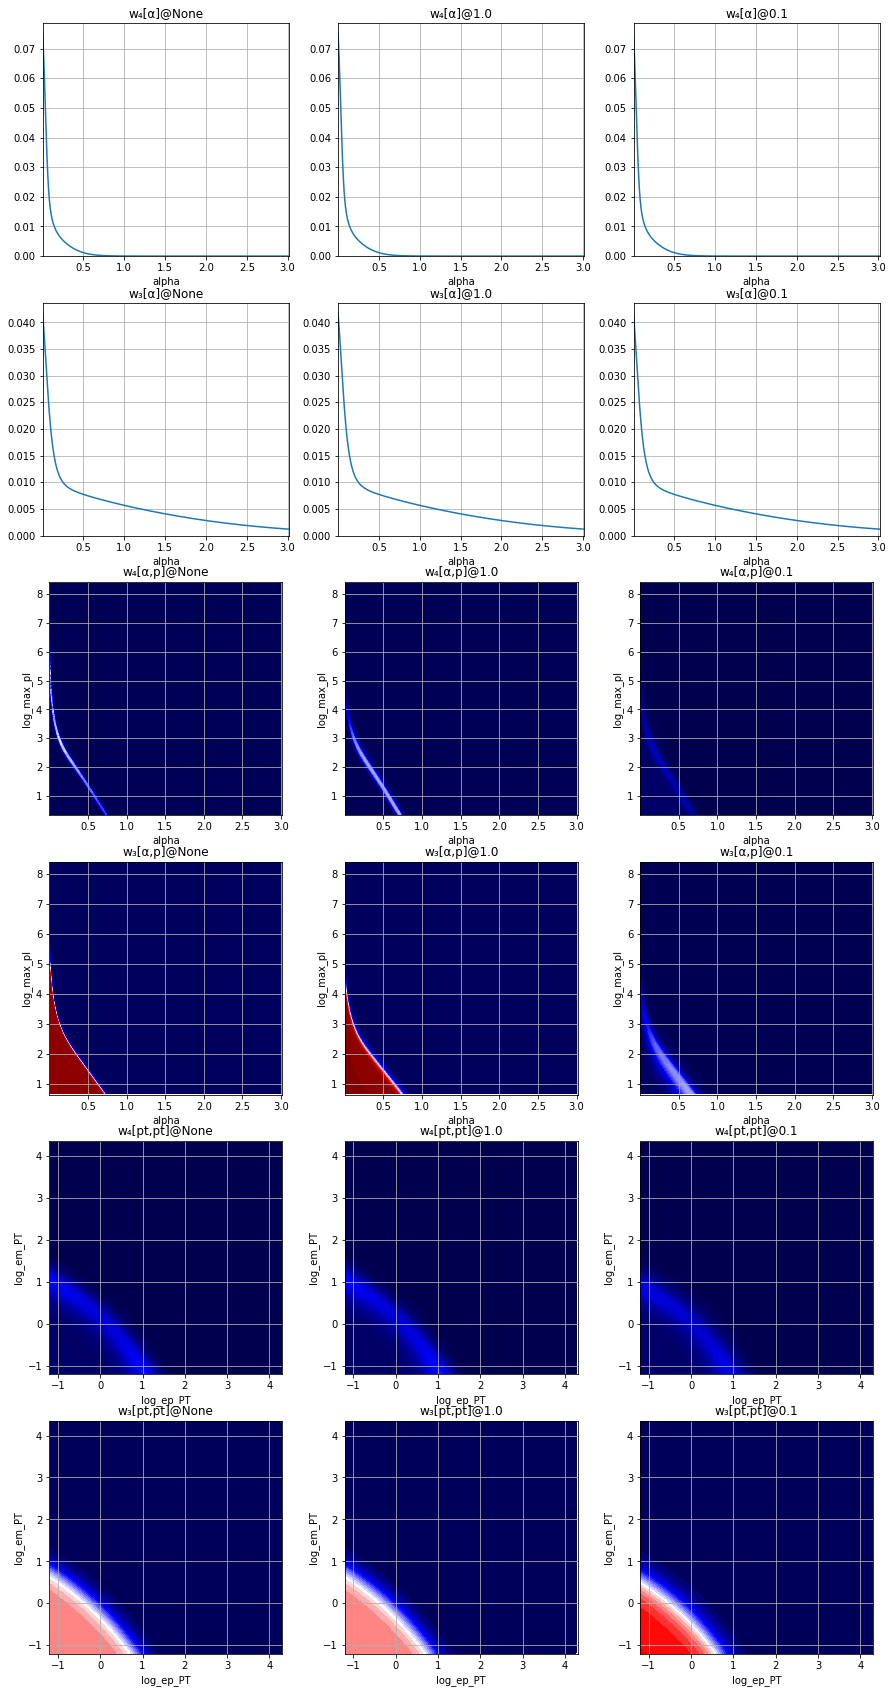

In [103]:
fig, ax = plt.subplots(6, 3, figsize=(15, 30))
for i, target_L in enumerate([None, 1.0, 0.1]):
    for j, ds in enumerate(all_datasets):
        w = results[target_L, ds.name]
        sc = w.model[0]
        w_np = as_numpy(lambda x : w.model(x))
        feat = len(sc.features)
        if feat == 2:
            plot_field(w_np, sc, name=w.name, ax=ax[j,i], color_bar=False)
        elif feat == 1:
            plot_one(w_np, sc, name=w.name, ax=ax[j,i], vmax=None)
plt.show()

In [104]:
def quality(datasets, estimators, refname, name):
    df_w = pd.DataFrame()
    for w in estimators:
        name1 = "1-%s" % w.name
        r_name = "R[%s]" % w.name
        df_w[name1] = None
        for s in datasets:
            ds = Dataset(w.model[0].features, [s], aliases, name)
            x = ds.X(device=device)
            wd = w.model(x)
            df_w.loc[s.name(),name1] = 1-torch.mean(wd).item()
        df_w[r_name] = df_w.loc[refname,name1] / df_w[name1]
    df_w.columns.name = name
    return df_w

In [108]:
quality(train_ds, results.values(), channel_names[1], "train").transpose()

B⁺→K⁺ee B⁺→K⁺J/ψ(→ee) B⁺→K⁺ψ(2S)(→ee) D⁺→π⁺φ(→ee)
train                                                                  
1-w₄[α]@None         0.972733      0.979999        0.981586    0.973801
R[w₄[α]@None]        1.007469           1.0        0.998384    1.006365
1-w₃[α]@None         0.976344          0.98         0.98088    0.976828
R[w₃[α]@None]        1.003744           1.0        0.999103    1.003247
1-w₄[α,p]@None        0.85455          0.98        0.988872        0.93
R[w₄[α,p]@None]      1.146802           1.0        0.991028    1.053763
1-w₃[α,p]@None       0.638329          0.98        0.987281     0.12923
R[w₃[α,p]@None]      1.535258           1.0        0.992625    7.583398
1-w₄[pt,pt]@None     0.945576          0.98        0.988602        0.93
R[w₄[pt,pt]@None]    1.036406           1.0        0.991299    1.053763
1-w₃[pt,pt]@None     0.907515          0.98         0.98668    0.593504
R[w₃[pt,pt]@None]    1.079872           1.0        0.993229     1.65121
1-w₄[α,pt,pt]@None   0.951155          0.98        0.984661        0.93
R[w₄[α,pt,pt]@None]  1.030327           1.0        0.995266    1.053763
1-w₃[α,pt,pt]@None   0.859413          0.98        0.987923    0.310479
R[w₃[α,pt,pt]@None]  1.140313           1.0         0.99198    3.156413
1-w₄[α]@1.0          0.972733      0.979999        0.981586    0.973801
R[w₄[α]@1.0]         1.007469           1.0        0.998384    1.006365
1-w₃[α]@1.0          0.976344          0.98         0.98088    0.976828
R[w₃[α]@1.0]         1.003744           1.0        0.999103    1.003247
1-w₄[α,p]@1.0        0.907793          0.98        0.988185        0.93
R[w₄[α,p]@1.0]       1.079541           1.0        0.991717    1.053763
1-w₃[α,p]@1.0         0.80582          0.98        0.987388    0.322054
R[w₃[α,p]@1.0]       1.216152           1.0        0.992518    3.042971
1-w₄[pt,pt]@1.0      0.945574          0.98          0.9886        0.93
R[w₄[pt,pt]@1.0]     1.036408           1.0          0.9913    1.053763
1-w₃[pt,pt]@1.0      0.907515          0.98         0.98668    0.593504
R[w₃[pt,pt]@1.0]     1.079872           1.0        0.993229     1.65121
1-w₄[α,pt,pt]@1.0    0.951155          0.98        0.984661        0.93
R[w₄[α,pt,pt]@1.0]   1.030327           1.0        0.995266    1.053763
1-w₃[α,pt,pt]@1.0    0.860253          0.98        0.987866    0.312497
R[w₃[α,pt,pt]@1.0]   1.139199           1.0        0.992037    3.136035
1-w₄[α]@0.1          0.972733      0.979999        0.981586    0.973801
R[w₄[α]@0.1]         1.007469           1.0        0.998384    1.006365
1-w₃[α]@0.1          0.976344          0.98         0.98088    0.976828
R[w₃[α]@0.1]         1.003744           1.0        0.999103    1.003247
1-w₄[α,p]@0.1        0.938543          0.98        0.987071        0.93
R[w₄[α,p]@0.1]       1.044171           1.0        0.992837    1.053763
1-w₃[α,p]@0.1        0.915645          0.98        0.984726    0.825263
R[w₃[α,p]@0.1]       1.070284           1.0          0.9952    1.187501
1-w₄[pt,pt]@0.1      0.950213          0.98        0.986186        0.93
R[w₄[pt,pt]@0.1]     1.031348           1.0        0.993727    1.053763
1-w₃[pt,pt]@0.1      0.919672          0.98        0.984545    0.585062
R[w₃[pt,pt]@0.1]     1.065597           1.0        0.995383    1.675035
1-w₄[α,pt,pt]@0.1    0.951046          0.98        0.984645        0.93
R[w₄[α,pt,pt]@0.1]   1.030444           1.0        0.995283    1.053763
1-w₃[α,pt,pt]@0.1    0.899587          0.98        0.986038    0.461491
R[w₃[α,pt,pt]@0.1]   1.089389           1.0        0.993877    2.123552

In [109]:
quality(test_ds, results.values(), channel_names[1], "test").transpose()

B⁺→K⁺ee B⁺→K⁺J/ψ(→ee) B⁺→K⁺ψ(2S)(→ee) D⁺→π⁺φ(→ee)
test                                                                   
1-w₄[α]@None         0.972623      0.979995        0.981706    0.973806
R[w₄[α]@None]         1.00758           1.0        0.998257    1.006356
1-w₃[α]@None         0.976306      0.979991        0.980945    0.976824
R[w₃[α]@None]        1.003774           1.0        0.999027    1.003242
1-w₄[α,p]@None       0.853582      0.979991         0.98889    0.929887
R[w₄[α,p]@None]      1.148091           1.0        0.991001    1.053881
1-w₃[α,p]@None       0.637617      0.980031         0.98729    0.128055
R[w₃[α,p]@None]      1.537022           1.0        0.992647    7.653197
1-w₄[pt,pt]@None     0.945468      0.980202        0.988578     0.93029
R[w₄[pt,pt]@None]    1.036737           1.0        0.991527    1.053652
1-w₃[pt,pt]@None     0.907255      0.979946         0.98672     0.59256
R[w₃[pt,pt]@None]    1.080122           1.0        0.993135    1.653749
1-w₄[α,pt,pt]@None   0.950321      0.980082        0.984825    0.929715
R[w₄[α,pt,pt]@None]  1.031317           1.0        0.995184    1.054175
1-w₃[α,pt,pt]@None   0.858039      0.980005         0.98797    0.308371
R[w₃[α,pt,pt]@None]  1.142145           1.0        0.991938    3.178003
1-w₄[α]@1.0          0.972623      0.979995        0.981706    0.973806
R[w₄[α]@1.0]          1.00758           1.0        0.998257    1.006356
1-w₃[α]@1.0          0.976306      0.979991        0.980945    0.976824
R[w₃[α]@1.0]         1.003774           1.0        0.999027    1.003242
1-w₄[α,p]@1.0        0.907887      0.979989        0.988172    0.929719
R[w₄[α,p]@1.0]       1.079417           1.0        0.991718    1.054069
1-w₃[α,p]@1.0        0.805034      0.979974        0.987376    0.321436
R[w₃[α,p]@1.0]       1.217308           1.0        0.992504    3.048737
1-w₄[pt,pt]@1.0      0.945466      0.980202        0.988577     0.93029
R[w₄[pt,pt]@1.0]     1.036739           1.0        0.991528    1.053652
1-w₃[pt,pt]@1.0      0.907255      0.979946         0.98672     0.59256
R[w₃[pt,pt]@1.0]     1.080122           1.0        0.993135    1.653749
1-w₄[α,pt,pt]@1.0    0.950321      0.980082        0.984825    0.929715
R[w₄[α,pt,pt]@1.0]   1.031317           1.0        0.995184    1.054175
1-w₃[α,pt,pt]@1.0    0.858879      0.980006        0.987915    0.310373
R[w₃[α,pt,pt]@1.0]   1.141029           1.0        0.991995    3.157514
1-w₄[α]@0.1          0.972623      0.979995        0.981706    0.973806
R[w₄[α]@0.1]          1.00758           1.0        0.998257    1.006356
1-w₃[α]@0.1          0.976306      0.979991        0.980945    0.976824
R[w₃[α]@0.1]         1.003774           1.0        0.999027    1.003242
1-w₄[α,p]@0.1        0.938594      0.979982        0.987055    0.929909
R[w₄[α,p]@0.1]       1.044095           1.0        0.992834    1.053847
1-w₃[α,p]@0.1        0.915434      0.979987        0.984719    0.824993
R[w₃[α,p]@0.1]       1.070516           1.0        0.995195    1.187874
1-w₄[pt,pt]@0.1      0.950119       0.98011        0.986178    0.930272
R[w₄[pt,pt]@0.1]     1.031565           1.0        0.993847    1.053574
1-w₃[pt,pt]@0.1      0.919421      0.979945         0.98459    0.583746
R[w₃[pt,pt]@0.1]     1.065828           1.0        0.995282    1.678716
1-w₄[α,pt,pt]@0.1    0.950225      0.980081        0.984807    0.929751
R[w₄[α,pt,pt]@0.1]   1.031421           1.0        0.995201    1.054133
1-w₃[α,pt,pt]@0.1    0.898574      0.980043        0.986135    0.459325
R[w₃[α,pt,pt]@0.1]   1.090664           1.0        0.993822     2.13366

In [110]:
quality(selected, results.values(), channel_names[1], "all").transpose()

B⁺→K⁺ee B⁺→K⁺J/ψ(→ee) B⁺→K⁺ψ(2S)(→ee) D⁺→π⁺φ(→ee)
all                                                                    
1-w₄[α]@None         0.972711      0.979998         0.98161    0.973802
R[w₄[α]@None]        1.007492           1.0        0.998358    1.006363
1-w₃[α]@None         0.976337      0.979998        0.980893    0.976828
R[w₃[α]@None]         1.00375           1.0        0.999088    1.003246
1-w₄[α,p]@None       0.854357      0.979998        0.988876    0.929977
R[w₄[α,p]@None]       1.14706           1.0        0.991022    1.053787
1-w₃[α,p]@None       0.638187      0.980006        0.987283    0.128995
R[w₃[α,p]@None]       1.53561           1.0         0.99263    7.597263
1-w₄[pt,pt]@None     0.945554       0.98004        0.988597    0.930058
R[w₄[pt,pt]@None]    1.036472           1.0        0.991345    1.053741
1-w₃[pt,pt]@None     0.907463      0.979989        0.986688    0.593315
R[w₃[pt,pt]@None]    1.079922           1.0         0.99321    1.651717
1-w₄[α,pt,pt]@None   0.950988      0.980016        0.984694    0.929943
R[w₄[α,pt,pt]@None]  1.030525           1.0         0.99525    1.053846
1-w₃[α,pt,pt]@None   0.859138      0.980001        0.987932    0.310057
R[w₃[α,pt,pt]@None]  1.140679           1.0        0.991972    3.160708
1-w₄[α]@1.0          0.972711      0.979998         0.98161    0.973802
R[w₄[α]@1.0]         1.007492           1.0        0.998358    1.006363
1-w₃[α]@1.0          0.976337      0.979998        0.980893    0.976828
R[w₃[α]@1.0]          1.00375           1.0        0.999088    1.003246
1-w₄[α,p]@1.0        0.907812      0.979998        0.988183    0.929944
R[w₄[α,p]@1.0]       1.079516           1.0        0.991717    1.053825
1-w₃[α,p]@1.0        0.805663      0.979995        0.987385     0.32193
R[w₃[α,p]@1.0]       1.216383           1.0        0.992515    3.044123
1-w₄[pt,pt]@1.0      0.945552       0.98004        0.988596    0.930058
R[w₄[pt,pt]@1.0]     1.036474           1.0        0.991346    1.053741
1-w₃[pt,pt]@1.0      0.907463      0.979989        0.986688    0.593315
R[w₃[pt,pt]@1.0]     1.079922           1.0         0.99321    1.651717
1-w₄[α,pt,pt]@1.0    0.950988      0.980016        0.984694    0.929943
R[w₄[α,pt,pt]@1.0]   1.030525           1.0         0.99525    1.053846
1-w₃[α,pt,pt]@1.0    0.859978      0.980001        0.987876    0.312072
R[w₃[α,pt,pt]@1.0]   1.139565           1.0        0.992028    3.140308
1-w₄[α]@0.1          0.972711      0.979998         0.98161    0.973802
R[w₄[α]@0.1]         1.007492           1.0        0.998358    1.006363
1-w₃[α]@0.1          0.976337      0.979998        0.980893    0.976828
R[w₃[α]@0.1]          1.00375           1.0        0.999088    1.003246
1-w₄[α,p]@0.1        0.938554      0.979996        0.987068    0.929982
R[w₄[α,p]@0.1]       1.044156           1.0        0.992836     1.05378
1-w₃[α,p]@0.1        0.915603      0.979997        0.984725    0.825209
R[w₃[α,p]@0.1]        1.07033           1.0        0.995199    1.187575
1-w₄[pt,pt]@0.1      0.950194      0.980022        0.986184    0.930054
R[w₄[pt,pt]@0.1]     1.031391           1.0        0.993751    1.053726
1-w₃[pt,pt]@0.1      0.919622      0.979989        0.984554    0.584799
R[w₃[pt,pt]@0.1]     1.065643           1.0        0.995363     1.67577
1-w₄[α,pt,pt]@0.1    0.950882      0.980016        0.984677     0.92995
R[w₄[α,pt,pt]@0.1]   1.030639           1.0        0.995267    1.053837
1-w₃[α,pt,pt]@0.1    0.899384      0.980009        0.986057    0.461058
R[w₃[α,pt,pt]@0.1]   1.089644           1.0        0.993866    2.125566

In [126]:
def map_all(name, fn):
    df = pd.DataFrame()
    df.columns.name = name
    for i, target_L in enumerate([None, 1.0, 0.1]):
        for j, ds in enumerate(all_datasets):
            w = results[target_L, ds.name]
            wname = "w%s"%ds.name
            df.loc[target_L, wname] = fn(w, ds)
    return df

In [127]:
def compute_L(w, ds, device=device):
    data = torch.utils.data.TensorDataset(ds.X().to(device), ds.Y().to(device))
    loader = Loader(data, batch_size=100000, shuffle=True, device=device)
    return compute_lipschitz(w.model, loader, device=device)

In [129]:
def compute_RK(w, ds, device=device):
    d = dict()
    for i, s in enumerate(train_ds[0:2]):
        ds = Dataset(w.model[0].features, [s], aliases, "tmp")
        x = ds.X(device=device)
        wd = w.model(x)
        d[i] = 1-torch.mean(wd).item()
    rk = d[1]/d[0]
    return rk

In [128]:
map_all("L", compute_L)

L       w₄[α]    w₃[α]   w₄[α,p]   w₃[α,p]  w₄[pt,pt]  w₃[pt,pt]  w₄[α,pt,pt]  \
NaN  0.083775  0.02393  9.268284  8.244829   0.715146   0.793923     0.517628   
1.0  0.083775  0.02393  2.988483  3.376159   0.715188   0.793923     0.517628   
0.1  0.083775  0.02393  0.494660  1.077864   0.521265   0.745657     0.516719   

L    w₃[α,pt,pt]  
NaN     1.768939  
1.0     1.760663  
0.1     1.181379

In [130]:
map_all("RK train", compute_RK)

RK train     w₄[α]     w₃[α]   w₄[α,p]   w₃[α,p]  w₄[pt,pt]  w₃[pt,pt]  \
NaN       1.007469  1.003744  1.146802  1.535258   1.036406   1.079872   
1.0       1.007469  1.003744  1.079541  1.216152   1.036408   1.079872   
0.1       1.007469  1.003744  1.044171  1.070284   1.031348   1.065597   

RK train  w₄[α,pt,pt]  w₃[α,pt,pt]  
NaN          1.030327     1.140313  
1.0          1.030327     1.139199  
0.1          1.030444     1.089389

### L

In [131]:
%%time
L_results = dict()
for target_L in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]:
    ds = all_datasets[5]
    est = all_est[5]
    name = "w%s@%s"%(ds.name, target_L)
    w = w_from_est(est, name=name)
    w.train(ds, target_L=target_L)
    L_results[target_L] = w

Epoch 0 loss=-3.000039 W+c=[ 5.493  -6.8348  2.3126] det=0.000018 L=0.049924
Epoch 1 loss=-3.000040 W+c=[ 5.5009 -6.7807  2.2849] det=0.000018 L=0.049918
Epoch 2 loss=-3.000037 W+c=[ 5.5087 -6.7282  2.2579] det=0.000018 L=0.049912
Epoch 3 loss=-3.000040 W+c=[ 5.5164 -6.6774  2.2317] det=0.000018 L=0.049908
Epoch 4 loss=-3.000040 W+c=[ 5.524  -6.6282  2.2063] det=0.000019 L=0.049904
Epoch 5 loss=-3.000041 W+c=[ 5.5315 -6.5806  2.1816] det=0.000019 L=0.049901
Epoch 6 loss=-3.000040 W+c=[ 5.5388 -6.5343  2.1576] det=0.000019 L=0.049897
Epoch 7 loss=-3.000040 W+c=[ 5.5461 -6.4895  2.1342] det=0.000019 L=0.049894
Epoch 8 loss=-3.000040 W+c=[ 5.5533 -6.446   2.1115] det=0.000019 L=0.049891
Epoch 9 loss=-3.000043 W+c=[ 5.5604 -6.4038  2.0894] det=0.000020 L=0.049887
Epoch 10 loss=-3.000043 W+c=[ 5.5674 -6.3629  2.068 ] det=0.000020 L=0.049884
Epoch 11 loss=-3.000042 W+c=[ 5.5742 -6.3231  2.0471] det=0.000020 L=0.049883
Epoch 12 loss=-3.000042 W+c=[ 5.581  -6.2845  2.0267] det=0.000020 L=0.049

Epoch 106 loss=-3.000049 W+c=[ 5.7878 -4.8646  1.3098] det=0.000032 L=0.051064
Epoch 107 loss=-3.000050 W+c=[ 5.787  -4.8592  1.3079] det=0.000032 L=0.051086
Epoch 108 loss=-3.000049 W+c=[ 5.7861 -4.8539  1.306 ] det=0.000032 L=0.051108
Epoch 109 loss=-3.000050 W+c=[ 5.7852 -4.8487  1.3042] det=0.000032 L=0.051130
Epoch 110 loss=-3.000048 W+c=[ 5.7843 -4.8436  1.3024] det=0.000032 L=0.051153
Epoch 111 loss=-3.000046 W+c=[ 5.7833 -4.8385  1.3007] det=0.000032 L=0.051175
Epoch 112 loss=-3.000049 W+c=[ 5.7823 -4.8335  1.299 ] det=0.000033 L=0.051198
Epoch 113 loss=-3.000049 W+c=[ 5.7813 -4.8285  1.2973] det=0.000033 L=0.051221
Epoch 114 loss=-3.000049 W+c=[ 5.7802 -4.8237  1.2957] det=0.000033 L=0.051243
Epoch 115 loss=-3.000048 W+c=[ 5.7791 -4.8188  1.2941] det=0.000033 L=0.051267
Epoch 116 loss=-3.000048 W+c=[ 5.778  -4.8141  1.2926] det=0.000033 L=0.051290
Epoch 117 loss=-3.000049 W+c=[ 5.7769 -4.8094  1.2911] det=0.000033 L=0.051313
Epoch 118 loss=-3.000048 W+c=[ 5.7758 -4.8048  1.289

Epoch 7 loss=-33.687683 W+c=[ 8.3355 -2.839  -0.031 ] det=0.000033 L=0.065383
Epoch 8 loss=-15.488142 W+c=[ 5.8958 -3.3981  1.3511] det=0.000047 L=0.067103
Epoch 9 loss=-13.535330 W+c=[ 6.8017 -2.9603  0.8211] det=0.000042 L=0.069966
Epoch 10 loss=-12.180436 W+c=[ 7.6527 -2.7222  0.4456] det=0.000037 L=0.071869
Epoch 11 loss=-11.277598 W+c=[ 8.414  -2.5809  0.164 ] det=0.000032 L=0.073203
Epoch 12 loss=-21.627846 W+c=[ 9.0673 -2.4908 -0.0508] det=0.000029 L=0.074191
Epoch 13 loss=-13.220394 W+c=[ 6.5728 -2.8382  1.0724] det=0.000044 L=0.075364
Epoch 14 loss=-11.912515 W+c=[ 7.4951 -2.5805  0.6557] det=0.000038 L=0.077867
Epoch 15 loss=-10.950232 W+c=[ 8.3323 -2.4331  0.3491] det=0.000033 L=0.079564
Epoch 16 loss=-10.295760 W+c=[ 9.0646 -2.3421  0.1147] det=0.000029 L=0.080775
Epoch 17 loss=-16.815634 W+c=[ 9.6823 -2.2822 -0.0653] det=0.000026 L=0.081671
Epoch 18 loss=-11.927313 W+c=[ 7.114  -2.5275  0.9285] det=0.000040 L=0.082752
Epoch 19 loss=-10.799457 W+c=[ 8.0503 -2.3485  0.5716] 

Epoch 112 loss=-4.471045 W+c=[16.5372 -1.4088  0.2836] det=0.000010 L=0.186936
Epoch 113 loss=-4.772098 W+c=[19.1604 -1.4184  0.0125] det=0.000008 L=0.185274
Epoch 114 loss=-5.313108 W+c=[20.7002 -1.4276 -0.1395] det=0.000006 L=0.183958
Epoch 115 loss=-4.418938 W+c=[16.818  -1.4024  0.2788] det=0.000010 L=0.189411
Epoch 116 loss=-4.730886 W+c=[19.5001 -1.4133  0.0087] det=0.000007 L=0.187645
Epoch 117 loss=-5.288786 W+c=[21.049  -1.4229 -0.1406] det=0.000006 L=0.186218
Epoch 118 loss=-4.369597 W+c=[17.0936 -1.3964  0.2747] det=0.000009 L=0.191783
Epoch 119 loss=-4.691868 W+c=[19.8335 -1.4085  0.0055] det=0.000007 L=0.189919
Epoch 120 loss=-5.266633 W+c=[21.3923 -1.4185 -0.1412] det=0.000006 L=0.188426
Epoch 121 loss=-4.323168 W+c=[17.3657 -1.3909  0.271 ] det=0.000009 L=0.194114
Epoch 122 loss=-4.655193 W+c=[20.1635 -1.404   0.0028] det=0.000007 L=0.192098
Epoch 123 loss=-5.246765 W+c=[21.7315 -1.4144 -0.1413] det=0.000006 L=0.190582
Epoch 124 loss=-4.279106 W+c=[17.633  -1.3856  0.267

Epoch 216 loss=-4.090507 W+c=[28.8079 -1.3477  0.0688] det=0.000004 L=0.248517
Epoch 217 loss=-5.084150 W+c=[30.4554 -1.3616 -0.0143] det=0.000004 L=0.245593
Epoch 218 loss=-3.526767 W+c=[24.2283 -1.3103  0.3157] det=0.000006 L=0.257095
Epoch 219 loss=-4.082114 W+c=[29.0367 -1.3472  0.0728] det=0.000004 L=0.249979
Epoch 220 loss=-5.087696 W+c=[30.6822 -1.3612 -0.0088] det=0.000004 L=0.246946
Epoch 221 loss=-3.512452 W+c=[24.3867 -1.3093  0.3192] det=0.000006 L=0.258711
Epoch 222 loss=-4.074047 W+c=[29.2639 -1.3469  0.0769] det=0.000004 L=0.251410
Epoch 223 loss=-5.091304 W+c=[30.9058 -1.3608 -0.0033] det=0.000004 L=0.248317
Epoch 224 loss=-3.498458 W+c=[24.5433 -1.3084  0.3228] det=0.000006 L=0.260331
Epoch 225 loss=-4.066395 W+c=[29.4898 -1.3465  0.081 ] det=0.000004 L=0.252810
Epoch 226 loss=-4.174226 W+c=[31.1266 -1.3604  0.0023] det=0.000004 L=0.249666
Epoch 227 loss=-5.208623 W+c=[31.7751 -1.3661 -0.029 ] det=0.000003 L=0.248684
Epoch 228 loss=-3.494512 W+c=[24.7768 -1.3081  0.320

Epoch 320 loss=-4.077503 W+c=[35.357  -1.3755  0.0167] det=0.000004 L=0.271724
Epoch 321 loss=-4.087147 W+c=[35.5617 -1.3775  0.0091] det=0.000004 L=0.271322
Epoch 322 loss=-4.090544 W+c=[35.6407 -1.3784  0.0058] det=0.000004 L=0.271179
Epoch 323 loss=-4.091812 W+c=[35.6731 -1.379   0.004 ] det=0.000004 L=0.271135
Epoch 324 loss=-4.092149 W+c=[35.6874 -1.3794  0.0028] det=0.000004 L=0.271130
Epoch 325 loss=-4.092256 W+c=[35.6959 -1.3798  0.0018] det=0.000004 L=0.271138
Epoch 326 loss=-4.092207 W+c=[35.7015 -1.3802  0.0009] det=0.000004 L=0.271152
Epoch 327 loss=-4.092176 W+c=[35.707  -1.3805  0.    ] det=0.000004 L=0.271166
Epoch 328 loss=-6.627082 W+c=[35.7119 -1.3809 -0.0008] det=0.000004 L=0.271182
Epoch 329 loss=-2.743376 W+c=[24.6335 -1.2933  0.3861] det=0.000007 L=0.293211
Epoch 330 loss=-3.943425 W+c=[33.4716 -1.3591  0.0885] det=0.000004 L=0.278173
Epoch 331 loss=-4.041387 W+c=[35.1039 -1.3728  0.0345] det=0.000004 L=0.274662
Epoch 332 loss=-4.068921 W+c=[35.6499 -1.3776  0.016

Epoch 424 loss=-0.949155 W+c=[20.9369 -1.2754  0.464 ] det=0.000012 L=0.313650
Epoch 425 loss=-4.005219 W+c=[37.3698 -1.3901  0.0226] det=0.000004 L=0.287040
Epoch 426 loss=-4.020898 W+c=[37.6954 -1.3931  0.0137] det=0.000004 L=0.286310
Epoch 427 loss=-4.025911 W+c=[37.8016 -1.3943  0.0105] det=0.000004 L=0.286060
Epoch 428 loss=-4.027838 W+c=[37.8383 -1.395   0.009 ] det=0.000004 L=0.285965
Epoch 429 loss=-4.028460 W+c=[37.849  -1.3954  0.0083] det=0.000004 L=0.285931
Epoch 430 loss=-4.028863 W+c=[37.8534 -1.3957  0.0077] det=0.000004 L=0.285910
Epoch 431 loss=-4.029058 W+c=[37.8543 -1.3961  0.0071] det=0.000004 L=0.285898
Epoch 432 loss=-4.029244 W+c=[37.8539 -1.3964  0.0067] det=0.000004 L=0.285889
Epoch 433 loss=-4.029380 W+c=[37.8537 -1.3967  0.0062] det=0.000004 L=0.285880
Epoch 434 loss=-4.029505 W+c=[37.8528 -1.397   0.0057] det=0.000004 L=0.285873
Epoch 435 loss=-4.029739 W+c=[37.8533 -1.3974  0.0052] det=0.000004 L=0.285863
Epoch 436 loss=-4.029901 W+c=[37.8529 -1.3977  0.004

Epoch 26 loss=-3.000047 W+c=[ 5.6636 -5.8431  1.7922] det=0.000023 L=0.049908
Epoch 27 loss=-3.000046 W+c=[ 5.6687 -5.8174  1.7785] det=0.000023 L=0.049913
Epoch 28 loss=-3.000047 W+c=[ 5.6736 -5.7923  1.7652] det=0.000023 L=0.049918
Epoch 29 loss=-3.000046 W+c=[ 5.6784 -5.7679  1.7521] det=0.000023 L=0.049923
Epoch 30 loss=-3.000047 W+c=[ 5.6831 -5.7441  1.7394] det=0.000023 L=0.049930
Epoch 31 loss=-3.000048 W+c=[ 5.6877 -5.7209  1.727 ] det=0.000023 L=0.049937
Epoch 32 loss=-3.000047 W+c=[ 5.6922 -5.6983  1.715 ] det=0.000023 L=0.049944
Epoch 33 loss=-3.000047 W+c=[ 5.6966 -5.6762  1.7032] det=0.000024 L=0.049952
Epoch 34 loss=-3.000048 W+c=[ 5.7008 -5.6546  1.6917] det=0.000024 L=0.049959
Epoch 35 loss=-3.000048 W+c=[ 5.705  -5.6335  1.6805] det=0.000024 L=0.049967
Epoch 36 loss=-3.000045 W+c=[ 5.709  -5.6129  1.6696] det=0.000024 L=0.049975
Epoch 37 loss=-3.000047 W+c=[ 5.713  -5.5929  1.6589] det=0.000024 L=0.049982
Epoch 38 loss=-3.000047 W+c=[ 5.7168 -5.5733  1.6485] det=0.0000

Epoch 131 loss=-3.000050 W+c=[ 5.7588 -4.7497  1.2732] det=0.000034 L=0.051650
Epoch 132 loss=-3.000048 W+c=[ 5.7574 -4.7458  1.2722] det=0.000035 L=0.051675
Epoch 133 loss=-3.000049 W+c=[ 5.7559 -4.7419  1.2711] det=0.000035 L=0.051700
Epoch 134 loss=-3.000050 W+c=[ 5.7545 -4.7381  1.2701] det=0.000035 L=0.051725
Epoch 135 loss=-3.000048 W+c=[ 5.753  -4.7343  1.2691] det=0.000035 L=0.051751
Epoch 136 loss=-3.000048 W+c=[ 5.7515 -4.7306  1.2681] det=0.000035 L=0.051776
Epoch 137 loss=-3.000050 W+c=[ 5.75   -4.7269  1.2671] det=0.000035 L=0.051802
Epoch 138 loss=-3.000049 W+c=[ 5.7484 -4.7232  1.2662] det=0.000035 L=0.051827
Epoch 139 loss=-3.000050 W+c=[ 5.7469 -4.7196  1.2653] det=0.000035 L=0.051853
Epoch 140 loss=-3.000049 W+c=[ 5.7453 -4.716   1.2644] det=0.000035 L=0.051879
Epoch 141 loss=-3.000049 W+c=[ 5.7438 -4.7125  1.2635] det=0.000035 L=0.051904
Epoch 142 loss=-3.000050 W+c=[ 5.7422 -4.709   1.2626] det=0.000036 L=0.051930
Epoch 143 loss=-3.000048 W+c=[ 5.7406 -4.7055  1.261

Epoch 32 loss=-10.175783 W+c=[ 9.5225 -1.9685  0.2216] det=0.000026 L=0.100073
Epoch 33 loss=-10.015793 W+c=[ 9.7036 -1.946   0.18  ] det=0.000026 L=0.101187
Epoch 34 loss=-9.886134 W+c=[ 9.851  -1.9264  0.1483] det=0.000025 L=0.102282
Epoch 35 loss=-9.779186 W+c=[ 9.9713 -1.9089  0.1244] det=0.000025 L=0.103309
Epoch 36 loss=-9.689363 W+c=[10.0699 -1.8929  0.1066] det=0.000024 L=0.104313
Epoch 37 loss=-9.612527 W+c=[10.1514 -1.878   0.0933] det=0.000024 L=0.105311
Epoch 38 loss=-9.545603 W+c=[10.2192 -1.8641  0.0837] det=0.000024 L=0.106292
Epoch 39 loss=-9.486224 W+c=[10.2764 -1.851   0.0769] det=0.000023 L=0.107281
Epoch 40 loss=-9.432645 W+c=[10.3252 -1.8384  0.0722] det=0.000023 L=0.108260
Epoch 41 loss=-9.383487 W+c=[10.3677 -1.8263  0.0691] det=0.000023 L=0.109230
Epoch 42 loss=-9.337768 W+c=[10.405  -1.8147  0.0673] det=0.000023 L=0.110195
Epoch 43 loss=-9.294643 W+c=[10.4386 -1.8033  0.0663] det=0.000023 L=0.111156
Epoch 44 loss=-9.253613 W+c=[10.4692 -1.7923  0.0661] det=0.00

Epoch 137 loss=-6.480660 W+c=[12.6715 -1.2394  0.1556] det=0.000018 L=0.205012
Epoch 138 loss=-6.409476 W+c=[13.0415 -1.2325  0.1068] det=0.000017 L=0.206301
Epoch 139 loss=-6.351851 W+c=[13.3447 -1.227   0.068 ] det=0.000017 L=0.207437
Epoch 140 loss=-6.304211 W+c=[13.5933 -1.2225  0.0371] det=0.000016 L=0.208384
Epoch 141 loss=-6.264037 W+c=[13.7976 -1.2185  0.0125] det=0.000016 L=0.209350
Epoch 142 loss=-6.322491 W+c=[13.9666 -1.2151 -0.0072] det=0.000015 L=0.210239
Epoch 143 loss=-6.527053 W+c=[11.4231 -1.2427  0.368 ] det=0.000022 L=0.209529
Epoch 144 loss=-6.395896 W+c=[12.1152 -1.2271  0.2716] det=0.000020 L=0.211751
Epoch 145 loss=-6.297471 W+c=[12.6956 -1.2162  0.1943] det=0.000018 L=0.213398
Epoch 146 loss=-6.221628 W+c=[13.1743 -1.2084  0.1329] det=0.000017 L=0.214903
Epoch 147 loss=-6.161731 W+c=[13.5651 -1.2025  0.0843] det=0.000016 L=0.216029
Epoch 148 loss=-6.113337 W+c=[13.8824 -1.1978  0.0459] det=0.000016 L=0.217112
Epoch 149 loss=-6.073252 W+c=[14.14   -1.194   0.015

Epoch 241 loss=-5.053884 W+c=[19.5857 -1.0362 -0.0156] det=0.000009 L=0.311694
Epoch 242 loss=-4.383249 W+c=[16.4593 -1.0354  0.2249] det=0.000013 L=0.313041
Epoch 243 loss=-4.482618 W+c=[17.9783 -1.0325  0.1144] det=0.000011 L=0.314253
Epoch 244 loss=-4.537613 W+c=[19.0892 -1.0324  0.0363] det=0.000010 L=0.314955
Epoch 245 loss=-5.049171 W+c=[19.8777 -1.033  -0.0179] det=0.000009 L=0.315380
Epoch 246 loss=-4.337150 W+c=[16.6868 -1.0314  0.2215] det=0.000013 L=0.316832
Epoch 247 loss=-4.443665 W+c=[18.2419 -1.029   0.111 ] det=0.000011 L=0.318160
Epoch 248 loss=-4.502270 W+c=[19.3707 -1.0292  0.0335] det=0.000010 L=0.318739
Epoch 249 loss=-5.046691 W+c=[20.1659 -1.03   -0.0199] det=0.000009 L=0.318914
Epoch 250 loss=-4.293201 W+c=[16.9092 -1.0277  0.2184] det=0.000013 L=0.320505
Epoch 251 loss=-4.406704 W+c=[18.5009 -1.0257  0.108 ] det=0.000011 L=0.321911
Epoch 252 loss=-4.468831 W+c=[19.6474 -1.0262  0.0312] det=0.000010 L=0.322409
Epoch 253 loss=-5.046197 W+c=[20.4497 -1.0272 -0.021

Epoch 345 loss=-5.358270 W+c=[26.0676 -0.9988 -0.0041] det=0.000007 L=0.391758
Epoch 346 loss=-3.604840 W+c=[20.9923 -0.9832  0.2185] det=0.000010 L=0.396009
Epoch 347 loss=-3.878928 W+c=[23.6678 -0.989   0.1053] det=0.000008 L=0.396068
Epoch 348 loss=-4.001038 W+c=[25.3053 -0.9946  0.0379] det=0.000007 L=0.395062
Epoch 349 loss=-5.379544 W+c=[26.2787 -0.9984 -0.0017] det=0.000007 L=0.394306
Epoch 350 loss=-3.584514 W+c=[21.1178 -0.9824  0.2204] det=0.000010 L=0.398696
Epoch 351 loss=-3.865926 W+c=[23.8481 -0.9885  0.1069] det=0.000008 L=0.398677
Epoch 352 loss=-3.990019 W+c=[25.5078 -0.9942  0.0399] det=0.000007 L=0.397722
Epoch 353 loss=-4.050099 W+c=[26.4878 -0.9982  0.0007] det=0.000007 L=0.396823
Epoch 354 loss=-5.510030 W+c=[27.0617 -1.0007 -0.0223] det=0.000006 L=0.396262
Epoch 355 loss=-3.581869 W+c=[21.3877 -0.9821  0.2152] det=0.000010 L=0.401522
Epoch 356 loss=-3.860474 W+c=[24.1204 -0.9886  0.1041] det=0.000008 L=0.401354
Epoch 357 loss=-3.982622 W+c=[25.7671 -0.9944  0.038

Epoch 449 loss=-6.797727 W+c=[30.8645 -1.0128 -0.0006] det=0.000006 L=0.433935
Epoch 450 loss=-3.123091 W+c=[21.9173 -0.9801  0.2654] det=0.000012 L=0.442885
Epoch 451 loss=-3.650622 W+c=[26.2045 -0.9916  0.1398] det=0.000008 L=0.442479
Epoch 452 loss=-3.835098 W+c=[28.5295 -1.0009  0.0741] det=0.000007 L=0.439895
Epoch 453 loss=-3.911906 W+c=[29.7524 -1.0065  0.0399] det=0.000006 L=0.438731
Epoch 454 loss=-3.947756 W+c=[30.3942 -1.0098  0.0218] det=0.000006 L=0.437680
Epoch 455 loss=-3.965764 W+c=[30.7306 -1.0117  0.0121] det=0.000006 L=0.436984
Epoch 456 loss=-3.975262 W+c=[30.906  -1.013   0.0068] det=0.000006 L=0.436547
Epoch 457 loss=-3.980425 W+c=[30.9958 -1.0138  0.0039] det=0.000006 L=0.436270
Epoch 458 loss=-3.983405 W+c=[31.0403 -1.0144  0.0022] det=0.000006 L=0.436081
Epoch 459 loss=-3.985223 W+c=[31.061  -1.0149  0.0011] det=0.000006 L=0.435940
Epoch 460 loss=-3.986445 W+c=[31.069  -1.0154  0.0004] det=0.000006 L=0.435825
Epoch 461 loss=-7.077576 W+c=[31.0704 -1.0158 -0.000

Epoch 51 loss=-3.000048 W+c=[ 5.7573 -5.3553  1.5345] det=0.000026 L=0.050112
Epoch 52 loss=-3.000047 W+c=[ 5.7598 -5.341   1.5271] det=0.000026 L=0.050123
Epoch 53 loss=-3.000047 W+c=[ 5.7621 -5.327   1.5199] det=0.000026 L=0.050134
Epoch 54 loss=-3.000047 W+c=[ 5.7644 -5.3133  1.5129] det=0.000026 L=0.050145
Epoch 55 loss=-3.000047 W+c=[ 5.7665 -5.2999  1.5061] det=0.000026 L=0.050157
Epoch 56 loss=-3.000047 W+c=[ 5.7686 -5.2867  1.4995] det=0.000027 L=0.050170
Epoch 57 loss=-3.000046 W+c=[ 5.7706 -5.2738  1.493 ] det=0.000027 L=0.050183
Epoch 58 loss=-3.000047 W+c=[ 5.7725 -5.2612  1.4866] det=0.000027 L=0.050197
Epoch 59 loss=-3.000046 W+c=[ 5.7744 -5.2488  1.4804] det=0.000027 L=0.050211
Epoch 60 loss=-3.000049 W+c=[ 5.7761 -5.2367  1.4744] det=0.000027 L=0.050225
Epoch 61 loss=-3.000048 W+c=[ 5.7778 -5.2249  1.4685] det=0.000027 L=0.050239
Epoch 62 loss=-3.000047 W+c=[ 5.7794 -5.2132  1.4627] det=0.000027 L=0.050253
Epoch 63 loss=-3.000048 W+c=[ 5.7809 -5.2018  1.4571] det=0.0000

Epoch 156 loss=-3.000049 W+c=[ 5.719  -4.6634  1.2521] det=0.000037 L=0.052306
Epoch 157 loss=-3.000050 W+c=[ 5.7172 -4.6603  1.2515] det=0.000037 L=0.052334
Epoch 158 loss=-3.000050 W+c=[ 5.7155 -4.6573  1.2508] det=0.000037 L=0.052362
Epoch 159 loss=-3.000050 W+c=[ 5.7138 -4.6543  1.2502] det=0.000037 L=0.052390
Epoch 160 loss=-3.000049 W+c=[ 5.712  -4.6513  1.2496] det=0.000037 L=0.052418
Epoch 161 loss=-3.000049 W+c=[ 5.7103 -4.6484  1.249 ] det=0.000037 L=0.052446
Epoch 162 loss=-3.000050 W+c=[ 5.7085 -4.6455  1.2484] det=0.000038 L=0.052474
Epoch 163 loss=-3.000049 W+c=[ 5.7068 -4.6426  1.2478] det=0.000038 L=0.052502
Epoch 164 loss=-3.000050 W+c=[ 5.705  -4.6397  1.2472] det=0.000038 L=0.052531
Epoch 165 loss=-3.000051 W+c=[ 5.7032 -4.6369  1.2466] det=0.000038 L=0.052559
Epoch 166 loss=-3.000050 W+c=[ 5.7015 -4.634   1.2461] det=0.000038 L=0.052588
Epoch 167 loss=-3.000051 W+c=[ 5.6997 -4.6312  1.2455] det=0.000038 L=0.052616
Epoch 168 loss=-3.000048 W+c=[ 5.6979 -4.6284  1.245

Epoch 58 loss=-9.424345 W+c=[10.0774 -1.6822  0.1737] det=0.000025 L=0.124204
Epoch 59 loss=-9.401007 W+c=[10.084  -1.6729  0.1786] det=0.000025 L=0.125256
Epoch 60 loss=-9.377608 W+c=[10.0909 -1.6638  0.1833] det=0.000025 L=0.126309
Epoch 61 loss=-9.354097 W+c=[10.098  -1.6548  0.188 ] det=0.000025 L=0.127364
Epoch 62 loss=-9.330515 W+c=[10.1054 -1.6459  0.1925] det=0.000025 L=0.128422
Epoch 63 loss=-9.306856 W+c=[10.1131 -1.6371  0.1969] det=0.000025 L=0.129481
Epoch 64 loss=-9.283117 W+c=[10.121  -1.6284  0.2011] det=0.000025 L=0.130542
Epoch 65 loss=-9.259295 W+c=[10.1292 -1.6198  0.2053] det=0.000025 L=0.131604
Epoch 66 loss=-9.235389 W+c=[10.1377 -1.6114  0.2093] det=0.000025 L=0.132668
Epoch 67 loss=-9.211370 W+c=[10.1464 -1.603   0.2132] det=0.000025 L=0.133734
Epoch 68 loss=-9.187290 W+c=[10.1554 -1.5947  0.217 ] det=0.000025 L=0.134801
Epoch 69 loss=-9.163139 W+c=[10.1647 -1.5866  0.2207] det=0.000025 L=0.135869
Epoch 70 loss=-9.138872 W+c=[10.1743 -1.5785  0.2242] det=0.0000

Epoch 163 loss=-6.854002 W+c=[12.2306 -1.1229  0.198 ] det=0.000020 L=0.239086
Epoch 164 loss=-6.832931 W+c=[12.2628 -1.1201  0.1956] det=0.000020 L=0.240124
Epoch 165 loss=-6.811987 W+c=[12.2952 -1.1174  0.1931] det=0.000020 L=0.241156
Epoch 166 loss=-6.791174 W+c=[12.3277 -1.1147  0.1907] det=0.000020 L=0.242181
Epoch 167 loss=-6.770508 W+c=[12.3603 -1.112   0.1882] det=0.000020 L=0.243200
Epoch 168 loss=-6.749997 W+c=[12.393  -1.1094  0.1857] det=0.000020 L=0.244213
Epoch 169 loss=-6.729604 W+c=[12.4258 -1.1068  0.1832] det=0.000020 L=0.245219
Epoch 170 loss=-6.709350 W+c=[12.4587 -1.1042  0.1807] det=0.000020 L=0.246219
Epoch 171 loss=-6.689232 W+c=[12.4918 -1.1016  0.1781] det=0.000020 L=0.247213
Epoch 172 loss=-6.669260 W+c=[12.5249 -1.0991  0.1756] det=0.000020 L=0.248199
Epoch 173 loss=-6.649426 W+c=[12.5582 -1.0966  0.1731] det=0.000020 L=0.249196
Epoch 174 loss=-6.629733 W+c=[12.5915 -1.0941  0.1705] det=0.000020 L=0.250210
Epoch 175 loss=-6.610146 W+c=[12.625  -1.0917  0.167

Epoch 267 loss=-6.002550 W+c=[15.7282 -0.9448 -0.0031] det=0.000016 L=0.336137
Epoch 268 loss=-5.385748 W+c=[13.0834 -0.9642  0.2334] det=0.000023 L=0.332725
Epoch 269 loss=-5.334934 W+c=[13.7395 -0.9556  0.1775] det=0.000021 L=0.335900
Epoch 270 loss=-5.296364 W+c=[14.2928 -0.9495  0.1319] det=0.000019 L=0.338337
Epoch 271 loss=-5.266117 W+c=[14.7524 -0.9451  0.095 ] det=0.000018 L=0.340101
Epoch 272 loss=-5.241817 W+c=[15.1303 -0.9417  0.0653] det=0.000018 L=0.341564
Epoch 273 loss=-5.221792 W+c=[15.4393 -0.9392  0.0414] det=0.000017 L=0.342800
Epoch 274 loss=-5.204904 W+c=[15.6909 -0.9372  0.0224] det=0.000016 L=0.343791
Epoch 275 loss=-5.190405 W+c=[15.8961 -0.9355  0.0071] det=0.000016 L=0.344707
Epoch 276 loss=-5.952319 W+c=[16.0638 -0.9341 -0.0052] det=0.000016 L=0.345769
Epoch 277 loss=-5.242658 W+c=[13.3684 -0.9521  0.2249] det=0.000022 L=0.342225
Epoch 278 loss=-5.201209 W+c=[14.0698 -0.9438  0.1679] det=0.000020 L=0.345542
Epoch 279 loss=-5.170074 W+c=[14.6586 -0.938   0.121

Epoch 371 loss=-4.194689 W+c=[17.876  -0.8627  0.1134] det=0.000015 L=0.444158
Epoch 372 loss=-4.244180 W+c=[18.9242 -0.8603  0.0614] det=0.000014 L=0.446967
Epoch 373 loss=-4.276702 W+c=[19.7216 -0.8594  0.0226] det=0.000013 L=0.448507
Epoch 374 loss=-5.732693 W+c=[20.3161 -0.8591 -0.0058] det=0.000012 L=0.449267
Epoch 375 loss=-4.077735 W+c=[16.7341 -0.8648  0.1805] det=0.000017 L=0.445763
Epoch 376 loss=-4.158516 W+c=[18.1075 -0.86    0.1117] det=0.000015 L=0.449580
Epoch 377 loss=-4.211868 W+c=[19.1802 -0.8579  0.0597] det=0.000013 L=0.451978
Epoch 378 loss=-4.246695 W+c=[19.9916 -0.8571  0.0213] det=0.000012 L=0.453620
Epoch 379 loss=-5.745731 W+c=[20.5932 -0.8569 -0.0069] det=0.000012 L=0.454176
Epoch 380 loss=-4.036788 W+c=[16.9223 -0.8621  0.1793] det=0.000017 L=0.450805
Epoch 381 loss=-4.124065 W+c=[18.3347 -0.8575  0.1103] det=0.000015 L=0.454887
Epoch 382 loss=-4.181236 W+c=[19.4325 -0.8556  0.0583] det=0.000013 L=0.457211
Epoch 383 loss=-4.218382 W+c=[20.2581 -0.8549  0.020

Epoch 475 loss=-3.820108 W+c=[23.3704 -0.8353  0.0611] det=0.000011 L=0.536983
Epoch 476 loss=-3.889455 W+c=[24.48   -0.8369  0.0264] det=0.000010 L=0.537520
Epoch 477 loss=-3.930790 W+c=[25.2209 -0.8385  0.0034] det=0.000009 L=0.537599
Epoch 478 loss=-6.514310 W+c=[25.7081 -0.8397 -0.0117] det=0.000009 L=0.537635
Epoch 479 loss=-3.460999 W+c=[19.5595 -0.8351  0.1894] det=0.000015 L=0.533670
Epoch 480 loss=-3.681385 W+c=[21.8781 -0.8338  0.1146] det=0.000012 L=0.538517
Epoch 481 loss=-3.805708 W+c=[23.5402 -0.8351  0.0628] det=0.000011 L=0.540919
Epoch 482 loss=-3.877167 W+c=[24.6744 -0.8368  0.0281] det=0.000010 L=0.541425
Epoch 483 loss=-3.919503 W+c=[25.4283 -0.8384  0.0052] det=0.000009 L=0.541529
Epoch 484 loss=-6.586351 W+c=[25.9212 -0.8397 -0.0098] det=0.000009 L=0.541575
Epoch 485 loss=-3.432165 W+c=[19.6147 -0.8347  0.1921] det=0.000016 L=0.537341
Epoch 486 loss=-3.662749 W+c=[22.0018 -0.8334  0.1166] det=0.000012 L=0.542309
Epoch 487 loss=-3.791725 W+c=[23.7077 -0.8349  0.064

Epoch 78 loss=-3.000046 W+c=[ 5.7949 -5.0547  1.3876] det=0.000029 L=0.050507
Epoch 79 loss=-3.000048 W+c=[ 5.7953 -5.0463  1.3838] det=0.000029 L=0.050524
Epoch 80 loss=-3.000046 W+c=[ 5.7956 -5.038   1.3801] det=0.000029 L=0.050542
Epoch 81 loss=-3.000048 W+c=[ 5.796  -5.0298  1.3765] det=0.000029 L=0.050560
Epoch 82 loss=-3.000047 W+c=[ 5.7962 -5.0218  1.373 ] det=0.000029 L=0.050578
Epoch 83 loss=-3.000048 W+c=[ 5.7964 -5.014   1.3696] det=0.000030 L=0.050596
Epoch 84 loss=-3.000048 W+c=[ 5.7965 -5.0063  1.3662] det=0.000030 L=0.050614
Epoch 85 loss=-3.000048 W+c=[ 5.7966 -4.9987  1.3629] det=0.000030 L=0.050633
Epoch 86 loss=-3.000048 W+c=[ 5.7966 -4.9912  1.3597] det=0.000030 L=0.050652
Epoch 87 loss=-3.000047 W+c=[ 5.7966 -4.9839  1.3566] det=0.000030 L=0.050672
Epoch 88 loss=-3.000049 W+c=[ 5.7965 -4.9766  1.3536] det=0.000030 L=0.050691
Epoch 89 loss=-3.000046 W+c=[ 5.7964 -4.9695  1.3506] det=0.000030 L=0.050710
Epoch 90 loss=-3.000048 W+c=[ 5.7962 -4.9626  1.3477] det=0.0000

Epoch 182 loss=-3.000051 W+c=[ 5.6726 -4.5914  1.238 ] det=0.000040 L=0.053057
Epoch 183 loss=-3.000050 W+c=[ 5.6708 -4.5889  1.2375] det=0.000040 L=0.053087
Epoch 184 loss=-3.000052 W+c=[ 5.669  -4.5864  1.2371] det=0.000040 L=0.053117
Epoch 185 loss=-3.000051 W+c=[ 5.6671 -4.5839  1.2366] det=0.000040 L=0.053147
Epoch 186 loss=-3.000050 W+c=[ 5.6653 -4.5814  1.2362] det=0.000040 L=0.053177
Epoch 187 loss=-3.000050 W+c=[ 5.6635 -4.579   1.2357] det=0.000040 L=0.053207
Epoch 188 loss=-3.000051 W+c=[ 5.6617 -4.5765  1.2353] det=0.000040 L=0.053238
Epoch 189 loss=-3.000050 W+c=[ 5.6598 -4.5741  1.2348] det=0.000040 L=0.053268
Epoch 190 loss=-3.000051 W+c=[ 5.658  -4.5717  1.2344] det=0.000040 L=0.053299
Epoch 191 loss=-3.000051 W+c=[ 5.6562 -4.5693  1.234 ] det=0.000040 L=0.053330
Epoch 192 loss=-3.000051 W+c=[ 5.6543 -4.5669  1.2336] det=0.000041 L=0.053360
Epoch 193 loss=-3.000052 W+c=[ 5.6525 -4.5645  1.2331] det=0.000041 L=0.053391
Epoch 194 loss=-3.000051 W+c=[ 5.6507 -4.5622  1.232

Epoch 84 loss=-9.137691 W+c=[ 9.9432 -1.4725  0.3606] det=0.000026 L=0.153970
Epoch 85 loss=-9.118373 W+c=[ 9.9485 -1.4657  0.3643] det=0.000026 L=0.155125
Epoch 86 loss=-9.098977 W+c=[ 9.9541 -1.459   0.3678] det=0.000026 L=0.156282
Epoch 87 loss=-9.079544 W+c=[ 9.9598 -1.4523  0.3713] det=0.000026 L=0.157440
Epoch 88 loss=-9.060046 W+c=[ 9.9657 -1.4457  0.3747] det=0.000026 L=0.158600
Epoch 89 loss=-9.040504 W+c=[ 9.9718 -1.4392  0.378 ] det=0.000026 L=0.159762
Epoch 90 loss=-9.020881 W+c=[ 9.9782 -1.4327  0.3812] det=0.000026 L=0.160926
Epoch 91 loss=-9.001206 W+c=[ 9.9847 -1.4263  0.3843] det=0.000026 L=0.162091
Epoch 92 loss=-8.981476 W+c=[ 9.9914 -1.42    0.3873] det=0.000026 L=0.163258
Epoch 93 loss=-8.961699 W+c=[ 9.9984 -1.4138  0.3902] det=0.000026 L=0.164426
Epoch 94 loss=-8.941858 W+c=[10.0055 -1.4076  0.3931] det=0.000026 L=0.165596
Epoch 95 loss=-8.921964 W+c=[10.0128 -1.4015  0.3958] det=0.000026 L=0.166767
Epoch 96 loss=-8.902018 W+c=[10.0203 -1.3955  0.3985] det=0.0000

Epoch 188 loss=-7.001797 W+c=[11.5708 -1.035   0.3748] det=0.000023 L=0.279839
Epoch 189 loss=-6.982810 W+c=[11.5958 -1.0326  0.3728] det=0.000023 L=0.281026
Epoch 190 loss=-6.963901 W+c=[11.6209 -1.0302  0.3707] det=0.000023 L=0.282207
Epoch 191 loss=-6.945075 W+c=[11.6462 -1.0279  0.3686] det=0.000023 L=0.283384
Epoch 192 loss=-6.926332 W+c=[11.6716 -1.0255  0.3665] det=0.000023 L=0.284555
Epoch 193 loss=-6.907686 W+c=[11.6971 -1.0232  0.3643] det=0.000023 L=0.285721
Epoch 194 loss=-6.889139 W+c=[11.7227 -1.0209  0.3622] det=0.000023 L=0.286882
Epoch 195 loss=-6.870648 W+c=[11.7484 -1.0186  0.36  ] det=0.000023 L=0.288044
Epoch 196 loss=-6.852271 W+c=[11.7743 -1.0163  0.3578] det=0.000023 L=0.289202
Epoch 197 loss=-6.833963 W+c=[11.8002 -1.0141  0.3557] det=0.000023 L=0.290354
Epoch 198 loss=-6.815753 W+c=[11.8263 -1.0119  0.3535] det=0.000022 L=0.291500
Epoch 199 loss=-6.797606 W+c=[11.8525 -1.0097  0.3512] det=0.000022 L=0.292646
Epoch 200 loss=-6.779597 W+c=[11.8788 -1.0075  0.349

Epoch 292 loss=-5.527487 W+c=[14.5117 -0.8756  0.1435] det=0.000019 L=0.387581
Epoch 293 loss=-5.517923 W+c=[14.5404 -0.8748  0.1416] det=0.000019 L=0.388421
Epoch 294 loss=-5.508456 W+c=[14.5691 -0.8739  0.1397] det=0.000019 L=0.389260
Epoch 295 loss=-5.499027 W+c=[14.5977 -0.873   0.1378] det=0.000019 L=0.390128
Epoch 296 loss=-5.489693 W+c=[14.6262 -0.8722  0.1359] det=0.000019 L=0.390992
Epoch 297 loss=-5.480433 W+c=[14.6547 -0.8713  0.134 ] det=0.000019 L=0.391850
Epoch 298 loss=-5.471241 W+c=[14.6832 -0.8705  0.1321] det=0.000019 L=0.392702
Epoch 299 loss=-5.462102 W+c=[14.7117 -0.8696  0.1302] det=0.000019 L=0.393548
Epoch 300 loss=-5.453041 W+c=[14.7401 -0.8688  0.1284] det=0.000019 L=0.394388
Epoch 301 loss=-5.444064 W+c=[14.7685 -0.868   0.1265] det=0.000019 L=0.395221
Epoch 302 loss=-5.435143 W+c=[14.7967 -0.8672  0.1247] det=0.000019 L=0.396049
Epoch 303 loss=-5.426295 W+c=[14.8251 -0.8664  0.1229] det=0.000019 L=0.396872
Epoch 304 loss=-5.417508 W+c=[14.8533 -0.8656  0.121

Epoch 396 loss=-4.820994 W+c=[16.2536 -0.8187  0.0583] det=0.000020 L=0.463644
Epoch 397 loss=-4.811555 W+c=[16.5148 -0.8171  0.0446] det=0.000020 L=0.465296
Epoch 398 loss=-4.803447 W+c=[16.7287 -0.8158  0.0336] det=0.000019 L=0.466550
Epoch 399 loss=-4.796341 W+c=[16.904  -0.8147  0.0246] det=0.000019 L=0.467543
Epoch 400 loss=-4.789980 W+c=[17.0479 -0.8139  0.0174] det=0.000019 L=0.468489
Epoch 401 loss=-4.784193 W+c=[17.1664 -0.8132  0.0114] det=0.000019 L=0.469314
Epoch 402 loss=-4.778866 W+c=[17.2648 -0.8126  0.0066] det=0.000018 L=0.470043
Epoch 403 loss=-4.773858 W+c=[17.3468 -0.8121  0.0026] det=0.000018 L=0.470707
Epoch 404 loss=-6.834750 W+c=[17.4161 -0.8116 -0.0008] det=0.000018 L=0.471400
Epoch 405 loss=-4.789816 W+c=[14.122  -0.8309  0.1847] det=0.000027 L=0.461622
Epoch 406 loss=-4.766704 W+c=[14.8295 -0.8238  0.146 ] det=0.000025 L=0.466198
Epoch 407 loss=-4.750218 W+c=[15.4324 -0.8187  0.114 ] det=0.000023 L=0.469708
Epoch 408 loss=-4.737849 W+c=[15.9375 -0.8151  0.087

W= [[0.0789 0.0253 0.0218]
 [0.6734 0.6497 0.5697]
 [0.2477 0.325  0.4085]]
W+= [[ 19.064   -0.77     0.0562]
 [-31.8357   6.3766  -7.1928]
 [ 13.7716  -4.6067   8.1366]]
L= 0.5666098594665527
coef= [[0.7911 0.     0.    ]]
Epoch 0 loss=-3.000039 W+c=[ 5.493  -6.8348  2.3126] det=0.000018 L=0.049924
Epoch 1 loss=-3.000040 W+c=[ 5.5009 -6.7807  2.2849] det=0.000018 L=0.049918
Epoch 2 loss=-3.000037 W+c=[ 5.5087 -6.7282  2.2579] det=0.000018 L=0.049912
Epoch 3 loss=-3.000040 W+c=[ 5.5164 -6.6774  2.2317] det=0.000018 L=0.049908
Epoch 4 loss=-3.000040 W+c=[ 5.524  -6.6282  2.2063] det=0.000019 L=0.049904
Epoch 5 loss=-3.000041 W+c=[ 5.5315 -6.5806  2.1816] det=0.000019 L=0.049901
Epoch 6 loss=-3.000040 W+c=[ 5.5388 -6.5343  2.1576] det=0.000019 L=0.049897
Epoch 7 loss=-3.000040 W+c=[ 5.5461 -6.4895  2.1342] det=0.000019 L=0.049894
Epoch 8 loss=-3.000040 W+c=[ 5.5533 -6.446   2.1115] det=0.000019 L=0.049891
Epoch 9 loss=-3.000043 W+c=[ 5.5604 -6.4038  2.0894] det=0.000020 L=0.049887
Epoch 

Epoch 103 loss=-3.000049 W+c=[ 5.7901 -4.8812  1.3159] det=0.000032 L=0.050999
Epoch 104 loss=-3.000047 W+c=[ 5.7894 -4.8756  1.3138] det=0.000032 L=0.051020
Epoch 105 loss=-3.000048 W+c=[ 5.7886 -4.8701  1.3118] det=0.000032 L=0.051042
Epoch 106 loss=-3.000049 W+c=[ 5.7878 -4.8646  1.3098] det=0.000032 L=0.051064
Epoch 107 loss=-3.000050 W+c=[ 5.787  -4.8592  1.3079] det=0.000032 L=0.051086
Epoch 108 loss=-3.000049 W+c=[ 5.7861 -4.8539  1.306 ] det=0.000032 L=0.051108
Epoch 109 loss=-3.000050 W+c=[ 5.7852 -4.8487  1.3042] det=0.000032 L=0.051130
Epoch 110 loss=-3.000048 W+c=[ 5.7843 -4.8436  1.3024] det=0.000032 L=0.051153
Epoch 111 loss=-3.000046 W+c=[ 5.7833 -4.8385  1.3007] det=0.000032 L=0.051175
Epoch 112 loss=-3.000049 W+c=[ 5.7823 -4.8335  1.299 ] det=0.000033 L=0.051198
Epoch 113 loss=-3.000049 W+c=[ 5.7813 -4.8285  1.2973] det=0.000033 L=0.051221
Epoch 114 loss=-3.000049 W+c=[ 5.7802 -4.8237  1.2957] det=0.000033 L=0.051243
Epoch 115 loss=-3.000048 W+c=[ 5.7791 -4.8188  1.294

Epoch 4 loss=-17.407038 W+c=[ 5.8008 -3.812   1.2681] det=0.000045 L=0.060579
Epoch 5 loss=-15.384788 W+c=[ 6.5599 -3.3239  0.7756] det=0.000042 L=0.062935
Epoch 6 loss=-13.954412 W+c=[ 7.238  -3.0511  0.438 ] det=0.000039 L=0.064618
Epoch 7 loss=-12.980836 W+c=[ 7.822  -2.8827  0.1925] det=0.000035 L=0.065899
Epoch 8 loss=-12.297100 W+c=[ 8.3104 -2.7701  0.0099] det=0.000033 L=0.066975
Epoch 9 loss=-29.339727 W+c=[ 8.7105 -2.6896 -0.1269] det=0.000031 L=0.067898
Epoch 10 loss=-16.360888 W+c=[ 6.0135 -3.2306  1.2757] det=0.000047 L=0.069235
Epoch 11 loss=-14.718043 W+c=[ 6.7172 -2.8966  0.8771] det=0.000043 L=0.071868
Epoch 12 loss=-13.508704 W+c=[ 7.3326 -2.6997  0.5991] det=0.000039 L=0.073841
Epoch 13 loss=-12.671131 W+c=[ 7.8574 -2.5729  0.3948] det=0.000036 L=0.075363
Epoch 14 loss=-12.073668 W+c=[ 8.2944 -2.4854  0.242 ] det=0.000033 L=0.076658
Epoch 15 loss=-11.637053 W+c=[ 8.6521 -2.4213  0.1272] det=0.000031 L=0.077793
Epoch 16 loss=-11.311537 W+c=[ 8.941  -2.3718  0.0409] det

Epoch 109 loss=-8.884247 W+c=[ 9.855  -1.3219  0.4905] det=0.000027 L=0.184842
Epoch 110 loss=-8.867570 W+c=[ 9.8599 -1.3166  0.4931] det=0.000027 L=0.186082
Epoch 111 loss=-8.850851 W+c=[ 9.865  -1.3114  0.4956] det=0.000027 L=0.187322
Epoch 112 loss=-8.834101 W+c=[ 9.8702 -1.3063  0.498 ] det=0.000027 L=0.188565
Epoch 113 loss=-8.817308 W+c=[ 9.8755 -1.3012  0.5004] det=0.000027 L=0.189809
Epoch 114 loss=-8.800463 W+c=[ 9.881  -1.2961  0.5027] det=0.000027 L=0.191055
Epoch 115 loss=-8.783585 W+c=[ 9.8867 -1.2911  0.5049] det=0.000027 L=0.192301
Epoch 116 loss=-8.766670 W+c=[ 9.8925 -1.2862  0.507 ] det=0.000027 L=0.193550
Epoch 117 loss=-8.749703 W+c=[ 9.8985 -1.2813  0.5091] det=0.000027 L=0.194799
Epoch 118 loss=-8.732714 W+c=[ 9.9047 -1.2764  0.5111] det=0.000027 L=0.196055
Epoch 119 loss=-8.715685 W+c=[ 9.9109 -1.2716  0.5131] det=0.000027 L=0.197323
Epoch 120 loss=-8.698612 W+c=[ 9.9174 -1.2669  0.515 ] det=0.000027 L=0.198592
Epoch 121 loss=-8.681508 W+c=[ 9.924  -1.2622  0.516

Epoch 213 loss=-7.047642 W+c=[11.2007 -0.9685  0.4758] det=0.000025 L=0.319731
Epoch 214 loss=-7.030787 W+c=[11.2211 -0.9664  0.4739] det=0.000025 L=0.321003
Epoch 215 loss=-7.013988 W+c=[11.2417 -0.9644  0.4719] det=0.000025 L=0.322279
Epoch 216 loss=-6.997246 W+c=[11.2624 -0.9623  0.47  ] det=0.000025 L=0.323555
Epoch 217 loss=-6.980562 W+c=[11.2831 -0.9603  0.4681] det=0.000025 L=0.324827
Epoch 218 loss=-6.963925 W+c=[11.304  -0.9582  0.4661] det=0.000025 L=0.326094
Epoch 219 loss=-6.947358 W+c=[11.325  -0.9562  0.4642] det=0.000025 L=0.327357
Epoch 220 loss=-6.930832 W+c=[11.3461 -0.9542  0.4622] det=0.000025 L=0.328615
Epoch 221 loss=-6.914374 W+c=[11.3673 -0.9523  0.4602] det=0.000025 L=0.329868
Epoch 222 loss=-6.897967 W+c=[11.3887 -0.9503  0.4582] det=0.000025 L=0.331116
Epoch 223 loss=-6.881632 W+c=[11.4101 -0.9484  0.4562] det=0.000025 L=0.332377
Epoch 224 loss=-6.865329 W+c=[11.4316 -0.9465  0.4541] det=0.000025 L=0.333657
Epoch 225 loss=-6.849135 W+c=[11.4532 -0.9446  0.452

Epoch 317 loss=-5.660407 W+c=[13.6871 -0.8237  0.2572] det=0.000022 L=0.439860
Epoch 318 loss=-5.650805 W+c=[13.7122 -0.8229  0.2553] det=0.000022 L=0.440860
Epoch 319 loss=-5.641255 W+c=[13.7373 -0.822   0.2534] det=0.000022 L=0.441854
Epoch 320 loss=-5.631758 W+c=[13.7624 -0.8212  0.2515] det=0.000022 L=0.442841
Epoch 321 loss=-5.622344 W+c=[13.7875 -0.8204  0.2496] det=0.000022 L=0.443822
Epoch 322 loss=-5.612994 W+c=[13.8125 -0.8195  0.2477] det=0.000022 L=0.444797
Epoch 323 loss=-5.603704 W+c=[13.8375 -0.8187  0.2458] det=0.000022 L=0.445764
Epoch 324 loss=-5.594476 W+c=[13.8625 -0.8179  0.244 ] det=0.000022 L=0.446727
Epoch 325 loss=-5.585319 W+c=[13.8875 -0.8171  0.2421] det=0.000022 L=0.447682
Epoch 326 loss=-5.576197 W+c=[13.9125 -0.8163  0.2403] det=0.000022 L=0.448632
Epoch 327 loss=-5.567153 W+c=[13.9375 -0.8155  0.2384] det=0.000022 L=0.449606
Epoch 328 loss=-5.558174 W+c=[13.9624 -0.8147  0.2366] det=0.000022 L=0.450577
Epoch 329 loss=-5.549246 W+c=[13.9874 -0.814   0.234

Epoch 421 loss=-4.942545 W+c=[16.1222 -0.7653  0.102 ] det=0.000021 L=0.526806
Epoch 422 loss=-4.937804 W+c=[16.1433 -0.7649  0.1009] det=0.000021 L=0.527543
Epoch 423 loss=-4.933110 W+c=[16.1643 -0.7646  0.0998] det=0.000021 L=0.528276
Epoch 424 loss=-4.928457 W+c=[16.1852 -0.7643  0.0988] det=0.000021 L=0.529004
Epoch 425 loss=-4.923815 W+c=[16.2061 -0.7639  0.0977] det=0.000021 L=0.529727
Epoch 426 loss=-4.919221 W+c=[16.2269 -0.7636  0.0966] det=0.000021 L=0.530447
Epoch 427 loss=-4.914662 W+c=[16.2477 -0.7633  0.0956] det=0.000021 L=0.531163
Epoch 428 loss=-4.910117 W+c=[16.2685 -0.763   0.0945] det=0.000021 L=0.531874
Epoch 429 loss=-4.905603 W+c=[16.2891 -0.7626  0.0935] det=0.000021 L=0.532581
Epoch 430 loss=-4.901119 W+c=[16.3098 -0.7623  0.0925] det=0.000021 L=0.533284
Epoch 431 loss=-4.896672 W+c=[16.3304 -0.762   0.0914] det=0.000021 L=0.533983
Epoch 432 loss=-4.892265 W+c=[16.3509 -0.7617  0.0904] det=0.000021 L=0.534678
Epoch 433 loss=-4.887867 W+c=[16.3714 -0.7614  0.089

Epoch 23 loss=-3.000047 W+c=[ 5.6478 -5.9242  1.8355] det=0.000022 L=0.049899
Epoch 24 loss=-3.000045 W+c=[ 5.6532 -5.8964  1.8207] det=0.000022 L=0.049901
Epoch 25 loss=-3.000045 W+c=[ 5.6585 -5.8694  1.8063] det=0.000022 L=0.049904
Epoch 26 loss=-3.000047 W+c=[ 5.6636 -5.8431  1.7922] det=0.000023 L=0.049908
Epoch 27 loss=-3.000046 W+c=[ 5.6687 -5.8174  1.7785] det=0.000023 L=0.049913
Epoch 28 loss=-3.000047 W+c=[ 5.6736 -5.7923  1.7652] det=0.000023 L=0.049918
Epoch 29 loss=-3.000046 W+c=[ 5.6784 -5.7679  1.7521] det=0.000023 L=0.049923
Epoch 30 loss=-3.000047 W+c=[ 5.6831 -5.7441  1.7394] det=0.000023 L=0.049930
Epoch 31 loss=-3.000048 W+c=[ 5.6877 -5.7209  1.727 ] det=0.000023 L=0.049937
Epoch 32 loss=-3.000047 W+c=[ 5.6922 -5.6983  1.715 ] det=0.000023 L=0.049944
Epoch 33 loss=-3.000047 W+c=[ 5.6966 -5.6762  1.7032] det=0.000024 L=0.049952
Epoch 34 loss=-3.000048 W+c=[ 5.7008 -5.6546  1.6917] det=0.000024 L=0.049959
Epoch 35 loss=-3.000048 W+c=[ 5.705  -5.6335  1.6805] det=0.0000

Epoch 128 loss=-3.000049 W+c=[ 5.763  -4.7616  1.2766] det=0.000034 L=0.051576
Epoch 129 loss=-3.000049 W+c=[ 5.7616 -4.7576  1.2754] det=0.000034 L=0.051601
Epoch 130 loss=-3.000049 W+c=[ 5.7602 -4.7536  1.2743] det=0.000034 L=0.051626
Epoch 131 loss=-3.000050 W+c=[ 5.7588 -4.7497  1.2732] det=0.000034 L=0.051650
Epoch 132 loss=-3.000048 W+c=[ 5.7574 -4.7458  1.2722] det=0.000035 L=0.051675
Epoch 133 loss=-3.000049 W+c=[ 5.7559 -4.7419  1.2711] det=0.000035 L=0.051700
Epoch 134 loss=-3.000050 W+c=[ 5.7545 -4.7381  1.2701] det=0.000035 L=0.051725
Epoch 135 loss=-3.000048 W+c=[ 5.753  -4.7343  1.2691] det=0.000035 L=0.051751
Epoch 136 loss=-3.000048 W+c=[ 5.7515 -4.7306  1.2681] det=0.000035 L=0.051776
Epoch 137 loss=-3.000050 W+c=[ 5.75   -4.7269  1.2671] det=0.000035 L=0.051802
Epoch 138 loss=-3.000049 W+c=[ 5.7484 -4.7232  1.2662] det=0.000035 L=0.051827
Epoch 139 loss=-3.000050 W+c=[ 5.7469 -4.7196  1.2653] det=0.000035 L=0.051853
Epoch 140 loss=-3.000049 W+c=[ 5.7453 -4.716   1.264

Epoch 29 loss=-10.362709 W+c=[ 9.624  -2.0296  0.0764] det=0.000026 L=0.095018
Epoch 30 loss=-10.299291 W+c=[ 9.6782 -2.0121  0.07  ] det=0.000026 L=0.096030
Epoch 31 loss=-10.246369 W+c=[ 9.72   -1.9957  0.0672] det=0.000026 L=0.097052
Epoch 32 loss=-10.201578 W+c=[ 9.7521 -1.9801  0.067 ] det=0.000026 L=0.098071
Epoch 33 loss=-10.163167 W+c=[ 9.7763 -1.9652  0.069 ] det=0.000026 L=0.099085
Epoch 34 loss=-10.129727 W+c=[ 9.7944 -1.9509  0.0726] det=0.000026 L=0.100095
Epoch 35 loss=-10.100228 W+c=[ 9.8076 -1.937   0.0774] det=0.000026 L=0.101103
Epoch 36 loss=-10.073819 W+c=[ 9.817  -1.9235  0.0832] det=0.000026 L=0.102112
Epoch 37 loss=-10.049856 W+c=[ 9.8233 -1.9104  0.0898] det=0.000026 L=0.103122
Epoch 38 loss=-10.027837 W+c=[ 9.8273 -1.8976  0.0969] det=0.000026 L=0.104134
Epoch 39 loss=-10.007387 W+c=[ 9.8293 -1.8851  0.1044] det=0.000026 L=0.105148
Epoch 40 loss=-9.988173 W+c=[ 9.8299 -1.8729  0.1122] det=0.000026 L=0.106166
Epoch 41 loss=-9.969953 W+c=[ 9.8293 -1.8608  0.1202]

Epoch 134 loss=-8.652670 W+c=[ 9.7962 -1.2051  0.5833] det=0.000028 L=0.217611
Epoch 135 loss=-8.637930 W+c=[ 9.801 -1.201  0.585] det=0.000028 L=0.218921
Epoch 136 loss=-8.623156 W+c=[ 9.8059 -1.1968  0.5866] det=0.000028 L=0.220232
Epoch 137 loss=-8.608365 W+c=[ 9.811  -1.1928  0.5881] det=0.000028 L=0.221548
Epoch 138 loss=-8.593527 W+c=[ 9.8162 -1.1887  0.5896] det=0.000028 L=0.222878
Epoch 139 loss=-8.578676 W+c=[ 9.8215 -1.1847  0.591 ] det=0.000028 L=0.224209
Epoch 140 loss=-8.563786 W+c=[ 9.8269 -1.1808  0.5924] det=0.000028 L=0.225542
Epoch 141 loss=-8.548865 W+c=[ 9.8325 -1.1769  0.5937] det=0.000028 L=0.226876
Epoch 142 loss=-8.533913 W+c=[ 9.8382 -1.173   0.5949] det=0.000028 L=0.228211
Epoch 143 loss=-8.518941 W+c=[ 9.844  -1.1691  0.5961] det=0.000028 L=0.229548
Epoch 144 loss=-8.503930 W+c=[ 9.85   -1.1653  0.5973] det=0.000028 L=0.230885
Epoch 145 loss=-8.488906 W+c=[ 9.8561 -1.1615  0.5984] det=0.000028 L=0.232224
Epoch 146 loss=-8.473846 W+c=[ 9.8623 -1.1577  0.5994] 

Epoch 238 loss=-7.041812 W+c=[10.9713 -0.9149  0.5356] det=0.000027 L=0.359529
Epoch 239 loss=-7.026814 W+c=[10.9887 -0.9131  0.5338] det=0.000027 L=0.360896
Epoch 240 loss=-7.011862 W+c=[11.0062 -0.9113  0.5319] det=0.000027 L=0.362259
Epoch 241 loss=-6.996950 W+c=[11.0238 -0.9096  0.5301] det=0.000027 L=0.363619
Epoch 242 loss=-6.982056 W+c=[11.0415 -0.9078  0.5282] det=0.000027 L=0.364975
Epoch 243 loss=-6.967220 W+c=[11.0593 -0.906   0.5264] det=0.000027 L=0.366327
Epoch 244 loss=-6.952411 W+c=[11.0772 -0.9043  0.5245] det=0.000027 L=0.367676
Epoch 245 loss=-6.937656 W+c=[11.0952 -0.9026  0.5226] det=0.000027 L=0.369020
Epoch 246 loss=-6.922941 W+c=[11.1132 -0.9009  0.5207] det=0.000027 L=0.370360
Epoch 247 loss=-6.908248 W+c=[11.1314 -0.8992  0.5188] det=0.000027 L=0.371695
Epoch 248 loss=-6.893617 W+c=[11.1496 -0.8975  0.5169] det=0.000027 L=0.373027
Epoch 249 loss=-6.879020 W+c=[11.168  -0.8958  0.5149] det=0.000027 L=0.374354
Epoch 250 loss=-6.864459 W+c=[11.1864 -0.8941  0.513

Epoch 342 loss=-5.755529 W+c=[13.1214 -0.7846  0.3275] det=0.000025 L=0.488843
Epoch 343 loss=-5.746133 W+c=[13.1436 -0.7838  0.3257] det=0.000025 L=0.489928
Epoch 344 loss=-5.736810 W+c=[13.1659 -0.783   0.3238] det=0.000025 L=0.491007
Epoch 345 loss=-5.727535 W+c=[13.1881 -0.7822  0.322 ] det=0.000025 L=0.492080
Epoch 346 loss=-5.718309 W+c=[13.2103 -0.7814  0.3201] det=0.000025 L=0.493146
Epoch 347 loss=-5.709165 W+c=[13.2325 -0.7806  0.3183] det=0.000025 L=0.494206
Epoch 348 loss=-5.700040 W+c=[13.2547 -0.7799  0.3165] det=0.000025 L=0.495259
Epoch 349 loss=-5.690991 W+c=[13.2769 -0.7791  0.3147] det=0.000025 L=0.496306
Epoch 350 loss=-5.681974 W+c=[13.2991 -0.7783  0.3128] det=0.000025 L=0.497354
Epoch 351 loss=-5.673027 W+c=[13.3213 -0.7776  0.311 ] det=0.000025 L=0.498465
Epoch 352 loss=-5.664138 W+c=[13.3435 -0.7768  0.3092] det=0.000025 L=0.499570
Epoch 353 loss=-5.655292 W+c=[13.3656 -0.776   0.3075] det=0.000025 L=0.500669
Epoch 354 loss=-5.646508 W+c=[13.3878 -0.7753  0.305

Epoch 446 loss=-5.032817 W+c=[15.3241 -0.7272  0.1724] det=0.000024 L=0.586718
Epoch 447 loss=-5.027914 W+c=[15.3435 -0.7269  0.1713] det=0.000024 L=0.587505
Epoch 448 loss=-5.023034 W+c=[15.3629 -0.7265  0.1702] det=0.000024 L=0.588288
Epoch 449 loss=-5.018184 W+c=[15.3822 -0.7262  0.1691] det=0.000024 L=0.589066
Epoch 450 loss=-5.013377 W+c=[15.4015 -0.7259  0.168 ] det=0.000024 L=0.589840
Epoch 451 loss=-5.008590 W+c=[15.4208 -0.7255  0.1669] det=0.000024 L=0.590609
Epoch 452 loss=-5.003829 W+c=[15.4401 -0.7252  0.1658] det=0.000024 L=0.591374
Epoch 453 loss=-4.999116 W+c=[15.4592 -0.7248  0.1647] det=0.000024 L=0.592133
Epoch 454 loss=-4.994423 W+c=[15.4783 -0.7245  0.1636] det=0.000024 L=0.592889
Epoch 455 loss=-4.989753 W+c=[15.4974 -0.7242  0.1625] det=0.000024 L=0.593639
Epoch 456 loss=-4.985126 W+c=[15.5165 -0.7239  0.1615] det=0.000024 L=0.594386
Epoch 457 loss=-4.980515 W+c=[15.5355 -0.7235  0.1604] det=0.000024 L=0.595127
Epoch 458 loss=-4.975944 W+c=[15.5544 -0.7232  0.159

Epoch 48 loss=-3.000045 W+c=[ 5.7494 -5.4002  1.5576] det=0.000026 L=0.050081
Epoch 49 loss=-3.000047 W+c=[ 5.7522 -5.3849  1.5497] det=0.000026 L=0.050091
Epoch 50 loss=-3.000047 W+c=[ 5.7548 -5.37    1.542 ] det=0.000026 L=0.050102
Epoch 51 loss=-3.000048 W+c=[ 5.7573 -5.3553  1.5345] det=0.000026 L=0.050112
Epoch 52 loss=-3.000047 W+c=[ 5.7598 -5.341   1.5271] det=0.000026 L=0.050123
Epoch 53 loss=-3.000047 W+c=[ 5.7621 -5.327   1.5199] det=0.000026 L=0.050134
Epoch 54 loss=-3.000047 W+c=[ 5.7644 -5.3133  1.5129] det=0.000026 L=0.050145
Epoch 55 loss=-3.000047 W+c=[ 5.7665 -5.2999  1.5061] det=0.000026 L=0.050157
Epoch 56 loss=-3.000047 W+c=[ 5.7686 -5.2867  1.4995] det=0.000027 L=0.050170
Epoch 57 loss=-3.000046 W+c=[ 5.7706 -5.2738  1.493 ] det=0.000027 L=0.050183
Epoch 58 loss=-3.000047 W+c=[ 5.7725 -5.2612  1.4866] det=0.000027 L=0.050197
Epoch 59 loss=-3.000046 W+c=[ 5.7744 -5.2488  1.4804] det=0.000027 L=0.050211
Epoch 60 loss=-3.000049 W+c=[ 5.7761 -5.2367  1.4744] det=0.0000

Epoch 153 loss=-3.000051 W+c=[ 5.7241 -4.6727  1.2542] det=0.000037 L=0.052223
Epoch 154 loss=-3.000050 W+c=[ 5.7224 -4.6695  1.2535] det=0.000037 L=0.052251
Epoch 155 loss=-3.000050 W+c=[ 5.7207 -4.6664  1.2528] det=0.000037 L=0.052278
Epoch 156 loss=-3.000049 W+c=[ 5.719  -4.6634  1.2521] det=0.000037 L=0.052306
Epoch 157 loss=-3.000050 W+c=[ 5.7172 -4.6603  1.2515] det=0.000037 L=0.052334
Epoch 158 loss=-3.000050 W+c=[ 5.7155 -4.6573  1.2508] det=0.000037 L=0.052362
Epoch 159 loss=-3.000050 W+c=[ 5.7138 -4.6543  1.2502] det=0.000037 L=0.052390
Epoch 160 loss=-3.000049 W+c=[ 5.712  -4.6513  1.2496] det=0.000037 L=0.052418
Epoch 161 loss=-3.000049 W+c=[ 5.7103 -4.6484  1.249 ] det=0.000037 L=0.052446
Epoch 162 loss=-3.000050 W+c=[ 5.7085 -4.6455  1.2484] det=0.000038 L=0.052474
Epoch 163 loss=-3.000049 W+c=[ 5.7068 -4.6426  1.2478] det=0.000038 L=0.052502
Epoch 164 loss=-3.000050 W+c=[ 5.705  -4.6397  1.2472] det=0.000038 L=0.052531
Epoch 165 loss=-3.000051 W+c=[ 5.7032 -4.6369  1.246

Epoch 55 loss=-9.761428 W+c=[ 9.776  -1.7107  0.2357] det=0.000026 L=0.121873
Epoch 56 loss=-9.747982 W+c=[ 9.7714 -1.7011  0.2436] det=0.000026 L=0.122952
Epoch 57 loss=-9.734625 W+c=[ 9.7668 -1.6916  0.2513] det=0.000026 L=0.124037
Epoch 58 loss=-9.721351 W+c=[ 9.7623 -1.6822  0.259 ] det=0.000026 L=0.125125
Epoch 59 loss=-9.708146 W+c=[ 9.7579 -1.6729  0.2666] det=0.000026 L=0.126217
Epoch 60 loss=-9.695012 W+c=[ 9.7535 -1.6637  0.2741] det=0.000026 L=0.127313
Epoch 61 loss=-9.681923 W+c=[ 9.7491 -1.6547  0.2815] det=0.000026 L=0.128413
Epoch 62 loss=-9.668886 W+c=[ 9.7449 -1.6457  0.2888] det=0.000027 L=0.129518
Epoch 63 loss=-9.655880 W+c=[ 9.7407 -1.6369  0.296 ] det=0.000027 L=0.130628
Epoch 64 loss=-9.642924 W+c=[ 9.7366 -1.6282  0.3032] det=0.000027 L=0.131742
Epoch 65 loss=-9.629992 W+c=[ 9.7326 -1.6195  0.3102] det=0.000027 L=0.132861
Epoch 66 loss=-9.617087 W+c=[ 9.7287 -1.611   0.3172] det=0.000027 L=0.133983
Epoch 67 loss=-9.604223 W+c=[ 9.7248 -1.6026  0.324 ] det=0.0000

Epoch 160 loss=-8.430594 W+c=[ 9.7614 -1.109   0.649 ] det=0.000029 L=0.253485
Epoch 161 loss=-8.417334 W+c=[ 9.7664 -1.1056  0.6498] det=0.000029 L=0.254872
Epoch 162 loss=-8.404046 W+c=[ 9.7715 -1.1024  0.6506] det=0.000029 L=0.256261
Epoch 163 loss=-8.390752 W+c=[ 9.7767 -1.0991  0.6513] det=0.000029 L=0.257650
Epoch 164 loss=-8.377420 W+c=[ 9.7819 -1.0959  0.652 ] det=0.000029 L=0.259041
Epoch 165 loss=-8.364068 W+c=[ 9.7873 -1.0926  0.6527] det=0.000029 L=0.260433
Epoch 166 loss=-8.350702 W+c=[ 9.7928 -1.0895  0.6533] det=0.000029 L=0.261825
Epoch 167 loss=-8.337317 W+c=[ 9.7984 -1.0863  0.6539] det=0.000029 L=0.263219
Epoch 168 loss=-8.323907 W+c=[ 9.8041 -1.0832  0.6544] det=0.000029 L=0.264614
Epoch 169 loss=-8.310465 W+c=[ 9.81   -1.0801  0.6549] det=0.000029 L=0.266009
Epoch 170 loss=-8.297019 W+c=[ 9.8159 -1.077   0.6554] det=0.000029 L=0.267405
Epoch 171 loss=-8.283546 W+c=[ 9.8219 -1.0739  0.6558] det=0.000029 L=0.268802
Epoch 172 loss=-8.270043 W+c=[ 9.828  -1.0709  0.656

Epoch 264 loss=-6.996117 W+c=[10.8346 -0.8688  0.5685] det=0.000029 L=0.401071
Epoch 265 loss=-6.982712 W+c=[10.8499 -0.8672  0.5667] det=0.000029 L=0.402462
Epoch 266 loss=-6.969344 W+c=[10.8653 -0.8657  0.5649] det=0.000029 L=0.403850
Epoch 267 loss=-6.955981 W+c=[10.8808 -0.8641  0.5631] det=0.000029 L=0.405234
Epoch 268 loss=-6.942657 W+c=[10.8965 -0.8626  0.5613] det=0.000029 L=0.406623
Epoch 269 loss=-6.929361 W+c=[10.9121 -0.8611  0.5595] det=0.000029 L=0.408045
Epoch 270 loss=-6.916096 W+c=[10.9279 -0.8596  0.5576] det=0.000029 L=0.409463
Epoch 271 loss=-6.902865 W+c=[10.9437 -0.8581  0.5558] det=0.000029 L=0.410878
Epoch 272 loss=-6.889648 W+c=[10.9597 -0.8566  0.5539] det=0.000029 L=0.412290
Epoch 273 loss=-6.876474 W+c=[10.9756 -0.8551  0.5521] det=0.000029 L=0.413698
Epoch 274 loss=-6.863332 W+c=[10.9917 -0.8536  0.5502] det=0.000029 L=0.415102
Epoch 275 loss=-6.850224 W+c=[11.0079 -0.8522  0.5483] det=0.000029 L=0.416502
Epoch 276 loss=-6.837143 W+c=[11.0241 -0.8507  0.546

Epoch 368 loss=-5.813379 W+c=[12.7344 -0.7525  0.3695] det=0.000028 L=0.536917
Epoch 369 loss=-5.804418 W+c=[12.7543 -0.7517  0.3677] det=0.000028 L=0.538138
Epoch 370 loss=-5.795493 W+c=[12.7742 -0.751   0.366 ] det=0.000028 L=0.539354
Epoch 371 loss=-5.786634 W+c=[12.7941 -0.7502  0.3642] det=0.000028 L=0.540564
Epoch 372 loss=-5.777796 W+c=[12.8139 -0.7495  0.3624] det=0.000028 L=0.541767
Epoch 373 loss=-5.769022 W+c=[12.8338 -0.7488  0.3607] det=0.000028 L=0.542964
Epoch 374 loss=-5.760290 W+c=[12.8537 -0.748   0.3589] det=0.000028 L=0.544156
Epoch 375 loss=-5.751608 W+c=[12.8736 -0.7473  0.3572] det=0.000028 L=0.545341
Epoch 376 loss=-5.742972 W+c=[12.8935 -0.7466  0.3555] det=0.000028 L=0.546521
Epoch 377 loss=-5.734371 W+c=[12.9134 -0.7459  0.3537] det=0.000028 L=0.547694
Epoch 378 loss=-5.725821 W+c=[12.9332 -0.7452  0.352 ] det=0.000028 L=0.548860
Epoch 379 loss=-5.717328 W+c=[12.9531 -0.7445  0.3503] det=0.000028 L=0.550021
Epoch 380 loss=-5.708870 W+c=[12.973  -0.7438  0.348

Epoch 472 loss=-5.104038 W+c=[14.7362 -0.6974  0.2184] det=0.000027 L=0.643907
Epoch 473 loss=-5.099089 W+c=[14.7541 -0.697   0.2173] det=0.000027 L=0.644771
Epoch 474 loss=-5.094164 W+c=[14.772  -0.6967  0.2162] det=0.000027 L=0.645630
Epoch 475 loss=-5.089270 W+c=[14.7899 -0.6964  0.215 ] det=0.000027 L=0.646485
Epoch 476 loss=-5.084401 W+c=[14.8077 -0.696   0.2139] det=0.000027 L=0.647334
Epoch 477 loss=-5.079581 W+c=[14.8255 -0.6957  0.2129] det=0.000027 L=0.648178
Epoch 478 loss=-5.074755 W+c=[14.8432 -0.6953  0.2118] det=0.000027 L=0.649019
Epoch 479 loss=-5.069977 W+c=[14.861  -0.695   0.2107] det=0.000027 L=0.649854
Epoch 480 loss=-5.065232 W+c=[14.8786 -0.6947  0.2096] det=0.000027 L=0.650684
Epoch 481 loss=-5.060512 W+c=[14.8963 -0.6943  0.2085] det=0.000027 L=0.651537
Epoch 482 loss=-5.055810 W+c=[14.914  -0.694   0.2075] det=0.000027 L=0.652399
Epoch 483 loss=-5.051142 W+c=[14.9315 -0.6937  0.2064] det=0.000027 L=0.653257
Epoch 484 loss=-5.046498 W+c=[14.9491 -0.6934  0.205

Epoch 74 loss=-3.000048 W+c=[ 5.7926 -5.09    1.4037] det=0.000029 L=0.050439
Epoch 75 loss=-3.000047 W+c=[ 5.7933 -5.0809  1.3995] det=0.000029 L=0.050456
Epoch 76 loss=-3.000047 W+c=[ 5.7939 -5.072   1.3955] det=0.000029 L=0.050473
Epoch 77 loss=-3.000047 W+c=[ 5.7944 -5.0633  1.3915] det=0.000029 L=0.050490
Epoch 78 loss=-3.000046 W+c=[ 5.7949 -5.0547  1.3876] det=0.000029 L=0.050507
Epoch 79 loss=-3.000048 W+c=[ 5.7953 -5.0463  1.3838] det=0.000029 L=0.050524
Epoch 80 loss=-3.000046 W+c=[ 5.7956 -5.038   1.3801] det=0.000029 L=0.050542
Epoch 81 loss=-3.000048 W+c=[ 5.796  -5.0298  1.3765] det=0.000029 L=0.050560
Epoch 82 loss=-3.000047 W+c=[ 5.7962 -5.0218  1.373 ] det=0.000029 L=0.050578
Epoch 83 loss=-3.000048 W+c=[ 5.7964 -5.014   1.3696] det=0.000030 L=0.050596
Epoch 84 loss=-3.000048 W+c=[ 5.7965 -5.0063  1.3662] det=0.000030 L=0.050614
Epoch 85 loss=-3.000048 W+c=[ 5.7966 -4.9987  1.3629] det=0.000030 L=0.050633
Epoch 86 loss=-3.000048 W+c=[ 5.7966 -4.9912  1.3597] det=0.0000

Epoch 179 loss=-3.000051 W+c=[ 5.6781 -4.5991  1.2394] det=0.000039 L=0.052967
Epoch 180 loss=-3.000050 W+c=[ 5.6763 -4.5965  1.2389] det=0.000039 L=0.052997
Epoch 181 loss=-3.000052 W+c=[ 5.6744 -4.594   1.2384] det=0.000039 L=0.053027
Epoch 182 loss=-3.000051 W+c=[ 5.6726 -4.5914  1.238 ] det=0.000040 L=0.053057
Epoch 183 loss=-3.000050 W+c=[ 5.6708 -4.5889  1.2375] det=0.000040 L=0.053087
Epoch 184 loss=-3.000052 W+c=[ 5.669  -4.5864  1.2371] det=0.000040 L=0.053117
Epoch 185 loss=-3.000051 W+c=[ 5.6671 -4.5839  1.2366] det=0.000040 L=0.053147
Epoch 186 loss=-3.000050 W+c=[ 5.6653 -4.5814  1.2362] det=0.000040 L=0.053177
Epoch 187 loss=-3.000050 W+c=[ 5.6635 -4.579   1.2357] det=0.000040 L=0.053207
Epoch 188 loss=-3.000051 W+c=[ 5.6617 -4.5765  1.2353] det=0.000040 L=0.053238
Epoch 189 loss=-3.000050 W+c=[ 5.6598 -4.5741  1.2348] det=0.000040 L=0.053268
Epoch 190 loss=-3.000051 W+c=[ 5.658  -4.5717  1.2344] det=0.000040 L=0.053299
Epoch 191 loss=-3.000051 W+c=[ 5.6562 -4.5693  1.234

Epoch 81 loss=-9.439244 W+c=[ 9.6661 -1.495   0.4143] det=0.000027 L=0.151283
Epoch 82 loss=-9.427470 W+c=[ 9.6628 -1.4879  0.4201] det=0.000027 L=0.152467
Epoch 83 loss=-9.415727 W+c=[ 9.6595 -1.4809  0.4258] det=0.000027 L=0.153654
Epoch 84 loss=-9.404000 W+c=[ 9.6564 -1.474   0.4314] det=0.000027 L=0.154845
Epoch 85 loss=-9.392310 W+c=[ 9.6533 -1.4672  0.4369] det=0.000027 L=0.156039
Epoch 86 loss=-9.380642 W+c=[ 9.6502 -1.4604  0.4424] det=0.000027 L=0.157237
Epoch 87 loss=-9.369001 W+c=[ 9.6473 -1.4538  0.4478] det=0.000027 L=0.158438
Epoch 88 loss=-9.357388 W+c=[ 9.6444 -1.4472  0.4531] det=0.000027 L=0.159643
Epoch 89 loss=-9.345796 W+c=[ 9.6416 -1.4406  0.4583] det=0.000027 L=0.160851
Epoch 90 loss=-9.334226 W+c=[ 9.6388 -1.4342  0.4635] det=0.000027 L=0.162063
Epoch 91 loss=-9.322680 W+c=[ 9.6362 -1.4278  0.4686] det=0.000027 L=0.163278
Epoch 92 loss=-9.311157 W+c=[ 9.6336 -1.4215  0.4737] det=0.000028 L=0.164496
Epoch 93 loss=-9.299648 W+c=[ 9.6311 -1.4152  0.4786] det=0.0000

Epoch 185 loss=-8.244122 W+c=[ 9.7355 -1.0343  0.6913] det=0.000030 L=0.289488
Epoch 186 loss=-8.232086 W+c=[ 9.7406 -1.0316  0.6916] det=0.000030 L=0.290926
Epoch 187 loss=-8.220035 W+c=[ 9.7457 -1.0289  0.6917] det=0.000030 L=0.292363
Epoch 188 loss=-8.207967 W+c=[ 9.7509 -1.0262  0.6919] det=0.000030 L=0.293802
Epoch 189 loss=-8.195884 W+c=[ 9.7563 -1.0235  0.692 ] det=0.000030 L=0.295242
Epoch 190 loss=-8.183786 W+c=[ 9.7617 -1.0209  0.6921] det=0.000030 L=0.296682
Epoch 191 loss=-8.171663 W+c=[ 9.7672 -1.0182  0.6922] det=0.000030 L=0.298122
Epoch 192 loss=-8.159534 W+c=[ 9.7728 -1.0156  0.6922] det=0.000030 L=0.299564
Epoch 193 loss=-8.147379 W+c=[ 9.7784 -1.0131  0.6922] det=0.000030 L=0.301006
Epoch 194 loss=-8.135214 W+c=[ 9.7842 -1.0105  0.6922] det=0.000030 L=0.302458
Epoch 195 loss=-8.123020 W+c=[ 9.7901 -1.0079  0.6921] det=0.000030 L=0.303916
Epoch 196 loss=-8.110830 W+c=[ 9.796  -1.0054  0.692 ] det=0.000030 L=0.305374
Epoch 197 loss=-8.098615 W+c=[ 9.802  -1.0029  0.691

Epoch 289 loss=-6.951997 W+c=[10.7274 -0.8311  0.5868] det=0.000031 L=0.441635
Epoch 290 loss=-6.939885 W+c=[10.7412 -0.8297  0.585 ] det=0.000031 L=0.443081
Epoch 291 loss=-6.927789 W+c=[10.7551 -0.8284  0.5833] det=0.000031 L=0.444523
Epoch 292 loss=-6.915726 W+c=[10.769  -0.827   0.5815] det=0.000031 L=0.445961
Epoch 293 loss=-6.903679 W+c=[10.7829 -0.8257  0.5797] det=0.000031 L=0.447397
Epoch 294 loss=-6.891649 W+c=[10.797  -0.8243  0.5779] det=0.000031 L=0.448829
Epoch 295 loss=-6.879654 W+c=[10.8111 -0.823   0.5761] det=0.000031 L=0.450257
Epoch 296 loss=-6.867670 W+c=[10.8253 -0.8217  0.5743] det=0.000031 L=0.451682
Epoch 297 loss=-6.855720 W+c=[10.8395 -0.8204  0.5725] det=0.000031 L=0.453104
Epoch 298 loss=-6.843785 W+c=[10.8538 -0.8191  0.5707] det=0.000031 L=0.454521
Epoch 299 loss=-6.831876 W+c=[10.8682 -0.8178  0.5688] det=0.000031 L=0.455959
Epoch 300 loss=-6.819990 W+c=[10.8826 -0.8165  0.567 ] det=0.000031 L=0.457418
Epoch 301 loss=-6.808130 W+c=[10.8971 -0.8152  0.565

Epoch 393 loss=-5.860021 W+c=[12.4286 -0.7264  0.3962] det=0.000030 L=0.582957
Epoch 394 loss=-5.851483 W+c=[12.4466 -0.7257  0.3945] det=0.000030 L=0.584195
Epoch 395 loss=-5.842994 W+c=[12.4645 -0.725   0.3928] det=0.000030 L=0.585428
Epoch 396 loss=-5.834538 W+c=[12.4825 -0.7243  0.3911] det=0.000030 L=0.586654
Epoch 397 loss=-5.826123 W+c=[12.5004 -0.7236  0.3894] det=0.000030 L=0.587875
Epoch 398 loss=-5.817747 W+c=[12.5184 -0.7229  0.3877] det=0.000030 L=0.589089
Epoch 399 loss=-5.809406 W+c=[12.5364 -0.7222  0.3861] det=0.000030 L=0.590298
Epoch 400 loss=-5.801118 W+c=[12.5543 -0.7215  0.3844] det=0.000030 L=0.591521
Epoch 401 loss=-5.792872 W+c=[12.5723 -0.7209  0.3827] det=0.000030 L=0.592764
Epoch 402 loss=-5.784653 W+c=[12.5903 -0.7202  0.3811] det=0.000030 L=0.594001
Epoch 403 loss=-5.776473 W+c=[12.6083 -0.7195  0.3794] det=0.000030 L=0.595232
Epoch 404 loss=-5.768338 W+c=[12.6262 -0.7189  0.3778] det=0.000030 L=0.596457
Epoch 405 loss=-5.760237 W+c=[12.6442 -0.7182  0.376

Epoch 497 loss=-5.168306 W+c=[14.26   -0.6735  0.2502] det=0.000030 L=0.697699
Epoch 498 loss=-5.163349 W+c=[14.2767 -0.6732  0.2491] det=0.000030 L=0.698641
Epoch 499 loss=-5.158415 W+c=[14.2933 -0.6728  0.248 ] det=0.000030 L=0.699577
W= [[0.0971 0.0259 0.0208]
 [0.6664 0.6644 0.5869]
 [0.2364 0.3097 0.3923]]
W+= [[ 14.3098  -0.6725   0.2469]
 [-22.2562   6.0196  -7.8247]
 [  8.9463  -4.3471   8.5778]]
L= 0.7005073428153992
coef= [[0.7728 0.     0.    ]]
Epoch 0 loss=-3.000039 W+c=[ 5.493  -6.8348  2.3126] det=0.000018 L=0.049924
Epoch 1 loss=-3.000040 W+c=[ 5.5009 -6.7807  2.2849] det=0.000018 L=0.049918
Epoch 2 loss=-3.000037 W+c=[ 5.5087 -6.7282  2.2579] det=0.000018 L=0.049912
Epoch 3 loss=-3.000040 W+c=[ 5.5164 -6.6774  2.2317] det=0.000018 L=0.049908
Epoch 4 loss=-3.000040 W+c=[ 5.524  -6.6282  2.2063] det=0.000019 L=0.049904
Epoch 5 loss=-3.000041 W+c=[ 5.5315 -6.5806  2.1816] det=0.000019 L=0.049901
Epoch 6 loss=-3.000040 W+c=[ 5.5388 -6.5343  2.1576] det=0.000019 L=0.049897


Epoch 100 loss=-3.000048 W+c=[ 5.7921 -4.8986  1.3223] det=0.000031 L=0.050935
Epoch 101 loss=-3.000048 W+c=[ 5.7915 -4.8927  1.3201] det=0.000031 L=0.050956
Epoch 102 loss=-3.000048 W+c=[ 5.7908 -4.8869  1.318 ] det=0.000032 L=0.050977
Epoch 103 loss=-3.000049 W+c=[ 5.7901 -4.8812  1.3159] det=0.000032 L=0.050999
Epoch 104 loss=-3.000047 W+c=[ 5.7894 -4.8756  1.3138] det=0.000032 L=0.051020
Epoch 105 loss=-3.000048 W+c=[ 5.7886 -4.8701  1.3118] det=0.000032 L=0.051042
Epoch 106 loss=-3.000049 W+c=[ 5.7878 -4.8646  1.3098] det=0.000032 L=0.051064
Epoch 107 loss=-3.000050 W+c=[ 5.787  -4.8592  1.3079] det=0.000032 L=0.051086
Epoch 108 loss=-3.000049 W+c=[ 5.7861 -4.8539  1.306 ] det=0.000032 L=0.051108
Epoch 109 loss=-3.000050 W+c=[ 5.7852 -4.8487  1.3042] det=0.000032 L=0.051130
Epoch 110 loss=-3.000048 W+c=[ 5.7843 -4.8436  1.3024] det=0.000032 L=0.051153
Epoch 111 loss=-3.000046 W+c=[ 5.7833 -4.8385  1.3007] det=0.000032 L=0.051175
Epoch 112 loss=-3.000049 W+c=[ 5.7823 -4.8335  1.299

Epoch 1 loss=-15.916498 W+c=[ 6.4408 -3.844   0.6399] det=0.000040 L=0.055596
Epoch 2 loss=-14.282642 W+c=[ 7.1757 -3.468   0.2406] det=0.000037 L=0.056972
Epoch 3 loss=-41.372398 W+c=[ 7.8181 -3.2443 -0.0485] det=0.000035 L=0.057995
Epoch 4 loss=-17.407038 W+c=[ 5.8008 -3.812   1.2681] det=0.000045 L=0.060579
Epoch 5 loss=-15.384788 W+c=[ 6.5599 -3.3239  0.7756] det=0.000042 L=0.062935
Epoch 6 loss=-13.954412 W+c=[ 7.238  -3.0511  0.438 ] det=0.000039 L=0.064618
Epoch 7 loss=-12.980836 W+c=[ 7.822  -2.8827  0.1925] det=0.000035 L=0.065899
Epoch 8 loss=-12.297100 W+c=[ 8.3104 -2.7701  0.0099] det=0.000033 L=0.066975
Epoch 9 loss=-29.339727 W+c=[ 8.7105 -2.6896 -0.1269] det=0.000031 L=0.067898
Epoch 10 loss=-16.360888 W+c=[ 6.0135 -3.2306  1.2757] det=0.000047 L=0.069235
Epoch 11 loss=-14.718043 W+c=[ 6.7172 -2.8966  0.8771] det=0.000043 L=0.071868
Epoch 12 loss=-13.508698 W+c=[ 7.3326 -2.6997  0.5991] det=0.000039 L=0.073841
Epoch 13 loss=-12.671131 W+c=[ 7.8574 -2.5729  0.3948] det=0.

Epoch 106 loss=-9.170112 W+c=[ 9.5843 -1.34    0.5415] det=0.000028 L=0.181930
Epoch 107 loss=-9.159520 W+c=[ 9.5821 -1.3346  0.5457] det=0.000028 L=0.183199
Epoch 108 loss=-9.148938 W+c=[ 9.5799 -1.3292  0.5498] det=0.000028 L=0.184471
Epoch 109 loss=-9.138384 W+c=[ 9.5778 -1.3239  0.5539] det=0.000028 L=0.185746
Epoch 110 loss=-9.127840 W+c=[ 9.5758 -1.3187  0.5579] det=0.000028 L=0.187024
Epoch 111 loss=-9.117307 W+c=[ 9.5738 -1.3135  0.5618] det=0.000028 L=0.188305
Epoch 112 loss=-9.106799 W+c=[ 9.5719 -1.3084  0.5657] det=0.000028 L=0.189589
Epoch 113 loss=-9.096312 W+c=[ 9.57   -1.3033  0.5695] det=0.000028 L=0.190876
Epoch 114 loss=-9.085836 W+c=[ 9.5683 -1.2982  0.5733] det=0.000028 L=0.192166
Epoch 115 loss=-9.075373 W+c=[ 9.5666 -1.2932  0.577 ] det=0.000028 L=0.193461
Epoch 116 loss=-9.064929 W+c=[ 9.5649 -1.2883  0.5806] det=0.000028 L=0.194760
Epoch 117 loss=-9.054494 W+c=[ 9.5633 -1.2834  0.5842] det=0.000028 L=0.196062
Epoch 118 loss=-9.044077 W+c=[ 9.5618 -1.2786  0.587

Epoch 210 loss=-8.076365 W+c=[ 9.7197 -0.9727  0.7168] det=0.000031 L=0.326666
Epoch 211 loss=-8.065349 W+c=[ 9.7249 -0.9704  0.7165] det=0.000031 L=0.328144
Epoch 212 loss=-8.054325 W+c=[ 9.7301 -0.9681  0.7163] det=0.000031 L=0.329622
Epoch 213 loss=-8.043284 W+c=[ 9.7353 -0.9659  0.716 ] det=0.000031 L=0.331101
Epoch 214 loss=-8.032227 W+c=[ 9.7407 -0.9637  0.7156] det=0.000031 L=0.332580
Epoch 215 loss=-8.021161 W+c=[ 9.7461 -0.9614  0.7153] det=0.000031 L=0.334075
Epoch 216 loss=-8.010085 W+c=[ 9.7517 -0.9592  0.7149] det=0.000031 L=0.335570
Epoch 217 loss=-7.998987 W+c=[ 9.7572 -0.9571  0.7145] det=0.000031 L=0.337066
Epoch 218 loss=-7.987882 W+c=[ 9.7629 -0.9549  0.7141] det=0.000031 L=0.338563
Epoch 219 loss=-7.976769 W+c=[ 9.7687 -0.9527  0.7136] det=0.000031 L=0.340060
Epoch 220 loss=-7.965637 W+c=[ 9.7745 -0.9506  0.7131] det=0.000031 L=0.341557
Epoch 221 loss=-7.954495 W+c=[ 9.7804 -0.9485  0.7126] det=0.000031 L=0.343055
Epoch 222 loss=-7.943346 W+c=[ 9.7863 -0.9463  0.712

Epoch 314 loss=-6.901690 W+c=[10.6504 -0.7986  0.5938] det=0.000032 L=0.482502
Epoch 315 loss=-6.890669 W+c=[10.663  -0.7973  0.592 ] det=0.000032 L=0.483989
Epoch 316 loss=-6.879664 W+c=[10.6756 -0.7961  0.5903] det=0.000033 L=0.485473
Epoch 317 loss=-6.868676 W+c=[10.6882 -0.795   0.5885] det=0.000033 L=0.486955
Epoch 318 loss=-6.857706 W+c=[10.7009 -0.7938  0.5868] det=0.000033 L=0.488433
Epoch 319 loss=-6.846748 W+c=[10.7137 -0.7926  0.585 ] det=0.000033 L=0.489909
Epoch 320 loss=-6.835819 W+c=[10.7266 -0.7914  0.5833] det=0.000033 L=0.491381
Epoch 321 loss=-6.824912 W+c=[10.7394 -0.7903  0.5815] det=0.000033 L=0.492849
Epoch 322 loss=-6.814013 W+c=[10.7524 -0.7891  0.5797] det=0.000033 L=0.494315
Epoch 323 loss=-6.803134 W+c=[10.7654 -0.7879  0.578 ] det=0.000033 L=0.495776
Epoch 324 loss=-6.792270 W+c=[10.7785 -0.7868  0.5762] det=0.000033 L=0.497236
Epoch 325 loss=-6.781438 W+c=[10.7916 -0.7857  0.5744] det=0.000033 L=0.498690
Epoch 326 loss=-6.770617 W+c=[10.8048 -0.7845  0.572

Epoch 418 loss=-5.891662 W+c=[12.1931 -0.704   0.4113] det=0.000033 L=0.628262
Epoch 419 loss=-5.883573 W+c=[12.2094 -0.7033  0.4097] det=0.000033 L=0.629514
Epoch 420 loss=-5.875529 W+c=[12.2258 -0.7027  0.408 ] det=0.000033 L=0.630760
Epoch 421 loss=-5.867527 W+c=[12.2421 -0.702   0.4064] det=0.000033 L=0.632000
Epoch 422 loss=-5.859532 W+c=[12.2584 -0.7014  0.4048] det=0.000033 L=0.633282
Epoch 423 loss=-5.851593 W+c=[12.2748 -0.7007  0.4033] det=0.000033 L=0.634592
Epoch 424 loss=-5.843668 W+c=[12.2912 -0.7001  0.4017] det=0.000033 L=0.635897
Epoch 425 loss=-5.835793 W+c=[12.3075 -0.6995  0.4001] det=0.000033 L=0.637195
Epoch 426 loss=-5.827945 W+c=[12.3239 -0.6988  0.3985] det=0.000033 L=0.638489
Epoch 427 loss=-5.820125 W+c=[12.3403 -0.6982  0.3969] det=0.000033 L=0.639776
Epoch 428 loss=-5.812349 W+c=[12.3567 -0.6976  0.3954] det=0.000033 L=0.641058
Epoch 429 loss=-5.804615 W+c=[12.3731 -0.697   0.3938] det=0.000033 L=0.642334
Epoch 430 loss=-5.796899 W+c=[12.3895 -0.6963  0.392

Epoch 20 loss=-3.000044 W+c=[ 5.6309 -6.012   1.8823] det=0.000022 L=0.049892
Epoch 21 loss=-3.000044 W+c=[ 5.6367 -5.9819  1.8663] det=0.000022 L=0.049894
Epoch 22 loss=-3.000044 W+c=[ 5.6423 -5.9527  1.8507] det=0.000022 L=0.049896
Epoch 23 loss=-3.000047 W+c=[ 5.6478 -5.9242  1.8355] det=0.000022 L=0.049899
Epoch 24 loss=-3.000045 W+c=[ 5.6532 -5.8964  1.8207] det=0.000022 L=0.049901
Epoch 25 loss=-3.000045 W+c=[ 5.6585 -5.8694  1.8063] det=0.000022 L=0.049904
Epoch 26 loss=-3.000047 W+c=[ 5.6636 -5.8431  1.7922] det=0.000023 L=0.049908
Epoch 27 loss=-3.000046 W+c=[ 5.6687 -5.8174  1.7785] det=0.000023 L=0.049913
Epoch 28 loss=-3.000047 W+c=[ 5.6736 -5.7923  1.7652] det=0.000023 L=0.049918
Epoch 29 loss=-3.000046 W+c=[ 5.6784 -5.7679  1.7521] det=0.000023 L=0.049923
Epoch 30 loss=-3.000047 W+c=[ 5.6831 -5.7441  1.7394] det=0.000023 L=0.049930
Epoch 31 loss=-3.000048 W+c=[ 5.6877 -5.7209  1.727 ] det=0.000023 L=0.049937
Epoch 32 loss=-3.000047 W+c=[ 5.6922 -5.6983  1.715 ] det=0.0000

Epoch 125 loss=-3.000049 W+c=[ 5.7671 -4.774   1.2802] det=0.000034 L=0.051503
Epoch 126 loss=-3.000049 W+c=[ 5.7657 -4.7698  1.279 ] det=0.000034 L=0.051527
Epoch 127 loss=-3.000050 W+c=[ 5.7644 -4.7657  1.2778] det=0.000034 L=0.051552
Epoch 128 loss=-3.000049 W+c=[ 5.763  -4.7616  1.2766] det=0.000034 L=0.051576
Epoch 129 loss=-3.000049 W+c=[ 5.7616 -4.7576  1.2754] det=0.000034 L=0.051601
Epoch 130 loss=-3.000049 W+c=[ 5.7602 -4.7536  1.2743] det=0.000034 L=0.051626
Epoch 131 loss=-3.000050 W+c=[ 5.7588 -4.7497  1.2732] det=0.000034 L=0.051650
Epoch 132 loss=-3.000048 W+c=[ 5.7574 -4.7458  1.2722] det=0.000035 L=0.051675
Epoch 133 loss=-3.000049 W+c=[ 5.7559 -4.7419  1.2711] det=0.000035 L=0.051700
Epoch 134 loss=-3.000050 W+c=[ 5.7545 -4.7381  1.2701] det=0.000035 L=0.051725
Epoch 135 loss=-3.000048 W+c=[ 5.753  -4.7343  1.2691] det=0.000035 L=0.051751
Epoch 136 loss=-3.000048 W+c=[ 5.7515 -4.7306  1.2681] det=0.000035 L=0.051776
Epoch 137 loss=-3.000050 W+c=[ 5.75   -4.7269  1.267

Epoch 26 loss=-10.652113 W+c=[ 9.3517 -2.0915  0.1276] det=0.000028 L=0.091997
Epoch 27 loss=-10.534332 W+c=[ 9.4651 -2.0688  0.1037] det=0.000027 L=0.093035
Epoch 28 loss=-10.439694 W+c=[ 9.5543 -2.0483  0.0872] det=0.000027 L=0.094037
Epoch 29 loss=-10.362709 W+c=[ 9.624  -2.0296  0.0764] det=0.000026 L=0.095018
Epoch 30 loss=-10.299291 W+c=[ 9.6782 -2.0121  0.07  ] det=0.000026 L=0.096030
Epoch 31 loss=-10.246369 W+c=[ 9.72   -1.9957  0.0672] det=0.000026 L=0.097052
Epoch 32 loss=-10.201578 W+c=[ 9.7521 -1.9801  0.067 ] det=0.000026 L=0.098071
Epoch 33 loss=-10.163167 W+c=[ 9.7763 -1.9652  0.069 ] det=0.000026 L=0.099085
Epoch 34 loss=-10.129727 W+c=[ 9.7944 -1.9509  0.0726] det=0.000026 L=0.100095
Epoch 35 loss=-10.100231 W+c=[ 9.8076 -1.937   0.0774] det=0.000026 L=0.101103
Epoch 36 loss=-10.073815 W+c=[ 9.817  -1.9235  0.0832] det=0.000026 L=0.102112
Epoch 37 loss=-10.049865 W+c=[ 9.8233 -1.9104  0.0898] det=0.000026 L=0.103122
Epoch 38 loss=-10.027854 W+c=[ 9.8273 -1.8976  0.096

Epoch 131 loss=-8.933404 W+c=[ 9.5214 -1.22    0.6342] det=0.000029 L=0.214624
Epoch 132 loss=-8.923775 W+c=[ 9.5201 -1.2158  0.6371] det=0.000029 L=0.215970
Epoch 133 loss=-8.914159 W+c=[ 9.5188 -1.2116  0.64  ] det=0.000029 L=0.217318
Epoch 134 loss=-8.904550 W+c=[ 9.5176 -1.2074  0.6428] det=0.000029 L=0.218669
Epoch 135 loss=-8.894951 W+c=[ 9.5164 -1.2033  0.6456] det=0.000029 L=0.220023
Epoch 136 loss=-8.885368 W+c=[ 9.5153 -1.1992  0.6483] det=0.000029 L=0.221379
Epoch 137 loss=-8.875790 W+c=[ 9.5143 -1.1951  0.651 ] det=0.000029 L=0.222738
Epoch 138 loss=-8.866223 W+c=[ 9.5133 -1.1911  0.6536] det=0.000029 L=0.224099
Epoch 139 loss=-8.856668 W+c=[ 9.5124 -1.1871  0.6562] det=0.000029 L=0.225463
Epoch 140 loss=-8.847115 W+c=[ 9.5115 -1.1832  0.6587] det=0.000029 L=0.226829
Epoch 141 loss=-8.837564 W+c=[ 9.5107 -1.1793  0.6612] det=0.000029 L=0.228198
Epoch 142 loss=-8.828027 W+c=[ 9.51   -1.1754  0.6636] det=0.000029 L=0.229569
Epoch 143 loss=-8.818504 W+c=[ 9.5093 -1.1715  0.666

Epoch 235 loss=-7.925148 W+c=[ 9.7115 -0.921   0.7291] det=0.000032 L=0.364822
Epoch 236 loss=-7.915005 W+c=[ 9.7167 -0.9191  0.7285] det=0.000032 L=0.366349
Epoch 237 loss=-7.904840 W+c=[ 9.7219 -0.9172  0.7279] det=0.000032 L=0.367876
Epoch 238 loss=-7.894668 W+c=[ 9.7273 -0.9153  0.7272] det=0.000032 L=0.369404
Epoch 239 loss=-7.884493 W+c=[ 9.7327 -0.9134  0.7266] det=0.000032 L=0.370932
Epoch 240 loss=-7.874307 W+c=[ 9.7381 -0.9115  0.7259] det=0.000032 L=0.372460
Epoch 241 loss=-7.864104 W+c=[ 9.7436 -0.9096  0.7251] det=0.000032 L=0.373989
Epoch 242 loss=-7.853893 W+c=[ 9.7492 -0.9078  0.7244] det=0.000032 L=0.375518
Epoch 243 loss=-7.843673 W+c=[ 9.7549 -0.9059  0.7237] det=0.000032 L=0.377047
Epoch 244 loss=-7.833446 W+c=[ 9.7606 -0.9041  0.7229] det=0.000032 L=0.378577
Epoch 245 loss=-7.823202 W+c=[ 9.7664 -0.9023  0.7221] det=0.000032 L=0.380107
Epoch 246 loss=-7.812957 W+c=[ 9.7723 -0.9005  0.7213] det=0.000032 L=0.381636
Epoch 247 loss=-7.802705 W+c=[ 9.7782 -0.8987  0.720

Epoch 339 loss=-6.849221 W+c=[10.5936 -0.7702  0.5928] det=0.000035 L=0.523650
Epoch 340 loss=-6.839120 W+c=[10.6051 -0.7691  0.5911] det=0.000035 L=0.525171
Epoch 341 loss=-6.829025 W+c=[10.6168 -0.768   0.5894] det=0.000035 L=0.526690
Epoch 342 loss=-6.818963 W+c=[10.6285 -0.767   0.5877] det=0.000035 L=0.528205
Epoch 343 loss=-6.808900 W+c=[10.6402 -0.7659  0.586 ] det=0.000035 L=0.529718
Epoch 344 loss=-6.798866 W+c=[10.652  -0.7649  0.5842] det=0.000035 L=0.531227
Epoch 345 loss=-6.788841 W+c=[10.6638 -0.7638  0.5825] det=0.000035 L=0.532734
Epoch 346 loss=-6.778830 W+c=[10.6757 -0.7628  0.5808] det=0.000035 L=0.534238
Epoch 347 loss=-6.768849 W+c=[10.6876 -0.7617  0.5791] det=0.000035 L=0.535738
Epoch 348 loss=-6.758862 W+c=[10.6995 -0.7607  0.5774] det=0.000035 L=0.537235
Epoch 349 loss=-6.748915 W+c=[10.7116 -0.7597  0.5756] det=0.000035 L=0.538729
Epoch 350 loss=-6.738958 W+c=[10.7236 -0.7587  0.5739] det=0.000035 L=0.540220
Epoch 351 loss=-6.729036 W+c=[10.7358 -0.7577  0.572

Epoch 443 loss=-5.912421 W+c=[12.007  -0.6844  0.4184] det=0.000036 L=0.673257
Epoch 444 loss=-5.904791 W+c=[12.022  -0.6838  0.4169] det=0.000036 L=0.674586
Epoch 445 loss=-5.897179 W+c=[12.0369 -0.6831  0.4154] det=0.000036 L=0.675908
Epoch 446 loss=-5.889603 W+c=[12.0519 -0.6825  0.4139] det=0.000036 L=0.677226
Epoch 447 loss=-5.882051 W+c=[12.0669 -0.6819  0.4123] det=0.000036 L=0.678539
Epoch 448 loss=-5.874532 W+c=[12.0819 -0.6813  0.4108] det=0.000036 L=0.679844
Epoch 449 loss=-5.867043 W+c=[12.0969 -0.6808  0.4093] det=0.000036 L=0.681146
Epoch 450 loss=-5.859584 W+c=[12.1119 -0.6802  0.4078] det=0.000036 L=0.682442
Epoch 451 loss=-5.852144 W+c=[12.1269 -0.6796  0.4063] det=0.000036 L=0.683732
Epoch 452 loss=-5.844738 W+c=[12.142  -0.679   0.4048] det=0.000036 L=0.685017
Epoch 453 loss=-5.837377 W+c=[12.157  -0.6784  0.4034] det=0.000036 L=0.686296
Epoch 454 loss=-5.830012 W+c=[12.1721 -0.6778  0.4019] det=0.000036 L=0.687570
Epoch 455 loss=-5.822704 W+c=[12.1872 -0.6773  0.400

In [135]:
def L_map_all(**fns):
    df = pd.DataFrame()
    for fname, fn in fns.items():
        for k, w in L_results.items():
            df.loc[w.name, fname] = fn(w, all_datasets[4])
    return df

In [136]:
L_map_all(RK=compute_RK, L=compute_L)

RK         L
w₃[pt,pt]@0.01  1.025506  0.290932
w₃[pt,pt]@0.02  1.033272  0.439421
w₃[pt,pt]@0.03  1.040683  0.553167
w₃[pt,pt]@0.04  1.045261  0.567049
w₃[pt,pt]@0.05  1.046339  0.575279
w₃[pt,pt]@0.06  1.051336  0.626361
w₃[pt,pt]@0.07  1.055713  0.667417
w₃[pt,pt]@0.08  1.059523  0.700507
w₃[pt,pt]@0.09  1.062804  0.726095
w₃[pt,pt]@0.1   1.065597  0.745717

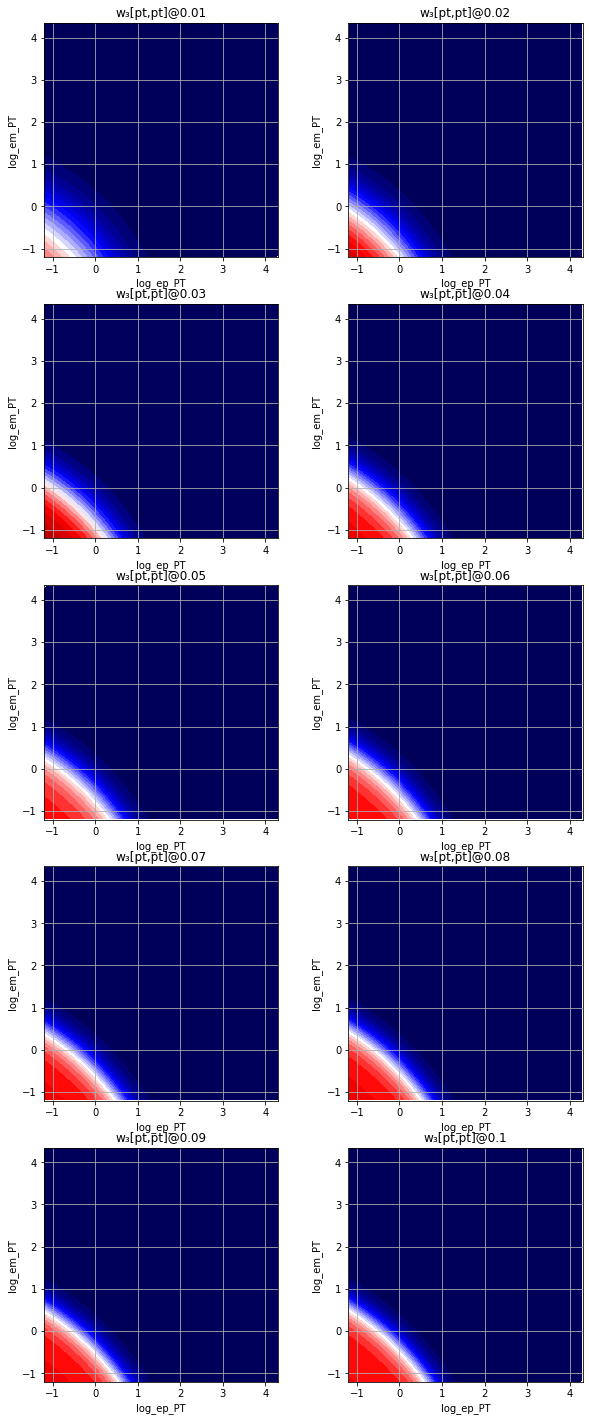

In [137]:
fig, ax = plt.subplots(5, 2, figsize=(10, 25))
for i, k in enumerate(L_results.keys()):
    w = L_results[k]
    w_np = as_numpy(lambda x : w.model(x))
    sc = w.model[0]
    plot_field(w_np, sc, name=w.name, ax=ax[i//2,i%2], color_bar=False)
plt.show()

### Blur

In [172]:
def blur(w, sigma, step=0.01):
    sc = w.model[0]
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    xval = np.arange(x1-sigma, x2+sigma, step)
    yval = np.arange(y1-sigma, y2+sigma, step)
    v = np.asarray(np.meshgrid(xval, yval)).reshape(2,-1).transpose()
    X = sc.inverse_transform(v)
    image = as_numpy(w)(X).reshape(yval.size, xval.size)
    print(image.T.shape)
    
    import scipy.ndimage
    filtered = scipy.ndimage.gaussian_filter(image, sigma=sigma/step)
    
    import scipy.interpolate
    inter = scipy.interpolate.interp2d(xval, yval, filtered)
    
    return lambda v : np.asarray([inter(x,y) for x, y in sc.transform(v)])

In [176]:
m = results[None,"₄[α,p]"]
f00 = as_numpy(m.model)
f0 = blur(m, sigma=0.0, step=0.01)
f1 = blur(m, sigma=0.1, step=0.01)
f2 = blur(m, sigma=0.2, step=0.01)
f4 = blur(m, sigma=0.4, step=0.01)

(3169, 831)
(3189, 851)
(3209, 871)
(3249, 911)


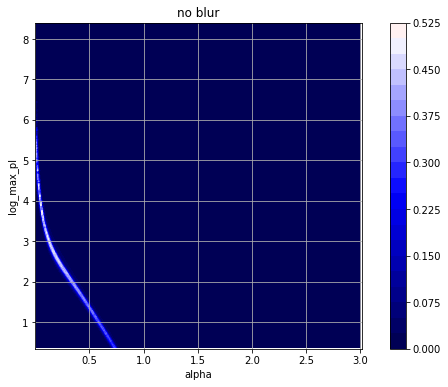

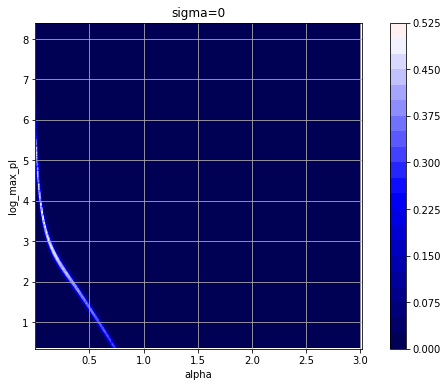

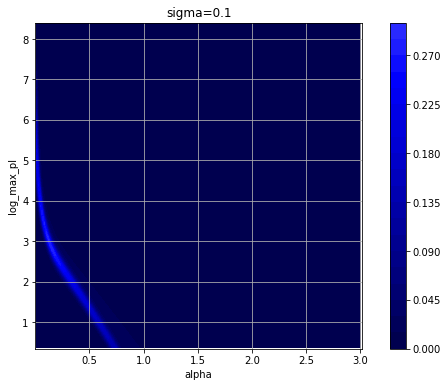

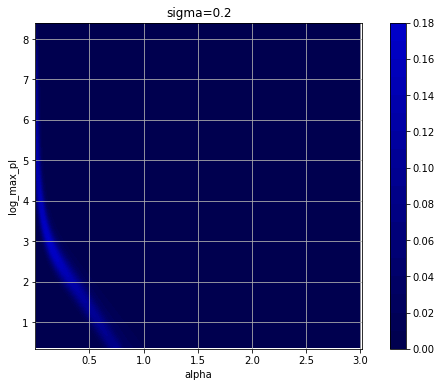

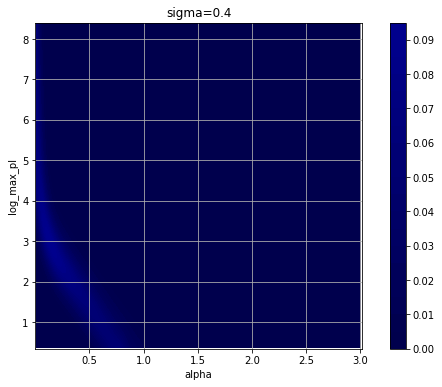

In [177]:
plot_field(f00, m.model[0], name="no blur")
plot_field(f0, m.model[0], name="sigma=0")
plot_field(f1, m.model[0], name="sigma=0.1")
plot_field(f2, m.model[0], name="sigma=0.2")
plot_field(f4, m.model[0], name="sigma=0.4")

In [180]:
def quality_np(datasets, scaler, estimators, refname, name):
    df_w = pd.DataFrame()
    df_w.columns.name = name
    for i, w in enumerate(estimators):
        name1 = "w%s" % i
        r_name = "R%s" % i
        df_w[name1] = None
        for s in datasets:
            ds = Dataset(scaler.features, [s], aliases, name)
            x = to_numpy(ds.X())
            wd = w(x)
            df_w.loc[s.name(),name1] = 1-np.mean(wd).item()
        df_w[r_name] = df_w.loc[refname,name1] / df_w[name1]
    return df_w

In [181]:
quality_np(train_ds, m.model[0], [f00,f0,f1,f2,f4], channel_names[1], "train")

train                  w0        R0        w1        R1        w2        R2  \
B⁺→K⁺ee           0.85455  1.146802  0.854604  1.146667  0.875116  1.097731   
B⁺→K⁺J/ψ(→ee)        0.98       1.0  0.979946       1.0  0.960642       1.0   
B⁺→K⁺ψ(2S)(→ee)  0.988872  0.991028  0.988864  0.990982  0.980533  0.979715   
D⁺→π⁺φ(→ee)          0.93  1.053763  0.930006    1.0537  0.931747  1.031012   

train                  w3        R3        w4        R4  
B⁺→K⁺ee          0.900181  1.054284  0.931462  1.020139  
B⁺→K⁺J/ψ(→ee)    0.949047       1.0  0.950221       1.0  
B⁺→K⁺ψ(2S)(→ee)  0.968587  0.979826  0.960579  0.989217  
D⁺→π⁺φ(→ee)      0.934817  1.015222  0.944236  1.006339

### Conditional plots

In [ ]:
def plot_e(w_obj, feature, bins, ax=None):
    axis = plt.gca() if ax is None else ax
    for s in selected:
        ds = Dataset([feature] + w_obj.model[0].features, [s], aliases, feature)
        try:
            x = ds.X(device=device)
        except KeyError:
            continue
        q2d = to_numpy(x[:,0])
        wd = to_numpy(1 - w_obj.model(x[:,1:])[:,0])
        #print(q2d.shape, wd.shape)
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        axis.step(bins[:-1], hd, where='post', label=s.name())
    axis.set_title("e(%s) for %s" % (feature, w_obj.name))
    axis.legend()
    axis.grid()
    if ax is None:
        plt.show()

In [ ]:
def plot_e_all(feature, bins):
    fig, ax = plt.subplots(3, 2, figsize=(10, 15))
    plot_e(w_la4, feature, bins=bins, ax=ax[0,0])
    plot_e(w_la3, feature, bins=bins, ax=ax[0,1])
    plot_e(w_pt4, feature, bins=bins, ax=ax[1,0])
    plot_e(w_pt3, feature, bins=bins, ax=ax[1,1])
    plot_e(w_a4, feature, bins=bins, ax=ax[2,0])
    plot_e(w_a3, feature, bins=bins, ax=ax[2,1])
    plt.show()   

In [ ]:
plot_e_all("q2_TRUE", np.linspace(0,14,101))

In [ ]:
plot_e_all("alpha", np.linspace(0,0.5,101))

In [ ]:
plot_e_all("log_max_pl", np.linspace(0,7,101))

In [ ]:
plot_e_all("em_PT_TRUE", np.linspace(0,12,101))

In [ ]:
plot_e_all("B_PT_TRUE", np.linspace(0,60,101))

### Base estimators

In [ ]:
def show_many(scaler, model, name, by=2, size=5.0):
    import matplotlib.colors
    import matplotlib.cm

    w = as_numpy(model.eval())
    n_inputs = len(scaler.features)
    n_outputs = w(np.zeros((1, n_inputs))).shape[1]
    n2 = (n_outputs + by - 1) // by
    fig, ax = plt.subplots(n2, by, figsize=(by*size, n2*size), sharex=True, sharey=True)
    for i, ax_ in zip(range(n_outputs), ax.flat):
        plot_field(lambda x : w(x)[...,i], scaler, name="%s[%d]"%(name, i), ax=ax_, color_bar=False)
    
    normalizer = matplotlib.colors.Normalize(0, 1)
    im = matplotlib.cm.ScalarMappable(norm=normalizer, cmap=plt.cm.seismic)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.13, 0.02, 0.74]) #lbwh
    fig.colorbar(im, cax=cbar_ax)
    plt.show()

In [ ]:
def show_est(est, name):
    model = est.model.eval()
    scaler = est.scaler
    w = nn.Sequential(model, torch.nn.Softmax(dim=-1))
    show_many(scaler, w, name)

In [ ]:
def show_fns(w):
    model = w.model.eval()
    show_many(model[0], model[:-1], w.name)

In [ ]:
show_est(e_la4, "e4")

In [ ]:
show_fns(w_la4)

In [ ]:
show_est(e_pt4, "e4")

In [ ]:
show_fns(w_pt4)

### New stuff

In [ ]:
w43 = Weighting(e_la4, n_classes=3, name="w43")
w43.train(ds_la3, target_L=0.1)

In [ ]:
w43pt = Weighting(e_pt4, n_classes=3, name="w43pt")
w43pt.train(ds_pt3, target_L=0.1)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, d in enumerate([w43, w43pt]):
    sc = d.model[0]
    w_np = as_numpy(lambda x : d.model(x))
    feat = len(sc.features)
    if feat == 2:
        plot_field(w_np, sc, name=d.name, ax=ax[i], color_bar=False)
    elif feat == 1:
        plot_one(w_np, sc, name=d.name, ax=ax[i], vmax=None)
plt.show()

In [ ]:
quality(train_ds, [w_la3, w43, w_pt3, w43pt], channel_names[1], "train")

In [ ]:
show_fns(w43)
show_fns(w43pt)

In [ ]:
ds_apt = Dataset(["alpha", "log_ep_PT", "log_em_PT"], train_ds, aliases, "₄[α,pt,pt]")

In [ ]:
e_apt = Estimator(ds_apt)
e_apt.train(ds_apt)

In [ ]:
w_apt = Weighting(e_apt, name="w_apt")
w_apt.train(ds_apt, target_L=0.1)

In [ ]:
quality(train_ds, [w_apt, w_la4, w_pt4], channel_names[1], "train")

In [ ]:
quality(test_ds, [w_apt, w_la4, w_pt4], channel_names[1], "test")

In [ ]:
e10 = Estimator(ds_la4)
e10.model = torch.nn.Sequential(e10.scaler, model(len(e10.features), 10)).to(device)
w10 = Weighting(e10, n_classes=4, name="w10")

In [ ]:
train_estimator(ds_la4, torch.nn.Sequential(w10.model[0:2], torch.nn.Dropout(), torch.nn.Linear(10, 4)))

In [ ]:
show_fns(w10)

In [ ]:
w10.train(ds_la4, target_L=0.1)

In [ ]:
quality(test_ds, [w_la4, w10], channel_names[1], "test")

In [ ]:
show_fns(w10)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, d in enumerate([w_la4, w10]):
    sc = d.model[0]
    w_np = as_numpy(lambda x : d.model(x))
    feat = len(sc.features)
    if feat == 2:
        plot_field(w_np, sc, name=d.name, ax=ax[i], color_bar=False)
    elif feat == 1:
        plot_one(w_np, sc, name=d.name, ax=ax[i], vmax=None)
plt.show()